# Eighth Exercise (BNNs and ensembles)

This exercise focuses on Uncertainty in Deep Learning.

We will
- Implement an optimizer that uses a Stochastic Gradient Markov Chain Monte Carlo (SG-MCMC) method
- Implement a BNN
- See how uncertainty estimates can be derived using BNNs
- Plot these uncertainty estimates
- Implement an ensemble of NNs to get their uncertainty estimates and plot them


## 8.1 Bayesian inference in BNNs


BNNs define a distribution over the parameters of an NN. We then use the Bayes rule to calculate the posterior distribution over the parameters $\mathbf{\theta}$: 
<br><br>
    \begin{equation}
 \quad\quad   \quad\quad        p(\mathbf{\theta} \vert \mathbf{D})  = \frac{p(\mathbf{D} \vert \mathbf{\theta}) \cdot p(\mathbf{\theta})}{p(\mathbf{D})}  \quad.......\quad (\textbf{Eqn. 1})
    \end{equation}
    
where $\mathbf{D}$ is the data, $\mathbf{\theta}$ are the parameters.

Averaging the predictions over the posterior gives us the mean predictions of the BNN:
<br><br>
    \begin{equation*}
        \mathbf{\mu}_{BNN}(\mathbf{x}) = \intop BNN(\mathbf{x}; \mathbf{\theta}) \, p(\mathbf{\theta} \vert \mathbf{D}) \, d\mathbf{\theta}  \quad.......\quad (\textbf{Eqn. 2})
    \end{equation*}
    
and the variance in the predictions:
<br><br>
    \begin{equation*}
        \mathbf{\sigma^2}_{BNN}(\mathbf{x}) = \intop \Big( BNN(\mathbf{x}; \mathbf{\theta}) - \mathbf{\mu}_{BNN}(\mathbf{x}) \Big)^2 \, p(\mathbf{\theta} \vert \mathbf{D}) \, d\mathbf{\theta}  \quad.......\quad (\textbf{Eqn. 3})
    \end{equation*}

**Questions:**

- a) What does the averaging above achieve with regard to the generalisation capabilities of the network?
- b) Why would the averaging above usually be intractable for Neural Networks?

**Answers:** **TODO**
- a) It helps prevent overfitting by averaging the prediction over all the possible values for the set of parameters for the network.
- b) It involves integrating over all the possible values for the set of parameters of the neural network.


### 8.1.1 SG-MCMC methods for BNNs

Since exact inference in BNNs is usually intractable, here we will use Markov Chain Monte Carlo (MCMC) methods to average over sampled network parameters. Combining these with Stochastic Gradient methods gives us batch methods to update network parameters for BNNs and at the same time be able to sample them. Here we will implement a simple SG-MCMC method, preconditioned Stochastic Gradient Langevin Dynamics (pSGLD) from http://people.ee.duke.edu/~lcarin/aaai_psgld_final.pdf which basically preconditions the original SGLD from https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf by combining it with RMSProp.<br><br>**Note:** You don't have to read the papers to finish the exercise, the necessary equations adapted for our use are provided here.

#### 8.1.1.1 Stochastic Gradient Langevin Dynamics (SGLD)

In SGLD, we insert a bit of noise into the update step from SGD. We draw this noise from the normal distribution with a variance equal to the current learning rate. The update step for the parameters at time step $t$ then looks like:
<br><br>
    \begin{align}
\text{Estimate mini-batch gradient per sample:}\quad& \bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t}) \leftarrow -\underbrace{ \frac{1}{N} \nabla_{\mathbf{\theta}_t} \text{log}\, p(\mathbf{\theta}_t)}_{\text{Derivative of log prior}} - \underbrace{\frac{1}{n} \sum^{n}_{i=1} \nabla_{\mathbf{\theta}_t} \text{log}\, p(\mathbf{d}_{t_i}|\mathbf{\theta}_t)}_{\text{Derivative of log likelihood}}   \quad.......\quad (\textbf{Eqn. 4})\\
\text{Update parameters:}\quad& \mathbf{\theta}_{t+1} \leftarrow \mathbf{\theta}_{t} - \frac{\epsilon_t}{2} \big(N\bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t})\big) - \underbrace{\mathcal{N}(0, \epsilon_t \mathbf{I})}_{\text{Injected noise}}   \quad.......\quad (\textbf{Eqn. 5})\\
    \end{align}
where: <br> $n$ is the mini-batch size, <br>
$N$ is the total number of data points, <br>
$\mathbf{D}^{t} = \{\mathbf{d}_{t_1}, ..., \mathbf{d}_{t_n}\}$ is a randomly selected mini-batch of the data, 
<br>$\epsilon_t$ is the learning rate at time step $t$.

This is the normal stochastic gradient descent update step when the loss is the negative log likelihood (NLL) and with a prior distribution $p(\mathbf{\theta})$ imposed on the parameters with additional noise injected into the update step.

**Questions:**

- a) Assume we are maximising the posterior probability for the parameters given the data (i.e., Eqn. 1). Derive the SGLD update step (i.e., Eqn. 5) from that. <br>(**Note 1:** The learning rate is being divided by 2 here. **Note 2:** Typeset the answer in Latex.)

**Answers:** **TODO**
- a) 
\begin{align}
- \text{log}\,p(\mathbf{\theta} \vert \mathbf{D}) &= - \text{log}\,p(\mathbf{D} \vert \mathbf{\theta}) - \text{log}\,p(\mathbf{\theta}) + \text{log} \,p(\mathbf{D})  \quad\quad \big[\text{Negative log of right hand side of }\textbf{Eqn. 1}\big]\\
&= - \text{log}\, p(\mathbf{\theta}_t) - \sum^{N}_{i=1}  \text{log}\, p(\mathbf{d}_{t_i}|\mathbf{\theta}_t)  \quad\quad\quad\quad \big[\text{Expand 2nd term and ignore the term constant for the dataset}\big]\\
&= - \frac{1}{N} \nabla_{\mathbf{\theta}_t} \text{log}\, p(\mathbf{\theta}_t) -\frac{1}{n} \sum^{n}_{i=1} \nabla_{\mathbf{\theta}_t} \text{log}\, p(\mathbf{d}_{t_i}|\mathbf{\theta}_t)  \quad\quad \big[\text{Derivative estimate for mini-batch leads to }\textbf{Eqn. 4} \big]\\
&  \quad\quad \big[\text{Additionally, it's a per sample stochastic estimate so we divide by the mini-batch contribution}\\
&  \quad\quad \text{of negative log likelihood by $n$ and the log prior which is same for the whole batch by $N$}\big]\\
&= \mathbf{\theta}_{t} - \frac{\epsilon_t}{2} \big(N\bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t})\big) - \underbrace{\mathcal{N}(0, \epsilon_t \mathbf{I})}_{\text{Injected noise}}   \quad\quad \big[\text{Injecting noise and multiplying by learning rate }\textbf{Eqn. 5}\big]\\
\end{align}

Initially, the noise in the stochastic gradient estimate dominates the injected noise in the update step but later on the injected noise dominates and the updated parameters at each step correspond to samples from the posterior distribution of the parameters (derivations in the original SGLD paper for those interested). We call the initial phase **burn-in** and the latter phase the **Langevin dynamics** phase. We can judge the end of the burn-in phase based on a sampling threshold calculated in the original SGLD paper. But for simplicity, here we use an empirically defined number of update steps to denote the burn-in phase.

#### 8.1.1.2 preconditioned Stochastic Gradient Langevin Dynamics (pSGLD)

pSGLD tries to improve upon SGLD by additionally using a preconditioner matrix for the update step to account for different curvatures in different dimensions. To implement pSGLD here, we inject noise similar to SGLD and precondition the update step with the preconditioner from RMSProp. For each time step $t$:
<br><br>
    \begin{align*}
\text{Estimate average of squared gradient:}\quad& \mathbf{V}(\mathbf{\theta}_t) \leftarrow \alpha \mathbf{V}(\mathbf{\theta}_{t-1}) + (1 - \alpha)\,\bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t}) * \bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t}) \quad.......\quad (\textbf{Eqn. 6})\\
\text{Estimate preconditioning matrix:}\quad& \mathbf{G}(\mathbf{\theta}_t) \leftarrow diag( \mathbf{1}\, / \,(\lambda\, \mathbf{1} + \sqrt{\mathbf{V}(\mathbf{\theta}_{t}} )) \quad.......\quad (\textbf{Eqn. 7})\\
\text{Update parameters:}\quad& \mathbf{\theta}_{t+1} \leftarrow \mathbf{\theta}_{t} - \frac{\epsilon_t}{2} (\mathbf{G}(\mathbf{\theta}_t) \big( N\bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t})\big) - \mathcal{N}(0, \epsilon_t (\mathbf{G}(\mathbf{\theta}_t)) \quad.......\quad (\textbf{Eqn. 8})\\
    \end{align*}

where: 
<br>$\alpha \in [0, 1]$ decides how much to weight old information in the exponential moving average of the squared gradient, <br>$\lambda$ is a small constant to avoid divison by zero, <br>$\mathbf{V}(\mathbf{\theta}_0) = \mathbf{0}$.


The next cell does some initial setup for this exercise. 

**Task:** 
Implement a pSGLD optimizer in the cell after the next.


In [394]:
# Some initial setup: Importing required libraries
import os
from typing import Tuple, List, Iterable

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
torch.manual_seed(0)

def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    """Mini-batchifies data"""
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])

def evaluate_loss(model: nn.Module, loss_func: nn.Module, 
                  x: torch.Tensor, y: torch.Tensor) -> Tuple[float, float]:
    """Evaluates given loss function for given data for the given model"""
    model.eval()
    correct = 0
    loss = []
    with torch.no_grad():
        output = model(x)
        loss = loss_func(output, y)
    return loss.numpy()

In [395]:
class pSGLD(torch.optim.Optimizer):
    """preconditioned Stochastic Gradient Langevin Dynamics (pSGLD) Optimizer"""

    def __init__(self, params: Iterable[nn.Parameter], lr: float, num_train_points: int,
                 alpha: float, lamb: float):
        """Init for various parameters of pSGLD, i.e., the hyperparams
        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, num_train_points=num_train_points,
                        alpha=alpha, lamb=lamb)
        super(pSGLD, self).__init__(params, defaults)


    def step(self):
        """Performs a single optimization step.
        
        Implementation is similar to Pytorch's implementation of SGD here:
        https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD
        """

        for group in self.param_groups:
            for p in group['params']:
                
                if p.grad is None:
                    continue


                state = self.state[p]
                lr = group["lr"]
                num_train_points = group["num_train_points"]
                alpha = group["alpha"]  # alpha
                lamb = group["lamb"]  # lambda
                gradient = p.grad.data

                #  state initialization
                if len(state) == 0:
                    # START TODO ################
                    # Init V(theta_t)
                    state["squared_avg_g"] = torch.zeros_like(p)
                    # END TODO ################

                # START TODO ################
                # Carry out the steps of pSGLD: Eqn. 6, 7 and 8 and the injected noise component from eqn. 5.
                squared_avg_g = state["squared_avg_g"]
                squared_avg_g = squared_avg_g * alpha + (1.0 - alpha) * (gradient ** 2)
                state["squared_avg_g"] = squared_avg_g  # V(theta_t+1)

                preconditioner = (1. / (torch.sqrt(squared_avg_g) + lamb))  # G(theta_t+1)

                # standard deviation of the injected noise
                sigma = torch.sqrt(torch.tensor(lr)) * torch.sqrt(preconditioner)

                mean = 0.5 * lr * (preconditioner * gradient * num_train_points)
                delta_p = (mean + torch.normal(mean=torch.zeros_like(gradient), std=torch.ones_like(gradient)) * sigma)

                p.data.add_(-delta_p)
                # END TODO ################


### 8.1.2 Implement a BNN

**Question:**
- a) How would you modify the calculation of the mean and variance (from section 8.1 above) to get empirical estimates of those quantities for the BNN? (**Note:** Typeset the answer in Latex)

**Answer: TODO**
- a) Mean:
<br><br>
    \begin{equation*}
        \mathbf{\mu}_{BNN}(\mathbf{x}) = \sum^{m}_{i=1} BNN(\mathbf{x}; \mathbf{\theta}_i) 
    \end{equation*}

where we have sampled $m$ sets of parameters of the network.
    
and the variance in the predictions:
<br><br>
    \begin{equation*}
        \mathbf{\sigma^2}_{BNN}(\mathbf{x}) = \sum^{m}_{i=1}  \Big( BNN(\mathbf{x}; \mathbf{\theta}_i) -  \mathbf{\mu}_{BNN}(\mathbf{x}) \Big)^2
    \end{equation*}

**Task:** Implement a BNN in the next cell by holding an instance of a neural network model and saving samples of the network's parameters once we are out of the burn-in phase and into the Langevin dynamics phase. To make the calculations of the predictions tractable, we will predict using these samples.


In [396]:
class BNN(nn.Module):    
    def __init__(self, model: nn.Module, burn_in: int, keep_every: int):
        """Initializes various parameters of the BNN
        
        model: Any neural network
        burn_in: Number of steps of the burn-in phase
        keep_every: Save a sample of the held network's parameters 
                    every keep_every steps after the burn-in phase
                    
        """
        super(BNN, self).__init__()
        # START TODO ########################
        # Maintain a state for the BNN including the current step
        # and currently held sampled network parameters.
        # What to code here will probably be clearer
        # after implementing the step() function below
        self.model = model
        self.sampled_nets = []
        self.burn_in = burn_in
        self.keep_every = keep_every
        self.current_step = 0
        # END TODO ########################

    # Since the BNN has to take samples of the networks, we implement a step() function for the BNN as well.        
    def step(self):
        """Implements the step function of the BNN"""
        # START TODO ########################
        # Sample the held neural network's parameters here by saving them to the BNN's state
        # Note: It'd be easier to just save a deepcopy of the whole neural network.
        # Remember to sample only after the burn-in phase is done and then sample every
        # keep_every steps
        self.current_step += 1
        if self.current_step >= self.burn_in and (self.current_step - self.burn_in) % self.keep_every == 0:
            self.sampled_nets.append(copy.deepcopy(model))
        # END TODO ########################
        
    def forward(self, x) -> torch.Tensor:
        """Forward pass of the BNN"""
        return self.model(x)

    def predict_mean_and_std(self, x, 
                             return_individual_predictions: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns mean and standard deviation of the predictions of the sampled networks
        
        In case return_individual_predictions is True, return all the predictions of the sampled networks, 
        as a Torch tensor
        """
        # START TODO ########################
        # When training or before the burn-in phase is completed,
        # we don't intend to get uncertainty estimates in the
        # predictions anyway, so just return the output from
        # the normal forward pass and the standard deviation as 0, 
        # otherwise return the mean of the predictions and standard deviation
        # of the sampled networks.

        # We will be predicting the mean and the log variance of the data (see slide 47 of lecture)
        # in later code below. So the first dimension of the network outputs will be the mean
        # and the 2nd dimension will be the log variance
        # which amounts to the observational noise. So, don't forget
        # to add the variances from the predicted variance (i.e., exp of 2nd dimension of output)
        # to the empirical variance of the mean (i.e., variance of 1st dimension of output) 
        # according to the law of total variance. Be extra careful with where you take squares
        # and exp()s, etc.!!

        # In case, return_individual_predictions is True, return
        # all the predictions of all the sampled networks.
        if self.training or self.current_step <= self.burn_in:
            return self.model(x), torch.tensor([0])
        else:
            preds = [net(x)[..., None] for net in self.sampled_nets]
            preds = torch.cat(preds, dim=-1)
            if return_individual_predictions:
                return preds
            mean = torch.mean(preds, dim=-1)
            std = torch.std(preds, dim=-1)
            std[..., 0] = torch.sqrt(std[..., 0]**2 + mean[..., 1].exp())
            return mean, std
        # END TODO ########################
        

### 8.1.3 Sinc function

We will be performing regession on the sinc function. It is defined as:
<br><br>
    \begin{equation*}
        sinc(x) = \frac{sin(x)}{x}
    \end{equation*}
    
The value at x = 0 is defined to be the limiting value, equal to 1.

**Task:**
Please complete the code to plot the function in the next cell.

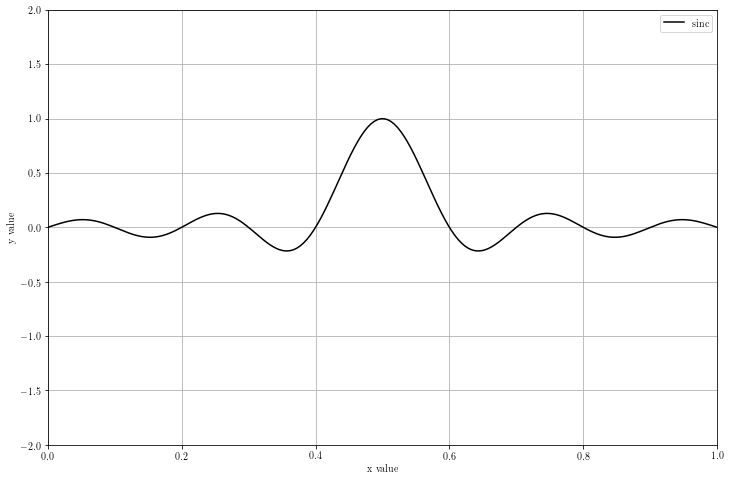

In [397]:
# START TODO ########################
# Note: You can use the sinc implementation from numpy
grid = np.linspace(0, 1, 200)
fvals = np.sinc(grid * 10 - 5)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

plt.plot(grid, fvals, "k", label='sinc')
plt.grid()
plt.xlim(0, 1)
plt.ylim(-2, 2)

plt.legend(loc='best')
plt.xlabel('x value')
plt.ylabel('y value')

plt.show()
# END TODO ########################


### 8.1.4 Loss function

We will be minimizing the negative log likelihood (NLL) loss + negative log prior function in our algorithm. This corresponds to the negative log of the numerator in eqn. 1, i.e.:
<br>
\begin{equation}
-\underbrace{\text{log}\, p(\mathbf{D} \vert \mathbf{\theta})}_{\text{Log likelihood}} -\underbrace{\text{log}\, p(\mathbf{\theta})}_{\text{Log prior}}
\end{equation}
#### Prior component of the loss
Here we will model this prior using a normal distribution and impose this prior only on the weights of the network:
<br><br>
    \begin{equation}
        p(\mathbf{\theta}) = \mathcal{N}(0, \mathbf{\sigma}^{2}_{\mathbf{\theta}})  \quad.......\quad (\textbf{Eqn. 9})
    \end{equation}
<br>
We set this $\mathbf{\sigma}^{2}_{\mathbf{\theta}}$ equal to the constant 1 here. The prior can be seen to have a regularising effect on the weights of the network.
<br>

**Note:** This variance on the parameters of the network is different from the variance of the output. The variance in the parameters is what is used in BNNs to sample different sets of parameters for the BNN while the variance in the output can capture something like noise in the data and could be used even for other types of neural networks.
<br>

#### NLL component of the loss
In order to use the NLL function we need a probability density for the output of the model given its inputs and parameters. Here we will model this probability using a normal distribution. So:
<br><br>
    \begin{align}
        p(\mathbf{D} \vert \mathbf{\theta}) &= \prod^{N}_{i=1}p(\mathbf{d}_{i}|\mathbf{\theta}) \quad.......\quad (\textbf{Eqn. 10}) \\
    \end{align}
<br>
where: <br>
$\mathbf{D} = \{\mathbf{d}_{1}, ..., \mathbf{d}_{N}\}$ is the data <br>
and $\mathbf{d}_{i} = (\mathbf{x}_i, y_i)$ is data point $i$.
<br>

Taking negative log and assuming normal distribution, we get:
<br>
    \begin{align}
        \quad\quad\quad\quad &= -\sum^{N}_{i=1}\text{log}\,\mathcal{N}(\hat{y}_{i}, \hat{\sigma}^{2}_{i}) \quad.......\quad (\textbf{Eqn. 11}) \\
        &\big[\text{where $\hat{y}_{i}$ is the mean prediction and $\hat{\sigma}^{2}_{i}$ is the variance prediction of the model for data point $i$}\big] \\
        &= \sum^{N}_{i=1}\big(\frac{\text{log}\,\hat{\sigma}^{2}_{i}}{2} + \frac{\text{log}\,2\pi}{2} + \frac{(y_i - \hat{y}_i)^2}{2\hat{\sigma}^{2}_{i}}\big) \quad.......\quad (\textbf{Eqn. 12})
    \end{align}
<br>


The normal distribution is completely characterised by its mean and variance. In order to get these parameters of the distribution, we will predict them using a neural network.
<br>

If the variance of output doesn't depend on the input, then we have **homoscedasticity**. Otherwise, we have heteroscedasticity. Here let's assume that the variance captures the noise in the data and that this noise has constant variance independent of the input. 
<br>

We will predict the mean using a neural network like we normally do. In order to get the variance, we will use an additional homoscedastic layer at the end of the neural network to output the log of the variance.

In the next cell, we will implement the NLL loss with a prior and also a homoscedastic layer for a neural network.

**Questions:**
- a) Why can't we use the NLLLoss implemented in PyTorch?
- b) Derive the log prior component of the loss with respect to the neural network's parameters when modelling the prior as the normal distribution above with $\mathbf{\sigma}^{2}_{\mathbf{\theta}}$ = 1. <br>(**Note:** It's the derivative of the log prior from Eqn. 4 above that needs to be found in the specific case when the prior is a normal distribution.)
- c) Why would minimizing the NLL loss be equivalent to minimising the MSE loss for homoscedastic data but not necessarily for heteroscedastic data? <br>(**Note:** No need to derive the whole thing, just an answer in words is enough)

**Answers: TODO**
- a) NLLLoss in Pytorch is defined for classification and we intend to perform regression. Additionally, it does not have a prior.
- b)
\begin{align}
-\nabla_{\mathbf{\theta}_t}\text{log}\, p(\mathbf{\theta}_t) &= -\nabla_{\mathbf{\theta}_t}\text{log}\,\mathcal{N}(0, \mathbf{\sigma}^{2}_{\mathbf{\theta}})  \quad\quad \big[\text{Derivative of negative log of eqn. 9}\big]\\
&= \nabla_{\mathbf{\theta}_t}\big(\frac{\text{log}\,\mathbf{\sigma}^{2}_{\mathbf{\theta}}}{2n_{\theta}} + \frac{\text{log}\,2\pi}{2n_{\theta}} + \frac{(\mathbf{\theta} - \mathbf{0})^T\,\mathbf{I}\,(\mathbf{\theta} - \mathbf{0})}{2\mathbf{\sigma}^{2}_{\mathbf{\theta}}}\big)\quad\quad \big[\text{By definition of Gaussian that we have imposed}\big]\\
&= \mathbf{\theta}\quad\quad\quad\quad\big[\text{We set $\mathbf{\sigma}^{2}_{\mathbf{\theta}}$ equal to the constant 1}\big]
\end{align}
<br>
where $n_{\theta}$ is the number of parameters.
- c) For homoscedastic data, in the NLL loss: $-\sum^{n}_{i=1} \nabla_{\mathbf{\theta}_t} \text{log}\, p(\mathbf{d}_{t_i}|\mathbf{\theta}_t) = \sum^{n}_{i=1} \nabla_{\mathbf{\theta}_t}\big(\frac{\text{log}\,\mathbf{\sigma}^{2}_{\mathbf{same}}}{2} + \frac{(y_i - \mu_{BNN}(\mathbf{x}_i))^2}{2\mathbf{\sigma}^{2}_{same}}\big)$ 
<br>
where $\sigma_{same}^2$ is the predicted homoscedastic variance for the data and $\mathbf{d}_{t_i} = (\mathbf{x}_i, y_i)$ is data point $i$, the denominator in the 2nd term is the same everywhere for fixed $\sigma_{same}^2$ so it has the same minimizer as the MSE minimizer (the 1st term doesn't matter for the location of the minimum wrt the parameters which are common to the MSE minimizer and the NLL minimizer). But for heteroscedastic data this is not the case since the variance varies and is a function of the input, so that leads to a possibly different minimizer for heteroscedastic data.

**Task:**
Please implement the missing parts of the code in the next cell.

In [398]:
class NLLWithPriorLoss(nn.Module):
    def __init__(self, params: Iterable[nn.Parameter], num_train_points: int):
        """Init for NLLWithPriorLoss
        
        We need num_train_points because the log prior component from eqn. 4
        is divided by num_train_points.

        We need params to calculate the log prior component in eqn. 4.
        Remember to instantiate an object of this class with model.named_parameters() 
        so that we can check for which parameters to use the prior. In this case, we 
        impose a Gaussian prior only on the weight parameters.
        """
        super(NLLWithPriorLoss, self).__init__()
        self.parameters = list(params)
        self.num_train_points = num_train_points

    def forward(self, input, target) -> torch.Tensor:
        """Implement forward for the loss function.
        
        Perform the Stochastic Gradient and log prior calculations from eqn. 4.
        Don't forget to divide the log likelihood by batch_size and to divide the log
        prior by the num_train_points. These will be rescaled by num_train_points
        in the pSGLD optimizer.
        
        Please remember that the neural net has 2 outputs: the mean and the log variance.
        """
        # START TODO ########################
        batch_size = input.size(0)

        prediction_mean = input[:, 0].view((-1, 1))
        log_prediction_var = input[:, 1].view((-1, 1))
        prediction_variance_inverse = 1. / (torch.exp(log_prediction_var) + 1e-16)

        squared_errors = (target.view(-1, 1) - prediction_mean) ** 2

        log_likelihood = torch.sum(
            torch.sum(-squared_errors * (0.5 * prediction_variance_inverse) - 0.5 * log_prediction_var
                      - 0.5 * np.log(2 * np.pi), dim=1))

        log_likelihood = log_likelihood / batch_size
        sigma = 1 # std dev on parameter distribution of the neural network
        for p in self.parameters:
            if ('weight' in p[0]):
                log_prior = - torch.sum((p[1] ** 2) / (2 * (sigma ** 2)) - np.log(sigma) - 0.5 * np.log(2 * np.pi))
        log_likelihood += log_prior / (self.num_train_points)
        
        return -log_likelihood
        # END TODO ########################

class HomoscedasticLogVar(nn.Module):
    """This will be last layer of the Neural Network we train.
    It takes the normal output of the neural network until that point,
    i.e. the mean prediction, and just appends a vector containing the
    log variance which best explains the data, i.e., which minimizes the loss.
    """
    def __init__(self, logvar, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.logvar = nn.Parameter(torch.FloatTensor([[logvar]]))

    def forward(self, x):
        # START TODO ########################
        # Concatenate the predicted log variance with x,
        # This will result in 2 outputs for the neural net
        # when we append this layer to a normal NN with one output.
        return torch.cat((x, self.logvar * torch.ones_like(x)), dim=1)
        # END TODO ########################


### 8.1.5 Evaluation

**Task:**
Implement parts of the evaluate_model() function which takes a BNN along with an optimizer and a learning rate scheduler and trains the BNN in the next cell.

In [399]:
def evaluate_model(model, optimizer, loss_func, scheduler, x_train, y_train, x_test, y_test, epochs, batch_size):
    print("Training and evaluating model...")

    train_losses = []
    test_losses = []

    for epoch in range(int(epochs)):
        print("  Epoch {} / {} ...".format(epoch + 1, epochs).ljust(2))
        # START TODO ########################
        scheduler.step()
        loss = 0
        train_loss = 0
        model.train()
        # END TODO ########################

        ix = np.arange(len(x_train))
        np.random.shuffle(ix)
        
        shuffled_data = zip(minibatched(x_train[ix], batch_size), minibatched(y_train[ix], batch_size))

        for i, (x, y) in enumerate(shuffled_data):
            # START TODO ########################
            # Don't forget to call model.step() in case you call this function on the BNN from above
            optimizer.zero_grad()
            output = model(x)
            loss = loss_func(output, y)
            loss.backward()
            optimizer.step()
            if isinstance(model, BNN):
                model.step()
            # END TODO ########################
        train_loss = evaluate_loss(model, loss_func, x_train, y_train)
        test_loss = evaluate_loss(model, loss_func, x_test, y_test)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print('Train loss:', train_losses[-1], 'Test loss:', test_losses[-1])

    return train_losses, test_losses


**Task:** Now write the code which uses the above code to train the BNN. The scheduler needs to have a decreasing schedule for the learning rate, otherwise the algorithm may not converge.


In [414]:
# We have selected the hyperparamters for you below.
n_train = 30
epochs = 10000
batch_size=n_train//2
lr = 1e-3

np.random.seed(42)
x = np.random.uniform(0, 1, n_train)
y = np.sinc(x * 10 - 5)

x = torch.FloatTensor(x[:, None])
y = torch.FloatTensor(y[:, None])

x_test = np.random.uniform(0, 1, 20)
y_test = np.sinc(x_test * 10 - 5)
x_test = torch.from_numpy(x_test[:, None]).float()
y_test = torch.from_numpy(y_test[:, None]).float()

model = nn.Sequential(
  nn.Linear(in_features=1, out_features=50, bias=True),
  nn.Tanh(),
  nn.Linear(in_features=50, out_features=50, bias=True),
  nn.Tanh(),
  nn.Linear(in_features=50, out_features=50, bias=True),
  nn.Tanh(),
  nn.Linear(in_features=50, out_features=1, bias=True),
  HomoscedasticLogVar(np.log(1e-3))
)

# Note: The number of burn-in steps is the total number of mini-batch steps
# while the number of epochs counts passes over the whole batch
bnn = BNN(model, burn_in=15000, keep_every=50)
criterion = NLLWithPriorLoss(bnn.named_parameters(), num_train_points=n_train)
optimizer = pSGLD(bnn.parameters(), lr=lr, num_train_points=n_train, 
                  alpha=0.99, lamb=1e-5)

lambda1 = lambda epoch: 1/(epoch//20 + 1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

# START TODO ########################
train_losses, test_losses = evaluate_model(model=bnn, optimizer=optimizer, loss_func=criterion,
                                           scheduler=scheduler, x_train=x, y_train=y, 
                                           x_test=x_test, y_test=y_test,
                                           epochs=epochs, batch_size=batch_size)
# END TODO ########################



Training and evaluating model...
  Epoch 1 / 10000 ...
Train loss: 18063.93 Test loss: 18749.797
  Epoch 2 / 10000 ...
Train loss: 726.66595 Test loss: 484.44012
  Epoch 3 / 10000 ...
Train loss: 26.91695 Test loss: 19.269373
  Epoch 4 / 10000 ...
Train loss: 27.137789 Test loss: 21.254208
  Epoch 5 / 10000 ...
Train loss: 27.552286 Test loss: 23.415922
  Epoch 6 / 10000 ...
Train loss: 28.417835 Test loss: 26.30607
  Epoch 7 / 10000 ...
Train loss: 30.363668 Test loss: 13.456055
  Epoch 8 / 10000 ...
Train loss: 27.05809 Test loss: 16.209373
  Epoch 9 / 10000 ...
Train loss: 27.3294 Test loss: 15.7355995
  Epoch 10 / 10000 ...
Train loss: 25.341688 Test loss: 15.879922
  Epoch 11 / 10000 ...
Train loss: 51.703808 Test loss: 20.174095
  Epoch 12 / 10000 ...
Train loss: 29.601732 Test loss: 29.735806
  Epoch 13 / 10000 ...
Train loss: 37.1006 Test loss: 13.949281
  Epoch 14 / 10000 ...
Train loss: 27.603178 Test loss: 24.130655
  Epoch 15 / 10000 ...
Train loss: 26.7975 Test loss: 20.44

Train loss: 1.2631842 Test loss: 0.7477788
  Epoch 126 / 10000 ...
Train loss: -1.3680505 Test loss: -0.91357785
  Epoch 127 / 10000 ...
Train loss: 0.41016686 Test loss: 3.650505
  Epoch 128 / 10000 ...
Train loss: -1.5913337 Test loss: -0.08646047
  Epoch 129 / 10000 ...
Train loss: -1.5192792 Test loss: -1.1095433
  Epoch 130 / 10000 ...
Train loss: -0.29644787 Test loss: -0.96184295
  Epoch 131 / 10000 ...
Train loss: 2.4641619 Test loss: 5.049984
  Epoch 132 / 10000 ...
Train loss: 0.24621344 Test loss: 0.8811097
  Epoch 133 / 10000 ...
Train loss: 0.26698005 Test loss: 1.3504611
  Epoch 134 / 10000 ...
Train loss: -2.0227404 Test loss: -0.80195665
  Epoch 135 / 10000 ...
Train loss: -1.6876204 Test loss: -0.06465435
  Epoch 136 / 10000 ...
Train loss: -0.12545156 Test loss: 0.6207851
  Epoch 137 / 10000 ...
Train loss: 0.7701167 Test loss: 0.9084858
  Epoch 138 / 10000 ...
Train loss: -0.88041985 Test loss: 0.37463164
  Epoch 139 / 10000 ...
Train loss: -0.21986914 Test loss: 1.2

Train loss: -2.2286701 Test loss: -1.0586009
  Epoch 284 / 10000 ...
Train loss: -2.7515812 Test loss: -1.3142672
  Epoch 285 / 10000 ...
Train loss: -2.3624437 Test loss: -0.95255065
  Epoch 286 / 10000 ...
Train loss: -2.8843327 Test loss: -1.1572309
  Epoch 287 / 10000 ...
Train loss: -2.736887 Test loss: -1.292118
  Epoch 288 / 10000 ...
Train loss: -2.0097861 Test loss: -0.4693631
  Epoch 289 / 10000 ...
Train loss: -0.59724385 Test loss: -0.23307133
  Epoch 290 / 10000 ...
Train loss: -2.8014264 Test loss: -1.5270562
  Epoch 291 / 10000 ...
Train loss: -2.7147305 Test loss: -1.5800362
  Epoch 292 / 10000 ...
Train loss: -2.8578925 Test loss: -1.2574406
  Epoch 293 / 10000 ...
Train loss: -2.7660651 Test loss: -1.4530687
  Epoch 294 / 10000 ...
Train loss: -2.5419748 Test loss: -0.9851143
  Epoch 295 / 10000 ...
Train loss: -1.7351171 Test loss: 0.1655556
  Epoch 296 / 10000 ...
Train loss: -1.9593809 Test loss: -0.79315054
  Epoch 297 / 10000 ...
Train loss: -2.335292 Test loss: 

Train loss: -2.4429975 Test loss: -0.8964272
  Epoch 406 / 10000 ...
Train loss: -3.1252103 Test loss: -0.63722056
  Epoch 407 / 10000 ...
Train loss: -2.72289 Test loss: -1.1138957
  Epoch 408 / 10000 ...
Train loss: -2.9767537 Test loss: -1.4797449
  Epoch 409 / 10000 ...
Train loss: -3.1661632 Test loss: -1.3975403
  Epoch 410 / 10000 ...
Train loss: -1.754853 Test loss: -0.6017735
  Epoch 411 / 10000 ...
Train loss: -2.9868107 Test loss: -1.1846578
  Epoch 412 / 10000 ...
Train loss: -2.835248 Test loss: -1.5995796
  Epoch 413 / 10000 ...
Train loss: -3.2737217 Test loss: -1.9924091
  Epoch 414 / 10000 ...
Train loss: -3.093546 Test loss: -1.8647432
  Epoch 415 / 10000 ...
Train loss: -2.994582 Test loss: -1.6241616
  Epoch 416 / 10000 ...
Train loss: -2.9149656 Test loss: -0.47282815
  Epoch 417 / 10000 ...
Train loss: -2.9867928 Test loss: 0.21483159
  Epoch 418 / 10000 ...
Train loss: -2.5142078 Test loss: 0.9573767
  Epoch 419 / 10000 ...
Train loss: -3.0448992 Test loss: 0.146

Train loss: -2.6088984 Test loss: -0.46747446
  Epoch 531 / 10000 ...
Train loss: -2.4409738 Test loss: -0.27513933
  Epoch 532 / 10000 ...
Train loss: -2.9516132 Test loss: -0.99188447
  Epoch 533 / 10000 ...
Train loss: -3.266523 Test loss: -0.8846665
  Epoch 534 / 10000 ...
Train loss: -2.862438 Test loss: -0.24981403
  Epoch 535 / 10000 ...
Train loss: -3.1768262 Test loss: -1.3531827
  Epoch 536 / 10000 ...
Train loss: -3.0107884 Test loss: -0.6080559
  Epoch 537 / 10000 ...
Train loss: -3.0612826 Test loss: -1.8757944
  Epoch 538 / 10000 ...
Train loss: -2.3010097 Test loss: -0.6253402
  Epoch 539 / 10000 ...
Train loss: -3.0993822 Test loss: -1.7944908
  Epoch 540 / 10000 ...
Train loss: -0.4439236 Test loss: 0.93539405
  Epoch 541 / 10000 ...
Train loss: -1.9184636 Test loss: -0.18754351
  Epoch 542 / 10000 ...
Train loss: -3.1572783 Test loss: -1.5945023
  Epoch 543 / 10000 ...
Train loss: -2.4469461 Test loss: -0.14519417
  Epoch 544 / 10000 ...
Train loss: -2.822844 Test los

Train loss: -3.161202 Test loss: 0.112445354
  Epoch 666 / 10000 ...
Train loss: -2.9929767 Test loss: 0.035595298
  Epoch 667 / 10000 ...
Train loss: -3.3856432 Test loss: -0.4427111
  Epoch 668 / 10000 ...
Train loss: -3.273706 Test loss: 0.21622849
  Epoch 669 / 10000 ...
Train loss: -2.9361506 Test loss: 1.1125699
  Epoch 670 / 10000 ...
Train loss: -2.548026 Test loss: 1.3517245
  Epoch 671 / 10000 ...
Train loss: -3.3207147 Test loss: 0.07781243
  Epoch 672 / 10000 ...
Train loss: -3.3939989 Test loss: -0.0070147514
  Epoch 673 / 10000 ...
Train loss: -3.1871734 Test loss: 0.7603123
  Epoch 674 / 10000 ...
Train loss: -2.868497 Test loss: 0.46585798
  Epoch 675 / 10000 ...
Train loss: -1.883447 Test loss: 1.364252
  Epoch 676 / 10000 ...
Train loss: -3.2123518 Test loss: 0.23276258
  Epoch 677 / 10000 ...
Train loss: -2.999836 Test loss: -0.31383395
  Epoch 678 / 10000 ...
Train loss: -3.334055 Test loss: 0.306839
  Epoch 679 / 10000 ...
Train loss: -3.0500562 Test loss: -0.10855

Train loss: -3.1076443 Test loss: -0.2310623
  Epoch 793 / 10000 ...
Train loss: -3.4000957 Test loss: -1.4777962
  Epoch 794 / 10000 ...
Train loss: -3.2738924 Test loss: -0.9777571
  Epoch 795 / 10000 ...
Train loss: -3.2406788 Test loss: -1.600645
  Epoch 796 / 10000 ...
Train loss: -3.371067 Test loss: -0.770591
  Epoch 797 / 10000 ...
Train loss: -3.2086174 Test loss: 0.2373339
  Epoch 798 / 10000 ...
Train loss: -3.2897806 Test loss: -0.2528863
  Epoch 799 / 10000 ...
Train loss: -3.2766204 Test loss: 0.5929313
  Epoch 800 / 10000 ...
Train loss: -2.9789126 Test loss: -0.34359872
  Epoch 801 / 10000 ...
Train loss: -3.3032098 Test loss: -0.2708459
  Epoch 802 / 10000 ...
Train loss: -3.0601492 Test loss: 0.32552767
  Epoch 803 / 10000 ...
Train loss: -3.234027 Test loss: -0.11722386
  Epoch 804 / 10000 ...
Train loss: -3.136246 Test loss: -0.97568125
  Epoch 805 / 10000 ...
Train loss: -2.8366544 Test loss: -0.19648385
  Epoch 806 / 10000 ...
Train loss: -2.451924 Test loss: -0.5

Train loss: -2.7421765 Test loss: 1.368137
  Epoch 921 / 10000 ...
Train loss: -2.866745 Test loss: 1.5072334
  Epoch 922 / 10000 ...
Train loss: -3.20824 Test loss: 2.400151
  Epoch 923 / 10000 ...
Train loss: -3.2770164 Test loss: 2.2033916
  Epoch 924 / 10000 ...
Train loss: -3.1741145 Test loss: 1.5069537
  Epoch 925 / 10000 ...
Train loss: -3.434207 Test loss: 1.0139314
  Epoch 926 / 10000 ...
Train loss: -3.0267656 Test loss: 2.6324801
  Epoch 927 / 10000 ...
Train loss: -3.488578 Test loss: 1.1346366
  Epoch 928 / 10000 ...
Train loss: -3.0726237 Test loss: 1.7741716
  Epoch 929 / 10000 ...
Train loss: -3.1902812 Test loss: 2.0736117
  Epoch 930 / 10000 ...
Train loss: -3.2471423 Test loss: 1.1766883
  Epoch 931 / 10000 ...
Train loss: -3.4105563 Test loss: 1.4577955
  Epoch 932 / 10000 ...
Train loss: -3.4434838 Test loss: 1.4371793
  Epoch 933 / 10000 ...
Train loss: -3.21626 Test loss: 1.8994973
  Epoch 934 / 10000 ...
Train loss: -3.363947 Test loss: 1.29041
  Epoch 935 / 10

Train loss: -3.3809881 Test loss: -0.6382299
  Epoch 1049 / 10000 ...
Train loss: -3.2954717 Test loss: -0.022489905
  Epoch 1050 / 10000 ...
Train loss: -3.375691 Test loss: -1.3340467
  Epoch 1051 / 10000 ...
Train loss: -3.4522853 Test loss: -0.056055784
  Epoch 1052 / 10000 ...
Train loss: -3.425076 Test loss: -0.48523343
  Epoch 1053 / 10000 ...
Train loss: -3.16468 Test loss: 0.36693263
  Epoch 1054 / 10000 ...
Train loss: -3.370782 Test loss: -0.78280735
  Epoch 1055 / 10000 ...
Train loss: -3.327296 Test loss: 0.52404857
  Epoch 1056 / 10000 ...
Train loss: -3.3099792 Test loss: -0.13788795
  Epoch 1057 / 10000 ...
Train loss: -3.3411546 Test loss: 0.32494652
  Epoch 1058 / 10000 ...
Train loss: -3.38503 Test loss: -0.01779759
  Epoch 1059 / 10000 ...
Train loss: -3.261674 Test loss: -0.2590052
  Epoch 1060 / 10000 ...
Train loss: -3.3894472 Test loss: 0.6336572
  Epoch 1061 / 10000 ...
Train loss: -3.1374023 Test loss: 0.06492126
  Epoch 1062 / 10000 ...
Train loss: -3.361163 

Train loss: -3.1880484 Test loss: 1.4639573
  Epoch 1175 / 10000 ...
Train loss: -3.449235 Test loss: 0.9790468
  Epoch 1176 / 10000 ...
Train loss: -3.2532728 Test loss: 1.0883392
  Epoch 1177 / 10000 ...
Train loss: -3.0335503 Test loss: 2.4281254
  Epoch 1178 / 10000 ...
Train loss: -3.0973847 Test loss: 0.60952914
  Epoch 1179 / 10000 ...
Train loss: -2.5445437 Test loss: 1.8162035
  Epoch 1180 / 10000 ...
Train loss: -3.2304597 Test loss: 1.3969098
  Epoch 1181 / 10000 ...
Train loss: -3.226657 Test loss: 1.8374492
  Epoch 1182 / 10000 ...
Train loss: -3.399694 Test loss: 2.0635476
  Epoch 1183 / 10000 ...
Train loss: -3.2471147 Test loss: 1.384065
  Epoch 1184 / 10000 ...
Train loss: -3.2968817 Test loss: 1.477127
  Epoch 1185 / 10000 ...
Train loss: -3.363911 Test loss: 2.355401
  Epoch 1186 / 10000 ...
Train loss: -2.802639 Test loss: 3.0750918
  Epoch 1187 / 10000 ...
Train loss: -3.2367387 Test loss: 1.5812666
  Epoch 1188 / 10000 ...
Train loss: -3.3007379 Test loss: 2.36445

Train loss: -3.1038883 Test loss: 3.0824285
  Epoch 1300 / 10000 ...
Train loss: -3.372676 Test loss: 3.1700478
  Epoch 1301 / 10000 ...
Train loss: -3.228537 Test loss: 2.8136537
  Epoch 1302 / 10000 ...
Train loss: -2.9567628 Test loss: 4.707138
  Epoch 1303 / 10000 ...
Train loss: -3.1263597 Test loss: 4.1035814
  Epoch 1304 / 10000 ...
Train loss: -3.2360945 Test loss: 3.99295
  Epoch 1305 / 10000 ...
Train loss: -3.3135 Test loss: 3.5876312
  Epoch 1306 / 10000 ...
Train loss: -3.3425477 Test loss: 4.5032997
  Epoch 1307 / 10000 ...
Train loss: -3.1835632 Test loss: 3.9236035
  Epoch 1308 / 10000 ...
Train loss: -3.275704 Test loss: 2.9479432
  Epoch 1309 / 10000 ...
Train loss: -3.1245604 Test loss: 2.497332
  Epoch 1310 / 10000 ...
Train loss: -3.247743 Test loss: 3.9950223
  Epoch 1311 / 10000 ...
Train loss: -3.195801 Test loss: 3.835988
  Epoch 1312 / 10000 ...
Train loss: -3.1811953 Test loss: 2.6565495
  Epoch 1313 / 10000 ...
Train loss: -3.163771 Test loss: 1.485091
  Epo

Train loss: -2.9299116 Test loss: -1.9724338
  Epoch 1420 / 10000 ...
Train loss: -3.1498318 Test loss: -2.3200865
  Epoch 1421 / 10000 ...
Train loss: -3.1721046 Test loss: -2.548051
  Epoch 1422 / 10000 ...
Train loss: -3.0671682 Test loss: -2.414507
  Epoch 1423 / 10000 ...
Train loss: -3.1510215 Test loss: -2.7210279
  Epoch 1424 / 10000 ...
Train loss: -3.188641 Test loss: -2.7616024
  Epoch 1425 / 10000 ...
Train loss: -3.032785 Test loss: -2.7252173
  Epoch 1426 / 10000 ...
Train loss: -2.9654207 Test loss: -3.089664
  Epoch 1427 / 10000 ...
Train loss: -3.0653963 Test loss: -3.0434747
  Epoch 1428 / 10000 ...
Train loss: -2.9153385 Test loss: -2.9136992
  Epoch 1429 / 10000 ...
Train loss: -3.0622773 Test loss: -2.8401914
  Epoch 1430 / 10000 ...
Train loss: -2.9222498 Test loss: -2.9225073
  Epoch 1431 / 10000 ...
Train loss: -3.169653 Test loss: -3.0508575
  Epoch 1432 / 10000 ...
Train loss: -2.9351614 Test loss: -2.8433688
  Epoch 1433 / 10000 ...
Train loss: -2.94642 Test 

Train loss: -3.1820328 Test loss: -0.90886164
  Epoch 1551 / 10000 ...
Train loss: -3.062747 Test loss: -1.0980327
  Epoch 1552 / 10000 ...
Train loss: -3.3171306 Test loss: -1.8553729
  Epoch 1553 / 10000 ...
Train loss: -3.1351593 Test loss: -1.3597844
  Epoch 1554 / 10000 ...
Train loss: -3.2109413 Test loss: -1.1359527
  Epoch 1555 / 10000 ...
Train loss: -3.0376234 Test loss: -0.40738797
  Epoch 1556 / 10000 ...
Train loss: -3.091115 Test loss: -0.6349347
  Epoch 1557 / 10000 ...
Train loss: -3.0842767 Test loss: -1.2072823
  Epoch 1558 / 10000 ...
Train loss: -3.213715 Test loss: -2.119703
  Epoch 1559 / 10000 ...
Train loss: -3.2830713 Test loss: -0.9042979
  Epoch 1560 / 10000 ...
Train loss: -3.2701707 Test loss: -0.80630386
  Epoch 1561 / 10000 ...
Train loss: -3.1372497 Test loss: 0.1026845
  Epoch 1562 / 10000 ...
Train loss: -3.144586 Test loss: -0.34198606
  Epoch 1563 / 10000 ...
Train loss: -3.207226 Test loss: -0.30661738
  Epoch 1564 / 10000 ...
Train loss: -3.254492 

Train loss: -3.380032 Test loss: -1.7550497
  Epoch 1682 / 10000 ...
Train loss: -3.5065513 Test loss: -1.4424479
  Epoch 1683 / 10000 ...
Train loss: -3.2568188 Test loss: -0.25098348
  Epoch 1684 / 10000 ...
Train loss: -3.2505465 Test loss: -0.5386349
  Epoch 1685 / 10000 ...
Train loss: -3.3383727 Test loss: -1.2127112
  Epoch 1686 / 10000 ...
Train loss: -3.0158482 Test loss: -0.7850529
  Epoch 1687 / 10000 ...
Train loss: -3.3407784 Test loss: -1.2159104
  Epoch 1688 / 10000 ...
Train loss: -3.3579812 Test loss: -1.1207188
  Epoch 1689 / 10000 ...
Train loss: -3.347756 Test loss: -1.3111157
  Epoch 1690 / 10000 ...
Train loss: -3.1847973 Test loss: -1.088557
  Epoch 1691 / 10000 ...
Train loss: -3.269671 Test loss: -0.84087634
  Epoch 1692 / 10000 ...
Train loss: -3.275666 Test loss: -1.2304115
  Epoch 1693 / 10000 ...
Train loss: -3.202604 Test loss: -0.28838754
  Epoch 1694 / 10000 ...
Train loss: -3.419828 Test loss: -0.49306405
  Epoch 1695 / 10000 ...
Train loss: -3.3752322 

Train loss: -3.3763692 Test loss: -1.0902696
  Epoch 1813 / 10000 ...
Train loss: -3.1539044 Test loss: -1.0531449
  Epoch 1814 / 10000 ...
Train loss: -3.3582058 Test loss: -0.48038864
  Epoch 1815 / 10000 ...
Train loss: -3.1139648 Test loss: -0.7165518
  Epoch 1816 / 10000 ...
Train loss: -3.3510146 Test loss: -1.6617638
  Epoch 1817 / 10000 ...
Train loss: -3.2444859 Test loss: -1.3908976
  Epoch 1818 / 10000 ...
Train loss: -3.3312697 Test loss: -1.0435219
  Epoch 1819 / 10000 ...
Train loss: -3.1933315 Test loss: -0.32823932
  Epoch 1820 / 10000 ...
Train loss: -3.094892 Test loss: -0.32913494
  Epoch 1821 / 10000 ...
Train loss: -3.3496714 Test loss: -1.0743632
  Epoch 1822 / 10000 ...
Train loss: -3.2245514 Test loss: -0.7844954
  Epoch 1823 / 10000 ...
Train loss: -2.982595 Test loss: -1.0313039
  Epoch 1824 / 10000 ...
Train loss: -3.3011904 Test loss: -2.0166383
  Epoch 1825 / 10000 ...
Train loss: -3.3747935 Test loss: -1.8045701
  Epoch 1826 / 10000 ...
Train loss: -3.3737

Train loss: -3.1149435 Test loss: 10.417059
  Epoch 1943 / 10000 ...
Train loss: -3.223349 Test loss: 12.766131
  Epoch 1944 / 10000 ...
Train loss: -3.1520147 Test loss: 13.1811905
  Epoch 1945 / 10000 ...
Train loss: -3.4369411 Test loss: 14.64004
  Epoch 1946 / 10000 ...
Train loss: -2.752468 Test loss: 16.986227
  Epoch 1947 / 10000 ...
Train loss: -3.2858171 Test loss: 16.8539
  Epoch 1948 / 10000 ...
Train loss: -3.350234 Test loss: 14.704844
  Epoch 1949 / 10000 ...
Train loss: -3.0847917 Test loss: 17.344635
  Epoch 1950 / 10000 ...
Train loss: -3.274037 Test loss: 15.696722
  Epoch 1951 / 10000 ...
Train loss: -3.3721967 Test loss: 13.630416
  Epoch 1952 / 10000 ...
Train loss: -2.7420087 Test loss: 13.413346
  Epoch 1953 / 10000 ...
Train loss: -3.3143487 Test loss: 11.261112
  Epoch 1954 / 10000 ...
Train loss: -3.00568 Test loss: 12.133629
  Epoch 1955 / 10000 ...
Train loss: -3.1522372 Test loss: 13.850674
  Epoch 1956 / 10000 ...
Train loss: -2.901586 Test loss: 14.143479

Train loss: -3.2118804 Test loss: 13.864487
  Epoch 2077 / 10000 ...
Train loss: -3.3464768 Test loss: 15.164312
  Epoch 2078 / 10000 ...
Train loss: -3.3861408 Test loss: 13.671233
  Epoch 2079 / 10000 ...
Train loss: -3.3453767 Test loss: 13.01848
  Epoch 2080 / 10000 ...
Train loss: -3.2273571 Test loss: 15.412636
  Epoch 2081 / 10000 ...
Train loss: -3.2363296 Test loss: 14.792688
  Epoch 2082 / 10000 ...
Train loss: -3.198868 Test loss: 13.798552
  Epoch 2083 / 10000 ...
Train loss: -3.2162304 Test loss: 15.762332
  Epoch 2084 / 10000 ...
Train loss: -3.0300922 Test loss: 14.787798
  Epoch 2085 / 10000 ...
Train loss: -3.2419138 Test loss: 17.523973
  Epoch 2086 / 10000 ...
Train loss: -3.24513 Test loss: 15.675107
  Epoch 2087 / 10000 ...
Train loss: -3.3079295 Test loss: 15.359662
  Epoch 2088 / 10000 ...
Train loss: -3.1527088 Test loss: 14.875433
  Epoch 2089 / 10000 ...
Train loss: -3.3873253 Test loss: 13.057938
  Epoch 2090 / 10000 ...
Train loss: -3.3517032 Test loss: 13.5

Train loss: -3.2728975 Test loss: 8.711867
  Epoch 2237 / 10000 ...
Train loss: -3.5010328 Test loss: 7.065547
  Epoch 2238 / 10000 ...
Train loss: -3.2511168 Test loss: 7.2672386
  Epoch 2239 / 10000 ...
Train loss: -3.43777 Test loss: 8.030536
  Epoch 2240 / 10000 ...
Train loss: -3.1748288 Test loss: 7.084351
  Epoch 2241 / 10000 ...
Train loss: -3.2562332 Test loss: 8.059795
  Epoch 2242 / 10000 ...
Train loss: -3.3091388 Test loss: 8.4024935
  Epoch 2243 / 10000 ...
Train loss: -3.368106 Test loss: 7.7642097
  Epoch 2244 / 10000 ...
Train loss: -3.1416826 Test loss: 8.371233
  Epoch 2245 / 10000 ...
Train loss: -3.4380798 Test loss: 8.173077
  Epoch 2246 / 10000 ...
Train loss: -3.4473326 Test loss: 9.188855
  Epoch 2247 / 10000 ...
Train loss: -3.4047458 Test loss: 8.078664
  Epoch 2248 / 10000 ...
Train loss: -3.2498536 Test loss: 9.535329
  Epoch 2249 / 10000 ...
Train loss: -3.0572944 Test loss: 9.722759
  Epoch 2250 / 10000 ...
Train loss: -3.3558087 Test loss: 7.7587905
  Ep

Train loss: -3.4175735 Test loss: 21.661905
  Epoch 2396 / 10000 ...
Train loss: -3.0678856 Test loss: 21.89345
  Epoch 2397 / 10000 ...
Train loss: -3.2948835 Test loss: 23.024843
  Epoch 2398 / 10000 ...
Train loss: -3.527996 Test loss: 20.852474
  Epoch 2399 / 10000 ...
Train loss: -3.5031617 Test loss: 18.793783
  Epoch 2400 / 10000 ...
Train loss: -3.5002322 Test loss: 18.312008
  Epoch 2401 / 10000 ...
Train loss: -3.4684944 Test loss: 19.395409
  Epoch 2402 / 10000 ...
Train loss: -3.5154495 Test loss: 22.647726
  Epoch 2403 / 10000 ...
Train loss: -3.4884284 Test loss: 18.930147
  Epoch 2404 / 10000 ...
Train loss: -2.954498 Test loss: 23.297216
  Epoch 2405 / 10000 ...
Train loss: -3.4310644 Test loss: 18.376093
  Epoch 2406 / 10000 ...
Train loss: -3.335666 Test loss: 19.999554
  Epoch 2407 / 10000 ...
Train loss: -2.783474 Test loss: 20.882511
  Epoch 2408 / 10000 ...
Train loss: -3.2013445 Test loss: 23.721022
  Epoch 2409 / 10000 ...
Train loss: -2.9229102 Test loss: 25.09

Train loss: -3.2750273 Test loss: 16.927664
  Epoch 2557 / 10000 ...
Train loss: -3.1735344 Test loss: 20.821383
  Epoch 2558 / 10000 ...
Train loss: -3.4334223 Test loss: 18.83312
  Epoch 2559 / 10000 ...
Train loss: -3.4458923 Test loss: 17.2374
  Epoch 2560 / 10000 ...
Train loss: -3.355875 Test loss: 17.75598
  Epoch 2561 / 10000 ...
Train loss: -3.3461556 Test loss: 19.423569
  Epoch 2562 / 10000 ...
Train loss: -3.3009782 Test loss: 20.837282
  Epoch 2563 / 10000 ...
Train loss: -3.0054493 Test loss: 20.810183
  Epoch 2564 / 10000 ...
Train loss: -3.3676262 Test loss: 20.746002
  Epoch 2565 / 10000 ...
Train loss: -3.545505 Test loss: 17.854856
  Epoch 2566 / 10000 ...
Train loss: -3.4313936 Test loss: 21.898092
  Epoch 2567 / 10000 ...
Train loss: -3.3400419 Test loss: 22.802109
  Epoch 2568 / 10000 ...
Train loss: -3.4200125 Test loss: 24.162891
  Epoch 2569 / 10000 ...
Train loss: -3.3022466 Test loss: 24.115654
  Epoch 2570 / 10000 ...
Train loss: -3.461796 Test loss: 23.0165

Train loss: -3.6085005 Test loss: 18.854311
  Epoch 2677 / 10000 ...
Train loss: -3.5378742 Test loss: 18.632864
  Epoch 2678 / 10000 ...
Train loss: -3.5547132 Test loss: 17.905628
  Epoch 2679 / 10000 ...
Train loss: -3.5745072 Test loss: 20.08293
  Epoch 2680 / 10000 ...
Train loss: -3.2842765 Test loss: 21.082745
  Epoch 2681 / 10000 ...
Train loss: -3.4541483 Test loss: 22.705984
  Epoch 2682 / 10000 ...
Train loss: -3.5149522 Test loss: 19.24106
  Epoch 2683 / 10000 ...
Train loss: -3.317503 Test loss: 20.957008
  Epoch 2684 / 10000 ...
Train loss: -3.3120344 Test loss: 19.71996
  Epoch 2685 / 10000 ...
Train loss: -3.2316995 Test loss: 21.386486
  Epoch 2686 / 10000 ...
Train loss: -3.3620057 Test loss: 16.762209
  Epoch 2687 / 10000 ...
Train loss: -3.4560823 Test loss: 20.835157
  Epoch 2688 / 10000 ...
Train loss: -3.4191446 Test loss: 20.08083
  Epoch 2689 / 10000 ...
Train loss: -3.5047178 Test loss: 18.546904
  Epoch 2690 / 10000 ...
Train loss: -3.1717873 Test loss: 16.98

Train loss: -3.2592878 Test loss: 12.074453
  Epoch 2797 / 10000 ...
Train loss: -3.4053106 Test loss: 10.863058
  Epoch 2798 / 10000 ...
Train loss: -3.5744886 Test loss: 12.705506
  Epoch 2799 / 10000 ...
Train loss: -3.4770613 Test loss: 13.397232
  Epoch 2800 / 10000 ...
Train loss: -3.639112 Test loss: 14.334409
  Epoch 2801 / 10000 ...
Train loss: -3.5225573 Test loss: 13.701895
  Epoch 2802 / 10000 ...
Train loss: -3.6331708 Test loss: 14.338748
  Epoch 2803 / 10000 ...
Train loss: -3.428262 Test loss: 14.861728
  Epoch 2804 / 10000 ...
Train loss: -3.5406027 Test loss: 13.404097
  Epoch 2805 / 10000 ...
Train loss: -3.4174688 Test loss: 15.162961
  Epoch 2806 / 10000 ...
Train loss: -3.531256 Test loss: 15.383461
  Epoch 2807 / 10000 ...
Train loss: -3.548202 Test loss: 15.783517
  Epoch 2808 / 10000 ...
Train loss: -3.4223638 Test loss: 16.207283
  Epoch 2809 / 10000 ...
Train loss: -3.282567 Test loss: 16.264029
  Epoch 2810 / 10000 ...
Train loss: -3.5433812 Test loss: 13.82

Train loss: -3.4707446 Test loss: 21.25679
  Epoch 2950 / 10000 ...
Train loss: -3.7128236 Test loss: 22.999796
  Epoch 2951 / 10000 ...
Train loss: -3.5836453 Test loss: 21.940882
  Epoch 2952 / 10000 ...
Train loss: -3.6928318 Test loss: 21.321665
  Epoch 2953 / 10000 ...
Train loss: -3.5356903 Test loss: 20.964403
  Epoch 2954 / 10000 ...
Train loss: -3.487616 Test loss: 22.991093
  Epoch 2955 / 10000 ...
Train loss: -3.6119788 Test loss: 21.79244
  Epoch 2956 / 10000 ...
Train loss: -3.5428195 Test loss: 21.980768
  Epoch 2957 / 10000 ...
Train loss: -3.6525126 Test loss: 21.542229
  Epoch 2958 / 10000 ...
Train loss: -3.591867 Test loss: 19.490807
  Epoch 2959 / 10000 ...
Train loss: -3.5865917 Test loss: 21.455896
  Epoch 2960 / 10000 ...
Train loss: -3.3181796 Test loss: 19.682106
  Epoch 2961 / 10000 ...
Train loss: -3.615182 Test loss: 21.667841
  Epoch 2962 / 10000 ...
Train loss: -3.676101 Test loss: 24.60295
  Epoch 2963 / 10000 ...
Train loss: -3.5983987 Test loss: 21.7864

Train loss: -3.626687 Test loss: 24.421398
  Epoch 3074 / 10000 ...
Train loss: -3.490253 Test loss: 23.446938
  Epoch 3075 / 10000 ...
Train loss: -3.562393 Test loss: 21.720446
  Epoch 3076 / 10000 ...
Train loss: -3.5916085 Test loss: 21.69984
  Epoch 3077 / 10000 ...
Train loss: -3.5850947 Test loss: 22.923038
  Epoch 3078 / 10000 ...
Train loss: -3.5823154 Test loss: 23.187923
  Epoch 3079 / 10000 ...
Train loss: -3.5199587 Test loss: 23.923775
  Epoch 3080 / 10000 ...
Train loss: -3.4167867 Test loss: 21.82548
  Epoch 3081 / 10000 ...
Train loss: -3.3747005 Test loss: 21.11035
  Epoch 3082 / 10000 ...
Train loss: -3.5297043 Test loss: 23.134487
  Epoch 3083 / 10000 ...
Train loss: -3.5595443 Test loss: 23.689127
  Epoch 3084 / 10000 ...
Train loss: -3.6324658 Test loss: 24.07256
  Epoch 3085 / 10000 ...
Train loss: -3.3377528 Test loss: 25.500738
  Epoch 3086 / 10000 ...
Train loss: -3.3349004 Test loss: 25.202099
  Epoch 3087 / 10000 ...
Train loss: -3.6024837 Test loss: 24.2168

Train loss: -3.1811337 Test loss: 15.507872
  Epoch 3202 / 10000 ...
Train loss: -3.4352098 Test loss: 12.887891
  Epoch 3203 / 10000 ...
Train loss: -3.5033271 Test loss: 13.013287
  Epoch 3204 / 10000 ...
Train loss: -3.571417 Test loss: 14.309217
  Epoch 3205 / 10000 ...
Train loss: -3.4680471 Test loss: 13.727623
  Epoch 3206 / 10000 ...
Train loss: -3.5256639 Test loss: 15.472007
  Epoch 3207 / 10000 ...
Train loss: -3.2695727 Test loss: 16.174238
  Epoch 3208 / 10000 ...
Train loss: -3.3641748 Test loss: 16.615206
  Epoch 3209 / 10000 ...
Train loss: -3.255186 Test loss: 15.933468
  Epoch 3210 / 10000 ...
Train loss: -3.5608459 Test loss: 14.366449
  Epoch 3211 / 10000 ...
Train loss: -3.4078584 Test loss: 13.692919
  Epoch 3212 / 10000 ...
Train loss: -3.4043841 Test loss: 12.801834
  Epoch 3213 / 10000 ...
Train loss: -3.337205 Test loss: 14.641787
  Epoch 3214 / 10000 ...
Train loss: -3.5990286 Test loss: 13.311509
  Epoch 3215 / 10000 ...
Train loss: -3.4966683 Test loss: 16.

Train loss: -3.3242662 Test loss: 9.498209
  Epoch 3361 / 10000 ...
Train loss: -3.473593 Test loss: 9.677282
  Epoch 3362 / 10000 ...
Train loss: -3.4500942 Test loss: 9.81228
  Epoch 3363 / 10000 ...
Train loss: -3.4641705 Test loss: 11.562411
  Epoch 3364 / 10000 ...
Train loss: -3.5198863 Test loss: 11.746496
  Epoch 3365 / 10000 ...
Train loss: -3.4355159 Test loss: 12.04096
  Epoch 3366 / 10000 ...
Train loss: -3.4818563 Test loss: 11.594901
  Epoch 3367 / 10000 ...
Train loss: -3.5079422 Test loss: 10.163633
  Epoch 3368 / 10000 ...
Train loss: -3.3841846 Test loss: 9.317762
  Epoch 3369 / 10000 ...
Train loss: -3.4402168 Test loss: 7.569441
  Epoch 3370 / 10000 ...
Train loss: -3.509438 Test loss: 6.9743304
  Epoch 3371 / 10000 ...
Train loss: -3.463901 Test loss: 6.482399
  Epoch 3372 / 10000 ...
Train loss: -3.546296 Test loss: 6.41144
  Epoch 3373 / 10000 ...
Train loss: -3.4115856 Test loss: 5.8723984
  Epoch 3374 / 10000 ...
Train loss: -3.3960633 Test loss: 6.0415
  Epoch

Train loss: -3.5393443 Test loss: 0.98799264
  Epoch 3485 / 10000 ...
Train loss: -3.5598068 Test loss: 0.10443318
  Epoch 3486 / 10000 ...
Train loss: -3.3836527 Test loss: 0.30036604
  Epoch 3487 / 10000 ...
Train loss: -3.307108 Test loss: 0.565773
  Epoch 3488 / 10000 ...
Train loss: -3.4625106 Test loss: 1.0630069
  Epoch 3489 / 10000 ...
Train loss: -3.4703941 Test loss: 1.3570455
  Epoch 3490 / 10000 ...
Train loss: -3.5006065 Test loss: 1.0812002
  Epoch 3491 / 10000 ...
Train loss: -3.3236046 Test loss: 0.3216287
  Epoch 3492 / 10000 ...
Train loss: -3.458497 Test loss: 0.80663764
  Epoch 3493 / 10000 ...
Train loss: -3.417324 Test loss: 1.2289131
  Epoch 3494 / 10000 ...
Train loss: -3.508008 Test loss: 1.1841326
  Epoch 3495 / 10000 ...
Train loss: -3.4073095 Test loss: 1.5091814
  Epoch 3496 / 10000 ...
Train loss: -3.4477715 Test loss: 1.153964
  Epoch 3497 / 10000 ...
Train loss: -3.518737 Test loss: 0.21333897
  Epoch 3498 / 10000 ...
Train loss: -3.4915278 Test loss: 0.

Train loss: -3.4417973 Test loss: 7.0537047
  Epoch 3611 / 10000 ...
Train loss: -3.4108636 Test loss: 6.943598
  Epoch 3612 / 10000 ...
Train loss: -3.4707391 Test loss: 3.337202
  Epoch 3613 / 10000 ...
Train loss: -3.1552773 Test loss: 4.9455767
  Epoch 3614 / 10000 ...
Train loss: -3.377396 Test loss: -0.05187142
  Epoch 3615 / 10000 ...
Train loss: -3.1578546 Test loss: -0.13435054
  Epoch 3616 / 10000 ...
Train loss: -3.3680766 Test loss: -0.19083273
  Epoch 3617 / 10000 ...
Train loss: -3.2574096 Test loss: 1.0118008
  Epoch 3618 / 10000 ...
Train loss: -3.3637786 Test loss: 1.1560628
  Epoch 3619 / 10000 ...
Train loss: -3.5267258 Test loss: 0.6948041
  Epoch 3620 / 10000 ...
Train loss: -3.4520032 Test loss: 1.4991417
  Epoch 3621 / 10000 ...
Train loss: -3.6309376 Test loss: 1.9042124
  Epoch 3622 / 10000 ...
Train loss: -3.5295956 Test loss: 1.443253
  Epoch 3623 / 10000 ...
Train loss: -3.471148 Test loss: 1.1957115
  Epoch 3624 / 10000 ...
Train loss: -3.2074187 Test loss:

Train loss: -3.4744081 Test loss: 12.61913
  Epoch 3775 / 10000 ...
Train loss: -3.6223984 Test loss: 12.84388
  Epoch 3776 / 10000 ...
Train loss: -3.55065 Test loss: 14.13274
  Epoch 3777 / 10000 ...
Train loss: -3.4523 Test loss: 16.626146
  Epoch 3778 / 10000 ...
Train loss: -3.5130603 Test loss: 10.545517
  Epoch 3779 / 10000 ...
Train loss: -3.4538536 Test loss: 10.328717
  Epoch 3780 / 10000 ...
Train loss: -3.1797225 Test loss: 8.666038
  Epoch 3781 / 10000 ...
Train loss: -3.2543068 Test loss: 8.852648
  Epoch 3782 / 10000 ...
Train loss: -3.4673028 Test loss: 9.239651
  Epoch 3783 / 10000 ...
Train loss: -3.2983656 Test loss: 9.598544
  Epoch 3784 / 10000 ...
Train loss: -3.4250388 Test loss: 8.255026
  Epoch 3785 / 10000 ...
Train loss: -3.2535648 Test loss: 12.651143
  Epoch 3786 / 10000 ...
Train loss: -3.2928436 Test loss: 8.398264
  Epoch 3787 / 10000 ...
Train loss: -3.4058967 Test loss: 8.9008255
  Epoch 3788 / 10000 ...
Train loss: -3.467815 Test loss: 7.693199
  Epoc

Train loss: -3.5623064 Test loss: 18.934887
  Epoch 3909 / 10000 ...
Train loss: -3.4717324 Test loss: 19.372099
  Epoch 3910 / 10000 ...
Train loss: -3.62991 Test loss: 21.805563
  Epoch 3911 / 10000 ...
Train loss: -3.5192084 Test loss: 22.021492
  Epoch 3912 / 10000 ...
Train loss: -3.5605607 Test loss: 24.02216
  Epoch 3913 / 10000 ...
Train loss: -3.5806706 Test loss: 25.093512
  Epoch 3914 / 10000 ...
Train loss: -3.4556775 Test loss: 21.729454
  Epoch 3915 / 10000 ...
Train loss: -3.4034157 Test loss: 25.564356
  Epoch 3916 / 10000 ...
Train loss: -3.33926 Test loss: 26.391443
  Epoch 3917 / 10000 ...
Train loss: -3.2400227 Test loss: 24.854103
  Epoch 3918 / 10000 ...
Train loss: -3.3589625 Test loss: 21.1325
  Epoch 3919 / 10000 ...
Train loss: -3.305027 Test loss: 23.253468
  Epoch 3920 / 10000 ...
Train loss: -3.4192924 Test loss: 20.23163
  Epoch 3921 / 10000 ...
Train loss: -3.4259582 Test loss: 25.29177
  Epoch 3922 / 10000 ...
Train loss: -3.408338 Test loss: 24.605635
 

Train loss: -3.62302 Test loss: 11.520192
  Epoch 4030 / 10000 ...
Train loss: -3.5974855 Test loss: 11.788027
  Epoch 4031 / 10000 ...
Train loss: -3.62457 Test loss: 10.827926
  Epoch 4032 / 10000 ...
Train loss: -3.5073073 Test loss: 12.693518
  Epoch 4033 / 10000 ...
Train loss: -3.5202904 Test loss: 13.876265
  Epoch 4034 / 10000 ...
Train loss: -3.4033213 Test loss: 14.774497
  Epoch 4035 / 10000 ...
Train loss: -3.4151292 Test loss: 12.320615
  Epoch 4036 / 10000 ...
Train loss: -3.4419856 Test loss: 14.336686
  Epoch 4037 / 10000 ...
Train loss: -3.298876 Test loss: 14.763419
  Epoch 4038 / 10000 ...
Train loss: -3.3796012 Test loss: 14.912882
  Epoch 4039 / 10000 ...
Train loss: -3.2632108 Test loss: 14.053165
  Epoch 4040 / 10000 ...
Train loss: -3.4717717 Test loss: 13.112934
  Epoch 4041 / 10000 ...
Train loss: -3.4190288 Test loss: 10.411146
  Epoch 4042 / 10000 ...
Train loss: -3.469283 Test loss: 9.660042
  Epoch 4043 / 10000 ...
Train loss: -3.4296088 Test loss: 11.0368

Train loss: -3.7021508 Test loss: 10.412542
  Epoch 4152 / 10000 ...
Train loss: -3.6967535 Test loss: 8.812439
  Epoch 4153 / 10000 ...
Train loss: -3.6328259 Test loss: 9.275691
  Epoch 4154 / 10000 ...
Train loss: -3.7936263 Test loss: 9.842316
  Epoch 4155 / 10000 ...
Train loss: -3.8235745 Test loss: 8.70162
  Epoch 4156 / 10000 ...
Train loss: -3.7576218 Test loss: 9.80335
  Epoch 4157 / 10000 ...
Train loss: -3.4878545 Test loss: 9.231144
  Epoch 4158 / 10000 ...
Train loss: -3.7583554 Test loss: 7.476776
  Epoch 4159 / 10000 ...
Train loss: -3.6438394 Test loss: 7.4824476
  Epoch 4160 / 10000 ...
Train loss: -3.676321 Test loss: 9.560193
  Epoch 4161 / 10000 ...
Train loss: -3.6657696 Test loss: 11.136887
  Epoch 4162 / 10000 ...
Train loss: -3.680939 Test loss: 10.089835
  Epoch 4163 / 10000 ...
Train loss: -3.7435036 Test loss: 9.957817
  Epoch 4164 / 10000 ...
Train loss: -3.765127 Test loss: 8.851249
  Epoch 4165 / 10000 ...
Train loss: -3.663445 Test loss: 8.747784
  Epoch

Train loss: -3.6275032 Test loss: 35.249504
  Epoch 4285 / 10000 ...
Train loss: -3.470193 Test loss: 36.13201
  Epoch 4286 / 10000 ...
Train loss: -3.4795246 Test loss: 34.0609
  Epoch 4287 / 10000 ...
Train loss: -3.5121827 Test loss: 32.76874
  Epoch 4288 / 10000 ...
Train loss: -3.5513163 Test loss: 31.443027
  Epoch 4289 / 10000 ...
Train loss: -3.587059 Test loss: 31.983355
  Epoch 4290 / 10000 ...
Train loss: -3.4355326 Test loss: 29.08556
  Epoch 4291 / 10000 ...
Train loss: -3.7537346 Test loss: 30.253597
  Epoch 4292 / 10000 ...
Train loss: -3.6701481 Test loss: 28.527178
  Epoch 4293 / 10000 ...
Train loss: -3.7213717 Test loss: 29.344645
  Epoch 4294 / 10000 ...
Train loss: -3.6936362 Test loss: 28.630266
  Epoch 4295 / 10000 ...
Train loss: -3.3159587 Test loss: 29.121262
  Epoch 4296 / 10000 ...
Train loss: -3.6717238 Test loss: 27.970755
  Epoch 4297 / 10000 ...
Train loss: -3.6515472 Test loss: 28.877163
  Epoch 4298 / 10000 ...
Train loss: -3.5388117 Test loss: 28.2132

Train loss: -3.6841686 Test loss: 23.846266
  Epoch 4406 / 10000 ...
Train loss: -2.4793487 Test loss: 23.66762
  Epoch 4407 / 10000 ...
Train loss: -3.6701498 Test loss: 22.658573
  Epoch 4408 / 10000 ...
Train loss: -3.675511 Test loss: 21.008038
  Epoch 4409 / 10000 ...
Train loss: -3.191207 Test loss: 20.607576
  Epoch 4410 / 10000 ...
Train loss: -3.5912032 Test loss: 22.056858
  Epoch 4411 / 10000 ...
Train loss: -3.6748466 Test loss: 19.538128
  Epoch 4412 / 10000 ...
Train loss: -3.5094323 Test loss: 20.50553
  Epoch 4413 / 10000 ...
Train loss: -3.6584296 Test loss: 21.038136
  Epoch 4414 / 10000 ...
Train loss: -3.436071 Test loss: 21.729927
  Epoch 4415 / 10000 ...
Train loss: -3.477197 Test loss: 20.139542
  Epoch 4416 / 10000 ...
Train loss: -3.320949 Test loss: 18.567352
  Epoch 4417 / 10000 ...
Train loss: -3.4382043 Test loss: 21.115515
  Epoch 4418 / 10000 ...
Train loss: -3.2872453 Test loss: 21.059029
  Epoch 4419 / 10000 ...
Train loss: -3.4623132 Test loss: 20.5310

Train loss: -3.4061477 Test loss: 27.016602
  Epoch 4534 / 10000 ...
Train loss: -3.346162 Test loss: 24.773884
  Epoch 4535 / 10000 ...
Train loss: -3.5160346 Test loss: 22.580994
  Epoch 4536 / 10000 ...
Train loss: -3.6744018 Test loss: 21.43232
  Epoch 4537 / 10000 ...
Train loss: -3.5498796 Test loss: 21.783192
  Epoch 4538 / 10000 ...
Train loss: -3.5792162 Test loss: 20.55713
  Epoch 4539 / 10000 ...
Train loss: -3.4883199 Test loss: 20.016367
  Epoch 4540 / 10000 ...
Train loss: -3.5620518 Test loss: 19.956339
  Epoch 4541 / 10000 ...
Train loss: -3.5867887 Test loss: 20.318796
  Epoch 4542 / 10000 ...
Train loss: -3.4688663 Test loss: 20.883741
  Epoch 4543 / 10000 ...
Train loss: -3.5131958 Test loss: 20.45522
  Epoch 4544 / 10000 ...
Train loss: -3.6138725 Test loss: 19.801773
  Epoch 4545 / 10000 ...
Train loss: -3.6210244 Test loss: 19.46068
  Epoch 4546 / 10000 ...
Train loss: -3.2442846 Test loss: 21.729244
  Epoch 4547 / 10000 ...
Train loss: -3.6195397 Test loss: 22.18

Train loss: -3.5799787 Test loss: 9.11959
  Epoch 4670 / 10000 ...
Train loss: -3.421182 Test loss: 10.029182
  Epoch 4671 / 10000 ...
Train loss: -3.559886 Test loss: 11.149625
  Epoch 4672 / 10000 ...
Train loss: -3.4782171 Test loss: 9.989422
  Epoch 4673 / 10000 ...
Train loss: -3.7062488 Test loss: 10.129877
  Epoch 4674 / 10000 ...
Train loss: -3.7092514 Test loss: 10.328512
  Epoch 4675 / 10000 ...
Train loss: -3.6491318 Test loss: 9.7984915
  Epoch 4676 / 10000 ...
Train loss: -3.56576 Test loss: 8.366142
  Epoch 4677 / 10000 ...
Train loss: -3.6603355 Test loss: 10.112627
  Epoch 4678 / 10000 ...
Train loss: -3.6412592 Test loss: 11.00105
  Epoch 4679 / 10000 ...
Train loss: -3.5402036 Test loss: 11.51895
  Epoch 4680 / 10000 ...
Train loss: -3.5487742 Test loss: 9.528752
  Epoch 4681 / 10000 ...
Train loss: -3.5784152 Test loss: 11.8910675
  Epoch 4682 / 10000 ...
Train loss: -3.5221038 Test loss: 12.150276
  Epoch 4683 / 10000 ...
Train loss: -3.04233 Test loss: 14.042204
  

Train loss: -3.6111827 Test loss: 15.511783
  Epoch 4805 / 10000 ...
Train loss: -3.7951255 Test loss: 17.52756
  Epoch 4806 / 10000 ...
Train loss: -3.500945 Test loss: 18.481115
  Epoch 4807 / 10000 ...
Train loss: -3.542582 Test loss: 18.607424
  Epoch 4808 / 10000 ...
Train loss: -3.640865 Test loss: 19.63924
  Epoch 4809 / 10000 ...
Train loss: -3.4574814 Test loss: 19.839972
  Epoch 4810 / 10000 ...
Train loss: -3.2889388 Test loss: 18.458471
  Epoch 4811 / 10000 ...
Train loss: -3.614316 Test loss: 17.4646
  Epoch 4812 / 10000 ...
Train loss: -3.8148675 Test loss: 18.603971
  Epoch 4813 / 10000 ...
Train loss: -3.4992344 Test loss: 17.841434
  Epoch 4814 / 10000 ...
Train loss: -3.445022 Test loss: 16.973494
  Epoch 4815 / 10000 ...
Train loss: -3.5883741 Test loss: 14.74943
  Epoch 4816 / 10000 ...
Train loss: -3.5409808 Test loss: 15.077922
  Epoch 4817 / 10000 ...
Train loss: -3.5152574 Test loss: 13.778344
  Epoch 4818 / 10000 ...
Train loss: -3.5352597 Test loss: 13.112934


Train loss: -3.6550417 Test loss: 13.461512
  Epoch 4941 / 10000 ...
Train loss: -2.77107 Test loss: 13.520172
  Epoch 4942 / 10000 ...
Train loss: -2.8283677 Test loss: 12.997836
  Epoch 4943 / 10000 ...
Train loss: -3.553192 Test loss: 14.345876
  Epoch 4944 / 10000 ...
Train loss: -3.5320315 Test loss: 15.191707
  Epoch 4945 / 10000 ...
Train loss: -3.1349614 Test loss: 16.182735
  Epoch 4946 / 10000 ...
Train loss: -3.650328 Test loss: 15.227686
  Epoch 4947 / 10000 ...
Train loss: -3.685327 Test loss: 15.061747
  Epoch 4948 / 10000 ...
Train loss: -3.5006094 Test loss: 16.426846
  Epoch 4949 / 10000 ...
Train loss: -3.4946718 Test loss: 14.230996
  Epoch 4950 / 10000 ...
Train loss: -3.291073 Test loss: 16.983555
  Epoch 4951 / 10000 ...
Train loss: -3.712594 Test loss: 15.194028
  Epoch 4952 / 10000 ...
Train loss: -3.709805 Test loss: 15.023973
  Epoch 4953 / 10000 ...
Train loss: -3.6119144 Test loss: 15.104176
  Epoch 4954 / 10000 ...
Train loss: -3.5917234 Test loss: 13.42474

Train loss: -3.583991 Test loss: 14.288286
  Epoch 5067 / 10000 ...
Train loss: -3.5728583 Test loss: 14.566692
  Epoch 5068 / 10000 ...
Train loss: -3.4843276 Test loss: 14.840061
  Epoch 5069 / 10000 ...
Train loss: -3.668522 Test loss: 15.0809965
  Epoch 5070 / 10000 ...
Train loss: -3.7387927 Test loss: 16.121956
  Epoch 5071 / 10000 ...
Train loss: -3.6445465 Test loss: 16.265999
  Epoch 5072 / 10000 ...
Train loss: -3.5903442 Test loss: 16.603024
  Epoch 5073 / 10000 ...
Train loss: -3.29299 Test loss: 17.71508
  Epoch 5074 / 10000 ...
Train loss: -3.2138925 Test loss: 18.591717
  Epoch 5075 / 10000 ...
Train loss: -3.6286955 Test loss: 17.836958
  Epoch 5076 / 10000 ...
Train loss: -3.5517366 Test loss: 17.240751
  Epoch 5077 / 10000 ...
Train loss: -3.3856976 Test loss: 19.01803
  Epoch 5078 / 10000 ...
Train loss: -3.393645 Test loss: 17.127066
  Epoch 5079 / 10000 ...
Train loss: -3.5328052 Test loss: 17.740574
  Epoch 5080 / 10000 ...
Train loss: -2.6061535 Test loss: 18.514

Train loss: -3.7774806 Test loss: 18.10024
  Epoch 5193 / 10000 ...
Train loss: -3.6552246 Test loss: 19.382195
  Epoch 5194 / 10000 ...
Train loss: -3.6727414 Test loss: 18.13558
  Epoch 5195 / 10000 ...
Train loss: -3.6509843 Test loss: 18.141518
  Epoch 5196 / 10000 ...
Train loss: -3.6155305 Test loss: 18.781017
  Epoch 5197 / 10000 ...
Train loss: -3.6330523 Test loss: 19.493805
  Epoch 5198 / 10000 ...
Train loss: -3.7637362 Test loss: 19.06122
  Epoch 5199 / 10000 ...
Train loss: -3.509388 Test loss: 20.440865
  Epoch 5200 / 10000 ...
Train loss: -3.5467238 Test loss: 20.471783
  Epoch 5201 / 10000 ...
Train loss: -3.6587646 Test loss: 19.445337
  Epoch 5202 / 10000 ...
Train loss: -3.6826613 Test loss: 18.2679
  Epoch 5203 / 10000 ...
Train loss: -3.608099 Test loss: 18.553207
  Epoch 5204 / 10000 ...
Train loss: -3.5302896 Test loss: 17.882572
  Epoch 5205 / 10000 ...
Train loss: -3.608881 Test loss: 17.55939
  Epoch 5206 / 10000 ...
Train loss: -3.6907096 Test loss: 17.280252

Train loss: -3.8790221 Test loss: 15.04814
  Epoch 5326 / 10000 ...
Train loss: -3.8015227 Test loss: 14.643099
  Epoch 5327 / 10000 ...
Train loss: -3.805675 Test loss: 14.7331915
  Epoch 5328 / 10000 ...
Train loss: -3.8021169 Test loss: 14.977124
  Epoch 5329 / 10000 ...
Train loss: -3.6219268 Test loss: 15.127232
  Epoch 5330 / 10000 ...
Train loss: -3.8155355 Test loss: 16.401272
  Epoch 5331 / 10000 ...
Train loss: -3.5976105 Test loss: 17.85068
  Epoch 5332 / 10000 ...
Train loss: -3.772997 Test loss: 17.777082
  Epoch 5333 / 10000 ...
Train loss: -3.776878 Test loss: 18.100039
  Epoch 5334 / 10000 ...
Train loss: -3.7741098 Test loss: 17.114286
  Epoch 5335 / 10000 ...
Train loss: -3.726187 Test loss: 17.661333
  Epoch 5336 / 10000 ...
Train loss: -3.6283808 Test loss: 16.584011
  Epoch 5337 / 10000 ...
Train loss: -3.6704211 Test loss: 18.045334
  Epoch 5338 / 10000 ...
Train loss: -3.678141 Test loss: 16.618555
  Epoch 5339 / 10000 ...
Train loss: -3.7362351 Test loss: 16.362

Train loss: -3.7843366 Test loss: 26.485903
  Epoch 5460 / 10000 ...
Train loss: -3.8649883 Test loss: 25.54846
  Epoch 5461 / 10000 ...
Train loss: -3.6206117 Test loss: 26.650728
  Epoch 5462 / 10000 ...
Train loss: -3.8190608 Test loss: 29.138897
  Epoch 5463 / 10000 ...
Train loss: -3.817961 Test loss: 28.097906
  Epoch 5464 / 10000 ...
Train loss: -3.7573233 Test loss: 31.950409
  Epoch 5465 / 10000 ...
Train loss: -3.7515225 Test loss: 34.159927
  Epoch 5466 / 10000 ...
Train loss: -3.6499135 Test loss: 30.652956
  Epoch 5467 / 10000 ...
Train loss: -3.7637148 Test loss: 30.652191
  Epoch 5468 / 10000 ...
Train loss: -3.7209473 Test loss: 30.701218
  Epoch 5469 / 10000 ...
Train loss: -3.8262558 Test loss: 35.819683
  Epoch 5470 / 10000 ...
Train loss: -3.8530338 Test loss: 33.78528
  Epoch 5471 / 10000 ...
Train loss: -3.5632167 Test loss: 33.698635
  Epoch 5472 / 10000 ...
Train loss: -3.6045496 Test loss: 31.172195
  Epoch 5473 / 10000 ...
Train loss: -3.6444674 Test loss: 30.

Train loss: -3.797144 Test loss: 26.270344
  Epoch 5593 / 10000 ...
Train loss: -3.64007 Test loss: 27.999048
  Epoch 5594 / 10000 ...
Train loss: -3.7317843 Test loss: 28.20932
  Epoch 5595 / 10000 ...
Train loss: -3.8551245 Test loss: 25.68241
  Epoch 5596 / 10000 ...
Train loss: -3.8854733 Test loss: 26.034187
  Epoch 5597 / 10000 ...
Train loss: -3.7451186 Test loss: 25.435678
  Epoch 5598 / 10000 ...
Train loss: -3.7473054 Test loss: 25.11759
  Epoch 5599 / 10000 ...
Train loss: -3.6645343 Test loss: 29.623804
  Epoch 5600 / 10000 ...
Train loss: -3.7501478 Test loss: 32.212505
  Epoch 5601 / 10000 ...
Train loss: -3.7503214 Test loss: 30.471786
  Epoch 5602 / 10000 ...
Train loss: -3.7827888 Test loss: 31.036154
  Epoch 5603 / 10000 ...
Train loss: -3.724623 Test loss: 30.351748
  Epoch 5604 / 10000 ...
Train loss: -3.7085133 Test loss: 30.362411
  Epoch 5605 / 10000 ...
Train loss: -3.520362 Test loss: 27.302254
  Epoch 5606 / 10000 ...
Train loss: -3.5713656 Test loss: 28.73625

Train loss: -3.7651248 Test loss: 26.204813
  Epoch 5723 / 10000 ...
Train loss: -3.6895785 Test loss: 25.60359
  Epoch 5724 / 10000 ...
Train loss: -3.7721066 Test loss: 26.932383
  Epoch 5725 / 10000 ...
Train loss: -3.855186 Test loss: 26.336395
  Epoch 5726 / 10000 ...
Train loss: -3.903214 Test loss: 26.38648
  Epoch 5727 / 10000 ...
Train loss: -3.7790961 Test loss: 27.720137
  Epoch 5728 / 10000 ...
Train loss: -3.8966017 Test loss: 27.884327
  Epoch 5729 / 10000 ...
Train loss: -3.8864503 Test loss: 28.248531
  Epoch 5730 / 10000 ...
Train loss: -3.7578993 Test loss: 28.627007
  Epoch 5731 / 10000 ...
Train loss: -3.8698733 Test loss: 27.888891
  Epoch 5732 / 10000 ...
Train loss: -3.7210793 Test loss: 30.200216
  Epoch 5733 / 10000 ...
Train loss: -3.8522246 Test loss: 27.398281
  Epoch 5734 / 10000 ...
Train loss: -3.7858303 Test loss: 27.907991
  Epoch 5735 / 10000 ...
Train loss: -3.8718944 Test loss: 28.270733
  Epoch 5736 / 10000 ...
Train loss: -3.9181747 Test loss: 27.5

Train loss: -3.7657003 Test loss: 31.353802
  Epoch 5857 / 10000 ...
Train loss: -3.7055688 Test loss: 33.83669
  Epoch 5858 / 10000 ...
Train loss: -3.8280158 Test loss: 35.91103
  Epoch 5859 / 10000 ...
Train loss: -3.73143 Test loss: 35.476604
  Epoch 5860 / 10000 ...
Train loss: -3.6587982 Test loss: 33.969677
  Epoch 5861 / 10000 ...
Train loss: -3.7095017 Test loss: 32.385616
  Epoch 5862 / 10000 ...
Train loss: -3.8033352 Test loss: 30.747889
  Epoch 5863 / 10000 ...
Train loss: -3.8747282 Test loss: 32.33766
  Epoch 5864 / 10000 ...
Train loss: -3.825916 Test loss: 31.763527
  Epoch 5865 / 10000 ...
Train loss: -3.8130596 Test loss: 31.779303
  Epoch 5866 / 10000 ...
Train loss: -3.806635 Test loss: 33.00934
  Epoch 5867 / 10000 ...
Train loss: -3.8326802 Test loss: 32.846275
  Epoch 5868 / 10000 ...
Train loss: -3.8389263 Test loss: 32.105152
  Epoch 5869 / 10000 ...
Train loss: -3.8156424 Test loss: 30.913729
  Epoch 5870 / 10000 ...
Train loss: -3.7873988 Test loss: 32.23709

Train loss: -3.9110367 Test loss: 40.129753
  Epoch 5983 / 10000 ...
Train loss: -3.9315286 Test loss: 40.74457
  Epoch 5984 / 10000 ...
Train loss: -3.8380518 Test loss: 40.615364
  Epoch 5985 / 10000 ...
Train loss: -3.9128234 Test loss: 43.198322
  Epoch 5986 / 10000 ...
Train loss: -3.9015706 Test loss: 39.768456
  Epoch 5987 / 10000 ...
Train loss: -3.9214473 Test loss: 39.5047
  Epoch 5988 / 10000 ...
Train loss: -3.750552 Test loss: 39.46293
  Epoch 5989 / 10000 ...
Train loss: -3.6428943 Test loss: 39.17071
  Epoch 5990 / 10000 ...
Train loss: -3.8006454 Test loss: 36.171913
  Epoch 5991 / 10000 ...
Train loss: -3.5246205 Test loss: 36.89297
  Epoch 5992 / 10000 ...
Train loss: -3.8287964 Test loss: 38.290913
  Epoch 5993 / 10000 ...
Train loss: -3.598703 Test loss: 37.76852
  Epoch 5994 / 10000 ...
Train loss: -3.539908 Test loss: 38.248493
  Epoch 5995 / 10000 ...
Train loss: -3.7096515 Test loss: 39.50385
  Epoch 5996 / 10000 ...
Train loss: -3.6593919 Test loss: 39.301525
 

Train loss: -3.5487633 Test loss: 25.0594
  Epoch 6111 / 10000 ...
Train loss: -3.6511984 Test loss: 27.929337
  Epoch 6112 / 10000 ...
Train loss: -3.7604494 Test loss: 26.592901
  Epoch 6113 / 10000 ...
Train loss: -3.7624755 Test loss: 24.361708
  Epoch 6114 / 10000 ...
Train loss: -3.4444141 Test loss: 21.494682
  Epoch 6115 / 10000 ...
Train loss: -3.6265662 Test loss: 24.26557
  Epoch 6116 / 10000 ...
Train loss: -3.6608949 Test loss: 25.806486
  Epoch 6117 / 10000 ...
Train loss: -3.836433 Test loss: 27.683601
  Epoch 6118 / 10000 ...
Train loss: -3.763527 Test loss: 26.984352
  Epoch 6119 / 10000 ...
Train loss: -3.7791162 Test loss: 27.888693
  Epoch 6120 / 10000 ...
Train loss: -3.6787221 Test loss: 27.845478
  Epoch 6121 / 10000 ...
Train loss: -3.6348794 Test loss: 24.579357
  Epoch 6122 / 10000 ...
Train loss: -3.7621765 Test loss: 23.849567
  Epoch 6123 / 10000 ...
Train loss: -3.630537 Test loss: 19.332525
  Epoch 6124 / 10000 ...
Train loss: -3.5916226 Test loss: 20.182

Train loss: -3.8980956 Test loss: 21.94374
  Epoch 6239 / 10000 ...
Train loss: -3.607274 Test loss: 24.396275
  Epoch 6240 / 10000 ...
Train loss: -3.69612 Test loss: 22.69002
  Epoch 6241 / 10000 ...
Train loss: -3.6927235 Test loss: 22.4543
  Epoch 6242 / 10000 ...
Train loss: -3.6328049 Test loss: 23.36068
  Epoch 6243 / 10000 ...
Train loss: -3.5635605 Test loss: 22.88822
  Epoch 6244 / 10000 ...
Train loss: -3.4733596 Test loss: 22.754955
  Epoch 6245 / 10000 ...
Train loss: -3.60082 Test loss: 22.40576
  Epoch 6246 / 10000 ...
Train loss: -3.4423027 Test loss: 22.634628
  Epoch 6247 / 10000 ...
Train loss: -3.75741 Test loss: 22.567644
  Epoch 6248 / 10000 ...
Train loss: -3.7748713 Test loss: 24.570143
  Epoch 6249 / 10000 ...
Train loss: -3.7225251 Test loss: 23.790771
  Epoch 6250 / 10000 ...
Train loss: -3.5410876 Test loss: 24.131227
  Epoch 6251 / 10000 ...
Train loss: -3.76549 Test loss: 22.374752
  Epoch 6252 / 10000 ...
Train loss: -3.6823387 Test loss: 24.263699
  Epoc

Train loss: -3.693116 Test loss: 27.838533
  Epoch 6361 / 10000 ...
Train loss: -3.6381779 Test loss: 27.645298
  Epoch 6362 / 10000 ...
Train loss: -3.768255 Test loss: 27.94943
  Epoch 6363 / 10000 ...
Train loss: -3.5866623 Test loss: 28.434048
  Epoch 6364 / 10000 ...
Train loss: -3.6431499 Test loss: 29.96021
  Epoch 6365 / 10000 ...
Train loss: -3.739894 Test loss: 28.270136
  Epoch 6366 / 10000 ...
Train loss: -3.6687074 Test loss: 28.645332
  Epoch 6367 / 10000 ...
Train loss: -3.802435 Test loss: 27.888828
  Epoch 6368 / 10000 ...
Train loss: -3.739562 Test loss: 29.973684
  Epoch 6369 / 10000 ...
Train loss: -3.6837144 Test loss: 32.2034
  Epoch 6370 / 10000 ...
Train loss: -3.7795181 Test loss: 30.616697
  Epoch 6371 / 10000 ...
Train loss: -3.7136679 Test loss: 31.620827
  Epoch 6372 / 10000 ...
Train loss: -3.7033896 Test loss: 30.015154
  Epoch 6373 / 10000 ...
Train loss: -3.7611854 Test loss: 29.907
  Epoch 6374 / 10000 ...
Train loss: -3.7217033 Test loss: 26.710955
  

Train loss: -3.758006 Test loss: 30.654995
  Epoch 6491 / 10000 ...
Train loss: -3.830086 Test loss: 31.88036
  Epoch 6492 / 10000 ...
Train loss: -3.7901917 Test loss: 33.44178
  Epoch 6493 / 10000 ...
Train loss: -3.88475 Test loss: 32.780396
  Epoch 6494 / 10000 ...
Train loss: -3.823769 Test loss: 32.55442
  Epoch 6495 / 10000 ...
Train loss: -3.798234 Test loss: 31.513805
  Epoch 6496 / 10000 ...
Train loss: -3.7975802 Test loss: 33.058872
  Epoch 6497 / 10000 ...
Train loss: -3.7274852 Test loss: 33.18681
  Epoch 6498 / 10000 ...
Train loss: -3.6791062 Test loss: 33.64713
  Epoch 6499 / 10000 ...
Train loss: -3.7463574 Test loss: 33.128906
  Epoch 6500 / 10000 ...
Train loss: -3.6488364 Test loss: 32.660294
  Epoch 6501 / 10000 ...
Train loss: -3.605764 Test loss: 32.36379
  Epoch 6502 / 10000 ...
Train loss: -3.5732174 Test loss: 31.886177
  Epoch 6503 / 10000 ...
Train loss: -3.7448883 Test loss: 30.836016
  Epoch 6504 / 10000 ...
Train loss: -3.724365 Test loss: 29.202131
  Ep

Train loss: -3.663679 Test loss: 37.771717
  Epoch 6621 / 10000 ...
Train loss: -3.7285342 Test loss: 38.33816
  Epoch 6622 / 10000 ...
Train loss: -3.6856735 Test loss: 39.61032
  Epoch 6623 / 10000 ...
Train loss: -3.615347 Test loss: 37.457325
  Epoch 6624 / 10000 ...
Train loss: -3.7442803 Test loss: 37.851112
  Epoch 6625 / 10000 ...
Train loss: -3.5989552 Test loss: 40.499905
  Epoch 6626 / 10000 ...
Train loss: -3.637735 Test loss: 42.124325
  Epoch 6627 / 10000 ...
Train loss: -3.6239367 Test loss: 39.22251
  Epoch 6628 / 10000 ...
Train loss: -3.5830593 Test loss: 41.120464
  Epoch 6629 / 10000 ...
Train loss: -3.6003113 Test loss: 40.05344
  Epoch 6630 / 10000 ...
Train loss: -3.6826468 Test loss: 41.106266
  Epoch 6631 / 10000 ...
Train loss: -3.6623783 Test loss: 36.39083
  Epoch 6632 / 10000 ...
Train loss: -3.5922613 Test loss: 34.821095
  Epoch 6633 / 10000 ...
Train loss: -3.7745318 Test loss: 35.396923
  Epoch 6634 / 10000 ...
Train loss: -3.746212 Test loss: 35.47559


Train loss: -3.8040934 Test loss: 38.218174
  Epoch 6751 / 10000 ...
Train loss: -3.7707233 Test loss: 38.171417
  Epoch 6752 / 10000 ...
Train loss: -3.8727205 Test loss: 39.0904
  Epoch 6753 / 10000 ...
Train loss: -3.9069538 Test loss: 39.211365
  Epoch 6754 / 10000 ...
Train loss: -3.864266 Test loss: 38.40416
  Epoch 6755 / 10000 ...
Train loss: -3.860498 Test loss: 37.120422
  Epoch 6756 / 10000 ...
Train loss: -3.7871516 Test loss: 38.01796
  Epoch 6757 / 10000 ...
Train loss: -3.7655911 Test loss: 38.59072
  Epoch 6758 / 10000 ...
Train loss: -3.7432294 Test loss: 36.744576
  Epoch 6759 / 10000 ...
Train loss: -3.748218 Test loss: 36.439533
  Epoch 6760 / 10000 ...
Train loss: -3.7663713 Test loss: 37.389904
  Epoch 6761 / 10000 ...
Train loss: -3.4375172 Test loss: 35.557667
  Epoch 6762 / 10000 ...
Train loss: -3.7779136 Test loss: 36.24455
  Epoch 6763 / 10000 ...
Train loss: -3.796681 Test loss: 35.84671
  Epoch 6764 / 10000 ...
Train loss: -3.6929193 Test loss: 35.924835
 

Train loss: -3.6011405 Test loss: 34.41177
  Epoch 6886 / 10000 ...
Train loss: -3.743088 Test loss: 34.880344
  Epoch 6887 / 10000 ...
Train loss: -3.6659114 Test loss: 33.303623
  Epoch 6888 / 10000 ...
Train loss: -3.5861845 Test loss: 32.59299
  Epoch 6889 / 10000 ...
Train loss: -3.6950328 Test loss: 36.46501
  Epoch 6890 / 10000 ...
Train loss: -3.712936 Test loss: 37.23058
  Epoch 6891 / 10000 ...
Train loss: -3.6593857 Test loss: 39.93212
  Epoch 6892 / 10000 ...
Train loss: -3.6285644 Test loss: 39.488804
  Epoch 6893 / 10000 ...
Train loss: -3.8260136 Test loss: 38.58185
  Epoch 6894 / 10000 ...
Train loss: -3.722457 Test loss: 39.393734
  Epoch 6895 / 10000 ...
Train loss: -3.668119 Test loss: 37.187412
  Epoch 6896 / 10000 ...
Train loss: -3.683799 Test loss: 38.284195
  Epoch 6897 / 10000 ...
Train loss: -3.7894437 Test loss: 34.837555
  Epoch 6898 / 10000 ...
Train loss: -3.7180438 Test loss: 33.387436
  Epoch 6899 / 10000 ...
Train loss: -3.8387241 Test loss: 33.614025
 

Train loss: -3.6069796 Test loss: 34.26866
  Epoch 7015 / 10000 ...
Train loss: -3.685721 Test loss: 33.266064
  Epoch 7016 / 10000 ...
Train loss: -3.8646746 Test loss: 31.839062
  Epoch 7017 / 10000 ...
Train loss: -3.9279342 Test loss: 32.317932
  Epoch 7018 / 10000 ...
Train loss: -3.7106104 Test loss: 32.139385
  Epoch 7019 / 10000 ...
Train loss: -3.727422 Test loss: 34.28759
  Epoch 7020 / 10000 ...
Train loss: -3.8538263 Test loss: 33.608185
  Epoch 7021 / 10000 ...
Train loss: -3.8363724 Test loss: 34.266457
  Epoch 7022 / 10000 ...
Train loss: -3.7316918 Test loss: 31.473892
  Epoch 7023 / 10000 ...
Train loss: -3.7687268 Test loss: 32.097157
  Epoch 7024 / 10000 ...
Train loss: -3.8796945 Test loss: 33.865536
  Epoch 7025 / 10000 ...
Train loss: -3.843617 Test loss: 32.59422
  Epoch 7026 / 10000 ...
Train loss: -3.8125844 Test loss: 30.103312
  Epoch 7027 / 10000 ...
Train loss: -3.7550497 Test loss: 33.095524
  Epoch 7028 / 10000 ...
Train loss: -3.8068874 Test loss: 32.606

Train loss: -3.8534198 Test loss: 24.461248
  Epoch 7153 / 10000 ...
Train loss: -3.7611065 Test loss: 23.716558
  Epoch 7154 / 10000 ...
Train loss: -3.7532363 Test loss: 21.781805
  Epoch 7155 / 10000 ...
Train loss: -3.8061738 Test loss: 22.758898
  Epoch 7156 / 10000 ...
Train loss: -3.8608432 Test loss: 25.023844
  Epoch 7157 / 10000 ...
Train loss: -3.8124125 Test loss: 21.957151
  Epoch 7158 / 10000 ...
Train loss: -3.7985878 Test loss: 21.680891
  Epoch 7159 / 10000 ...
Train loss: -3.7787757 Test loss: 23.954145
  Epoch 7160 / 10000 ...
Train loss: -3.7794957 Test loss: 24.312132
  Epoch 7161 / 10000 ...
Train loss: -3.7748756 Test loss: 27.091703
  Epoch 7162 / 10000 ...
Train loss: -3.5935063 Test loss: 30.189688
  Epoch 7163 / 10000 ...
Train loss: -3.715087 Test loss: 29.658867
  Epoch 7164 / 10000 ...
Train loss: -3.8516889 Test loss: 28.671953
  Epoch 7165 / 10000 ...
Train loss: -3.536345 Test loss: 29.027267
  Epoch 7166 / 10000 ...
Train loss: -3.5590692 Test loss: 27

Train loss: -3.7303658 Test loss: 13.675011
  Epoch 7290 / 10000 ...
Train loss: -3.722269 Test loss: 14.006963
  Epoch 7291 / 10000 ...
Train loss: -3.7242432 Test loss: 13.668889
  Epoch 7292 / 10000 ...
Train loss: -3.767165 Test loss: 12.563445
  Epoch 7293 / 10000 ...
Train loss: -3.8157682 Test loss: 12.55156
  Epoch 7294 / 10000 ...
Train loss: -3.575384 Test loss: 14.146953
  Epoch 7295 / 10000 ...
Train loss: -3.672643 Test loss: 14.849489
  Epoch 7296 / 10000 ...
Train loss: -3.65885 Test loss: 14.791813
  Epoch 7297 / 10000 ...
Train loss: -3.3737903 Test loss: 12.620337
  Epoch 7298 / 10000 ...
Train loss: -3.6574554 Test loss: 12.067339
  Epoch 7299 / 10000 ...
Train loss: -3.5829525 Test loss: 12.872392
  Epoch 7300 / 10000 ...
Train loss: -3.6024776 Test loss: 13.418306
  Epoch 7301 / 10000 ...
Train loss: -3.8104982 Test loss: 14.10973
  Epoch 7302 / 10000 ...
Train loss: -3.8396173 Test loss: 13.407074
  Epoch 7303 / 10000 ...
Train loss: -3.711889 Test loss: 13.845444

Train loss: -3.7580998 Test loss: 8.057123
  Epoch 7421 / 10000 ...
Train loss: -3.6559381 Test loss: 8.485219
  Epoch 7422 / 10000 ...
Train loss: -3.7049131 Test loss: 9.294851
  Epoch 7423 / 10000 ...
Train loss: -3.610961 Test loss: 8.176532
  Epoch 7424 / 10000 ...
Train loss: -3.6852117 Test loss: 9.506024
  Epoch 7425 / 10000 ...
Train loss: -3.5741742 Test loss: 10.249074
  Epoch 7426 / 10000 ...
Train loss: -3.5227818 Test loss: 9.713664
  Epoch 7427 / 10000 ...
Train loss: -3.596887 Test loss: 8.418399
  Epoch 7428 / 10000 ...
Train loss: -3.586918 Test loss: 10.859105
  Epoch 7429 / 10000 ...
Train loss: -3.6984754 Test loss: 10.948182
  Epoch 7430 / 10000 ...
Train loss: -3.7273207 Test loss: 8.68757
  Epoch 7431 / 10000 ...
Train loss: -3.721397 Test loss: 9.270129
  Epoch 7432 / 10000 ...
Train loss: -3.7019987 Test loss: 8.089763
  Epoch 7433 / 10000 ...
Train loss: -3.5167413 Test loss: 6.7378597
  Epoch 7434 / 10000 ...
Train loss: -3.7072577 Test loss: 8.07697
  Epoch

Train loss: -3.84648 Test loss: 8.310321
  Epoch 7543 / 10000 ...
Train loss: -3.7331905 Test loss: 9.678293
  Epoch 7544 / 10000 ...
Train loss: -3.5083559 Test loss: 9.384247
  Epoch 7545 / 10000 ...
Train loss: -3.615146 Test loss: 8.690036
  Epoch 7546 / 10000 ...
Train loss: -3.8517237 Test loss: 9.711751
  Epoch 7547 / 10000 ...
Train loss: -3.618353 Test loss: 8.613153
  Epoch 7548 / 10000 ...
Train loss: -3.7140698 Test loss: 8.86003
  Epoch 7549 / 10000 ...
Train loss: -3.7735424 Test loss: 9.0609455
  Epoch 7550 / 10000 ...
Train loss: -3.8667154 Test loss: 8.599549
  Epoch 7551 / 10000 ...
Train loss: -3.7777188 Test loss: 9.401443
  Epoch 7552 / 10000 ...
Train loss: -3.6332607 Test loss: 10.15176
  Epoch 7553 / 10000 ...
Train loss: -3.470214 Test loss: 9.455803
  Epoch 7554 / 10000 ...
Train loss: -3.6176465 Test loss: 8.5173025
  Epoch 7555 / 10000 ...
Train loss: -3.5481453 Test loss: 10.09496
  Epoch 7556 / 10000 ...
Train loss: -3.6242347 Test loss: 10.486294
  Epoch 

Train loss: -3.5632272 Test loss: 12.549008
  Epoch 7670 / 10000 ...
Train loss: -3.7584455 Test loss: 11.8304
  Epoch 7671 / 10000 ...
Train loss: -3.6163402 Test loss: 11.850113
  Epoch 7672 / 10000 ...
Train loss: -3.7677581 Test loss: 11.484652
  Epoch 7673 / 10000 ...
Train loss: -3.8111246 Test loss: 11.268
  Epoch 7674 / 10000 ...
Train loss: -3.779122 Test loss: 13.109564
  Epoch 7675 / 10000 ...
Train loss: -3.699028 Test loss: 12.885402
  Epoch 7676 / 10000 ...
Train loss: -3.8295007 Test loss: 13.720579
  Epoch 7677 / 10000 ...
Train loss: -3.6687074 Test loss: 14.717162
  Epoch 7678 / 10000 ...
Train loss: -3.848887 Test loss: 12.51301
  Epoch 7679 / 10000 ...
Train loss: -3.8065677 Test loss: 13.138169
  Epoch 7680 / 10000 ...
Train loss: -3.7360194 Test loss: 12.845137
  Epoch 7681 / 10000 ...
Train loss: -3.5668297 Test loss: 12.387653
  Epoch 7682 / 10000 ...
Train loss: -3.7704673 Test loss: 13.410924
  Epoch 7683 / 10000 ...
Train loss: -3.754745 Test loss: 13.509642


Train loss: -3.4947581 Test loss: 28.712814
  Epoch 7796 / 10000 ...
Train loss: -3.666225 Test loss: 30.68995
  Epoch 7797 / 10000 ...
Train loss: -3.5766916 Test loss: 29.785904
  Epoch 7798 / 10000 ...
Train loss: -3.4378672 Test loss: 30.424448
  Epoch 7799 / 10000 ...
Train loss: -3.4600224 Test loss: 31.524506
  Epoch 7800 / 10000 ...
Train loss: -3.551021 Test loss: 30.464403
  Epoch 7801 / 10000 ...
Train loss: -3.5144536 Test loss: 28.486149
  Epoch 7802 / 10000 ...
Train loss: -3.5205092 Test loss: 27.509007
  Epoch 7803 / 10000 ...
Train loss: -3.6159463 Test loss: 27.550156
  Epoch 7804 / 10000 ...
Train loss: -3.4813035 Test loss: 28.96248
  Epoch 7805 / 10000 ...
Train loss: -3.6716728 Test loss: 29.614464
  Epoch 7806 / 10000 ...
Train loss: -3.6481686 Test loss: 30.9697
  Epoch 7807 / 10000 ...
Train loss: -3.5575666 Test loss: 31.28313
  Epoch 7808 / 10000 ...
Train loss: -3.6338153 Test loss: 30.35867
  Epoch 7809 / 10000 ...
Train loss: -3.6201463 Test loss: 32.19690

Train loss: -3.8229938 Test loss: 39.651897
  Epoch 7926 / 10000 ...
Train loss: -3.8230674 Test loss: 39.659954
  Epoch 7927 / 10000 ...
Train loss: -3.6773577 Test loss: 41.57659
  Epoch 7928 / 10000 ...
Train loss: -3.74559 Test loss: 40.539047
  Epoch 7929 / 10000 ...
Train loss: -3.7118697 Test loss: 42.09073
  Epoch 7930 / 10000 ...
Train loss: -3.7666988 Test loss: 44.062992
  Epoch 7931 / 10000 ...
Train loss: -3.7656436 Test loss: 45.56369
  Epoch 7932 / 10000 ...
Train loss: -3.6653795 Test loss: 47.105885
  Epoch 7933 / 10000 ...
Train loss: -3.5956295 Test loss: 47.241573
  Epoch 7934 / 10000 ...
Train loss: -3.5162263 Test loss: 48.340885
  Epoch 7935 / 10000 ...
Train loss: -3.5993378 Test loss: 48.716267
  Epoch 7936 / 10000 ...
Train loss: -3.6466172 Test loss: 47.088985
  Epoch 7937 / 10000 ...
Train loss: -3.7874246 Test loss: 47.8018
  Epoch 7938 / 10000 ...
Train loss: -3.7159042 Test loss: 49.151905
  Epoch 7939 / 10000 ...
Train loss: -3.7285159 Test loss: 46.3915

Train loss: -3.6162362 Test loss: 72.3277
  Epoch 8053 / 10000 ...
Train loss: -3.7577055 Test loss: 74.181335
  Epoch 8054 / 10000 ...
Train loss: -3.8175764 Test loss: 73.03825
  Epoch 8055 / 10000 ...
Train loss: -3.7903166 Test loss: 75.023026
  Epoch 8056 / 10000 ...
Train loss: -3.6556392 Test loss: 77.7517
  Epoch 8057 / 10000 ...
Train loss: -3.79535 Test loss: 78.09587
  Epoch 8058 / 10000 ...
Train loss: -3.6015053 Test loss: 73.64979
  Epoch 8059 / 10000 ...
Train loss: -3.6980498 Test loss: 73.0699
  Epoch 8060 / 10000 ...
Train loss: -3.7988482 Test loss: 75.2789
  Epoch 8061 / 10000 ...
Train loss: -3.7756596 Test loss: 79.8681
  Epoch 8062 / 10000 ...
Train loss: -3.8203387 Test loss: 71.87918
  Epoch 8063 / 10000 ...
Train loss: -3.708373 Test loss: 68.55858
  Epoch 8064 / 10000 ...
Train loss: -3.7771735 Test loss: 69.510666
  Epoch 8065 / 10000 ...
Train loss: -3.7468483 Test loss: 71.878914
  Epoch 8066 / 10000 ...
Train loss: -3.7087526 Test loss: 71.86753
  Epoch 8

Train loss: -3.7120826 Test loss: 61.633495
  Epoch 8177 / 10000 ...
Train loss: -3.650373 Test loss: 59.86899
  Epoch 8178 / 10000 ...
Train loss: -3.6535249 Test loss: 56.65354
  Epoch 8179 / 10000 ...
Train loss: -3.7180443 Test loss: 60.01771
  Epoch 8180 / 10000 ...
Train loss: -3.8028963 Test loss: 57.77349
  Epoch 8181 / 10000 ...
Train loss: -3.8735938 Test loss: 58.450184
  Epoch 8182 / 10000 ...
Train loss: -3.8562808 Test loss: 55.51604
  Epoch 8183 / 10000 ...
Train loss: -3.768659 Test loss: 57.917286
  Epoch 8184 / 10000 ...
Train loss: -3.807301 Test loss: 55.821198
  Epoch 8185 / 10000 ...
Train loss: -3.810041 Test loss: 57.1072
  Epoch 8186 / 10000 ...
Train loss: -3.8043218 Test loss: 58.70678
  Epoch 8187 / 10000 ...
Train loss: -3.6367347 Test loss: 60.46719
  Epoch 8188 / 10000 ...
Train loss: -3.8357615 Test loss: 58.295834
  Epoch 8189 / 10000 ...
Train loss: -3.870236 Test loss: 59.711853
  Epoch 8190 / 10000 ...
Train loss: -3.8624558 Test loss: 59.0011
  Epoc

Train loss: -3.7218041 Test loss: 68.23248
  Epoch 8304 / 10000 ...
Train loss: -3.7607172 Test loss: 70.26526
  Epoch 8305 / 10000 ...
Train loss: -3.689785 Test loss: 70.75123
  Epoch 8306 / 10000 ...
Train loss: -3.7650983 Test loss: 72.84433
  Epoch 8307 / 10000 ...
Train loss: -3.6550298 Test loss: 75.29866
  Epoch 8308 / 10000 ...
Train loss: -3.779047 Test loss: 70.31249
  Epoch 8309 / 10000 ...
Train loss: -3.6959627 Test loss: 70.683426
  Epoch 8310 / 10000 ...
Train loss: -3.6338437 Test loss: 71.72259
  Epoch 8311 / 10000 ...
Train loss: -3.6453 Test loss: 75.2603
  Epoch 8312 / 10000 ...
Train loss: -3.4915438 Test loss: 78.120415
  Epoch 8313 / 10000 ...
Train loss: -3.485499 Test loss: 75.35895
  Epoch 8314 / 10000 ...
Train loss: -3.6292467 Test loss: 75.06088
  Epoch 8315 / 10000 ...
Train loss: -3.7019463 Test loss: 75.67061
  Epoch 8316 / 10000 ...
Train loss: -3.6840887 Test loss: 82.05993
  Epoch 8317 / 10000 ...
Train loss: -3.6748836 Test loss: 83.98743
  Epoch 83

Train loss: -3.890098 Test loss: 109.780594
  Epoch 8432 / 10000 ...
Train loss: -3.9187875 Test loss: 107.8465
  Epoch 8433 / 10000 ...
Train loss: -3.867106 Test loss: 109.26692
  Epoch 8434 / 10000 ...
Train loss: -3.7010477 Test loss: 112.254005
  Epoch 8435 / 10000 ...
Train loss: -3.7832541 Test loss: 111.344406
  Epoch 8436 / 10000 ...
Train loss: -3.77075 Test loss: 110.79993
  Epoch 8437 / 10000 ...
Train loss: -3.8412428 Test loss: 106.28474
  Epoch 8438 / 10000 ...
Train loss: -3.5027976 Test loss: 106.2325
  Epoch 8439 / 10000 ...
Train loss: -3.768569 Test loss: 102.60238
  Epoch 8440 / 10000 ...
Train loss: -3.847048 Test loss: 104.12849
  Epoch 8441 / 10000 ...
Train loss: -3.7382684 Test loss: 101.48125
  Epoch 8442 / 10000 ...
Train loss: -3.8722143 Test loss: 107.05938
  Epoch 8443 / 10000 ...
Train loss: -3.8696148 Test loss: 107.87429
  Epoch 8444 / 10000 ...
Train loss: -3.9426584 Test loss: 107.79093
  Epoch 8445 / 10000 ...
Train loss: -3.7091455 Test loss: 101.3

Train loss: -3.950739 Test loss: 108.96584
  Epoch 8559 / 10000 ...
Train loss: -3.7594333 Test loss: 105.820076
  Epoch 8560 / 10000 ...
Train loss: -3.948479 Test loss: 110.42887
  Epoch 8561 / 10000 ...
Train loss: -3.865337 Test loss: 115.3974
  Epoch 8562 / 10000 ...
Train loss: -3.901795 Test loss: 109.48028
  Epoch 8563 / 10000 ...
Train loss: -3.8090725 Test loss: 109.16555
  Epoch 8564 / 10000 ...
Train loss: -3.8476605 Test loss: 100.20619
  Epoch 8565 / 10000 ...
Train loss: -3.873753 Test loss: 100.340675
  Epoch 8566 / 10000 ...
Train loss: -3.9285765 Test loss: 97.519035
  Epoch 8567 / 10000 ...
Train loss: -3.8850899 Test loss: 98.51382
  Epoch 8568 / 10000 ...
Train loss: -3.878142 Test loss: 101.9033
  Epoch 8569 / 10000 ...
Train loss: -3.9664803 Test loss: 102.858345
  Epoch 8570 / 10000 ...
Train loss: -3.9115157 Test loss: 102.20203
  Epoch 8571 / 10000 ...
Train loss: -3.8566701 Test loss: 99.33456
  Epoch 8572 / 10000 ...
Train loss: -3.8428154 Test loss: 98.8329

Train loss: -3.6932874 Test loss: 134.56966
  Epoch 8687 / 10000 ...
Train loss: -3.8379216 Test loss: 130.58281
  Epoch 8688 / 10000 ...
Train loss: -3.8657298 Test loss: 126.85305
  Epoch 8689 / 10000 ...
Train loss: -3.8745992 Test loss: 124.624916
  Epoch 8690 / 10000 ...
Train loss: -3.8468924 Test loss: 120.82739
  Epoch 8691 / 10000 ...
Train loss: -3.8771136 Test loss: 125.9111
  Epoch 8692 / 10000 ...
Train loss: -3.7787755 Test loss: 124.839806
  Epoch 8693 / 10000 ...
Train loss: -3.9145217 Test loss: 128.88571
  Epoch 8694 / 10000 ...
Train loss: -3.7547061 Test loss: 130.65169
  Epoch 8695 / 10000 ...
Train loss: -3.784543 Test loss: 127.909096
  Epoch 8696 / 10000 ...
Train loss: -3.8754497 Test loss: 130.15128
  Epoch 8697 / 10000 ...
Train loss: -3.8639197 Test loss: 133.31772
  Epoch 8698 / 10000 ...
Train loss: -3.7571054 Test loss: 128.66214
  Epoch 8699 / 10000 ...
Train loss: -3.7957182 Test loss: 126.99621
  Epoch 8700 / 10000 ...
Train loss: -3.9160411 Test loss:

Train loss: -3.8637037 Test loss: 116.75506
  Epoch 8816 / 10000 ...
Train loss: -3.9547498 Test loss: 112.76513
  Epoch 8817 / 10000 ...
Train loss: -3.7961812 Test loss: 114.79253
  Epoch 8818 / 10000 ...
Train loss: -3.808723 Test loss: 114.611244
  Epoch 8819 / 10000 ...
Train loss: -3.6342795 Test loss: 122.25368
  Epoch 8820 / 10000 ...
Train loss: -3.7345695 Test loss: 115.09323
  Epoch 8821 / 10000 ...
Train loss: -3.8640683 Test loss: 115.91735
  Epoch 8822 / 10000 ...
Train loss: -3.7257967 Test loss: 111.794464
  Epoch 8823 / 10000 ...
Train loss: -3.843749 Test loss: 114.96568
  Epoch 8824 / 10000 ...
Train loss: -3.6579366 Test loss: 117.47372
  Epoch 8825 / 10000 ...
Train loss: -3.7110245 Test loss: 109.59914
  Epoch 8826 / 10000 ...
Train loss: -3.7045841 Test loss: 113.15249
  Epoch 8827 / 10000 ...
Train loss: -3.7735968 Test loss: 119.98618
  Epoch 8828 / 10000 ...
Train loss: -3.8398588 Test loss: 117.43258
  Epoch 8829 / 10000 ...
Train loss: -3.8231292 Test loss: 

Train loss: -3.7950075 Test loss: 116.542076
  Epoch 8952 / 10000 ...
Train loss: -3.6458416 Test loss: 116.15893
  Epoch 8953 / 10000 ...
Train loss: -3.6912796 Test loss: 120.045746
  Epoch 8954 / 10000 ...
Train loss: -3.8192093 Test loss: 123.731865
  Epoch 8955 / 10000 ...
Train loss: -3.93226 Test loss: 121.03383
  Epoch 8956 / 10000 ...
Train loss: -3.824251 Test loss: 121.169464
  Epoch 8957 / 10000 ...
Train loss: -3.775725 Test loss: 124.6082
  Epoch 8958 / 10000 ...
Train loss: -3.7340362 Test loss: 122.52423
  Epoch 8959 / 10000 ...
Train loss: -3.7937465 Test loss: 126.585625
  Epoch 8960 / 10000 ...
Train loss: -3.809843 Test loss: 121.83005
  Epoch 8961 / 10000 ...
Train loss: -3.8531632 Test loss: 118.2842
  Epoch 8962 / 10000 ...
Train loss: -3.982296 Test loss: 125.88858
  Epoch 8963 / 10000 ...
Train loss: -3.808059 Test loss: 122.6961
  Epoch 8964 / 10000 ...
Train loss: -3.8031895 Test loss: 126.88341
  Epoch 8965 / 10000 ...
Train loss: -3.8212652 Test loss: 132.8

Train loss: -3.3734112 Test loss: 128.52083
  Epoch 9084 / 10000 ...
Train loss: -3.499683 Test loss: 132.33807
  Epoch 9085 / 10000 ...
Train loss: -3.4482462 Test loss: 127.78051
  Epoch 9086 / 10000 ...
Train loss: -3.4732676 Test loss: 128.0766
  Epoch 9087 / 10000 ...
Train loss: -3.5099382 Test loss: 123.57775
  Epoch 9088 / 10000 ...
Train loss: -3.4815004 Test loss: 124.476715
  Epoch 9089 / 10000 ...
Train loss: -3.6451025 Test loss: 126.14447
  Epoch 9090 / 10000 ...
Train loss: -3.6044602 Test loss: 127.35106
  Epoch 9091 / 10000 ...
Train loss: -3.7002857 Test loss: 128.07547
  Epoch 9092 / 10000 ...
Train loss: -3.6882763 Test loss: 135.72792
  Epoch 9093 / 10000 ...
Train loss: -3.6160452 Test loss: 133.67343
  Epoch 9094 / 10000 ...
Train loss: -3.6739056 Test loss: 128.4887
  Epoch 9095 / 10000 ...
Train loss: -3.653494 Test loss: 133.19115
  Epoch 9096 / 10000 ...
Train loss: -3.6711354 Test loss: 136.5916
  Epoch 9097 / 10000 ...
Train loss: -3.6266851 Test loss: 129.

Train loss: -3.5287724 Test loss: 147.2732
  Epoch 9218 / 10000 ...
Train loss: -3.5740228 Test loss: 147.96394
  Epoch 9219 / 10000 ...
Train loss: -3.5798721 Test loss: 147.38368
  Epoch 9220 / 10000 ...
Train loss: -3.3904173 Test loss: 151.00555
  Epoch 9221 / 10000 ...
Train loss: -3.5513344 Test loss: 142.0022
  Epoch 9222 / 10000 ...
Train loss: -3.6018047 Test loss: 143.78665
  Epoch 9223 / 10000 ...
Train loss: -3.7258148 Test loss: 146.89354
  Epoch 9224 / 10000 ...
Train loss: -3.7022147 Test loss: 152.9217
  Epoch 9225 / 10000 ...
Train loss: -3.6105266 Test loss: 147.73097
  Epoch 9226 / 10000 ...
Train loss: -3.5587456 Test loss: 151.15334
  Epoch 9227 / 10000 ...
Train loss: -3.5274105 Test loss: 155.81198
  Epoch 9228 / 10000 ...
Train loss: -3.482655 Test loss: 154.022
  Epoch 9229 / 10000 ...
Train loss: -3.6713037 Test loss: 159.6102
  Epoch 9230 / 10000 ...
Train loss: -3.6249409 Test loss: 158.64577
  Epoch 9231 / 10000 ...
Train loss: -3.4956422 Test loss: 152.984

Train loss: -3.8405669 Test loss: 143.45891
  Epoch 9349 / 10000 ...
Train loss: -3.78765 Test loss: 147.9132
  Epoch 9350 / 10000 ...
Train loss: -3.7083237 Test loss: 149.41019
  Epoch 9351 / 10000 ...
Train loss: -3.6891317 Test loss: 159.21617
  Epoch 9352 / 10000 ...
Train loss: -3.7036552 Test loss: 152.21725
  Epoch 9353 / 10000 ...
Train loss: -3.6793332 Test loss: 148.21696
  Epoch 9354 / 10000 ...
Train loss: -3.5999012 Test loss: 147.16016
  Epoch 9355 / 10000 ...
Train loss: -3.5412126 Test loss: 143.14088
  Epoch 9356 / 10000 ...
Train loss: -3.7577991 Test loss: 142.73363
  Epoch 9357 / 10000 ...
Train loss: -3.6627364 Test loss: 141.1455
  Epoch 9358 / 10000 ...
Train loss: -3.674612 Test loss: 137.11836
  Epoch 9359 / 10000 ...
Train loss: -3.703745 Test loss: 136.00446
  Epoch 9360 / 10000 ...
Train loss: -3.6934142 Test loss: 135.02058
  Epoch 9361 / 10000 ...
Train loss: -3.6938472 Test loss: 135.32584
  Epoch 9362 / 10000 ...
Train loss: -3.582585 Test loss: 133.633

Train loss: -3.681085 Test loss: 142.4657
  Epoch 9485 / 10000 ...
Train loss: -3.7717147 Test loss: 144.10895
  Epoch 9486 / 10000 ...
Train loss: -3.805674 Test loss: 147.00407
  Epoch 9487 / 10000 ...
Train loss: -3.6832829 Test loss: 146.53336
  Epoch 9488 / 10000 ...
Train loss: -3.5648284 Test loss: 143.19403
  Epoch 9489 / 10000 ...
Train loss: -3.434 Test loss: 137.9475
  Epoch 9490 / 10000 ...
Train loss: -3.4286227 Test loss: 141.20078
  Epoch 9491 / 10000 ...
Train loss: -3.5557094 Test loss: 138.98103
  Epoch 9492 / 10000 ...
Train loss: -3.544231 Test loss: 139.89192
  Epoch 9493 / 10000 ...
Train loss: -3.6338418 Test loss: 143.92155
  Epoch 9494 / 10000 ...
Train loss: -3.6806455 Test loss: 140.69267
  Epoch 9495 / 10000 ...
Train loss: -3.7408996 Test loss: 142.29465
  Epoch 9496 / 10000 ...
Train loss: -3.7159166 Test loss: 139.62236
  Epoch 9497 / 10000 ...
Train loss: -3.5952518 Test loss: 143.47095
  Epoch 9498 / 10000 ...
Train loss: -3.6578307 Test loss: 138.56796

Train loss: -3.8724113 Test loss: 152.95465
  Epoch 9620 / 10000 ...
Train loss: -3.7043676 Test loss: 153.29817
  Epoch 9621 / 10000 ...
Train loss: -3.8280718 Test loss: 151.09068
  Epoch 9622 / 10000 ...
Train loss: -3.8782296 Test loss: 150.75485
  Epoch 9623 / 10000 ...
Train loss: -3.797114 Test loss: 149.57239
  Epoch 9624 / 10000 ...
Train loss: -3.7090025 Test loss: 156.78323
  Epoch 9625 / 10000 ...
Train loss: -3.7596323 Test loss: 154.58916
  Epoch 9626 / 10000 ...
Train loss: -3.7836857 Test loss: 149.56215
  Epoch 9627 / 10000 ...
Train loss: -3.79406 Test loss: 151.62787
  Epoch 9628 / 10000 ...
Train loss: -3.7610693 Test loss: 156.66118
  Epoch 9629 / 10000 ...
Train loss: -3.8347836 Test loss: 156.37294
  Epoch 9630 / 10000 ...
Train loss: -3.7214727 Test loss: 163.35522
  Epoch 9631 / 10000 ...
Train loss: -3.729168 Test loss: 160.52483
  Epoch 9632 / 10000 ...
Train loss: -3.7744794 Test loss: 160.72206
  Epoch 9633 / 10000 ...
Train loss: -3.7358625 Test loss: 159.

Train loss: -3.3139224 Test loss: 156.68007
  Epoch 9751 / 10000 ...
Train loss: -3.7881756 Test loss: 159.33281
  Epoch 9752 / 10000 ...
Train loss: -3.6470582 Test loss: 160.66902
  Epoch 9753 / 10000 ...
Train loss: -3.6440172 Test loss: 163.24907
  Epoch 9754 / 10000 ...
Train loss: -3.6482534 Test loss: 159.05473
  Epoch 9755 / 10000 ...
Train loss: -3.7092667 Test loss: 160.48354
  Epoch 9756 / 10000 ...
Train loss: -3.671937 Test loss: 162.50555
  Epoch 9757 / 10000 ...
Train loss: -3.783093 Test loss: 160.90416
  Epoch 9758 / 10000 ...
Train loss: -3.583157 Test loss: 176.24959
  Epoch 9759 / 10000 ...
Train loss: -3.6889224 Test loss: 159.80574
  Epoch 9760 / 10000 ...
Train loss: -3.6792316 Test loss: 157.37598
  Epoch 9761 / 10000 ...
Train loss: -3.6772695 Test loss: 145.52827
  Epoch 9762 / 10000 ...
Train loss: -3.7958336 Test loss: 145.48312
  Epoch 9763 / 10000 ...
Train loss: -3.563632 Test loss: 148.97128
  Epoch 9764 / 10000 ...
Train loss: -3.7627878 Test loss: 154.

Train loss: -3.3571048 Test loss: 124.302185
  Epoch 9886 / 10000 ...
Train loss: -3.6944733 Test loss: 127.228615
  Epoch 9887 / 10000 ...
Train loss: -3.759775 Test loss: 126.9309
  Epoch 9888 / 10000 ...
Train loss: -3.6900566 Test loss: 132.257
  Epoch 9889 / 10000 ...
Train loss: -3.5573912 Test loss: 132.31468
  Epoch 9890 / 10000 ...
Train loss: -3.5425813 Test loss: 134.05211
  Epoch 9891 / 10000 ...
Train loss: -3.6209323 Test loss: 131.55104
  Epoch 9892 / 10000 ...
Train loss: -3.729447 Test loss: 129.55728
  Epoch 9893 / 10000 ...
Train loss: -3.6917758 Test loss: 131.09705
  Epoch 9894 / 10000 ...
Train loss: -3.5003006 Test loss: 136.94125
  Epoch 9895 / 10000 ...
Train loss: -3.5873754 Test loss: 140.6789
  Epoch 9896 / 10000 ...
Train loss: -3.6135974 Test loss: 141.06941
  Epoch 9897 / 10000 ...
Train loss: -3.534288 Test loss: 136.06105
  Epoch 9898 / 10000 ...
Train loss: -3.6000364 Test loss: 134.69452
  Epoch 9899 / 10000 ...
Train loss: -3.5713558 Test loss: 134.2

### 8.1.6 Plotting

**Task:**
Plot the training and test curves for the BNN runs from above.

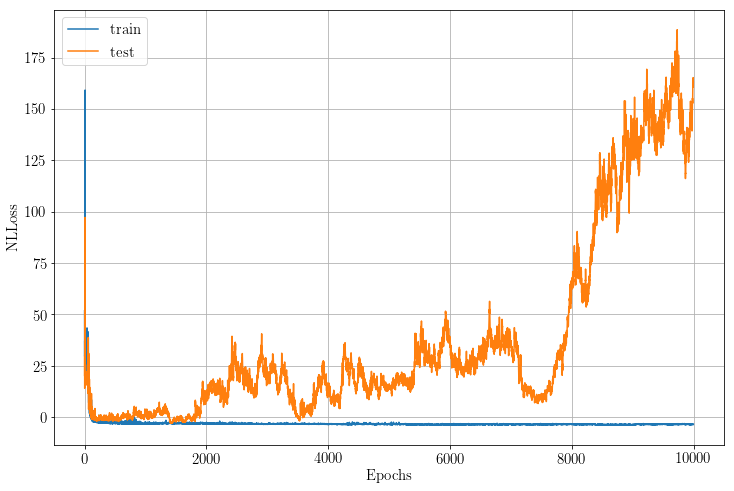

Sampled 101 sets of network parameters from the posterior distribution.


In [415]:
# START TODO ########################
# With NLL loss, the initial losses are really huge compared to the later one
# so plot only from, say, the 10th loss onwards.
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.plot(train_losses[10:], label='train')
plt.plot(test_losses[10:], label='test')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('NLLoss')
plt.grid(True)
plt.show()
# END TODO ########################

print('Sampled', len(bnn.sampled_nets), 'sets of network parameters from the posterior distribution.')

**Question:**
- a) What do you observe regarding the test loss later on? What does this tell you?

**Answer: TODO**
- a) We observe fluctuation in the test loss. This is due to the injected noise and tells us that in unknown regions of the input space the loss will fluctuate for the different sets of sampled parameters. This will give us greater variance for the loss in the unknown regions of input space.

**Task:** Plot uncertainties in the predictions of the BNN below. Use fill_between() from matplotlib to fill in the area around the mean covered by 1, 2 and 3 standard deviations. Vary the alpha (opacity) values of these to get a good visualization of the uncertainties.

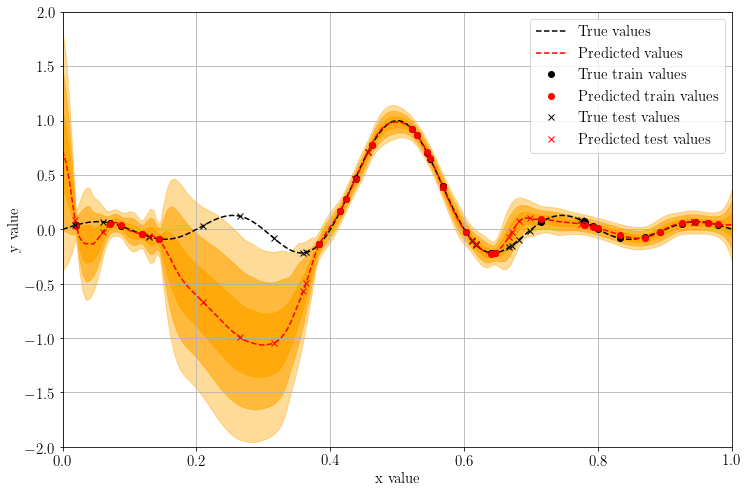

In [416]:
def plot_uncertainty(model):
    xlim = (-0, 1)
    ylim = (-2, 2)
    grid = np.linspace(*xlim, 200)
    # START TODO ########################
    # Use the predict_mean_and_std() function of the BNN to get mean predictions
    # and standard deviations to plot uncertainties. Plotting mean prediction using plot()
    # and fill_between() from matplotlib should be helpful
    fvals = np.sinc(grid * 10 - 5)
    grid_mean, grid_std = model.predict_mean_and_std(torch.from_numpy(grid[:, None]).float())
    grid_mean = np.squeeze(grid_mean[:, 0].detach().numpy())
    grid_std = np.squeeze(grid_std[:, 0].detach().numpy())
    pred_y, pred_y_std = model.predict_mean_and_std(x.float())
    pred_y = np.squeeze(pred_y[:, 0].detach().numpy())
    pred_y_test, pred_y_test_std = model.predict_mean_and_std(x_test.float())
    pred_y_test = np.squeeze(pred_y_test[:, 0].detach().numpy())

    plt.rc('text', usetex=True)
    plt.rc('font', size=15.0, family='serif')
    plt.rcParams['figure.figsize'] = (12.0, 8.0)
    plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]

    plt.plot(grid, fvals, "k--", label='True values')
    plt.plot(grid, grid_mean, "r--", label='Predicted values')
    plt.fill_between(grid, grid_mean + grid_std, grid_mean - grid_std, color="orange", alpha=0.8)
    plt.fill_between(grid, grid_mean + 2 * grid_std, grid_mean - 2 * grid_std, color="orange", alpha=0.6)
    plt.fill_between(grid, grid_mean + 3 * grid_std, grid_mean - 3 * grid_std, color="orange", alpha=0.4)
    plt.plot(x.numpy(), y.numpy(), "ko", label='True train values')
    plt.plot(x.numpy(), pred_y, "ro", label='Predicted train values')
    plt.plot(x_test.numpy(), y_test.numpy(), "kx", label='True test values')
    plt.plot(x_test.numpy(), pred_y_test, "rx", label='Predicted test values')
    plt.grid()
    plt.xlim(*xlim)
    plt.ylim(*ylim)

    # END TODO ########################
    plt.legend(loc='best')
    plt.xlabel('x value')
    plt.ylabel('y value')

    plt.show()

plot_uncertainty(bnn)

**Question:**
- a) What do you observe in the graph?

**Answer: TODO** <br>
The plot shows that the model is more uncertain in regions of input space where there was no training data.

**Task:** Plot the predictions of the individual networks (i.e., the networks with the different sets of parameters from the posterior) of the BNN below. Plot each prediction with a smaller alpha (opacity) so that we can get an idea of the predictions of all the individual networks.

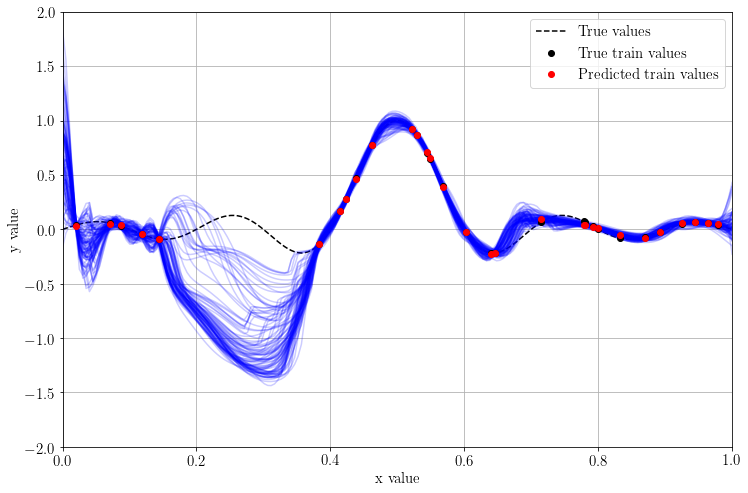

In [417]:
def plot_multiple_predictions(model):
    # START TODO ########################
    # Use the predict_mean_and_std() function of the BNN with return_individual_predictions = True
    # to get individual predictions for each of the sampled set of parameters of the BNN.
    # Plot all of these one by one using plot() with some transparency using its alpha parameter
    # so that you get a good visualization of the individual predictions
    grid_preds = model.predict_mean_and_std(torch.from_numpy(grid[:, None]).float(), 
                                          return_individual_predictions = True).detach().numpy()
    pred_y, pred_y_std = model.predict_mean_and_std(x.float())
    pred_y = np.squeeze(pred_y[:, 0].detach().numpy())

    plt.rc('text', usetex=True)
    plt.rc('font', size=15.0, family='serif')
    plt.rcParams['figure.figsize'] = (12.0, 8.0)
    plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]

    plt.plot(grid, fvals, "k--", label='True values')

    for i in np.arange(grid_preds.shape[2]):
        plt.plot(grid, grid_preds[:, 0, i], "b", alpha=0.2)

    plt.plot(x.numpy(), y.numpy(), "ko", label='True train values')
    plt.plot(x.numpy(), pred_y, "ro", label='Predicted train values')
    plt.grid()
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    # END TODO ########################
    plt.legend(loc='best')
    plt.xlabel('x value')
    plt.ylabel('y value')

    plt.show()
    
plot_multiple_predictions(bnn)

### Your Feedback on Exercise 8.1


## 8.2 Uncertainties using Ensembles

**Task:**
Complete the code for training an ensemble of NNs below.

In [404]:
class EnsembleSequential(nn.Sequential):
    """Holds an ensemble of NNs which are used to get prediction means and uncertainties
    similar to the BNNs above"""
    def __init__(self, *args, num_models=5, ensembled_nets, **kwargs):
        """Init for the class"""
        super(EnsembleSequential, self).__init__(*args, **kwargs)
        self.num_models = num_models
        self.ensembled_nets = ensembled_nets
    
    def predict_mean_and_std(self, x, 
                             return_individual_predictions: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns mean and standard deviation of the predictions of the ensembled networks
        
        In case return_individual_predictions is True, return all the predictions of the ensembled networks, 
        as a Torch tensor
        """
        # START TODO ########################
        # The code here is very similar to the predict_mean_and_std() from the BNNs above.
        preds = []
        for i in np.arange(self.num_models):
            preds.append(self.ensembled_nets[i](x)[..., None])
        preds = torch.cat(preds, dim=-1)
        if return_individual_predictions:
            return preds
        mean = torch.mean(preds, dim=-1)
        std = torch.std(preds, dim=-1)
        # END TODO ########################
        return mean, std

ensembled_nets = []
num_models=5

# The initialization of the weights turns out to be crucial for getting good uncertainty estimates,
# so we do that here.
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=2)
        nn.init.constant_(module.bias, val=0.0)


for i in np.arange(num_models):
    temp_model = nn.Sequential(
      nn.Linear(in_features=1, out_features=50, bias=True),
      nn.Tanh(),
      nn.Linear(in_features=50, out_features=50, bias=True),
      nn.Tanh(),
      nn.Linear(in_features=50, out_features=1, bias=True),
    ).apply(init_weights)
    ensembled_nets.append(temp_model)

ensemble = EnsembleSequential(ensembled_nets=ensembled_nets)

for i in np.arange(num_models):
    criterion = torch.nn.MSELoss()
    epochs=10000
    lr = 1e-2
    optimizer = torch.optim.SGD(ensemble.ensembled_nets[i].parameters(), lr=lr)
    lambda1 = lambda epoch: 1.
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    # START TODO ########################

    print('Training for model', i, 'in the ensemble')
    train_losses, test_losses = evaluate_model(model=ensemble.ensembled_nets[i], optimizer=optimizer, loss_func=criterion,
                    scheduler=scheduler, x_train=x, y_train=y, x_test=x_test,
                       y_test=y_test, epochs=epochs, batch_size=batch_size)
    
    # END TODO ########################

    


Training for model 0 in the ensemble
Training and evaluating model...
  Epoch 1 / 10000 ...
Train loss: 17.66608 Test loss: 16.089167
  Epoch 2 / 10000 ...
Train loss: 2.4621103 Test loss: 2.4752858
  Epoch 3 / 10000 ...
Train loss: 0.7331254 Test loss: 0.89910185
  Epoch 4 / 10000 ...
Train loss: 0.18493307 Test loss: 0.3102988
  Epoch 5 / 10000 ...
Train loss: 0.0946943 Test loss: 0.19447605
  Epoch 6 / 10000 ...
Train loss: 0.07290739 Test loss: 0.15660045
  Epoch 7 / 10000 ...
Train loss: 0.081395596 Test loss: 0.1444138
  Epoch 8 / 10000 ...
Train loss: 0.060692728 Test loss: 0.13843115
  Epoch 9 / 10000 ...
Train loss: 0.055746898 Test loss: 0.12660429
  Epoch 10 / 10000 ...
Train loss: 0.051573258 Test loss: 0.11909111
  Epoch 11 / 10000 ...
Train loss: 0.06748732 Test loss: 0.13678248
  Epoch 12 / 10000 ...
Train loss: 0.04123524 Test loss: 0.094094835
  Epoch 13 / 10000 ...
Train loss: 0.036450453 Test loss: 0.0825723
  Epoch 14 / 10000 ...
Train loss: 0.033429556 Test loss: 0

Train loss: 0.0035768887 Test loss: 0.01575569
  Epoch 132 / 10000 ...
Train loss: 0.0031909838 Test loss: 0.013357541
  Epoch 133 / 10000 ...
Train loss: 0.0028625363 Test loss: 0.012949577
  Epoch 134 / 10000 ...
Train loss: 0.0031432114 Test loss: 0.01340321
  Epoch 135 / 10000 ...
Train loss: 0.0034426237 Test loss: 0.014232377
  Epoch 136 / 10000 ...
Train loss: 0.0029844583 Test loss: 0.013925054
  Epoch 137 / 10000 ...
Train loss: 0.0034122632 Test loss: 0.0136196455
  Epoch 138 / 10000 ...
Train loss: 0.0027793606 Test loss: 0.014222992
  Epoch 139 / 10000 ...
Train loss: 0.0026897811 Test loss: 0.012842472
  Epoch 140 / 10000 ...
Train loss: 0.004673056 Test loss: 0.014444693
  Epoch 141 / 10000 ...
Train loss: 0.004811116 Test loss: 0.015131348
  Epoch 142 / 10000 ...
Train loss: 0.0034918922 Test loss: 0.01418778
  Epoch 143 / 10000 ...
Train loss: 0.0028743981 Test loss: 0.012744537
  Epoch 144 / 10000 ...
Train loss: 0.009283439 Test loss: 0.020100553
  Epoch 145 / 10000 .

Train loss: 0.0038231076 Test loss: 0.011785805
  Epoch 281 / 10000 ...
Train loss: 0.005797089 Test loss: 0.014243847
  Epoch 282 / 10000 ...
Train loss: 0.0021741688 Test loss: 0.011474596
  Epoch 283 / 10000 ...
Train loss: 0.002059969 Test loss: 0.010831608
  Epoch 284 / 10000 ...
Train loss: 0.0043163565 Test loss: 0.012099257
  Epoch 285 / 10000 ...
Train loss: 0.0020343948 Test loss: 0.009734622
  Epoch 286 / 10000 ...
Train loss: 0.0019824419 Test loss: 0.010521394
  Epoch 287 / 10000 ...
Train loss: 0.0037690094 Test loss: 0.011622498
  Epoch 288 / 10000 ...
Train loss: 0.0020254818 Test loss: 0.010884224
  Epoch 289 / 10000 ...
Train loss: 0.0041130423 Test loss: 0.012370515
  Epoch 290 / 10000 ...
Train loss: 0.0023407207 Test loss: 0.010871546
  Epoch 291 / 10000 ...
Train loss: 0.002379465 Test loss: 0.010915406
  Epoch 292 / 10000 ...
Train loss: 0.001983435 Test loss: 0.010026861
  Epoch 293 / 10000 ...
Train loss: 0.0019967307 Test loss: 0.010812122
  Epoch 294 / 10000 

Train loss: 0.002535951 Test loss: 0.010260177
  Epoch 432 / 10000 ...
Train loss: 0.0024732049 Test loss: 0.010423602
  Epoch 433 / 10000 ...
Train loss: 0.002704581 Test loss: 0.010689012
  Epoch 434 / 10000 ...
Train loss: 0.0024132144 Test loss: 0.011146371
  Epoch 435 / 10000 ...
Train loss: 0.001909419 Test loss: 0.009284618
  Epoch 436 / 10000 ...
Train loss: 0.0019931463 Test loss: 0.009644096
  Epoch 437 / 10000 ...
Train loss: 0.0018655594 Test loss: 0.009916422
  Epoch 438 / 10000 ...
Train loss: 0.0017357356 Test loss: 0.009760908
  Epoch 439 / 10000 ...
Train loss: 0.0019391901 Test loss: 0.010133436
  Epoch 440 / 10000 ...
Train loss: 0.002846261 Test loss: 0.011367477
  Epoch 441 / 10000 ...
Train loss: 0.0017763195 Test loss: 0.009842713
  Epoch 442 / 10000 ...
Train loss: 0.0018259948 Test loss: 0.00944156
  Epoch 443 / 10000 ...
Train loss: 0.0019657032 Test loss: 0.010249804
  Epoch 444 / 10000 ...
Train loss: 0.0019614208 Test loss: 0.010359147
  Epoch 445 / 10000 .

Train loss: 0.0017295369 Test loss: 0.010291818
  Epoch 587 / 10000 ...
Train loss: 0.0016353254 Test loss: 0.009847065
  Epoch 588 / 10000 ...
Train loss: 0.0017333295 Test loss: 0.009925149
  Epoch 589 / 10000 ...
Train loss: 0.0016050902 Test loss: 0.009786684
  Epoch 590 / 10000 ...
Train loss: 0.0015778452 Test loss: 0.00942701
  Epoch 591 / 10000 ...
Train loss: 0.0015597432 Test loss: 0.009761654
  Epoch 592 / 10000 ...
Train loss: 0.0015589081 Test loss: 0.009826602
  Epoch 593 / 10000 ...
Train loss: 0.0015713525 Test loss: 0.009487544
  Epoch 594 / 10000 ...
Train loss: 0.0016883145 Test loss: 0.010192375
  Epoch 595 / 10000 ...
Train loss: 0.002623328 Test loss: 0.010781293
  Epoch 596 / 10000 ...
Train loss: 0.0016255017 Test loss: 0.010460387
  Epoch 597 / 10000 ...
Train loss: 0.0019629856 Test loss: 0.011096481
  Epoch 598 / 10000 ...
Train loss: 0.0017120626 Test loss: 0.010767686
  Epoch 599 / 10000 ...
Train loss: 0.0015784429 Test loss: 0.009652241
  Epoch 600 / 1000

Train loss: 0.0019101764 Test loss: 0.010447779
  Epoch 731 / 10000 ...
Train loss: 0.0014672559 Test loss: 0.010581262
  Epoch 732 / 10000 ...
Train loss: 0.0014520332 Test loss: 0.009551195
  Epoch 733 / 10000 ...
Train loss: 0.0014040959 Test loss: 0.010098431
  Epoch 734 / 10000 ...
Train loss: 0.001917697 Test loss: 0.010183946
  Epoch 735 / 10000 ...
Train loss: 0.0016379787 Test loss: 0.010517079
  Epoch 736 / 10000 ...
Train loss: 0.0014906315 Test loss: 0.010399765
  Epoch 737 / 10000 ...
Train loss: 0.0017021811 Test loss: 0.010081552
  Epoch 738 / 10000 ...
Train loss: 0.0018052399 Test loss: 0.01031421
  Epoch 739 / 10000 ...
Train loss: 0.0033341285 Test loss: 0.012151628
  Epoch 740 / 10000 ...
Train loss: 0.001797244 Test loss: 0.010358698
  Epoch 741 / 10000 ...
Train loss: 0.0016777595 Test loss: 0.0101827495
  Epoch 742 / 10000 ...
Train loss: 0.0014532555 Test loss: 0.009745334
  Epoch 743 / 10000 ...
Train loss: 0.0017074537 Test loss: 0.010656235
  Epoch 744 / 1000

Train loss: 0.001688374 Test loss: 0.010052797
  Epoch 879 / 10000 ...
Train loss: 0.0013502808 Test loss: 0.009444241
  Epoch 880 / 10000 ...
Train loss: 0.0014869 Test loss: 0.009979456
  Epoch 881 / 10000 ...
Train loss: 0.0014912811 Test loss: 0.009609743
  Epoch 882 / 10000 ...
Train loss: 0.0013539854 Test loss: 0.010121463
  Epoch 883 / 10000 ...
Train loss: 0.0033237343 Test loss: 0.011971224
  Epoch 884 / 10000 ...
Train loss: 0.0014079227 Test loss: 0.0107240295
  Epoch 885 / 10000 ...
Train loss: 0.0013897131 Test loss: 0.009386306
  Epoch 886 / 10000 ...
Train loss: 0.0012534349 Test loss: 0.009786272
  Epoch 887 / 10000 ...
Train loss: 0.0012761467 Test loss: 0.010135948
  Epoch 888 / 10000 ...
Train loss: 0.0013811062 Test loss: 0.009532291
  Epoch 889 / 10000 ...
Train loss: 0.0016592463 Test loss: 0.0100199
  Epoch 890 / 10000 ...
Train loss: 0.0029894698 Test loss: 0.011404092
  Epoch 891 / 10000 ...
Train loss: 0.0013675375 Test loss: 0.009606799
  Epoch 892 / 10000 .

Train loss: 0.0012396862 Test loss: 0.009803533
  Epoch 1029 / 10000 ...
Train loss: 0.0012142742 Test loss: 0.010592988
  Epoch 1030 / 10000 ...
Train loss: 0.0018276102 Test loss: 0.010323295
  Epoch 1031 / 10000 ...
Train loss: 0.001673092 Test loss: 0.009854361
  Epoch 1032 / 10000 ...
Train loss: 0.0025210707 Test loss: 0.011721204
  Epoch 1033 / 10000 ...
Train loss: 0.0012172693 Test loss: 0.010075373
  Epoch 1034 / 10000 ...
Train loss: 0.0011656507 Test loss: 0.009284237
  Epoch 1035 / 10000 ...
Train loss: 0.0012238504 Test loss: 0.010393822
  Epoch 1036 / 10000 ...
Train loss: 0.0012282601 Test loss: 0.009972957
  Epoch 1037 / 10000 ...
Train loss: 0.0013125471 Test loss: 0.009823572
  Epoch 1038 / 10000 ...
Train loss: 0.0011804297 Test loss: 0.010201303
  Epoch 1039 / 10000 ...
Train loss: 0.002352365 Test loss: 0.011149537
  Epoch 1040 / 10000 ...
Train loss: 0.001392123 Test loss: 0.010667321
  Epoch 1041 / 10000 ...
Train loss: 0.0013072918 Test loss: 0.009851942
  Epoc

Train loss: 0.0012676307 Test loss: 0.009910115
  Epoch 1173 / 10000 ...
Train loss: 0.0011255093 Test loss: 0.008968239
  Epoch 1174 / 10000 ...
Train loss: 0.0017332225 Test loss: 0.011415256
  Epoch 1175 / 10000 ...
Train loss: 0.001117941 Test loss: 0.008912904
  Epoch 1176 / 10000 ...
Train loss: 0.001077663 Test loss: 0.009551738
  Epoch 1177 / 10000 ...
Train loss: 0.0025923867 Test loss: 0.009304874
  Epoch 1178 / 10000 ...
Train loss: 0.0014350372 Test loss: 0.00904952
  Epoch 1179 / 10000 ...
Train loss: 0.0011634933 Test loss: 0.010431888
  Epoch 1180 / 10000 ...
Train loss: 0.0010643847 Test loss: 0.009551868
  Epoch 1181 / 10000 ...
Train loss: 0.0010380407 Test loss: 0.009360472
  Epoch 1182 / 10000 ...
Train loss: 0.0010429472 Test loss: 0.00982165
  Epoch 1183 / 10000 ...
Train loss: 0.001296142 Test loss: 0.010214216
  Epoch 1184 / 10000 ...
Train loss: 0.0012707618 Test loss: 0.0101747895
  Epoch 1185 / 10000 ...
Train loss: 0.001436634 Test loss: 0.009808098
  Epoch 

Train loss: 0.0012430049 Test loss: 0.010081519
  Epoch 1325 / 10000 ...
Train loss: 0.0010037043 Test loss: 0.010219279
  Epoch 1326 / 10000 ...
Train loss: 0.0011046767 Test loss: 0.009829234
  Epoch 1327 / 10000 ...
Train loss: 0.0010780408 Test loss: 0.010253342
  Epoch 1328 / 10000 ...
Train loss: 0.00096277014 Test loss: 0.009592613
  Epoch 1329 / 10000 ...
Train loss: 0.0011061816 Test loss: 0.009897728
  Epoch 1330 / 10000 ...
Train loss: 0.0011300162 Test loss: 0.009800034
  Epoch 1331 / 10000 ...
Train loss: 0.0016528221 Test loss: 0.010104832
  Epoch 1332 / 10000 ...
Train loss: 0.0011821578 Test loss: 0.009062354
  Epoch 1333 / 10000 ...
Train loss: 0.0014485028 Test loss: 0.010236725
  Epoch 1334 / 10000 ...
Train loss: 0.001154378 Test loss: 0.010809441
  Epoch 1335 / 10000 ...
Train loss: 0.0012530601 Test loss: 0.009998544
  Epoch 1336 / 10000 ...
Train loss: 0.0009906971 Test loss: 0.010134398
  Epoch 1337 / 10000 ...
Train loss: 0.0010367164 Test loss: 0.010416468
  E

Train loss: 0.0013860147 Test loss: 0.010472173
  Epoch 1480 / 10000 ...
Train loss: 0.0016540377 Test loss: 0.009520898
  Epoch 1481 / 10000 ...
Train loss: 0.00091897877 Test loss: 0.010043088
  Epoch 1482 / 10000 ...
Train loss: 0.0009888147 Test loss: 0.009076762
  Epoch 1483 / 10000 ...
Train loss: 0.00088604813 Test loss: 0.009649666
  Epoch 1484 / 10000 ...
Train loss: 0.0009244251 Test loss: 0.0092978
  Epoch 1485 / 10000 ...
Train loss: 0.0009108718 Test loss: 0.009663384
  Epoch 1486 / 10000 ...
Train loss: 0.00090203295 Test loss: 0.009197103
  Epoch 1487 / 10000 ...
Train loss: 0.0009422794 Test loss: 0.009113489
  Epoch 1488 / 10000 ...
Train loss: 0.00088749273 Test loss: 0.009757081
  Epoch 1489 / 10000 ...
Train loss: 0.0009860762 Test loss: 0.010014365
  Epoch 1490 / 10000 ...
Train loss: 0.00091033214 Test loss: 0.010074048
  Epoch 1491 / 10000 ...
Train loss: 0.0013136282 Test loss: 0.01034938
  Epoch 1492 / 10000 ...
Train loss: 0.0012790852 Test loss: 0.009570921
 

Train loss: 0.00085607666 Test loss: 0.008744652
  Epoch 1636 / 10000 ...
Train loss: 0.0012213817 Test loss: 0.0089614615
  Epoch 1637 / 10000 ...
Train loss: 0.0016710671 Test loss: 0.01027215
  Epoch 1638 / 10000 ...
Train loss: 0.00090684113 Test loss: 0.009365658
  Epoch 1639 / 10000 ...
Train loss: 0.00091408053 Test loss: 0.009949029
  Epoch 1640 / 10000 ...
Train loss: 0.0016303121 Test loss: 0.009051506
  Epoch 1641 / 10000 ...
Train loss: 0.00084601186 Test loss: 0.009334688
  Epoch 1642 / 10000 ...
Train loss: 0.00117146 Test loss: 0.009197029
  Epoch 1643 / 10000 ...
Train loss: 0.00083644997 Test loss: 0.009251178
  Epoch 1644 / 10000 ...
Train loss: 0.0010600885 Test loss: 0.010155251
  Epoch 1645 / 10000 ...
Train loss: 0.0008421101 Test loss: 0.009249441
  Epoch 1646 / 10000 ...
Train loss: 0.0010246171 Test loss: 0.009004271
  Epoch 1647 / 10000 ...
Train loss: 0.0011007775 Test loss: 0.009957794
  Epoch 1648 / 10000 ...
Train loss: 0.0008830752 Test loss: 0.008904628


Train loss: 0.000975773 Test loss: 0.009743584
  Epoch 1789 / 10000 ...
Train loss: 0.0011478884 Test loss: 0.0091144
  Epoch 1790 / 10000 ...
Train loss: 0.002732389 Test loss: 0.011922966
  Epoch 1791 / 10000 ...
Train loss: 0.00093683094 Test loss: 0.008645465
  Epoch 1792 / 10000 ...
Train loss: 0.00080922124 Test loss: 0.009033334
  Epoch 1793 / 10000 ...
Train loss: 0.0008407906 Test loss: 0.009415315
  Epoch 1794 / 10000 ...
Train loss: 0.0015257208 Test loss: 0.009905365
  Epoch 1795 / 10000 ...
Train loss: 0.0016074002 Test loss: 0.009747754
  Epoch 1796 / 10000 ...
Train loss: 0.0022350436 Test loss: 0.011821118
  Epoch 1797 / 10000 ...
Train loss: 0.001341969 Test loss: 0.0079824
  Epoch 1798 / 10000 ...
Train loss: 0.00090129 Test loss: 0.009639085
  Epoch 1799 / 10000 ...
Train loss: 0.0013193993 Test loss: 0.008464805
  Epoch 1800 / 10000 ...
Train loss: 0.00087240146 Test loss: 0.009340659
  Epoch 1801 / 10000 ...
Train loss: 0.00082656636 Test loss: 0.008808397
  Epoch 

Train loss: 0.00085355603 Test loss: 0.009745786
  Epoch 1950 / 10000 ...
Train loss: 0.0010568866 Test loss: 0.010100539
  Epoch 1951 / 10000 ...
Train loss: 0.0009029559 Test loss: 0.008103136
  Epoch 1952 / 10000 ...
Train loss: 0.0010900924 Test loss: 0.00998898
  Epoch 1953 / 10000 ...
Train loss: 0.0009518371 Test loss: 0.00963795
  Epoch 1954 / 10000 ...
Train loss: 0.0011383023 Test loss: 0.009843688
  Epoch 1955 / 10000 ...
Train loss: 0.0008522817 Test loss: 0.009843487
  Epoch 1956 / 10000 ...
Train loss: 0.0019289932 Test loss: 0.011529663
  Epoch 1957 / 10000 ...
Train loss: 0.00093081495 Test loss: 0.008880568
  Epoch 1958 / 10000 ...
Train loss: 0.0008914964 Test loss: 0.009868433
  Epoch 1959 / 10000 ...
Train loss: 0.00086037646 Test loss: 0.00858708
  Epoch 1960 / 10000 ...
Train loss: 0.00084733276 Test loss: 0.0096524125
  Epoch 1961 / 10000 ...
Train loss: 0.00080947235 Test loss: 0.008690979
  Epoch 1962 / 10000 ...
Train loss: 0.0014920176 Test loss: 0.0110584935

Train loss: 0.0007748261 Test loss: 0.008512176
  Epoch 2107 / 10000 ...
Train loss: 0.00081724307 Test loss: 0.008694267
  Epoch 2108 / 10000 ...
Train loss: 0.00080469024 Test loss: 0.008465282
  Epoch 2109 / 10000 ...
Train loss: 0.0007741799 Test loss: 0.008935417
  Epoch 2110 / 10000 ...
Train loss: 0.00096770684 Test loss: 0.008905958
  Epoch 2111 / 10000 ...
Train loss: 0.0007807865 Test loss: 0.008962634
  Epoch 2112 / 10000 ...
Train loss: 0.00079396955 Test loss: 0.009334458
  Epoch 2113 / 10000 ...
Train loss: 0.0010032628 Test loss: 0.009598112
  Epoch 2114 / 10000 ...
Train loss: 0.0008051099 Test loss: 0.009071157
  Epoch 2115 / 10000 ...
Train loss: 0.0018037898 Test loss: 0.008858637
  Epoch 2116 / 10000 ...
Train loss: 0.00077639555 Test loss: 0.008795333
  Epoch 2117 / 10000 ...
Train loss: 0.0009172121 Test loss: 0.009100789
  Epoch 2118 / 10000 ...
Train loss: 0.0013228595 Test loss: 0.009591016
  Epoch 2119 / 10000 ...
Train loss: 0.0008303636 Test loss: 0.00940764

Train loss: 0.0008379385 Test loss: 0.009006912
  Epoch 2260 / 10000 ...
Train loss: 0.0008163445 Test loss: 0.0087362155
  Epoch 2261 / 10000 ...
Train loss: 0.00077490375 Test loss: 0.00888642
  Epoch 2262 / 10000 ...
Train loss: 0.0007856409 Test loss: 0.008240935
  Epoch 2263 / 10000 ...
Train loss: 0.0010670044 Test loss: 0.009019768
  Epoch 2264 / 10000 ...
Train loss: 0.0008338894 Test loss: 0.009343842
  Epoch 2265 / 10000 ...
Train loss: 0.001205122 Test loss: 0.008386772
  Epoch 2266 / 10000 ...
Train loss: 0.00081825274 Test loss: 0.009144538
  Epoch 2267 / 10000 ...
Train loss: 0.0008294942 Test loss: 0.008786039
  Epoch 2268 / 10000 ...
Train loss: 0.00077140244 Test loss: 0.008446635
  Epoch 2269 / 10000 ...
Train loss: 0.00079009973 Test loss: 0.008768434
  Epoch 2270 / 10000 ...
Train loss: 0.000901793 Test loss: 0.00899011
  Epoch 2271 / 10000 ...
Train loss: 0.00087079796 Test loss: 0.009320013
  Epoch 2272 / 10000 ...
Train loss: 0.001521679 Test loss: 0.009031897
  

Train loss: 0.0009871705 Test loss: 0.007557105
  Epoch 2399 / 10000 ...
Train loss: 0.0007742792 Test loss: 0.00832975
  Epoch 2400 / 10000 ...
Train loss: 0.000762503 Test loss: 0.00861976
  Epoch 2401 / 10000 ...
Train loss: 0.00082680327 Test loss: 0.008590864
  Epoch 2402 / 10000 ...
Train loss: 0.000853871 Test loss: 0.0077445
  Epoch 2403 / 10000 ...
Train loss: 0.0007653571 Test loss: 0.008414802
  Epoch 2404 / 10000 ...
Train loss: 0.0015832945 Test loss: 0.009791661
  Epoch 2405 / 10000 ...
Train loss: 0.00089847797 Test loss: 0.009133851
  Epoch 2406 / 10000 ...
Train loss: 0.0008321645 Test loss: 0.007845234
  Epoch 2407 / 10000 ...
Train loss: 0.000773821 Test loss: 0.0078522
  Epoch 2408 / 10000 ...
Train loss: 0.00080221525 Test loss: 0.007990615
  Epoch 2409 / 10000 ...
Train loss: 0.0007687974 Test loss: 0.008754197
  Epoch 2410 / 10000 ...
Train loss: 0.00077714736 Test loss: 0.008050467
  Epoch 2411 / 10000 ...
Train loss: 0.0015857618 Test loss: 0.008591552
  Epoch 

Train loss: 0.0013241436 Test loss: 0.009649999
  Epoch 2547 / 10000 ...
Train loss: 0.000844311 Test loss: 0.008287418
  Epoch 2548 / 10000 ...
Train loss: 0.0007425727 Test loss: 0.008022885
  Epoch 2549 / 10000 ...
Train loss: 0.0007403401 Test loss: 0.008339115
  Epoch 2550 / 10000 ...
Train loss: 0.00075763033 Test loss: 0.008347733
  Epoch 2551 / 10000 ...
Train loss: 0.0008518452 Test loss: 0.008922194
  Epoch 2552 / 10000 ...
Train loss: 0.0014485962 Test loss: 0.009551629
  Epoch 2553 / 10000 ...
Train loss: 0.00096678257 Test loss: 0.00895964
  Epoch 2554 / 10000 ...
Train loss: 0.0009040678 Test loss: 0.008937255
  Epoch 2555 / 10000 ...
Train loss: 0.00074748736 Test loss: 0.008035995
  Epoch 2556 / 10000 ...
Train loss: 0.00090773887 Test loss: 0.00814841
  Epoch 2557 / 10000 ...
Train loss: 0.0011706513 Test loss: 0.009019575
  Epoch 2558 / 10000 ...
Train loss: 0.0008963812 Test loss: 0.0085122455
  Epoch 2559 / 10000 ...
Train loss: 0.0009350038 Test loss: 0.007894
  Ep

Train loss: 0.0012514499 Test loss: 0.00759956
  Epoch 2701 / 10000 ...
Train loss: 0.0010044146 Test loss: 0.008724732
  Epoch 2702 / 10000 ...
Train loss: 0.000728135 Test loss: 0.007830124
  Epoch 2703 / 10000 ...
Train loss: 0.00085685804 Test loss: 0.008702966
  Epoch 2704 / 10000 ...
Train loss: 0.0008008015 Test loss: 0.007573877
  Epoch 2705 / 10000 ...
Train loss: 0.00090734044 Test loss: 0.0074325083
  Epoch 2706 / 10000 ...
Train loss: 0.0007560181 Test loss: 0.0075101852
  Epoch 2707 / 10000 ...
Train loss: 0.00081746833 Test loss: 0.0072846925
  Epoch 2708 / 10000 ...
Train loss: 0.0007674508 Test loss: 0.008559073
  Epoch 2709 / 10000 ...
Train loss: 0.000777432 Test loss: 0.007993881
  Epoch 2710 / 10000 ...
Train loss: 0.000862496 Test loss: 0.0074243415
  Epoch 2711 / 10000 ...
Train loss: 0.0015865993 Test loss: 0.0076726805
  Epoch 2712 / 10000 ...
Train loss: 0.0008395204 Test loss: 0.008627628
  Epoch 2713 / 10000 ...
Train loss: 0.00077564915 Test loss: 0.00847760

Train loss: 0.0007224813 Test loss: 0.007535782
  Epoch 2858 / 10000 ...
Train loss: 0.0007479622 Test loss: 0.007697724
  Epoch 2859 / 10000 ...
Train loss: 0.0007718908 Test loss: 0.008193069
  Epoch 2860 / 10000 ...
Train loss: 0.00074892276 Test loss: 0.0076606283
  Epoch 2861 / 10000 ...
Train loss: 0.00072478456 Test loss: 0.008043185
  Epoch 2862 / 10000 ...
Train loss: 0.00071027945 Test loss: 0.007806845
  Epoch 2863 / 10000 ...
Train loss: 0.0007648145 Test loss: 0.007436314
  Epoch 2864 / 10000 ...
Train loss: 0.0007486444 Test loss: 0.007741308
  Epoch 2865 / 10000 ...
Train loss: 0.0008469127 Test loss: 0.008331234
  Epoch 2866 / 10000 ...
Train loss: 0.0010023145 Test loss: 0.0074299276
  Epoch 2867 / 10000 ...
Train loss: 0.00096299767 Test loss: 0.008046147
  Epoch 2868 / 10000 ...
Train loss: 0.0008458058 Test loss: 0.008063413
  Epoch 2869 / 10000 ...
Train loss: 0.0008068826 Test loss: 0.0074719703
  Epoch 2870 / 10000 ...
Train loss: 0.00087596534 Test loss: 0.00774

Train loss: 0.00071705785 Test loss: 0.0070907823
  Epoch 3011 / 10000 ...
Train loss: 0.00071577955 Test loss: 0.0074019893
  Epoch 3012 / 10000 ...
Train loss: 0.0012480011 Test loss: 0.007853118
  Epoch 3013 / 10000 ...
Train loss: 0.00090659095 Test loss: 0.0072671906
  Epoch 3014 / 10000 ...
Train loss: 0.000872696 Test loss: 0.006750829
  Epoch 3015 / 10000 ...
Train loss: 0.0008036464 Test loss: 0.007646807
  Epoch 3016 / 10000 ...
Train loss: 0.00070685096 Test loss: 0.0074304664
  Epoch 3017 / 10000 ...
Train loss: 0.00088166085 Test loss: 0.008273174
  Epoch 3018 / 10000 ...
Train loss: 0.000748134 Test loss: 0.0076223123
  Epoch 3019 / 10000 ...
Train loss: 0.0008747053 Test loss: 0.00825826
  Epoch 3020 / 10000 ...
Train loss: 0.001373306 Test loss: 0.007081036
  Epoch 3021 / 10000 ...
Train loss: 0.0011762985 Test loss: 0.0077671534
  Epoch 3022 / 10000 ...
Train loss: 0.0007732194 Test loss: 0.007816253
  Epoch 3023 / 10000 ...
Train loss: 0.00070461043 Test loss: 0.00753

Train loss: 0.00071970694 Test loss: 0.007745435
  Epoch 3160 / 10000 ...
Train loss: 0.0009815758 Test loss: 0.008338537
  Epoch 3161 / 10000 ...
Train loss: 0.0010657576 Test loss: 0.007050184
  Epoch 3162 / 10000 ...
Train loss: 0.0012309409 Test loss: 0.007799936
  Epoch 3163 / 10000 ...
Train loss: 0.00072762877 Test loss: 0.007236538
  Epoch 3164 / 10000 ...
Train loss: 0.0011196479 Test loss: 0.007953835
  Epoch 3165 / 10000 ...
Train loss: 0.0007995607 Test loss: 0.0076438095
  Epoch 3166 / 10000 ...
Train loss: 0.0008333209 Test loss: 0.0074570505
  Epoch 3167 / 10000 ...
Train loss: 0.0011640184 Test loss: 0.0070774793
  Epoch 3168 / 10000 ...
Train loss: 0.0007394713 Test loss: 0.0070133377
  Epoch 3169 / 10000 ...
Train loss: 0.00072174374 Test loss: 0.0071238815
  Epoch 3170 / 10000 ...
Train loss: 0.00072084635 Test loss: 0.0074208025
  Epoch 3171 / 10000 ...
Train loss: 0.0010210999 Test loss: 0.0078171
  Epoch 3172 / 10000 ...
Train loss: 0.00071111677 Test loss: 0.0073

Train loss: 0.00073050644 Test loss: 0.0076122717
  Epoch 3315 / 10000 ...
Train loss: 0.00079829 Test loss: 0.0068524634
  Epoch 3316 / 10000 ...
Train loss: 0.000715104 Test loss: 0.006641576
  Epoch 3317 / 10000 ...
Train loss: 0.00077577954 Test loss: 0.0063318326
  Epoch 3318 / 10000 ...
Train loss: 0.00075186207 Test loss: 0.007376846
  Epoch 3319 / 10000 ...
Train loss: 0.0009808129 Test loss: 0.0068941517
  Epoch 3320 / 10000 ...
Train loss: 0.0009825547 Test loss: 0.007958653
  Epoch 3321 / 10000 ...
Train loss: 0.0008686014 Test loss: 0.007416818
  Epoch 3322 / 10000 ...
Train loss: 0.0009936999 Test loss: 0.0068784514
  Epoch 3323 / 10000 ...
Train loss: 0.00072357105 Test loss: 0.007354529
  Epoch 3324 / 10000 ...
Train loss: 0.0007308128 Test loss: 0.0069567384
  Epoch 3325 / 10000 ...
Train loss: 0.000687386 Test loss: 0.0070837256
  Epoch 3326 / 10000 ...
Train loss: 0.0008906216 Test loss: 0.0064256443
  Epoch 3327 / 10000 ...
Train loss: 0.0007876181 Test loss: 0.00779

Train loss: 0.00071934913 Test loss: 0.0065950337
  Epoch 3466 / 10000 ...
Train loss: 0.00071394874 Test loss: 0.00718004
  Epoch 3467 / 10000 ...
Train loss: 0.0008389022 Test loss: 0.0069921594
  Epoch 3468 / 10000 ...
Train loss: 0.00088924466 Test loss: 0.0077946414
  Epoch 3469 / 10000 ...
Train loss: 0.0006942903 Test loss: 0.0065874592
  Epoch 3470 / 10000 ...
Train loss: 0.00089151156 Test loss: 0.0072614597
  Epoch 3471 / 10000 ...
Train loss: 0.00074248534 Test loss: 0.0065077776
  Epoch 3472 / 10000 ...
Train loss: 0.00071895984 Test loss: 0.007149224
  Epoch 3473 / 10000 ...
Train loss: 0.0010155233 Test loss: 0.007082514
  Epoch 3474 / 10000 ...
Train loss: 0.0010155942 Test loss: 0.0069692824
  Epoch 3475 / 10000 ...
Train loss: 0.0007009634 Test loss: 0.0069536874
  Epoch 3476 / 10000 ...
Train loss: 0.0011916348 Test loss: 0.008183075
  Epoch 3477 / 10000 ...
Train loss: 0.0012125201 Test loss: 0.006963016
  Epoch 3478 / 10000 ...
Train loss: 0.000909733 Test loss: 0.0

Train loss: 0.0007298622 Test loss: 0.0066872304
  Epoch 3614 / 10000 ...
Train loss: 0.0007023868 Test loss: 0.0068391473
  Epoch 3615 / 10000 ...
Train loss: 0.0008709678 Test loss: 0.0070859864
  Epoch 3616 / 10000 ...
Train loss: 0.0008291003 Test loss: 0.006812309
  Epoch 3617 / 10000 ...
Train loss: 0.00069135823 Test loss: 0.0066932207
  Epoch 3618 / 10000 ...
Train loss: 0.0012741457 Test loss: 0.007418533
  Epoch 3619 / 10000 ...
Train loss: 0.0006849635 Test loss: 0.0064960653
  Epoch 3620 / 10000 ...
Train loss: 0.000776783 Test loss: 0.0066512357
  Epoch 3621 / 10000 ...
Train loss: 0.00066696695 Test loss: 0.006665682
  Epoch 3622 / 10000 ...
Train loss: 0.0015866607 Test loss: 0.0076923254
  Epoch 3623 / 10000 ...
Train loss: 0.0007215033 Test loss: 0.0070519443
  Epoch 3624 / 10000 ...
Train loss: 0.00080135034 Test loss: 0.006420858
  Epoch 3625 / 10000 ...
Train loss: 0.0006648976 Test loss: 0.0067642005
  Epoch 3626 / 10000 ...
Train loss: 0.00070746586 Test loss: 0.0

Train loss: 0.0009838473 Test loss: 0.0069679925
  Epoch 3762 / 10000 ...
Train loss: 0.0007619767 Test loss: 0.005974587
  Epoch 3763 / 10000 ...
Train loss: 0.0007313303 Test loss: 0.0065735267
  Epoch 3764 / 10000 ...
Train loss: 0.000759839 Test loss: 0.005890627
  Epoch 3765 / 10000 ...
Train loss: 0.00068156596 Test loss: 0.0069713355
  Epoch 3766 / 10000 ...
Train loss: 0.0006847761 Test loss: 0.006390178
  Epoch 3767 / 10000 ...
Train loss: 0.0007538212 Test loss: 0.0066402345
  Epoch 3768 / 10000 ...
Train loss: 0.0007283606 Test loss: 0.0066087646
  Epoch 3769 / 10000 ...
Train loss: 0.00069854304 Test loss: 0.006643009
  Epoch 3770 / 10000 ...
Train loss: 0.00095870736 Test loss: 0.006629078
  Epoch 3771 / 10000 ...
Train loss: 0.0007572931 Test loss: 0.0061987224
  Epoch 3772 / 10000 ...
Train loss: 0.0007272188 Test loss: 0.0065703476
  Epoch 3773 / 10000 ...
Train loss: 0.0007709615 Test loss: 0.00615873
  Epoch 3774 / 10000 ...
Train loss: 0.0006648858 Test loss: 0.00679

Train loss: 0.00074570643 Test loss: 0.006226839
  Epoch 3911 / 10000 ...
Train loss: 0.0006919623 Test loss: 0.0067196623
  Epoch 3912 / 10000 ...
Train loss: 0.00074554497 Test loss: 0.0056177117
  Epoch 3913 / 10000 ...
Train loss: 0.0008843979 Test loss: 0.006337705
  Epoch 3914 / 10000 ...
Train loss: 0.0009206845 Test loss: 0.007013956
  Epoch 3915 / 10000 ...
Train loss: 0.00065138796 Test loss: 0.006258725
  Epoch 3916 / 10000 ...
Train loss: 0.00080833386 Test loss: 0.007080072
  Epoch 3917 / 10000 ...
Train loss: 0.0006690654 Test loss: 0.0066514113
  Epoch 3918 / 10000 ...
Train loss: 0.00065877783 Test loss: 0.0063116234
  Epoch 3919 / 10000 ...
Train loss: 0.00066299806 Test loss: 0.006067954
  Epoch 3920 / 10000 ...
Train loss: 0.0008703258 Test loss: 0.0065471064
  Epoch 3921 / 10000 ...
Train loss: 0.0007609091 Test loss: 0.0062889867
  Epoch 3922 / 10000 ...
Train loss: 0.00084654574 Test loss: 0.006377145
  Epoch 3923 / 10000 ...
Train loss: 0.00093596743 Test loss: 0

Train loss: 0.00068571937 Test loss: 0.0064100423
  Epoch 4059 / 10000 ...
Train loss: 0.0006756326 Test loss: 0.005994514
  Epoch 4060 / 10000 ...
Train loss: 0.0007465938 Test loss: 0.006441976
  Epoch 4061 / 10000 ...
Train loss: 0.0009488196 Test loss: 0.0064108395
  Epoch 4062 / 10000 ...
Train loss: 0.0010142466 Test loss: 0.0069047096
  Epoch 4063 / 10000 ...
Train loss: 0.0008358015 Test loss: 0.0065198573
  Epoch 4064 / 10000 ...
Train loss: 0.0007101759 Test loss: 0.005819533
  Epoch 4065 / 10000 ...
Train loss: 0.0006818922 Test loss: 0.00622296
  Epoch 4066 / 10000 ...
Train loss: 0.000860633 Test loss: 0.0065485057
  Epoch 4067 / 10000 ...
Train loss: 0.0007440096 Test loss: 0.0060131904
  Epoch 4068 / 10000 ...
Train loss: 0.0012764529 Test loss: 0.0073336842
  Epoch 4069 / 10000 ...
Train loss: 0.00072098454 Test loss: 0.0063467654
  Epoch 4070 / 10000 ...
Train loss: 0.0007429375 Test loss: 0.00647133
  Epoch 4071 / 10000 ...
Train loss: 0.0009406809 Test loss: 0.006191

Train loss: 0.00063899235 Test loss: 0.005965099
  Epoch 4207 / 10000 ...
Train loss: 0.0015039907 Test loss: 0.006170121
  Epoch 4208 / 10000 ...
Train loss: 0.0007460401 Test loss: 0.0066885757
  Epoch 4209 / 10000 ...
Train loss: 0.0006602054 Test loss: 0.006034092
  Epoch 4210 / 10000 ...
Train loss: 0.0008767036 Test loss: 0.0067562955
  Epoch 4211 / 10000 ...
Train loss: 0.0008186086 Test loss: 0.006186966
  Epoch 4212 / 10000 ...
Train loss: 0.000747367 Test loss: 0.0063089835
  Epoch 4213 / 10000 ...
Train loss: 0.0007104776 Test loss: 0.0062081493
  Epoch 4214 / 10000 ...
Train loss: 0.0007515407 Test loss: 0.0063570687
  Epoch 4215 / 10000 ...
Train loss: 0.0009125396 Test loss: 0.006678025
  Epoch 4216 / 10000 ...
Train loss: 0.00069596345 Test loss: 0.0057738735
  Epoch 4217 / 10000 ...
Train loss: 0.00080337777 Test loss: 0.006563488
  Epoch 4218 / 10000 ...
Train loss: 0.00065814285 Test loss: 0.0060423864
  Epoch 4219 / 10000 ...
Train loss: 0.0008471772 Test loss: 0.006

Train loss: 0.0010946385 Test loss: 0.00632234
  Epoch 4355 / 10000 ...
Train loss: 0.0012877532 Test loss: 0.0066513848
  Epoch 4356 / 10000 ...
Train loss: 0.0013386161 Test loss: 0.007385404
  Epoch 4357 / 10000 ...
Train loss: 0.0007114482 Test loss: 0.0058356347
  Epoch 4358 / 10000 ...
Train loss: 0.000652886 Test loss: 0.0057562743
  Epoch 4359 / 10000 ...
Train loss: 0.0014546657 Test loss: 0.0061467234
  Epoch 4360 / 10000 ...
Train loss: 0.0007752611 Test loss: 0.006367644
  Epoch 4361 / 10000 ...
Train loss: 0.0007598922 Test loss: 0.0056953267
  Epoch 4362 / 10000 ...
Train loss: 0.00065503997 Test loss: 0.0063208886
  Epoch 4363 / 10000 ...
Train loss: 0.00094273407 Test loss: 0.006096377
  Epoch 4364 / 10000 ...
Train loss: 0.0007371441 Test loss: 0.0063541154
  Epoch 4365 / 10000 ...
Train loss: 0.00071884634 Test loss: 0.005675734
  Epoch 4366 / 10000 ...
Train loss: 0.00068432227 Test loss: 0.0060629155
  Epoch 4367 / 10000 ...
Train loss: 0.0008586745 Test loss: 0.005

Train loss: 0.00063140626 Test loss: 0.005766247
  Epoch 4506 / 10000 ...
Train loss: 0.0006377521 Test loss: 0.00546441
  Epoch 4507 / 10000 ...
Train loss: 0.0016090994 Test loss: 0.0061601223
  Epoch 4508 / 10000 ...
Train loss: 0.0008171927 Test loss: 0.0061463844
  Epoch 4509 / 10000 ...
Train loss: 0.0006449741 Test loss: 0.0057392637
  Epoch 4510 / 10000 ...
Train loss: 0.0012607924 Test loss: 0.006646031
  Epoch 4511 / 10000 ...
Train loss: 0.0006733103 Test loss: 0.005669872
  Epoch 4512 / 10000 ...
Train loss: 0.0006410809 Test loss: 0.005592122
  Epoch 4513 / 10000 ...
Train loss: 0.000892291 Test loss: 0.005172468
  Epoch 4514 / 10000 ...
Train loss: 0.00064680976 Test loss: 0.0062026256
  Epoch 4515 / 10000 ...
Train loss: 0.0011088733 Test loss: 0.0059873243
  Epoch 4516 / 10000 ...
Train loss: 0.00062925846 Test loss: 0.0059503643
  Epoch 4517 / 10000 ...
Train loss: 0.000703669 Test loss: 0.0062661837
  Epoch 4518 / 10000 ...
Train loss: 0.0006632942 Test loss: 0.005431

Train loss: 0.00065947603 Test loss: 0.005243226
  Epoch 4633 / 10000 ...
Train loss: 0.0006410017 Test loss: 0.0056997216
  Epoch 4634 / 10000 ...
Train loss: 0.00079886214 Test loss: 0.006257335
  Epoch 4635 / 10000 ...
Train loss: 0.0006608865 Test loss: 0.00607768
  Epoch 4636 / 10000 ...
Train loss: 0.0009388613 Test loss: 0.00587243
  Epoch 4637 / 10000 ...
Train loss: 0.0006237789 Test loss: 0.005444652
  Epoch 4638 / 10000 ...
Train loss: 0.00061428157 Test loss: 0.0055612745
  Epoch 4639 / 10000 ...
Train loss: 0.00061154936 Test loss: 0.0056481888
  Epoch 4640 / 10000 ...
Train loss: 0.0007145455 Test loss: 0.0060955044
  Epoch 4641 / 10000 ...
Train loss: 0.0006995958 Test loss: 0.0057570077
  Epoch 4642 / 10000 ...
Train loss: 0.00061584136 Test loss: 0.0054594935
  Epoch 4643 / 10000 ...
Train loss: 0.00080045 Test loss: 0.005950707
  Epoch 4644 / 10000 ...
Train loss: 0.000756702 Test loss: 0.0056090793
  Epoch 4645 / 10000 ...
Train loss: 0.0009865884 Test loss: 0.006830

Train loss: 0.0006358137 Test loss: 0.0052275164
  Epoch 4744 / 10000 ...
Train loss: 0.0007188056 Test loss: 0.005793736
  Epoch 4745 / 10000 ...
Train loss: 0.0006088389 Test loss: 0.0054886774
  Epoch 4746 / 10000 ...
Train loss: 0.0006427524 Test loss: 0.0055136457
  Epoch 4747 / 10000 ...
Train loss: 0.0006119552 Test loss: 0.0055240165
  Epoch 4748 / 10000 ...
Train loss: 0.0006184412 Test loss: 0.0056037656
  Epoch 4749 / 10000 ...
Train loss: 0.0006981404 Test loss: 0.00577602
  Epoch 4750 / 10000 ...
Train loss: 0.0006361956 Test loss: 0.0054374416
  Epoch 4751 / 10000 ...
Train loss: 0.0007297539 Test loss: 0.006244714
  Epoch 4752 / 10000 ...
Train loss: 0.0006520624 Test loss: 0.0053067775
  Epoch 4753 / 10000 ...
Train loss: 0.0006134665 Test loss: 0.0058056884
  Epoch 4754 / 10000 ...
Train loss: 0.0006235952 Test loss: 0.005861857
  Epoch 4755 / 10000 ...
Train loss: 0.00063830893 Test loss: 0.0055062263
  Epoch 4756 / 10000 ...
Train loss: 0.0006890184 Test loss: 0.0056

Train loss: 0.0014203112 Test loss: 0.005526888
  Epoch 4896 / 10000 ...
Train loss: 0.0007035779 Test loss: 0.0050828476
  Epoch 4897 / 10000 ...
Train loss: 0.00065470213 Test loss: 0.0052554314
  Epoch 4898 / 10000 ...
Train loss: 0.0006523225 Test loss: 0.0057886946
  Epoch 4899 / 10000 ...
Train loss: 0.00080669665 Test loss: 0.0063093556
  Epoch 4900 / 10000 ...
Train loss: 0.0006111133 Test loss: 0.0052266917
  Epoch 4901 / 10000 ...
Train loss: 0.0009609571 Test loss: 0.0065492634
  Epoch 4902 / 10000 ...
Train loss: 0.00072660204 Test loss: 0.0058030477
  Epoch 4903 / 10000 ...
Train loss: 0.00062434695 Test loss: 0.005529153
  Epoch 4904 / 10000 ...
Train loss: 0.0010329819 Test loss: 0.005496149
  Epoch 4905 / 10000 ...
Train loss: 0.00068723725 Test loss: 0.005841548
  Epoch 4906 / 10000 ...
Train loss: 0.0006266523 Test loss: 0.005125607
  Epoch 4907 / 10000 ...
Train loss: 0.00072855543 Test loss: 0.005367564
  Epoch 4908 / 10000 ...
Train loss: 0.0007112245 Test loss: 0.

Train loss: 0.00071941956 Test loss: 0.005908688
  Epoch 5039 / 10000 ...
Train loss: 0.00059956935 Test loss: 0.005158899
  Epoch 5040 / 10000 ...
Train loss: 0.0006654677 Test loss: 0.005690575
  Epoch 5041 / 10000 ...
Train loss: 0.000865548 Test loss: 0.005249974
  Epoch 5042 / 10000 ...
Train loss: 0.0021959753 Test loss: 0.0061070793
  Epoch 5043 / 10000 ...
Train loss: 0.00063472294 Test loss: 0.0057766307
  Epoch 5044 / 10000 ...
Train loss: 0.0006992409 Test loss: 0.0052728876
  Epoch 5045 / 10000 ...
Train loss: 0.0007141272 Test loss: 0.0059308107
  Epoch 5046 / 10000 ...
Train loss: 0.00059802545 Test loss: 0.0052622706
  Epoch 5047 / 10000 ...
Train loss: 0.0006671933 Test loss: 0.005123463
  Epoch 5048 / 10000 ...
Train loss: 0.0010012408 Test loss: 0.0055943215
  Epoch 5049 / 10000 ...
Train loss: 0.0006259283 Test loss: 0.005513035
  Epoch 5050 / 10000 ...
Train loss: 0.00072536274 Test loss: 0.005713594
  Epoch 5051 / 10000 ...
Train loss: 0.0007162622 Test loss: 0.005

Train loss: 0.0005882724 Test loss: 0.0051159025
  Epoch 5190 / 10000 ...
Train loss: 0.0010271026 Test loss: 0.0057053184
  Epoch 5191 / 10000 ...
Train loss: 0.0006625487 Test loss: 0.005204875
  Epoch 5192 / 10000 ...
Train loss: 0.00067301834 Test loss: 0.004621417
  Epoch 5193 / 10000 ...
Train loss: 0.0005898363 Test loss: 0.0052454052
  Epoch 5194 / 10000 ...
Train loss: 0.0006100527 Test loss: 0.0048460984
  Epoch 5195 / 10000 ...
Train loss: 0.00063855405 Test loss: 0.0056315414
  Epoch 5196 / 10000 ...
Train loss: 0.00091042946 Test loss: 0.0050170394
  Epoch 5197 / 10000 ...
Train loss: 0.00073024695 Test loss: 0.0049973624
  Epoch 5198 / 10000 ...
Train loss: 0.0006454757 Test loss: 0.0054476485
  Epoch 5199 / 10000 ...
Train loss: 0.00094987574 Test loss: 0.0056230687
  Epoch 5200 / 10000 ...
Train loss: 0.00061835203 Test loss: 0.0053543095
  Epoch 5201 / 10000 ...
Train loss: 0.0008413335 Test loss: 0.0052166083
  Epoch 5202 / 10000 ...
Train loss: 0.00077579526 Test los

Train loss: 0.00062602956 Test loss: 0.004418098
  Epoch 5341 / 10000 ...
Train loss: 0.0006053355 Test loss: 0.005189736
  Epoch 5342 / 10000 ...
Train loss: 0.0006768474 Test loss: 0.0052177887
  Epoch 5343 / 10000 ...
Train loss: 0.00067127583 Test loss: 0.004742273
  Epoch 5344 / 10000 ...
Train loss: 0.000656352 Test loss: 0.0049337624
  Epoch 5345 / 10000 ...
Train loss: 0.0006319994 Test loss: 0.0051436382
  Epoch 5346 / 10000 ...
Train loss: 0.0006353989 Test loss: 0.004890187
  Epoch 5347 / 10000 ...
Train loss: 0.00058739586 Test loss: 0.0048595057
  Epoch 5348 / 10000 ...
Train loss: 0.000750139 Test loss: 0.004409133
  Epoch 5349 / 10000 ...
Train loss: 0.0005855594 Test loss: 0.004891976
  Epoch 5350 / 10000 ...
Train loss: 0.0005921249 Test loss: 0.004933418
  Epoch 5351 / 10000 ...
Train loss: 0.00069062586 Test loss: 0.0053967843
  Epoch 5352 / 10000 ...
Train loss: 0.0009115261 Test loss: 0.005167711
  Epoch 5353 / 10000 ...
Train loss: 0.00063481217 Test loss: 0.00489

Train loss: 0.0008050931 Test loss: 0.004746139
  Epoch 5489 / 10000 ...
Train loss: 0.00059145497 Test loss: 0.0046243453
  Epoch 5490 / 10000 ...
Train loss: 0.0006923343 Test loss: 0.004542704
  Epoch 5491 / 10000 ...
Train loss: 0.00064883655 Test loss: 0.0052546132
  Epoch 5492 / 10000 ...
Train loss: 0.00062390976 Test loss: 0.0048366953
  Epoch 5493 / 10000 ...
Train loss: 0.0007302184 Test loss: 0.0050965264
  Epoch 5494 / 10000 ...
Train loss: 0.0006480425 Test loss: 0.004655673
  Epoch 5495 / 10000 ...
Train loss: 0.0005927112 Test loss: 0.0048292885
  Epoch 5496 / 10000 ...
Train loss: 0.0008682769 Test loss: 0.0052938596
  Epoch 5497 / 10000 ...
Train loss: 0.00065570214 Test loss: 0.004548724
  Epoch 5498 / 10000 ...
Train loss: 0.00060684147 Test loss: 0.005258052
  Epoch 5499 / 10000 ...
Train loss: 0.0005972389 Test loss: 0.00470328
  Epoch 5500 / 10000 ...
Train loss: 0.00059020374 Test loss: 0.0050510443
  Epoch 5501 / 10000 ...
Train loss: 0.0005987215 Test loss: 0.0

Train loss: 0.00090852665 Test loss: 0.005195907
  Epoch 5635 / 10000 ...
Train loss: 0.00064166845 Test loss: 0.004143997
  Epoch 5636 / 10000 ...
Train loss: 0.0007086147 Test loss: 0.0049532005
  Epoch 5637 / 10000 ...
Train loss: 0.0005780105 Test loss: 0.0047054146
  Epoch 5638 / 10000 ...
Train loss: 0.000817739 Test loss: 0.0051858826
  Epoch 5639 / 10000 ...
Train loss: 0.000707041 Test loss: 0.0048575564
  Epoch 5640 / 10000 ...
Train loss: 0.0006485553 Test loss: 0.0045517078
  Epoch 5641 / 10000 ...
Train loss: 0.00064719503 Test loss: 0.0048159696
  Epoch 5642 / 10000 ...
Train loss: 0.00059392786 Test loss: 0.0046454812
  Epoch 5643 / 10000 ...
Train loss: 0.000580789 Test loss: 0.004728854
  Epoch 5644 / 10000 ...
Train loss: 0.00069223496 Test loss: 0.0047173062
  Epoch 5645 / 10000 ...
Train loss: 0.00057350425 Test loss: 0.0047234143
  Epoch 5646 / 10000 ...
Train loss: 0.00095038733 Test loss: 0.00512537
  Epoch 5647 / 10000 ...
Train loss: 0.0006433493 Test loss: 0.0

Train loss: 0.0007307072 Test loss: 0.005116128
  Epoch 5787 / 10000 ...
Train loss: 0.0014205916 Test loss: 0.0052191047
  Epoch 5788 / 10000 ...
Train loss: 0.00063158234 Test loss: 0.0041316235
  Epoch 5789 / 10000 ...
Train loss: 0.000743382 Test loss: 0.0050764545
  Epoch 5790 / 10000 ...
Train loss: 0.00072250195 Test loss: 0.0045226174
  Epoch 5791 / 10000 ...
Train loss: 0.0006333161 Test loss: 0.0045083477
  Epoch 5792 / 10000 ...
Train loss: 0.00080580433 Test loss: 0.0053358115
  Epoch 5793 / 10000 ...
Train loss: 0.0005803627 Test loss: 0.004846277
  Epoch 5794 / 10000 ...
Train loss: 0.00056000566 Test loss: 0.004535341
  Epoch 5795 / 10000 ...
Train loss: 0.00063148595 Test loss: 0.004777309
  Epoch 5796 / 10000 ...
Train loss: 0.0006453875 Test loss: 0.004353704
  Epoch 5797 / 10000 ...
Train loss: 0.00057112466 Test loss: 0.0046593444
  Epoch 5798 / 10000 ...
Train loss: 0.0011648883 Test loss: 0.0048682843
  Epoch 5799 / 10000 ...
Train loss: 0.00064274756 Test loss: 0

Train loss: 0.00056488696 Test loss: 0.0041756653
  Epoch 5939 / 10000 ...
Train loss: 0.0007391744 Test loss: 0.0046304604
  Epoch 5940 / 10000 ...
Train loss: 0.0006633327 Test loss: 0.0048206085
  Epoch 5941 / 10000 ...
Train loss: 0.0006585269 Test loss: 0.004109464
  Epoch 5942 / 10000 ...
Train loss: 0.0005800054 Test loss: 0.0042293207
  Epoch 5943 / 10000 ...
Train loss: 0.00066313305 Test loss: 0.0047915145
  Epoch 5944 / 10000 ...
Train loss: 0.0005983068 Test loss: 0.0041931886
  Epoch 5945 / 10000 ...
Train loss: 0.0012280183 Test loss: 0.0056634485
  Epoch 5946 / 10000 ...
Train loss: 0.0010446331 Test loss: 0.004748982
  Epoch 5947 / 10000 ...
Train loss: 0.00073396537 Test loss: 0.0040266314
  Epoch 5948 / 10000 ...
Train loss: 0.0005608409 Test loss: 0.0044728434
  Epoch 5949 / 10000 ...
Train loss: 0.0010134454 Test loss: 0.004688374
  Epoch 5950 / 10000 ...
Train loss: 0.00056780496 Test loss: 0.004280002
  Epoch 5951 / 10000 ...
Train loss: 0.00097068265 Test loss: 0

Train loss: 0.00055302517 Test loss: 0.004433848
  Epoch 6091 / 10000 ...
Train loss: 0.0007660835 Test loss: 0.004067155
  Epoch 6092 / 10000 ...
Train loss: 0.0013820229 Test loss: 0.0047383993
  Epoch 6093 / 10000 ...
Train loss: 0.0005932731 Test loss: 0.004591881
  Epoch 6094 / 10000 ...
Train loss: 0.0011489064 Test loss: 0.004277232
  Epoch 6095 / 10000 ...
Train loss: 0.0005506219 Test loss: 0.0044635683
  Epoch 6096 / 10000 ...
Train loss: 0.0005980578 Test loss: 0.004698728
  Epoch 6097 / 10000 ...
Train loss: 0.0006654841 Test loss: 0.0050939415
  Epoch 6098 / 10000 ...
Train loss: 0.00076063565 Test loss: 0.004538791
  Epoch 6099 / 10000 ...
Train loss: 0.0005851851 Test loss: 0.0044871955
  Epoch 6100 / 10000 ...
Train loss: 0.0005572242 Test loss: 0.0042204647
  Epoch 6101 / 10000 ...
Train loss: 0.0018629322 Test loss: 0.0059127295
  Epoch 6102 / 10000 ...
Train loss: 0.0009958833 Test loss: 0.0033859594
  Epoch 6103 / 10000 ...
Train loss: 0.00088312634 Test loss: 0.004

Train loss: 0.00071871554 Test loss: 0.004179246
  Epoch 6243 / 10000 ...
Train loss: 0.00056368834 Test loss: 0.0045844694
  Epoch 6244 / 10000 ...
Train loss: 0.0012187448 Test loss: 0.004406283
  Epoch 6245 / 10000 ...
Train loss: 0.0009149401 Test loss: 0.0045504374
  Epoch 6246 / 10000 ...
Train loss: 0.0007141638 Test loss: 0.004883836
  Epoch 6247 / 10000 ...
Train loss: 0.00090128684 Test loss: 0.004643184
  Epoch 6248 / 10000 ...
Train loss: 0.0006519676 Test loss: 0.004081965
  Epoch 6249 / 10000 ...
Train loss: 0.00060840807 Test loss: 0.0038321721
  Epoch 6250 / 10000 ...
Train loss: 0.00091249566 Test loss: 0.0048001134
  Epoch 6251 / 10000 ...
Train loss: 0.0007996436 Test loss: 0.0040046987
  Epoch 6252 / 10000 ...
Train loss: 0.00070336333 Test loss: 0.0037881983
  Epoch 6253 / 10000 ...
Train loss: 0.00054075476 Test loss: 0.004179842
  Epoch 6254 / 10000 ...
Train loss: 0.0005575818 Test loss: 0.0040247454
  Epoch 6255 / 10000 ...
Train loss: 0.0005532407 Test loss: 0

Train loss: 0.0005699787 Test loss: 0.003941572
  Epoch 6397 / 10000 ...
Train loss: 0.00064097106 Test loss: 0.0038669545
  Epoch 6398 / 10000 ...
Train loss: 0.00055767165 Test loss: 0.0038783168
  Epoch 6399 / 10000 ...
Train loss: 0.0005892036 Test loss: 0.0045184926
  Epoch 6400 / 10000 ...
Train loss: 0.00069488387 Test loss: 0.0042872974
  Epoch 6401 / 10000 ...
Train loss: 0.0010556753 Test loss: 0.0044495296
  Epoch 6402 / 10000 ...
Train loss: 0.0005531838 Test loss: 0.004238472
  Epoch 6403 / 10000 ...
Train loss: 0.00091636705 Test loss: 0.004525481
  Epoch 6404 / 10000 ...
Train loss: 0.00059333036 Test loss: 0.0036770909
  Epoch 6405 / 10000 ...
Train loss: 0.000602608 Test loss: 0.0039660474
  Epoch 6406 / 10000 ...
Train loss: 0.0012000917 Test loss: 0.00475546
  Epoch 6407 / 10000 ...
Train loss: 0.00077056035 Test loss: 0.004213298
  Epoch 6408 / 10000 ...
Train loss: 0.00094121427 Test loss: 0.0050119692
  Epoch 6409 / 10000 ...
Train loss: 0.0005975279 Test loss: 0.

Train loss: 0.0006602612 Test loss: 0.0035695613
  Epoch 6553 / 10000 ...
Train loss: 0.0008462818 Test loss: 0.004372975
  Epoch 6554 / 10000 ...
Train loss: 0.0008900627 Test loss: 0.0038684977
  Epoch 6555 / 10000 ...
Train loss: 0.0005756732 Test loss: 0.004231411
  Epoch 6556 / 10000 ...
Train loss: 0.0011989773 Test loss: 0.004888448
  Epoch 6557 / 10000 ...
Train loss: 0.00077640585 Test loss: 0.0039178077
  Epoch 6558 / 10000 ...
Train loss: 0.0005383013 Test loss: 0.0040387213
  Epoch 6559 / 10000 ...
Train loss: 0.0007150032 Test loss: 0.004465072
  Epoch 6560 / 10000 ...
Train loss: 0.0010803731 Test loss: 0.004442175
  Epoch 6561 / 10000 ...
Train loss: 0.0005936088 Test loss: 0.0037395186
  Epoch 6562 / 10000 ...
Train loss: 0.00076784415 Test loss: 0.0039049552
  Epoch 6563 / 10000 ...
Train loss: 0.00065836305 Test loss: 0.0034069372
  Epoch 6564 / 10000 ...
Train loss: 0.00060546165 Test loss: 0.004319021
  Epoch 6565 / 10000 ...
Train loss: 0.00064026454 Test loss: 0.0

Train loss: 0.0005374003 Test loss: 0.0038792067
  Epoch 6699 / 10000 ...
Train loss: 0.0014199334 Test loss: 0.004416982
  Epoch 6700 / 10000 ...
Train loss: 0.0005959257 Test loss: 0.0042950455
  Epoch 6701 / 10000 ...
Train loss: 0.00056334917 Test loss: 0.004064154
  Epoch 6702 / 10000 ...
Train loss: 0.0005760554 Test loss: 0.0042287167
  Epoch 6703 / 10000 ...
Train loss: 0.0005250887 Test loss: 0.0037862158
  Epoch 6704 / 10000 ...
Train loss: 0.00065742614 Test loss: 0.0039960532
  Epoch 6705 / 10000 ...
Train loss: 0.0005782173 Test loss: 0.0036318607
  Epoch 6706 / 10000 ...
Train loss: 0.00065030676 Test loss: 0.0042219567
  Epoch 6707 / 10000 ...
Train loss: 0.00053779717 Test loss: 0.0037627625
  Epoch 6708 / 10000 ...
Train loss: 0.0005860567 Test loss: 0.003771718
  Epoch 6709 / 10000 ...
Train loss: 0.0005496746 Test loss: 0.0037562244
  Epoch 6710 / 10000 ...
Train loss: 0.000553945 Test loss: 0.0037056871
  Epoch 6711 / 10000 ...
Train loss: 0.00083729724 Test loss: 0

Train loss: 0.0005982133 Test loss: 0.003362972
  Epoch 6843 / 10000 ...
Train loss: 0.0007923654 Test loss: 0.004453813
  Epoch 6844 / 10000 ...
Train loss: 0.00091282465 Test loss: 0.003594748
  Epoch 6845 / 10000 ...
Train loss: 0.0006549591 Test loss: 0.0041579977
  Epoch 6846 / 10000 ...
Train loss: 0.00058101135 Test loss: 0.0038140044
  Epoch 6847 / 10000 ...
Train loss: 0.00052087766 Test loss: 0.0037010494
  Epoch 6848 / 10000 ...
Train loss: 0.00068615715 Test loss: 0.0034073216
  Epoch 6849 / 10000 ...
Train loss: 0.00063745084 Test loss: 0.0036242227
  Epoch 6850 / 10000 ...
Train loss: 0.0007177108 Test loss: 0.0038667216
  Epoch 6851 / 10000 ...
Train loss: 0.0007547299 Test loss: 0.004015913
  Epoch 6852 / 10000 ...
Train loss: 0.0005580647 Test loss: 0.003333183
  Epoch 6853 / 10000 ...
Train loss: 0.00053199154 Test loss: 0.0034998711
  Epoch 6854 / 10000 ...
Train loss: 0.000550554 Test loss: 0.0037749154
  Epoch 6855 / 10000 ...
Train loss: 0.0006337054 Test loss: 0.

Train loss: 0.00067328365 Test loss: 0.0036941315
  Epoch 6996 / 10000 ...
Train loss: 0.0005757098 Test loss: 0.0038086153
  Epoch 6997 / 10000 ...
Train loss: 0.0006559133 Test loss: 0.003301951
  Epoch 6998 / 10000 ...
Train loss: 0.0005517891 Test loss: 0.003306163
  Epoch 6999 / 10000 ...
Train loss: 0.0005084391 Test loss: 0.0036389295
  Epoch 7000 / 10000 ...
Train loss: 0.0005088453 Test loss: 0.003536946
  Epoch 7001 / 10000 ...
Train loss: 0.00056684035 Test loss: 0.0038587695
  Epoch 7002 / 10000 ...
Train loss: 0.00074291497 Test loss: 0.004178363
  Epoch 7003 / 10000 ...
Train loss: 0.00054372137 Test loss: 0.0037407929
  Epoch 7004 / 10000 ...
Train loss: 0.0005328768 Test loss: 0.0038179765
  Epoch 7005 / 10000 ...
Train loss: 0.0009893237 Test loss: 0.003901351
  Epoch 7006 / 10000 ...
Train loss: 0.00065652357 Test loss: 0.0033662675
  Epoch 7007 / 10000 ...
Train loss: 0.0006569732 Test loss: 0.0033570323
  Epoch 7008 / 10000 ...
Train loss: 0.0008394297 Test loss: 0.

Train loss: 0.00057793496 Test loss: 0.0033554458
  Epoch 7143 / 10000 ...
Train loss: 0.00072782993 Test loss: 0.003909375
  Epoch 7144 / 10000 ...
Train loss: 0.0005262305 Test loss: 0.003634761
  Epoch 7145 / 10000 ...
Train loss: 0.0005156647 Test loss: 0.003429642
  Epoch 7146 / 10000 ...
Train loss: 0.0005765201 Test loss: 0.0031418845
  Epoch 7147 / 10000 ...
Train loss: 0.00057749305 Test loss: 0.0033549555
  Epoch 7148 / 10000 ...
Train loss: 0.0007047209 Test loss: 0.0035392798
  Epoch 7149 / 10000 ...
Train loss: 0.00067564973 Test loss: 0.0039961343
  Epoch 7150 / 10000 ...
Train loss: 0.0005617071 Test loss: 0.0037671113
  Epoch 7151 / 10000 ...
Train loss: 0.00053019053 Test loss: 0.003801934
  Epoch 7152 / 10000 ...
Train loss: 0.0005228062 Test loss: 0.0034622324
  Epoch 7153 / 10000 ...
Train loss: 0.0005235599 Test loss: 0.0035857786
  Epoch 7154 / 10000 ...
Train loss: 0.0005256629 Test loss: 0.0035407455
  Epoch 7155 / 10000 ...
Train loss: 0.0006609783 Test loss: 0

Train loss: 0.0014981035 Test loss: 0.004265073
  Epoch 7300 / 10000 ...
Train loss: 0.0005090759 Test loss: 0.0035277223
  Epoch 7301 / 10000 ...
Train loss: 0.0005396301 Test loss: 0.0036948607
  Epoch 7302 / 10000 ...
Train loss: 0.0005511726 Test loss: 0.0033236176
  Epoch 7303 / 10000 ...
Train loss: 0.0006737288 Test loss: 0.003490653
  Epoch 7304 / 10000 ...
Train loss: 0.00076944975 Test loss: 0.0033964687
  Epoch 7305 / 10000 ...
Train loss: 0.0007801802 Test loss: 0.0036197926
  Epoch 7306 / 10000 ...
Train loss: 0.00052596757 Test loss: 0.0031224648
  Epoch 7307 / 10000 ...
Train loss: 0.00055895577 Test loss: 0.0032487484
  Epoch 7308 / 10000 ...
Train loss: 0.00056023494 Test loss: 0.0036999562
  Epoch 7309 / 10000 ...
Train loss: 0.00054873055 Test loss: 0.0032911042
  Epoch 7310 / 10000 ...
Train loss: 0.0006905576 Test loss: 0.0034113138
  Epoch 7311 / 10000 ...
Train loss: 0.00064024114 Test loss: 0.0033541722
  Epoch 7312 / 10000 ...
Train loss: 0.0006487393 Test loss

Train loss: 0.00080415845 Test loss: 0.0038857604
  Epoch 7443 / 10000 ...
Train loss: 0.0005657984 Test loss: 0.0032869275
  Epoch 7444 / 10000 ...
Train loss: 0.0015349461 Test loss: 0.0038371927
  Epoch 7445 / 10000 ...
Train loss: 0.00081563654 Test loss: 0.0035451255
  Epoch 7446 / 10000 ...
Train loss: 0.00057383307 Test loss: 0.003316352
  Epoch 7447 / 10000 ...
Train loss: 0.0005087844 Test loss: 0.0032036882
  Epoch 7448 / 10000 ...
Train loss: 0.0008887729 Test loss: 0.0037881343
  Epoch 7449 / 10000 ...
Train loss: 0.0005467182 Test loss: 0.0031017798
  Epoch 7450 / 10000 ...
Train loss: 0.00054826087 Test loss: 0.0031257658
  Epoch 7451 / 10000 ...
Train loss: 0.0005134204 Test loss: 0.003235405
  Epoch 7452 / 10000 ...
Train loss: 0.0004927422 Test loss: 0.0031803658
  Epoch 7453 / 10000 ...
Train loss: 0.000489294 Test loss: 0.0032011375
  Epoch 7454 / 10000 ...
Train loss: 0.0007288512 Test loss: 0.0033427386
  Epoch 7455 / 10000 ...
Train loss: 0.0005252728 Test loss: 0

Train loss: 0.00060513505 Test loss: 0.0028080288
  Epoch 7591 / 10000 ...
Train loss: 0.00064514525 Test loss: 0.0037708043
  Epoch 7592 / 10000 ...
Train loss: 0.00049639016 Test loss: 0.0032412102
  Epoch 7593 / 10000 ...
Train loss: 0.0006876277 Test loss: 0.0034279148
  Epoch 7594 / 10000 ...
Train loss: 0.0005185736 Test loss: 0.002925299
  Epoch 7595 / 10000 ...
Train loss: 0.00088006177 Test loss: 0.003730299
  Epoch 7596 / 10000 ...
Train loss: 0.00052041956 Test loss: 0.0030282338
  Epoch 7597 / 10000 ...
Train loss: 0.0004995894 Test loss: 0.0029749724
  Epoch 7598 / 10000 ...
Train loss: 0.00058253715 Test loss: 0.0030018946
  Epoch 7599 / 10000 ...
Train loss: 0.00048722693 Test loss: 0.0031073056
  Epoch 7600 / 10000 ...
Train loss: 0.000660334 Test loss: 0.0032728207
  Epoch 7601 / 10000 ...
Train loss: 0.00066033937 Test loss: 0.003024809
  Epoch 7602 / 10000 ...
Train loss: 0.0005000843 Test loss: 0.0030931085
  Epoch 7603 / 10000 ...
Train loss: 0.00060976617 Test los

Train loss: 0.0004896665 Test loss: 0.0032096023
  Epoch 7744 / 10000 ...
Train loss: 0.00048365683 Test loss: 0.0030206512
  Epoch 7745 / 10000 ...
Train loss: 0.00070601347 Test loss: 0.0033092515
  Epoch 7746 / 10000 ...
Train loss: 0.0009887074 Test loss: 0.0036791377
  Epoch 7747 / 10000 ...
Train loss: 0.000730249 Test loss: 0.0028697178
  Epoch 7748 / 10000 ...
Train loss: 0.00054925954 Test loss: 0.0031026262
  Epoch 7749 / 10000 ...
Train loss: 0.00047304045 Test loss: 0.0030710502
  Epoch 7750 / 10000 ...
Train loss: 0.0008227303 Test loss: 0.0034704646
  Epoch 7751 / 10000 ...
Train loss: 0.0005733533 Test loss: 0.0029271161
  Epoch 7752 / 10000 ...
Train loss: 0.0006005781 Test loss: 0.0028581289
  Epoch 7753 / 10000 ...
Train loss: 0.00053075753 Test loss: 0.0028803612
  Epoch 7754 / 10000 ...
Train loss: 0.00051589665 Test loss: 0.0033524192
  Epoch 7755 / 10000 ...
Train loss: 0.00051033427 Test loss: 0.0028781558
  Epoch 7756 / 10000 ...
Train loss: 0.0005856145 Test lo

Train loss: 0.0005330309 Test loss: 0.0028284576
  Epoch 7896 / 10000 ...
Train loss: 0.00051594054 Test loss: 0.0027932976
  Epoch 7897 / 10000 ...
Train loss: 0.00047516555 Test loss: 0.0028456615
  Epoch 7898 / 10000 ...
Train loss: 0.0005028561 Test loss: 0.0029617415
  Epoch 7899 / 10000 ...
Train loss: 0.0006238657 Test loss: 0.0033315755
  Epoch 7900 / 10000 ...
Train loss: 0.00063111464 Test loss: 0.0025895997
  Epoch 7901 / 10000 ...
Train loss: 0.0012495382 Test loss: 0.003579576
  Epoch 7902 / 10000 ...
Train loss: 0.00053141214 Test loss: 0.0029741304
  Epoch 7903 / 10000 ...
Train loss: 0.00047323425 Test loss: 0.0028854208
  Epoch 7904 / 10000 ...
Train loss: 0.00047089683 Test loss: 0.0029574796
  Epoch 7905 / 10000 ...
Train loss: 0.00047167498 Test loss: 0.0029109428
  Epoch 7906 / 10000 ...
Train loss: 0.00053413544 Test loss: 0.0028405534
  Epoch 7907 / 10000 ...
Train loss: 0.0014472936 Test loss: 0.0036870271
  Epoch 7908 / 10000 ...
Train loss: 0.0005981133 Test l

Train loss: 0.0007158487 Test loss: 0.0028251805
  Epoch 8051 / 10000 ...
Train loss: 0.0005842714 Test loss: 0.0029646417
  Epoch 8052 / 10000 ...
Train loss: 0.0006955282 Test loss: 0.0034424695
  Epoch 8053 / 10000 ...
Train loss: 0.00065792666 Test loss: 0.0029776455
  Epoch 8054 / 10000 ...
Train loss: 0.0006844699 Test loss: 0.0033007644
  Epoch 8055 / 10000 ...
Train loss: 0.0012266733 Test loss: 0.003754205
  Epoch 8056 / 10000 ...
Train loss: 0.00080111186 Test loss: 0.003958192
  Epoch 8057 / 10000 ...
Train loss: 0.00054930785 Test loss: 0.0027924
  Epoch 8058 / 10000 ...
Train loss: 0.0004929935 Test loss: 0.00293618
  Epoch 8059 / 10000 ...
Train loss: 0.00059694017 Test loss: 0.0028545216
  Epoch 8060 / 10000 ...
Train loss: 0.00046249502 Test loss: 0.002849018
  Epoch 8061 / 10000 ...
Train loss: 0.0004788023 Test loss: 0.0026088487
  Epoch 8062 / 10000 ...
Train loss: 0.00046121964 Test loss: 0.0028589433
  Epoch 8063 / 10000 ...
Train loss: 0.0007906982 Test loss: 0.00

Train loss: 0.00046356063 Test loss: 0.0028524909
  Epoch 8163 / 10000 ...
Train loss: 0.00070652645 Test loss: 0.0029379781
  Epoch 8164 / 10000 ...
Train loss: 0.0005991544 Test loss: 0.0030044138
  Epoch 8165 / 10000 ...
Train loss: 0.00046986656 Test loss: 0.0028392405
  Epoch 8166 / 10000 ...
Train loss: 0.00048390368 Test loss: 0.0030010762
  Epoch 8167 / 10000 ...
Train loss: 0.00045743855 Test loss: 0.0028359666
  Epoch 8168 / 10000 ...
Train loss: 0.00052529125 Test loss: 0.0028480273
  Epoch 8169 / 10000 ...
Train loss: 0.00047809025 Test loss: 0.0030163624
  Epoch 8170 / 10000 ...
Train loss: 0.0004900449 Test loss: 0.0028950933
  Epoch 8171 / 10000 ...
Train loss: 0.00058565807 Test loss: 0.00315879
  Epoch 8172 / 10000 ...
Train loss: 0.0005172137 Test loss: 0.0028154477
  Epoch 8173 / 10000 ...
Train loss: 0.00047090105 Test loss: 0.0026887113
  Epoch 8174 / 10000 ...
Train loss: 0.000542946 Test loss: 0.0027844603
  Epoch 8175 / 10000 ...
Train loss: 0.0005355183 Test lo

Train loss: 0.001127511 Test loss: 0.0031650078
  Epoch 8298 / 10000 ...
Train loss: 0.0008919143 Test loss: 0.0024358665
  Epoch 8299 / 10000 ...
Train loss: 0.00048350025 Test loss: 0.0028570613
  Epoch 8300 / 10000 ...
Train loss: 0.00049327785 Test loss: 0.0028389655
  Epoch 8301 / 10000 ...
Train loss: 0.00055835216 Test loss: 0.0025678438
  Epoch 8302 / 10000 ...
Train loss: 0.000739744 Test loss: 0.003192418
  Epoch 8303 / 10000 ...
Train loss: 0.0007591686 Test loss: 0.0028091047
  Epoch 8304 / 10000 ...
Train loss: 0.0005910167 Test loss: 0.0027107894
  Epoch 8305 / 10000 ...
Train loss: 0.00045089077 Test loss: 0.0026846763
  Epoch 8306 / 10000 ...
Train loss: 0.0005114978 Test loss: 0.0026314189
  Epoch 8307 / 10000 ...
Train loss: 0.00047866025 Test loss: 0.0023929002
  Epoch 8308 / 10000 ...
Train loss: 0.00046861923 Test loss: 0.002498006
  Epoch 8309 / 10000 ...
Train loss: 0.0005679711 Test loss: 0.0026693712
  Epoch 8310 / 10000 ...
Train loss: 0.0005753967 Test loss: 

Train loss: 0.0005095221 Test loss: 0.002655471
  Epoch 8415 / 10000 ...
Train loss: 0.00046250867 Test loss: 0.0026407808
  Epoch 8416 / 10000 ...
Train loss: 0.00055952015 Test loss: 0.0028029748
  Epoch 8417 / 10000 ...
Train loss: 0.00046093104 Test loss: 0.002566443
  Epoch 8418 / 10000 ...
Train loss: 0.0007145343 Test loss: 0.0029467111
  Epoch 8419 / 10000 ...
Train loss: 0.0007135981 Test loss: 0.0032163484
  Epoch 8420 / 10000 ...
Train loss: 0.0005724967 Test loss: 0.0025428876
  Epoch 8421 / 10000 ...
Train loss: 0.00045130504 Test loss: 0.002485623
  Epoch 8422 / 10000 ...
Train loss: 0.0005007141 Test loss: 0.0025627494
  Epoch 8423 / 10000 ...
Train loss: 0.00059367093 Test loss: 0.0026385773
  Epoch 8424 / 10000 ...
Train loss: 0.00059923076 Test loss: 0.0027679044
  Epoch 8425 / 10000 ...
Train loss: 0.0008081554 Test loss: 0.0026658697
  Epoch 8426 / 10000 ...
Train loss: 0.00054307556 Test loss: 0.0021844485
  Epoch 8427 / 10000 ...
Train loss: 0.0007425383 Test loss

Train loss: 0.0009498082 Test loss: 0.0031999866
  Epoch 8541 / 10000 ...
Train loss: 0.0006641701 Test loss: 0.0025798592
  Epoch 8542 / 10000 ...
Train loss: 0.00047987443 Test loss: 0.0026191955
  Epoch 8543 / 10000 ...
Train loss: 0.00052544137 Test loss: 0.0029825354
  Epoch 8544 / 10000 ...
Train loss: 0.00045195268 Test loss: 0.0024040197
  Epoch 8545 / 10000 ...
Train loss: 0.00090841035 Test loss: 0.0023706038
  Epoch 8546 / 10000 ...
Train loss: 0.0006558895 Test loss: 0.002870059
  Epoch 8547 / 10000 ...
Train loss: 0.0006010824 Test loss: 0.002493132
  Epoch 8548 / 10000 ...
Train loss: 0.00045130175 Test loss: 0.0026346524
  Epoch 8549 / 10000 ...
Train loss: 0.00044299843 Test loss: 0.0025694666
  Epoch 8550 / 10000 ...
Train loss: 0.000478726 Test loss: 0.002415598
  Epoch 8551 / 10000 ...
Train loss: 0.0004327759 Test loss: 0.0024452815
  Epoch 8552 / 10000 ...
Train loss: 0.0006974645 Test loss: 0.002709231
  Epoch 8553 / 10000 ...
Train loss: 0.00086584804 Test loss: 

Train loss: 0.0004876585 Test loss: 0.0025097362
  Epoch 8690 / 10000 ...
Train loss: 0.0010201763 Test loss: 0.0027151962
  Epoch 8691 / 10000 ...
Train loss: 0.0004928363 Test loss: 0.0025520425
  Epoch 8692 / 10000 ...
Train loss: 0.0004714535 Test loss: 0.0023722555
  Epoch 8693 / 10000 ...
Train loss: 0.0004915004 Test loss: 0.002390252
  Epoch 8694 / 10000 ...
Train loss: 0.0006045591 Test loss: 0.002613322
  Epoch 8695 / 10000 ...
Train loss: 0.00047558945 Test loss: 0.0026230202
  Epoch 8696 / 10000 ...
Train loss: 0.00049767416 Test loss: 0.0027488586
  Epoch 8697 / 10000 ...
Train loss: 0.0005882785 Test loss: 0.0028749679
  Epoch 8698 / 10000 ...
Train loss: 0.00043397525 Test loss: 0.0023893516
  Epoch 8699 / 10000 ...
Train loss: 0.00043731448 Test loss: 0.002533407
  Epoch 8700 / 10000 ...
Train loss: 0.00062844594 Test loss: 0.002334691
  Epoch 8701 / 10000 ...
Train loss: 0.00073543104 Test loss: 0.00282433
  Epoch 8702 / 10000 ...
Train loss: 0.00048800252 Test loss: 0

Train loss: 0.00043033075 Test loss: 0.0023961803
  Epoch 8836 / 10000 ...
Train loss: 0.00068303203 Test loss: 0.0026842144
  Epoch 8837 / 10000 ...
Train loss: 0.0005423082 Test loss: 0.0022101854
  Epoch 8838 / 10000 ...
Train loss: 0.00043219124 Test loss: 0.002338725
  Epoch 8839 / 10000 ...
Train loss: 0.00043802962 Test loss: 0.002323444
  Epoch 8840 / 10000 ...
Train loss: 0.00041745376 Test loss: 0.0023467508
  Epoch 8841 / 10000 ...
Train loss: 0.00056971615 Test loss: 0.0025741227
  Epoch 8842 / 10000 ...
Train loss: 0.0005020154 Test loss: 0.0023415391
  Epoch 8843 / 10000 ...
Train loss: 0.0005127079 Test loss: 0.002148736
  Epoch 8844 / 10000 ...
Train loss: 0.00041873616 Test loss: 0.002250169
  Epoch 8845 / 10000 ...
Train loss: 0.0005017062 Test loss: 0.0025010698
  Epoch 8846 / 10000 ...
Train loss: 0.00043128102 Test loss: 0.0023690609
  Epoch 8847 / 10000 ...
Train loss: 0.00055122585 Test loss: 0.0026136867
  Epoch 8848 / 10000 ...
Train loss: 0.00043592203 Test lo

Train loss: 0.00095445814 Test loss: 0.0028002432
  Epoch 8984 / 10000 ...
Train loss: 0.00059274596 Test loss: 0.0019792644
  Epoch 8985 / 10000 ...
Train loss: 0.0004211147 Test loss: 0.0023834032
  Epoch 8986 / 10000 ...
Train loss: 0.0005115728 Test loss: 0.0026085826
  Epoch 8987 / 10000 ...
Train loss: 0.00049301435 Test loss: 0.0024975394
  Epoch 8988 / 10000 ...
Train loss: 0.0005866204 Test loss: 0.00209683
  Epoch 8989 / 10000 ...
Train loss: 0.00042121945 Test loss: 0.002400105
  Epoch 8990 / 10000 ...
Train loss: 0.00049790944 Test loss: 0.0022088853
  Epoch 8991 / 10000 ...
Train loss: 0.0007667623 Test loss: 0.0024258888
  Epoch 8992 / 10000 ...
Train loss: 0.00084800797 Test loss: 0.0029620293
  Epoch 8993 / 10000 ...
Train loss: 0.00045864482 Test loss: 0.0024600015
  Epoch 8994 / 10000 ...
Train loss: 0.000573878 Test loss: 0.0026217846
  Epoch 8995 / 10000 ...
Train loss: 0.00050829124 Test loss: 0.0020064504
  Epoch 8996 / 10000 ...
Train loss: 0.0006794394 Test loss

Train loss: 0.00045515495 Test loss: 0.0019564293
  Epoch 9133 / 10000 ...
Train loss: 0.0007035195 Test loss: 0.0023330213
  Epoch 9134 / 10000 ...
Train loss: 0.00042241317 Test loss: 0.0021446983
  Epoch 9135 / 10000 ...
Train loss: 0.00049421116 Test loss: 0.0021294937
  Epoch 9136 / 10000 ...
Train loss: 0.00045276812 Test loss: 0.0023977219
  Epoch 9137 / 10000 ...
Train loss: 0.00073588686 Test loss: 0.002118019
  Epoch 9138 / 10000 ...
Train loss: 0.0003965536 Test loss: 0.0021794285
  Epoch 9139 / 10000 ...
Train loss: 0.000444977 Test loss: 0.002389598
  Epoch 9140 / 10000 ...
Train loss: 0.00040915207 Test loss: 0.0022958885
  Epoch 9141 / 10000 ...
Train loss: 0.0005764479 Test loss: 0.0024552941
  Epoch 9142 / 10000 ...
Train loss: 0.00069260655 Test loss: 0.002733579
  Epoch 9143 / 10000 ...
Train loss: 0.0005310464 Test loss: 0.0022703926
  Epoch 9144 / 10000 ...
Train loss: 0.0004412854 Test loss: 0.0021024765
  Epoch 9145 / 10000 ...
Train loss: 0.000455382 Test loss: 

Train loss: 0.00059835735 Test loss: 0.0025579564
  Epoch 9278 / 10000 ...
Train loss: 0.00048107246 Test loss: 0.002234416
  Epoch 9279 / 10000 ...
Train loss: 0.00065278704 Test loss: 0.0028050165
  Epoch 9280 / 10000 ...
Train loss: 0.0005576921 Test loss: 0.0026958482
  Epoch 9281 / 10000 ...
Train loss: 0.0006001293 Test loss: 0.002472164
  Epoch 9282 / 10000 ...
Train loss: 0.0011001485 Test loss: 0.0033331912
  Epoch 9283 / 10000 ...
Train loss: 0.00047614405 Test loss: 0.0020644546
  Epoch 9284 / 10000 ...
Train loss: 0.00040764004 Test loss: 0.002115959
  Epoch 9285 / 10000 ...
Train loss: 0.0003943543 Test loss: 0.002138987
  Epoch 9286 / 10000 ...
Train loss: 0.00047535347 Test loss: 0.0018637666
  Epoch 9287 / 10000 ...
Train loss: 0.00074846105 Test loss: 0.0020043224
  Epoch 9288 / 10000 ...
Train loss: 0.00046822082 Test loss: 0.0021975292
  Epoch 9289 / 10000 ...
Train loss: 0.00044363827 Test loss: 0.0021458657
  Epoch 9290 / 10000 ...
Train loss: 0.0006027075 Test los

Train loss: 0.00037970912 Test loss: 0.0020556236
  Epoch 9430 / 10000 ...
Train loss: 0.0005098707 Test loss: 0.0020250995
  Epoch 9431 / 10000 ...
Train loss: 0.0005697235 Test loss: 0.001858115
  Epoch 9432 / 10000 ...
Train loss: 0.00047964478 Test loss: 0.0024811334
  Epoch 9433 / 10000 ...
Train loss: 0.0004818601 Test loss: 0.0020262883
  Epoch 9434 / 10000 ...
Train loss: 0.0003855703 Test loss: 0.0021290919
  Epoch 9435 / 10000 ...
Train loss: 0.0004078032 Test loss: 0.0019117631
  Epoch 9436 / 10000 ...
Train loss: 0.0008136418 Test loss: 0.0028846965
  Epoch 9437 / 10000 ...
Train loss: 0.0005797957 Test loss: 0.002193673
  Epoch 9438 / 10000 ...
Train loss: 0.00040009315 Test loss: 0.0021423905
  Epoch 9439 / 10000 ...
Train loss: 0.0004639493 Test loss: 0.0019189457
  Epoch 9440 / 10000 ...
Train loss: 0.00038674907 Test loss: 0.0021206688
  Epoch 9441 / 10000 ...
Train loss: 0.00041505063 Test loss: 0.0019923921
  Epoch 9442 / 10000 ...
Train loss: 0.0006835865 Test loss:

Train loss: 0.0005237133 Test loss: 0.0020898618
  Epoch 9576 / 10000 ...
Train loss: 0.0003926392 Test loss: 0.0020444503
  Epoch 9577 / 10000 ...
Train loss: 0.00042897504 Test loss: 0.0022700778
  Epoch 9578 / 10000 ...
Train loss: 0.0007822079 Test loss: 0.0023975424
  Epoch 9579 / 10000 ...
Train loss: 0.00042029336 Test loss: 0.0023854163
  Epoch 9580 / 10000 ...
Train loss: 0.00044574545 Test loss: 0.0021280844
  Epoch 9581 / 10000 ...
Train loss: 0.00059506204 Test loss: 0.0024418207
  Epoch 9582 / 10000 ...
Train loss: 0.00051327544 Test loss: 0.0019433062
  Epoch 9583 / 10000 ...
Train loss: 0.0003719623 Test loss: 0.0020243768
  Epoch 9584 / 10000 ...
Train loss: 0.00042142704 Test loss: 0.0018965055
  Epoch 9585 / 10000 ...
Train loss: 0.000420412 Test loss: 0.0022221352
  Epoch 9586 / 10000 ...
Train loss: 0.00077185873 Test loss: 0.001927037
  Epoch 9587 / 10000 ...
Train loss: 0.0005353443 Test loss: 0.0017515381
  Epoch 9588 / 10000 ...
Train loss: 0.00073114474 Test lo

Train loss: 0.00035370706 Test loss: 0.0019338434
  Epoch 9801 / 10000 ...
Train loss: 0.00035378 Test loss: 0.0019627686
  Epoch 9802 / 10000 ...
Train loss: 0.00035640228 Test loss: 0.0019595127
  Epoch 9803 / 10000 ...
Train loss: 0.0004260251 Test loss: 0.0021673543
  Epoch 9804 / 10000 ...
Train loss: 0.00053944887 Test loss: 0.0019158836
  Epoch 9805 / 10000 ...
Train loss: 0.00045197544 Test loss: 0.0016869658
  Epoch 9806 / 10000 ...
Train loss: 0.0006466256 Test loss: 0.0018924768
  Epoch 9807 / 10000 ...
Train loss: 0.00035720193 Test loss: 0.001953538
  Epoch 9808 / 10000 ...
Train loss: 0.00042446493 Test loss: 0.00173285
  Epoch 9809 / 10000 ...
Train loss: 0.00036023793 Test loss: 0.0018171758
  Epoch 9810 / 10000 ...
Train loss: 0.00036551498 Test loss: 0.0018226695
  Epoch 9811 / 10000 ...
Train loss: 0.00054408686 Test loss: 0.0021428568
  Epoch 9812 / 10000 ...
Train loss: 0.00037817998 Test loss: 0.002049793
  Epoch 9813 / 10000 ...
Train loss: 0.00037512393 Test los

Train loss: 0.0005309331 Test loss: 0.0018908686
  Epoch 9923 / 10000 ...
Train loss: 0.00040959203 Test loss: 0.0016906399
  Epoch 9924 / 10000 ...
Train loss: 0.00054342626 Test loss: 0.0024407548
  Epoch 9925 / 10000 ...
Train loss: 0.00034935202 Test loss: 0.0018255103
  Epoch 9926 / 10000 ...
Train loss: 0.0003661153 Test loss: 0.001761669
  Epoch 9927 / 10000 ...
Train loss: 0.00034875987 Test loss: 0.001871523
  Epoch 9928 / 10000 ...
Train loss: 0.00046348287 Test loss: 0.002170517
  Epoch 9929 / 10000 ...
Train loss: 0.0003538739 Test loss: 0.0018814245
  Epoch 9930 / 10000 ...
Train loss: 0.00039674283 Test loss: 0.0020856506
  Epoch 9931 / 10000 ...
Train loss: 0.00046382195 Test loss: 0.0021641387
  Epoch 9932 / 10000 ...
Train loss: 0.00055308535 Test loss: 0.0019915584
  Epoch 9933 / 10000 ...
Train loss: 0.0008352437 Test loss: 0.0031662956
  Epoch 9934 / 10000 ...
Train loss: 0.00041934245 Test loss: 0.0020074178
  Epoch 9935 / 10000 ...
Train loss: 0.0003932566 Test lo

Train loss: 0.028658161 Test loss: 0.059219114
  Epoch 47 / 10000 ...
Train loss: 0.027545035 Test loss: 0.061119195
  Epoch 48 / 10000 ...
Train loss: 0.028259387 Test loss: 0.05253357
  Epoch 49 / 10000 ...
Train loss: 0.02665782 Test loss: 0.058202334
  Epoch 50 / 10000 ...
Train loss: 0.026036764 Test loss: 0.055217847
  Epoch 51 / 10000 ...
Train loss: 0.026516933 Test loss: 0.04871458
  Epoch 52 / 10000 ...
Train loss: 0.057136245 Test loss: 0.08300365
  Epoch 53 / 10000 ...
Train loss: 0.027110348 Test loss: 0.045319222
  Epoch 54 / 10000 ...
Train loss: 0.026439618 Test loss: 0.05494265
  Epoch 55 / 10000 ...
Train loss: 0.025992133 Test loss: 0.046554245
  Epoch 56 / 10000 ...
Train loss: 0.035052717 Test loss: 0.053982668
  Epoch 57 / 10000 ...
Train loss: 0.042320877 Test loss: 0.06877887
  Epoch 58 / 10000 ...
Train loss: 0.02902112 Test loss: 0.060430832
  Epoch 59 / 10000 ...
Train loss: 0.02669946 Test loss: 0.043429434
  Epoch 60 / 10000 ...
Train loss: 0.02471618 Test 

Train loss: 0.012226779 Test loss: 0.019907812
  Epoch 192 / 10000 ...
Train loss: 0.014128672 Test loss: 0.021292903
  Epoch 193 / 10000 ...
Train loss: 0.014299709 Test loss: 0.020157099
  Epoch 194 / 10000 ...
Train loss: 0.011084244 Test loss: 0.021484261
  Epoch 195 / 10000 ...
Train loss: 0.011034706 Test loss: 0.019174166
  Epoch 196 / 10000 ...
Train loss: 0.011430035 Test loss: 0.020906508
  Epoch 197 / 10000 ...
Train loss: 0.014413749 Test loss: 0.024239866
  Epoch 198 / 10000 ...
Train loss: 0.010920622 Test loss: 0.019572869
  Epoch 199 / 10000 ...
Train loss: 0.011617078 Test loss: 0.021347873
  Epoch 200 / 10000 ...
Train loss: 0.010661541 Test loss: 0.019814355
  Epoch 201 / 10000 ...
Train loss: 0.018954774 Test loss: 0.030142454
  Epoch 202 / 10000 ...
Train loss: 0.01070396 Test loss: 0.021083679
  Epoch 203 / 10000 ...
Train loss: 0.0108104125 Test loss: 0.022738995
  Epoch 204 / 10000 ...
Train loss: 0.010596453 Test loss: 0.020671884
  Epoch 205 / 10000 ...
Train 

Train loss: 0.0066771084 Test loss: 0.012400386
  Epoch 334 / 10000 ...
Train loss: 0.0068067918 Test loss: 0.011919117
  Epoch 335 / 10000 ...
Train loss: 0.011034212 Test loss: 0.016402971
  Epoch 336 / 10000 ...
Train loss: 0.012782018 Test loss: 0.016042551
  Epoch 337 / 10000 ...
Train loss: 0.0067172535 Test loss: 0.011901841
  Epoch 338 / 10000 ...
Train loss: 0.006431916 Test loss: 0.0123274755
  Epoch 339 / 10000 ...
Train loss: 0.006556207 Test loss: 0.012510155
  Epoch 340 / 10000 ...
Train loss: 0.006518366 Test loss: 0.01414886
  Epoch 341 / 10000 ...
Train loss: 0.013040454 Test loss: 0.019536223
  Epoch 342 / 10000 ...
Train loss: 0.0082889795 Test loss: 0.015429914
  Epoch 343 / 10000 ...
Train loss: 0.007574781 Test loss: 0.014525965
  Epoch 344 / 10000 ...
Train loss: 0.0090505965 Test loss: 0.015304973
  Epoch 345 / 10000 ...
Train loss: 0.009791046 Test loss: 0.017240277
  Epoch 346 / 10000 ...
Train loss: 0.006421395 Test loss: 0.013943157
  Epoch 347 / 10000 ...
T

Train loss: 0.004656928 Test loss: 0.008667704
  Epoch 479 / 10000 ...
Train loss: 0.0048752893 Test loss: 0.010090666
  Epoch 480 / 10000 ...
Train loss: 0.004623725 Test loss: 0.009277926
  Epoch 481 / 10000 ...
Train loss: 0.0046623815 Test loss: 0.008477166
  Epoch 482 / 10000 ...
Train loss: 0.004964894 Test loss: 0.009375941
  Epoch 483 / 10000 ...
Train loss: 0.006031344 Test loss: 0.009577445
  Epoch 484 / 10000 ...
Train loss: 0.00465649 Test loss: 0.008849411
  Epoch 485 / 10000 ...
Train loss: 0.0046329885 Test loss: 0.010176138
  Epoch 486 / 10000 ...
Train loss: 0.0052437894 Test loss: 0.008576778
  Epoch 487 / 10000 ...
Train loss: 0.0047354167 Test loss: 0.008818848
  Epoch 488 / 10000 ...
Train loss: 0.0070419977 Test loss: 0.010210607
  Epoch 489 / 10000 ...
Train loss: 0.00515426 Test loss: 0.009674127
  Epoch 490 / 10000 ...
Train loss: 0.0070141302 Test loss: 0.0111751305
  Epoch 491 / 10000 ...
Train loss: 0.0046216273 Test loss: 0.010046705
  Epoch 492 / 10000 ...

Train loss: 0.0056221723 Test loss: 0.008944328
  Epoch 628 / 10000 ...
Train loss: 0.0035670805 Test loss: 0.0067000766
  Epoch 629 / 10000 ...
Train loss: 0.0073380107 Test loss: 0.010142238
  Epoch 630 / 10000 ...
Train loss: 0.0037577297 Test loss: 0.0074440446
  Epoch 631 / 10000 ...
Train loss: 0.003616329 Test loss: 0.0069628237
  Epoch 632 / 10000 ...
Train loss: 0.0056517683 Test loss: 0.009207155
  Epoch 633 / 10000 ...
Train loss: 0.0058155362 Test loss: 0.009056994
  Epoch 634 / 10000 ...
Train loss: 0.0047349064 Test loss: 0.007931539
  Epoch 635 / 10000 ...
Train loss: 0.0036500462 Test loss: 0.0074812174
  Epoch 636 / 10000 ...
Train loss: 0.0036982857 Test loss: 0.007842102
  Epoch 637 / 10000 ...
Train loss: 0.0036205472 Test loss: 0.0064671114
  Epoch 638 / 10000 ...
Train loss: 0.0035625512 Test loss: 0.0066208905
  Epoch 639 / 10000 ...
Train loss: 0.0050850436 Test loss: 0.008225682
  Epoch 640 / 10000 ...
Train loss: 0.004389764 Test loss: 0.008137916
  Epoch 641 

Train loss: 0.0028531677 Test loss: 0.005801409
  Epoch 767 / 10000 ...
Train loss: 0.0029434147 Test loss: 0.0061676656
  Epoch 768 / 10000 ...
Train loss: 0.0042792046 Test loss: 0.006667824
  Epoch 769 / 10000 ...
Train loss: 0.0032626684 Test loss: 0.00624523
  Epoch 770 / 10000 ...
Train loss: 0.002905169 Test loss: 0.0060418295
  Epoch 771 / 10000 ...
Train loss: 0.0031266909 Test loss: 0.0063837045
  Epoch 772 / 10000 ...
Train loss: 0.0056438996 Test loss: 0.008424161
  Epoch 773 / 10000 ...
Train loss: 0.0037068885 Test loss: 0.006927463
  Epoch 774 / 10000 ...
Train loss: 0.0039157546 Test loss: 0.0071433205
  Epoch 775 / 10000 ...
Train loss: 0.003888176 Test loss: 0.00693095
  Epoch 776 / 10000 ...
Train loss: 0.0027407934 Test loss: 0.0057492615
  Epoch 777 / 10000 ...
Train loss: 0.0029480665 Test loss: 0.006168922
  Epoch 778 / 10000 ...
Train loss: 0.0028269968 Test loss: 0.0060301516
  Epoch 779 / 10000 ...
Train loss: 0.0028633787 Test loss: 0.0060740197
  Epoch 780 /

Train loss: 0.002222813 Test loss: 0.0056335814
  Epoch 909 / 10000 ...
Train loss: 0.0023267264 Test loss: 0.005998544
  Epoch 910 / 10000 ...
Train loss: 0.002550848 Test loss: 0.0059450823
  Epoch 911 / 10000 ...
Train loss: 0.0023047482 Test loss: 0.0056270054
  Epoch 912 / 10000 ...
Train loss: 0.002928346 Test loss: 0.005987425
  Epoch 913 / 10000 ...
Train loss: 0.0026983155 Test loss: 0.006115931
  Epoch 914 / 10000 ...
Train loss: 0.0022725197 Test loss: 0.0056893337
  Epoch 915 / 10000 ...
Train loss: 0.0036392019 Test loss: 0.0074205804
  Epoch 916 / 10000 ...
Train loss: 0.0039399327 Test loss: 0.0074093402
  Epoch 917 / 10000 ...
Train loss: 0.0024928118 Test loss: 0.0055713113
  Epoch 918 / 10000 ...
Train loss: 0.002270356 Test loss: 0.0054699383
  Epoch 919 / 10000 ...
Train loss: 0.003466939 Test loss: 0.006304654
  Epoch 920 / 10000 ...
Train loss: 0.0024590662 Test loss: 0.0059901355
  Epoch 921 / 10000 ...
Train loss: 0.0030874086 Test loss: 0.00604643
  Epoch 922 /

Train loss: 0.0018336815 Test loss: 0.0055932123
  Epoch 1054 / 10000 ...
Train loss: 0.0023228992 Test loss: 0.0060568554
  Epoch 1055 / 10000 ...
Train loss: 0.0030647607 Test loss: 0.0061899372
  Epoch 1056 / 10000 ...
Train loss: 0.0033568945 Test loss: 0.0065408885
  Epoch 1057 / 10000 ...
Train loss: 0.0018374112 Test loss: 0.0050705215
  Epoch 1058 / 10000 ...
Train loss: 0.0025471116 Test loss: 0.0056866766
  Epoch 1059 / 10000 ...
Train loss: 0.0021445113 Test loss: 0.0051954333
  Epoch 1060 / 10000 ...
Train loss: 0.0021950412 Test loss: 0.005634294
  Epoch 1061 / 10000 ...
Train loss: 0.0018489714 Test loss: 0.0052254386
  Epoch 1062 / 10000 ...
Train loss: 0.0018023095 Test loss: 0.0051709427
  Epoch 1063 / 10000 ...
Train loss: 0.0018959689 Test loss: 0.0052090734
  Epoch 1064 / 10000 ...
Train loss: 0.001817775 Test loss: 0.0053188545
  Epoch 1065 / 10000 ...
Train loss: 0.0018351792 Test loss: 0.005516528
  Epoch 1066 / 10000 ...
Train loss: 0.0017979 Test loss: 0.004941

Train loss: 0.001574322 Test loss: 0.0051645064
  Epoch 1204 / 10000 ...
Train loss: 0.001728842 Test loss: 0.0050779483
  Epoch 1205 / 10000 ...
Train loss: 0.0017841184 Test loss: 0.0052173464
  Epoch 1206 / 10000 ...
Train loss: 0.0017038047 Test loss: 0.005168703
  Epoch 1207 / 10000 ...
Train loss: 0.0015242543 Test loss: 0.0049650637
  Epoch 1208 / 10000 ...
Train loss: 0.0016023484 Test loss: 0.004772318
  Epoch 1209 / 10000 ...
Train loss: 0.0015147895 Test loss: 0.0050161714
  Epoch 1210 / 10000 ...
Train loss: 0.0015659566 Test loss: 0.0052097025
  Epoch 1211 / 10000 ...
Train loss: 0.0015476462 Test loss: 0.0047864765
  Epoch 1212 / 10000 ...
Train loss: 0.0017220639 Test loss: 0.005153812
  Epoch 1213 / 10000 ...
Train loss: 0.0015150729 Test loss: 0.005029638
  Epoch 1214 / 10000 ...
Train loss: 0.0017942362 Test loss: 0.0049728216
  Epoch 1215 / 10000 ...
Train loss: 0.0019387347 Test loss: 0.0053244247
  Epoch 1216 / 10000 ...
Train loss: 0.0015453448 Test loss: 0.005138

Train loss: 0.0016958057 Test loss: 0.004997488
  Epoch 1338 / 10000 ...
Train loss: 0.0016523286 Test loss: 0.005047087
  Epoch 1339 / 10000 ...
Train loss: 0.0013764212 Test loss: 0.004682312
  Epoch 1340 / 10000 ...
Train loss: 0.0013671854 Test loss: 0.0046810494
  Epoch 1341 / 10000 ...
Train loss: 0.0016704951 Test loss: 0.0049785394
  Epoch 1342 / 10000 ...
Train loss: 0.0016689312 Test loss: 0.004813084
  Epoch 1343 / 10000 ...
Train loss: 0.0016005795 Test loss: 0.0051501356
  Epoch 1344 / 10000 ...
Train loss: 0.0017740751 Test loss: 0.005065329
  Epoch 1345 / 10000 ...
Train loss: 0.0013549435 Test loss: 0.004885057
  Epoch 1346 / 10000 ...
Train loss: 0.001543039 Test loss: 0.0049519124
  Epoch 1347 / 10000 ...
Train loss: 0.0023141287 Test loss: 0.005760999
  Epoch 1348 / 10000 ...
Train loss: 0.0015906472 Test loss: 0.0051416676
  Epoch 1349 / 10000 ...
Train loss: 0.0014312466 Test loss: 0.0048883427
  Epoch 1350 / 10000 ...
Train loss: 0.0016511792 Test loss: 0.00525520

Train loss: 0.0012089957 Test loss: 0.004596386
  Epoch 1490 / 10000 ...
Train loss: 0.0019912298 Test loss: 0.0050091296
  Epoch 1491 / 10000 ...
Train loss: 0.0012316563 Test loss: 0.004531651
  Epoch 1492 / 10000 ...
Train loss: 0.001274508 Test loss: 0.0047239754
  Epoch 1493 / 10000 ...
Train loss: 0.0019992474 Test loss: 0.0050675585
  Epoch 1494 / 10000 ...
Train loss: 0.0022490784 Test loss: 0.0052380054
  Epoch 1495 / 10000 ...
Train loss: 0.0011978026 Test loss: 0.0046608956
  Epoch 1496 / 10000 ...
Train loss: 0.0012268452 Test loss: 0.0044862228
  Epoch 1497 / 10000 ...
Train loss: 0.001247047 Test loss: 0.0045738425
  Epoch 1498 / 10000 ...
Train loss: 0.0012971021 Test loss: 0.0045364145
  Epoch 1499 / 10000 ...
Train loss: 0.0017639566 Test loss: 0.0050887233
  Epoch 1500 / 10000 ...
Train loss: 0.0012708454 Test loss: 0.004581124
  Epoch 1501 / 10000 ...
Train loss: 0.0014294039 Test loss: 0.004882609
  Epoch 1502 / 10000 ...
Train loss: 0.0011902403 Test loss: 0.004675

Train loss: 0.0011796678 Test loss: 0.0044754785
  Epoch 1637 / 10000 ...
Train loss: 0.0011026543 Test loss: 0.0044643325
  Epoch 1638 / 10000 ...
Train loss: 0.001096773 Test loss: 0.0046194317
  Epoch 1639 / 10000 ...
Train loss: 0.0018195199 Test loss: 0.005252422
  Epoch 1640 / 10000 ...
Train loss: 0.0011788466 Test loss: 0.004941915
  Epoch 1641 / 10000 ...
Train loss: 0.0012517549 Test loss: 0.0047195507
  Epoch 1642 / 10000 ...
Train loss: 0.0011120542 Test loss: 0.0043317406
  Epoch 1643 / 10000 ...
Train loss: 0.0011745217 Test loss: 0.0047140936
  Epoch 1644 / 10000 ...
Train loss: 0.0013461846 Test loss: 0.0044889315
  Epoch 1645 / 10000 ...
Train loss: 0.0013540094 Test loss: 0.005159024
  Epoch 1646 / 10000 ...
Train loss: 0.0011642157 Test loss: 0.0042439015
  Epoch 1647 / 10000 ...
Train loss: 0.0011700405 Test loss: 0.004777808
  Epoch 1648 / 10000 ...
Train loss: 0.0018779266 Test loss: 0.004822149
  Epoch 1649 / 10000 ...
Train loss: 0.0011841475 Test loss: 0.004611

Train loss: 0.0011448686 Test loss: 0.0046992605
  Epoch 1765 / 10000 ...
Train loss: 0.0010240598 Test loss: 0.004532858
  Epoch 1766 / 10000 ...
Train loss: 0.0012274086 Test loss: 0.0044791573
  Epoch 1767 / 10000 ...
Train loss: 0.0011273248 Test loss: 0.004642597
  Epoch 1768 / 10000 ...
Train loss: 0.0012026025 Test loss: 0.004433709
  Epoch 1769 / 10000 ...
Train loss: 0.0010425745 Test loss: 0.004513103
  Epoch 1770 / 10000 ...
Train loss: 0.0010180117 Test loss: 0.0044781426
  Epoch 1771 / 10000 ...
Train loss: 0.0010535514 Test loss: 0.0044569448
  Epoch 1772 / 10000 ...
Train loss: 0.0010291662 Test loss: 0.004328025
  Epoch 1773 / 10000 ...
Train loss: 0.0016503342 Test loss: 0.0050103404
  Epoch 1774 / 10000 ...
Train loss: 0.0012384617 Test loss: 0.0045682914
  Epoch 1775 / 10000 ...
Train loss: 0.0010467259 Test loss: 0.0047123963
  Epoch 1776 / 10000 ...
Train loss: 0.0010327613 Test loss: 0.0043398193
  Epoch 1777 / 10000 ...
Train loss: 0.0010653796 Test loss: 0.00466

Train loss: 0.0010425731 Test loss: 0.0044035185
  Epoch 1918 / 10000 ...
Train loss: 0.0012053685 Test loss: 0.004601269
  Epoch 1919 / 10000 ...
Train loss: 0.0012916559 Test loss: 0.0045413454
  Epoch 1920 / 10000 ...
Train loss: 0.0010982063 Test loss: 0.004359046
  Epoch 1921 / 10000 ...
Train loss: 0.001145716 Test loss: 0.004502235
  Epoch 1922 / 10000 ...
Train loss: 0.0010961158 Test loss: 0.004584593
  Epoch 1923 / 10000 ...
Train loss: 0.0009934948 Test loss: 0.004387946
  Epoch 1924 / 10000 ...
Train loss: 0.000993154 Test loss: 0.0048707807
  Epoch 1925 / 10000 ...
Train loss: 0.0010306226 Test loss: 0.004351283
  Epoch 1926 / 10000 ...
Train loss: 0.0011047192 Test loss: 0.004382676
  Epoch 1927 / 10000 ...
Train loss: 0.000961298 Test loss: 0.0042892965
  Epoch 1928 / 10000 ...
Train loss: 0.0013406201 Test loss: 0.0046325675
  Epoch 1929 / 10000 ...
Train loss: 0.0009460473 Test loss: 0.0043565864
  Epoch 1930 / 10000 ...
Train loss: 0.0009698516 Test loss: 0.0044108797

Train loss: 0.001403358 Test loss: 0.0046907132
  Epoch 2048 / 10000 ...
Train loss: 0.0015872135 Test loss: 0.0052267383
  Epoch 2049 / 10000 ...
Train loss: 0.00093723455 Test loss: 0.0046381243
  Epoch 2050 / 10000 ...
Train loss: 0.000983196 Test loss: 0.004429291
  Epoch 2051 / 10000 ...
Train loss: 0.0010180874 Test loss: 0.004644216
  Epoch 2052 / 10000 ...
Train loss: 0.0009160743 Test loss: 0.004367309
  Epoch 2053 / 10000 ...
Train loss: 0.00097016414 Test loss: 0.0047622877
  Epoch 2054 / 10000 ...
Train loss: 0.00090263924 Test loss: 0.0044023707
  Epoch 2055 / 10000 ...
Train loss: 0.0009298336 Test loss: 0.0044010114
  Epoch 2056 / 10000 ...
Train loss: 0.0009713569 Test loss: 0.0046575167
  Epoch 2057 / 10000 ...
Train loss: 0.0010998865 Test loss: 0.0047529237
  Epoch 2058 / 10000 ...
Train loss: 0.0009760561 Test loss: 0.0044153235
  Epoch 2059 / 10000 ...
Train loss: 0.0009409864 Test loss: 0.0045284936
  Epoch 2060 / 10000 ...
Train loss: 0.0009524691 Test loss: 0.00

Train loss: 0.00093480974 Test loss: 0.004621871
  Epoch 2207 / 10000 ...
Train loss: 0.0010234116 Test loss: 0.0049063107
  Epoch 2208 / 10000 ...
Train loss: 0.0011542502 Test loss: 0.004563602
  Epoch 2209 / 10000 ...
Train loss: 0.0008707592 Test loss: 0.004515381
  Epoch 2210 / 10000 ...
Train loss: 0.000878592 Test loss: 0.0045272675
  Epoch 2211 / 10000 ...
Train loss: 0.0012129619 Test loss: 0.004904407
  Epoch 2212 / 10000 ...
Train loss: 0.0009490934 Test loss: 0.004528667
  Epoch 2213 / 10000 ...
Train loss: 0.000876281 Test loss: 0.0044950307
  Epoch 2214 / 10000 ...
Train loss: 0.0010998488 Test loss: 0.004524963
  Epoch 2215 / 10000 ...
Train loss: 0.0010176342 Test loss: 0.0046181623
  Epoch 2216 / 10000 ...
Train loss: 0.0010402229 Test loss: 0.004627829
  Epoch 2217 / 10000 ...
Train loss: 0.00088394235 Test loss: 0.004686844
  Epoch 2218 / 10000 ...
Train loss: 0.0011094721 Test loss: 0.0046840105
  Epoch 2219 / 10000 ...
Train loss: 0.0009684557 Test loss: 0.00443785

Train loss: 0.00092462054 Test loss: 0.004672258
  Epoch 2363 / 10000 ...
Train loss: 0.0013663468 Test loss: 0.004619932
  Epoch 2364 / 10000 ...
Train loss: 0.0010180539 Test loss: 0.004734244
  Epoch 2365 / 10000 ...
Train loss: 0.0008463125 Test loss: 0.004464655
  Epoch 2366 / 10000 ...
Train loss: 0.0009840013 Test loss: 0.0045440253
  Epoch 2367 / 10000 ...
Train loss: 0.0009050604 Test loss: 0.004510512
  Epoch 2368 / 10000 ...
Train loss: 0.0008274172 Test loss: 0.004687004
  Epoch 2369 / 10000 ...
Train loss: 0.00085536885 Test loss: 0.0044079646
  Epoch 2370 / 10000 ...
Train loss: 0.0009702914 Test loss: 0.0044574556
  Epoch 2371 / 10000 ...
Train loss: 0.00087467517 Test loss: 0.0046023657
  Epoch 2372 / 10000 ...
Train loss: 0.0008259245 Test loss: 0.004428011
  Epoch 2373 / 10000 ...
Train loss: 0.0010026495 Test loss: 0.0049466738
  Epoch 2374 / 10000 ...
Train loss: 0.00081971026 Test loss: 0.004467225
  Epoch 2375 / 10000 ...
Train loss: 0.0011320397 Test loss: 0.0047

Train loss: 0.00082615134 Test loss: 0.0043640514
  Epoch 2508 / 10000 ...
Train loss: 0.0007911834 Test loss: 0.004480304
  Epoch 2509 / 10000 ...
Train loss: 0.00079444476 Test loss: 0.004378366
  Epoch 2510 / 10000 ...
Train loss: 0.0017713932 Test loss: 0.0052765594
  Epoch 2511 / 10000 ...
Train loss: 0.0011446206 Test loss: 0.004688819
  Epoch 2512 / 10000 ...
Train loss: 0.0008076372 Test loss: 0.004472345
  Epoch 2513 / 10000 ...
Train loss: 0.000875843 Test loss: 0.00458196
  Epoch 2514 / 10000 ...
Train loss: 0.00081387605 Test loss: 0.004439544
  Epoch 2515 / 10000 ...
Train loss: 0.0009544909 Test loss: 0.0047891354
  Epoch 2516 / 10000 ...
Train loss: 0.0008546207 Test loss: 0.004597324
  Epoch 2517 / 10000 ...
Train loss: 0.00088224886 Test loss: 0.004430311
  Epoch 2518 / 10000 ...
Train loss: 0.00091095903 Test loss: 0.004820366
  Epoch 2519 / 10000 ...
Train loss: 0.00088495953 Test loss: 0.0045287553
  Epoch 2520 / 10000 ...
Train loss: 0.00090289477 Test loss: 0.0045

Train loss: 0.00081123697 Test loss: 0.004614748
  Epoch 2649 / 10000 ...
Train loss: 0.00077758526 Test loss: 0.004462614
  Epoch 2650 / 10000 ...
Train loss: 0.0009825923 Test loss: 0.0045906086
  Epoch 2651 / 10000 ...
Train loss: 0.0007704536 Test loss: 0.0044359476
  Epoch 2652 / 10000 ...
Train loss: 0.00077941106 Test loss: 0.0045512244
  Epoch 2653 / 10000 ...
Train loss: 0.00096207025 Test loss: 0.004801324
  Epoch 2654 / 10000 ...
Train loss: 0.0010540319 Test loss: 0.0045795664
  Epoch 2655 / 10000 ...
Train loss: 0.0008262326 Test loss: 0.0044483677
  Epoch 2656 / 10000 ...
Train loss: 0.0009466446 Test loss: 0.0049226
  Epoch 2657 / 10000 ...
Train loss: 0.00080570637 Test loss: 0.004412569
  Epoch 2658 / 10000 ...
Train loss: 0.00081058 Test loss: 0.0046564946
  Epoch 2659 / 10000 ...
Train loss: 0.00078397646 Test loss: 0.004759589
  Epoch 2660 / 10000 ...
Train loss: 0.00090774335 Test loss: 0.0047988417
  Epoch 2661 / 10000 ...
Train loss: 0.0015710145 Test loss: 0.005

Train loss: 0.0007542582 Test loss: 0.0046879956
  Epoch 2794 / 10000 ...
Train loss: 0.00093748816 Test loss: 0.0046044327
  Epoch 2795 / 10000 ...
Train loss: 0.00075586245 Test loss: 0.004444545
  Epoch 2796 / 10000 ...
Train loss: 0.00080964254 Test loss: 0.004611327
  Epoch 2797 / 10000 ...
Train loss: 0.00083246926 Test loss: 0.004560703
  Epoch 2798 / 10000 ...
Train loss: 0.0008280831 Test loss: 0.004512234
  Epoch 2799 / 10000 ...
Train loss: 0.001017771 Test loss: 0.004962549
  Epoch 2800 / 10000 ...
Train loss: 0.0007563869 Test loss: 0.0043318733
  Epoch 2801 / 10000 ...
Train loss: 0.0007979865 Test loss: 0.0049432563
  Epoch 2802 / 10000 ...
Train loss: 0.00074791955 Test loss: 0.00440448
  Epoch 2803 / 10000 ...
Train loss: 0.00081100786 Test loss: 0.0045420635
  Epoch 2804 / 10000 ...
Train loss: 0.0008211156 Test loss: 0.004500076
  Epoch 2805 / 10000 ...
Train loss: 0.0010572319 Test loss: 0.004711345
  Epoch 2806 / 10000 ...
Train loss: 0.0011666173 Test loss: 0.0049

Train loss: 0.00075278466 Test loss: 0.0042774994
  Epoch 2925 / 10000 ...
Train loss: 0.0007355438 Test loss: 0.0046227463
  Epoch 2926 / 10000 ...
Train loss: 0.00093436486 Test loss: 0.004486877
  Epoch 2927 / 10000 ...
Train loss: 0.0013897944 Test loss: 0.0049745645
  Epoch 2928 / 10000 ...
Train loss: 0.00087892014 Test loss: 0.004797369
  Epoch 2929 / 10000 ...
Train loss: 0.00096648495 Test loss: 0.004421202
  Epoch 2930 / 10000 ...
Train loss: 0.0007650551 Test loss: 0.0045461445
  Epoch 2931 / 10000 ...
Train loss: 0.000735394 Test loss: 0.0043438245
  Epoch 2932 / 10000 ...
Train loss: 0.0008448049 Test loss: 0.0046218806
  Epoch 2933 / 10000 ...
Train loss: 0.00075614126 Test loss: 0.0044957753
  Epoch 2934 / 10000 ...
Train loss: 0.00073010934 Test loss: 0.0044478294
  Epoch 2935 / 10000 ...
Train loss: 0.0010403224 Test loss: 0.005048962
  Epoch 2936 / 10000 ...
Train loss: 0.0007648988 Test loss: 0.004497133
  Epoch 2937 / 10000 ...
Train loss: 0.00080006634 Test loss: 0

Train loss: 0.0008547818 Test loss: 0.0049635153
  Epoch 3078 / 10000 ...
Train loss: 0.0007599124 Test loss: 0.0041263467
  Epoch 3079 / 10000 ...
Train loss: 0.0010802033 Test loss: 0.004857939
  Epoch 3080 / 10000 ...
Train loss: 0.00086316315 Test loss: 0.0045084083
  Epoch 3081 / 10000 ...
Train loss: 0.0008370335 Test loss: 0.0044371868
  Epoch 3082 / 10000 ...
Train loss: 0.0007170708 Test loss: 0.0045219106
  Epoch 3083 / 10000 ...
Train loss: 0.0007379394 Test loss: 0.0044169333
  Epoch 3084 / 10000 ...
Train loss: 0.00071857404 Test loss: 0.004401235
  Epoch 3085 / 10000 ...
Train loss: 0.00095458585 Test loss: 0.0045714173
  Epoch 3086 / 10000 ...
Train loss: 0.0007485305 Test loss: 0.004382702
  Epoch 3087 / 10000 ...
Train loss: 0.0008104991 Test loss: 0.004455009
  Epoch 3088 / 10000 ...
Train loss: 0.00076839625 Test loss: 0.004594459
  Epoch 3089 / 10000 ...
Train loss: 0.00074607617 Test loss: 0.004401989
  Epoch 3090 / 10000 ...
Train loss: 0.0007230685 Test loss: 0.0

Train loss: 0.0007338691 Test loss: 0.004737374
  Epoch 3230 / 10000 ...
Train loss: 0.0007056372 Test loss: 0.004394088
  Epoch 3231 / 10000 ...
Train loss: 0.00085402676 Test loss: 0.004473195
  Epoch 3232 / 10000 ...
Train loss: 0.0007075684 Test loss: 0.0044284575
  Epoch 3233 / 10000 ...
Train loss: 0.00079196936 Test loss: 0.0046613207
  Epoch 3234 / 10000 ...
Train loss: 0.0008797692 Test loss: 0.004412064
  Epoch 3235 / 10000 ...
Train loss: 0.0007396748 Test loss: 0.004724567
  Epoch 3236 / 10000 ...
Train loss: 0.00071602524 Test loss: 0.004315421
  Epoch 3237 / 10000 ...
Train loss: 0.00071233336 Test loss: 0.0046696546
  Epoch 3238 / 10000 ...
Train loss: 0.0007570734 Test loss: 0.004517754
  Epoch 3239 / 10000 ...
Train loss: 0.0008089171 Test loss: 0.0044334014
  Epoch 3240 / 10000 ...
Train loss: 0.0007317664 Test loss: 0.0047834516
  Epoch 3241 / 10000 ...
Train loss: 0.00073526864 Test loss: 0.004193972
  Epoch 3242 / 10000 ...
Train loss: 0.00071070244 Test loss: 0.00

Train loss: 0.00087558944 Test loss: 0.0043864595
  Epoch 3443 / 10000 ...
Train loss: 0.00072661554 Test loss: 0.0043659913
  Epoch 3444 / 10000 ...
Train loss: 0.0009935781 Test loss: 0.0048261755
  Epoch 3445 / 10000 ...
Train loss: 0.00072334916 Test loss: 0.004278044
  Epoch 3446 / 10000 ...
Train loss: 0.0007001433 Test loss: 0.0046123075
  Epoch 3447 / 10000 ...
Train loss: 0.000824385 Test loss: 0.0047665024
  Epoch 3448 / 10000 ...
Train loss: 0.0009635867 Test loss: 0.004847115
  Epoch 3449 / 10000 ...
Train loss: 0.0007328442 Test loss: 0.0045960117
  Epoch 3450 / 10000 ...
Train loss: 0.0007001096 Test loss: 0.004462067
  Epoch 3451 / 10000 ...
Train loss: 0.0008263285 Test loss: 0.00468094
  Epoch 3452 / 10000 ...
Train loss: 0.00080100127 Test loss: 0.0044626202
  Epoch 3453 / 10000 ...
Train loss: 0.00073276553 Test loss: 0.004515945
  Epoch 3454 / 10000 ...
Train loss: 0.00083253987 Test loss: 0.004683526
  Epoch 3455 / 10000 ...
Train loss: 0.00079009053 Test loss: 0.0

Train loss: 0.00071221375 Test loss: 0.004563143
  Epoch 3644 / 10000 ...
Train loss: 0.00069888367 Test loss: 0.004432918
  Epoch 3645 / 10000 ...
Train loss: 0.00078107044 Test loss: 0.0043407977
  Epoch 3646 / 10000 ...
Train loss: 0.0006826991 Test loss: 0.004424748
  Epoch 3647 / 10000 ...
Train loss: 0.00067848683 Test loss: 0.0044831904
  Epoch 3648 / 10000 ...
Train loss: 0.0007653824 Test loss: 0.0045049707
  Epoch 3649 / 10000 ...
Train loss: 0.0011706578 Test loss: 0.0050697513
  Epoch 3650 / 10000 ...
Train loss: 0.00089653104 Test loss: 0.0044600065
  Epoch 3651 / 10000 ...
Train loss: 0.00069109 Test loss: 0.004465898
  Epoch 3652 / 10000 ...
Train loss: 0.0009714518 Test loss: 0.004552375
  Epoch 3653 / 10000 ...
Train loss: 0.0007315596 Test loss: 0.0044421004
  Epoch 3654 / 10000 ...
Train loss: 0.0007848813 Test loss: 0.00447751
  Epoch 3655 / 10000 ...
Train loss: 0.00074986106 Test loss: 0.0045096334
  Epoch 3656 / 10000 ...
Train loss: 0.00068403775 Test loss: 0.00

Train loss: 0.0006815827 Test loss: 0.0045075794
  Epoch 3883 / 10000 ...
Train loss: 0.00075427804 Test loss: 0.0045287223
  Epoch 3884 / 10000 ...
Train loss: 0.0007506483 Test loss: 0.004305225
  Epoch 3885 / 10000 ...
Train loss: 0.00068027014 Test loss: 0.0042893793
  Epoch 3886 / 10000 ...
Train loss: 0.0010089732 Test loss: 0.0046879286
  Epoch 3887 / 10000 ...
Train loss: 0.00089683314 Test loss: 0.0045416113
  Epoch 3888 / 10000 ...
Train loss: 0.00076121115 Test loss: 0.004704035
  Epoch 3889 / 10000 ...
Train loss: 0.00076174067 Test loss: 0.0042856582
  Epoch 3890 / 10000 ...
Train loss: 0.00067474914 Test loss: 0.0042651338
  Epoch 3891 / 10000 ...
Train loss: 0.00072339753 Test loss: 0.004327081
  Epoch 3892 / 10000 ...
Train loss: 0.0009120829 Test loss: 0.0043848744
  Epoch 3893 / 10000 ...
Train loss: 0.0006809134 Test loss: 0.0043075415
  Epoch 3894 / 10000 ...
Train loss: 0.00069981057 Test loss: 0.004283496
  Epoch 3895 / 10000 ...
Train loss: 0.0007806504 Test loss

Train loss: 0.0008061072 Test loss: 0.0043697483
  Epoch 4003 / 10000 ...
Train loss: 0.00070380315 Test loss: 0.004781314
  Epoch 4004 / 10000 ...
Train loss: 0.0010531239 Test loss: 0.00438282
  Epoch 4005 / 10000 ...
Train loss: 0.00080366636 Test loss: 0.00430848
  Epoch 4006 / 10000 ...
Train loss: 0.00066976616 Test loss: 0.004388909
  Epoch 4007 / 10000 ...
Train loss: 0.000718698 Test loss: 0.0043109274
  Epoch 4008 / 10000 ...
Train loss: 0.0007311864 Test loss: 0.004619239
  Epoch 4009 / 10000 ...
Train loss: 0.00075461203 Test loss: 0.0045091812
  Epoch 4010 / 10000 ...
Train loss: 0.0010259078 Test loss: 0.004617661
  Epoch 4011 / 10000 ...
Train loss: 0.0006706622 Test loss: 0.0045693293
  Epoch 4012 / 10000 ...
Train loss: 0.000695466 Test loss: 0.0044108457
  Epoch 4013 / 10000 ...
Train loss: 0.000677911 Test loss: 0.004364913
  Epoch 4014 / 10000 ...
Train loss: 0.00071466086 Test loss: 0.0045049386
  Epoch 4015 / 10000 ...
Train loss: 0.00066681264 Test loss: 0.004495

Train loss: 0.00077374635 Test loss: 0.004271587
  Epoch 4116 / 10000 ...
Train loss: 0.0007970662 Test loss: 0.004317047
  Epoch 4117 / 10000 ...
Train loss: 0.0007299789 Test loss: 0.0046074493
  Epoch 4118 / 10000 ...
Train loss: 0.00075053296 Test loss: 0.0043807803
  Epoch 4119 / 10000 ...
Train loss: 0.0007728603 Test loss: 0.0041145105
  Epoch 4120 / 10000 ...
Train loss: 0.000794374 Test loss: 0.0042161513
  Epoch 4121 / 10000 ...
Train loss: 0.0007396626 Test loss: 0.0042844233
  Epoch 4122 / 10000 ...
Train loss: 0.0011688024 Test loss: 0.004541238
  Epoch 4123 / 10000 ...
Train loss: 0.00071285485 Test loss: 0.004392199
  Epoch 4124 / 10000 ...
Train loss: 0.00081257237 Test loss: 0.004204184
  Epoch 4125 / 10000 ...
Train loss: 0.000666444 Test loss: 0.0041494602
  Epoch 4126 / 10000 ...
Train loss: 0.00066883856 Test loss: 0.0042754738
  Epoch 4127 / 10000 ...
Train loss: 0.00067566143 Test loss: 0.004121456
  Epoch 4128 / 10000 ...
Train loss: 0.0007072425 Test loss: 0.00

Train loss: 0.001075641 Test loss: 0.0045663724
  Epoch 4342 / 10000 ...
Train loss: 0.0007119708 Test loss: 0.0040944507
  Epoch 4343 / 10000 ...
Train loss: 0.00068623 Test loss: 0.0046040914
  Epoch 4344 / 10000 ...
Train loss: 0.00068648614 Test loss: 0.004394269
  Epoch 4345 / 10000 ...
Train loss: 0.0007188399 Test loss: 0.0040549845
  Epoch 4346 / 10000 ...
Train loss: 0.0011135959 Test loss: 0.004700285
  Epoch 4347 / 10000 ...
Train loss: 0.00069888646 Test loss: 0.0043848497
  Epoch 4348 / 10000 ...
Train loss: 0.0006545983 Test loss: 0.0041956548
  Epoch 4349 / 10000 ...
Train loss: 0.00135964 Test loss: 0.005115359
  Epoch 4350 / 10000 ...
Train loss: 0.00089350686 Test loss: 0.004152055
  Epoch 4351 / 10000 ...
Train loss: 0.0009016329 Test loss: 0.004671443
  Epoch 4352 / 10000 ...
Train loss: 0.00065840554 Test loss: 0.004436059
  Epoch 4353 / 10000 ...
Train loss: 0.00066770054 Test loss: 0.0044378256
  Epoch 4354 / 10000 ...
Train loss: 0.0006543813 Test loss: 0.004229

Train loss: 0.0006956922 Test loss: 0.004306399
  Epoch 4495 / 10000 ...
Train loss: 0.0006561003 Test loss: 0.004216071
  Epoch 4496 / 10000 ...
Train loss: 0.00091846235 Test loss: 0.004578559
  Epoch 4497 / 10000 ...
Train loss: 0.00091988343 Test loss: 0.0042825215
  Epoch 4498 / 10000 ...
Train loss: 0.00068678934 Test loss: 0.004589821
  Epoch 4499 / 10000 ...
Train loss: 0.00075504056 Test loss: 0.0044899145
  Epoch 4500 / 10000 ...
Train loss: 0.00093639456 Test loss: 0.004249416
  Epoch 4501 / 10000 ...
Train loss: 0.0009672532 Test loss: 0.0046400595
  Epoch 4502 / 10000 ...
Train loss: 0.00096807675 Test loss: 0.0043516536
  Epoch 4503 / 10000 ...
Train loss: 0.0007307205 Test loss: 0.0043258793
  Epoch 4504 / 10000 ...
Train loss: 0.0007995868 Test loss: 0.004336865
  Epoch 4505 / 10000 ...
Train loss: 0.00072127563 Test loss: 0.0042745583
  Epoch 4506 / 10000 ...
Train loss: 0.00080560124 Test loss: 0.0047289203
  Epoch 4507 / 10000 ...
Train loss: 0.001048853 Test loss: 0

Train loss: 0.00108687 Test loss: 0.0048060906
  Epoch 4638 / 10000 ...
Train loss: 0.00065749063 Test loss: 0.004162711
  Epoch 4639 / 10000 ...
Train loss: 0.0007403954 Test loss: 0.0042571984
  Epoch 4640 / 10000 ...
Train loss: 0.0010176211 Test loss: 0.0043926137
  Epoch 4641 / 10000 ...
Train loss: 0.0006582634 Test loss: 0.0039483644
  Epoch 4642 / 10000 ...
Train loss: 0.000708995 Test loss: 0.004349512
  Epoch 4643 / 10000 ...
Train loss: 0.00076600513 Test loss: 0.0041257865
  Epoch 4644 / 10000 ...
Train loss: 0.0006537004 Test loss: 0.0040021855
  Epoch 4645 / 10000 ...
Train loss: 0.00074820785 Test loss: 0.0044729435
  Epoch 4646 / 10000 ...
Train loss: 0.00077125337 Test loss: 0.00417535
  Epoch 4647 / 10000 ...
Train loss: 0.0009139038 Test loss: 0.004220564
  Epoch 4648 / 10000 ...
Train loss: 0.0010680825 Test loss: 0.0049004573
  Epoch 4649 / 10000 ...
Train loss: 0.00076421123 Test loss: 0.004496475
  Epoch 4650 / 10000 ...
Train loss: 0.0007797717 Test loss: 0.0042

Train loss: 0.00071267155 Test loss: 0.0040470837
  Epoch 4890 / 10000 ...
Train loss: 0.00062882726 Test loss: 0.004055963
  Epoch 4891 / 10000 ...
Train loss: 0.0007077138 Test loss: 0.0042494303
  Epoch 4892 / 10000 ...
Train loss: 0.0007291272 Test loss: 0.004100147
  Epoch 4893 / 10000 ...
Train loss: 0.0008346841 Test loss: 0.004478218
  Epoch 4894 / 10000 ...
Train loss: 0.00064577244 Test loss: 0.0042189043
  Epoch 4895 / 10000 ...
Train loss: 0.0007885894 Test loss: 0.0042687664
  Epoch 4896 / 10000 ...
Train loss: 0.00067366665 Test loss: 0.004296072
  Epoch 4897 / 10000 ...
Train loss: 0.0008328236 Test loss: 0.004693166
  Epoch 4898 / 10000 ...
Train loss: 0.0006616943 Test loss: 0.00408743
  Epoch 4899 / 10000 ...
Train loss: 0.001104597 Test loss: 0.004398779
  Epoch 4900 / 10000 ...
Train loss: 0.0006722298 Test loss: 0.0040187924
  Epoch 4901 / 10000 ...
Train loss: 0.0009382589 Test loss: 0.0043137455
  Epoch 4902 / 10000 ...
Train loss: 0.0006951764 Test loss: 0.00430

Train loss: 0.0006456768 Test loss: 0.0039287726
  Epoch 5027 / 10000 ...
Train loss: 0.00081604026 Test loss: 0.00443358
  Epoch 5028 / 10000 ...
Train loss: 0.0007664504 Test loss: 0.0041847886
  Epoch 5029 / 10000 ...
Train loss: 0.00062590605 Test loss: 0.0041605276
  Epoch 5030 / 10000 ...
Train loss: 0.0006421133 Test loss: 0.003927464
  Epoch 5031 / 10000 ...
Train loss: 0.00080039253 Test loss: 0.004260348
  Epoch 5032 / 10000 ...
Train loss: 0.0010413558 Test loss: 0.0042869765
  Epoch 5033 / 10000 ...
Train loss: 0.0006429579 Test loss: 0.0040709274
  Epoch 5034 / 10000 ...
Train loss: 0.0006702298 Test loss: 0.0038820116
  Epoch 5035 / 10000 ...
Train loss: 0.0006973595 Test loss: 0.004224891
  Epoch 5036 / 10000 ...
Train loss: 0.00065142213 Test loss: 0.0044128136
  Epoch 5037 / 10000 ...
Train loss: 0.0007575669 Test loss: 0.0043821195
  Epoch 5038 / 10000 ...
Train loss: 0.000623467 Test loss: 0.004005535
  Epoch 5039 / 10000 ...
Train loss: 0.0007506826 Test loss: 0.004

Train loss: 0.0006258956 Test loss: 0.004087757
  Epoch 5182 / 10000 ...
Train loss: 0.0006810657 Test loss: 0.00398205
  Epoch 5183 / 10000 ...
Train loss: 0.00076794473 Test loss: 0.0043643177
  Epoch 5184 / 10000 ...
Train loss: 0.0006697451 Test loss: 0.003985477
  Epoch 5185 / 10000 ...
Train loss: 0.000761709 Test loss: 0.0039810743
  Epoch 5186 / 10000 ...
Train loss: 0.00078882236 Test loss: 0.0042621195
  Epoch 5187 / 10000 ...
Train loss: 0.00062790903 Test loss: 0.0040552225
  Epoch 5188 / 10000 ...
Train loss: 0.0006195545 Test loss: 0.004120702
  Epoch 5189 / 10000 ...
Train loss: 0.001050994 Test loss: 0.004306609
  Epoch 5190 / 10000 ...
Train loss: 0.0009806056 Test loss: 0.0046050507
  Epoch 5191 / 10000 ...
Train loss: 0.00071652484 Test loss: 0.0040755244
  Epoch 5192 / 10000 ...
Train loss: 0.00062008185 Test loss: 0.0039291787
  Epoch 5193 / 10000 ...
Train loss: 0.0007096031 Test loss: 0.0038525022
  Epoch 5194 / 10000 ...
Train loss: 0.0006919742 Test loss: 0.003

Train loss: 0.0011705428 Test loss: 0.0045941193
  Epoch 5334 / 10000 ...
Train loss: 0.0011740949 Test loss: 0.0047532744
  Epoch 5335 / 10000 ...
Train loss: 0.0013486964 Test loss: 0.004825231
  Epoch 5336 / 10000 ...
Train loss: 0.0006498932 Test loss: 0.0042295107
  Epoch 5337 / 10000 ...
Train loss: 0.0008058647 Test loss: 0.0043558273
  Epoch 5338 / 10000 ...
Train loss: 0.00070940534 Test loss: 0.0040227436
  Epoch 5339 / 10000 ...
Train loss: 0.00070255424 Test loss: 0.0040160785
  Epoch 5340 / 10000 ...
Train loss: 0.0006214294 Test loss: 0.0041911323
  Epoch 5341 / 10000 ...
Train loss: 0.0007378592 Test loss: 0.0041695125
  Epoch 5342 / 10000 ...
Train loss: 0.000648821 Test loss: 0.0038971184
  Epoch 5343 / 10000 ...
Train loss: 0.0006942097 Test loss: 0.004384136
  Epoch 5344 / 10000 ...
Train loss: 0.00066681346 Test loss: 0.0041640275
  Epoch 5345 / 10000 ...
Train loss: 0.00062785024 Test loss: 0.0040126704
  Epoch 5346 / 10000 ...
Train loss: 0.00079538784 Test loss: 

Train loss: 0.0006918421 Test loss: 0.004333647
  Epoch 5489 / 10000 ...
Train loss: 0.0008017094 Test loss: 0.004313341
  Epoch 5490 / 10000 ...
Train loss: 0.0010967924 Test loss: 0.00425708
  Epoch 5491 / 10000 ...
Train loss: 0.00066080346 Test loss: 0.004476185
  Epoch 5492 / 10000 ...
Train loss: 0.0009577086 Test loss: 0.004304542
  Epoch 5493 / 10000 ...
Train loss: 0.00063337904 Test loss: 0.0040100752
  Epoch 5494 / 10000 ...
Train loss: 0.0006595403 Test loss: 0.0039849547
  Epoch 5495 / 10000 ...
Train loss: 0.000734303 Test loss: 0.0043057464
  Epoch 5496 / 10000 ...
Train loss: 0.0008930982 Test loss: 0.0041499618
  Epoch 5497 / 10000 ...
Train loss: 0.00080320315 Test loss: 0.0042954874
  Epoch 5498 / 10000 ...
Train loss: 0.0008732984 Test loss: 0.004391839
  Epoch 5499 / 10000 ...
Train loss: 0.0014212953 Test loss: 0.0042244876
  Epoch 5500 / 10000 ...
Train loss: 0.00064228056 Test loss: 0.0042670607
  Epoch 5501 / 10000 ...
Train loss: 0.0011134486 Test loss: 0.0044

Train loss: 0.00064170314 Test loss: 0.003924289
  Epoch 5639 / 10000 ...
Train loss: 0.0006300336 Test loss: 0.0040051197
  Epoch 5640 / 10000 ...
Train loss: 0.0007571918 Test loss: 0.003872019
  Epoch 5641 / 10000 ...
Train loss: 0.0006018291 Test loss: 0.0040166466
  Epoch 5642 / 10000 ...
Train loss: 0.0007753265 Test loss: 0.003957288
  Epoch 5643 / 10000 ...
Train loss: 0.0006783627 Test loss: 0.004199987
  Epoch 5644 / 10000 ...
Train loss: 0.0007560525 Test loss: 0.0038802652
  Epoch 5645 / 10000 ...
Train loss: 0.00063042674 Test loss: 0.003750192
  Epoch 5646 / 10000 ...
Train loss: 0.00066822796 Test loss: 0.0040013404
  Epoch 5647 / 10000 ...
Train loss: 0.001035605 Test loss: 0.0044348817
  Epoch 5648 / 10000 ...
Train loss: 0.00060908403 Test loss: 0.0037713845
  Epoch 5649 / 10000 ...
Train loss: 0.0006252551 Test loss: 0.0039702347
  Epoch 5650 / 10000 ...
Train loss: 0.00067953137 Test loss: 0.003974168
  Epoch 5651 / 10000 ...
Train loss: 0.00075730943 Test loss: 0.0

Train loss: 0.00063996983 Test loss: 0.004003752
  Epoch 5790 / 10000 ...
Train loss: 0.00062624965 Test loss: 0.0038552715
  Epoch 5791 / 10000 ...
Train loss: 0.00060354546 Test loss: 0.0037325625
  Epoch 5792 / 10000 ...
Train loss: 0.00076077 Test loss: 0.0038929314
  Epoch 5793 / 10000 ...
Train loss: 0.00071452634 Test loss: 0.004153335
  Epoch 5794 / 10000 ...
Train loss: 0.0006370429 Test loss: 0.0037704655
  Epoch 5795 / 10000 ...
Train loss: 0.0005901083 Test loss: 0.0038618746
  Epoch 5796 / 10000 ...
Train loss: 0.000854455 Test loss: 0.004180935
  Epoch 5797 / 10000 ...
Train loss: 0.00075845333 Test loss: 0.004160585
  Epoch 5798 / 10000 ...
Train loss: 0.0006830735 Test loss: 0.0041115754
  Epoch 5799 / 10000 ...
Train loss: 0.00061877514 Test loss: 0.0041888934
  Epoch 5800 / 10000 ...
Train loss: 0.0007637516 Test loss: 0.0041624554
  Epoch 5801 / 10000 ...
Train loss: 0.0006783388 Test loss: 0.004163706
  Epoch 5802 / 10000 ...
Train loss: 0.0006112289 Test loss: 0.00

Train loss: 0.00061287254 Test loss: 0.0039882767
  Epoch 5941 / 10000 ...
Train loss: 0.00060868735 Test loss: 0.0039006998
  Epoch 5942 / 10000 ...
Train loss: 0.0006093747 Test loss: 0.0038577185
  Epoch 5943 / 10000 ...
Train loss: 0.0006443438 Test loss: 0.003794008
  Epoch 5944 / 10000 ...
Train loss: 0.00088163005 Test loss: 0.004490242
  Epoch 5945 / 10000 ...
Train loss: 0.00136075 Test loss: 0.00468514
  Epoch 5946 / 10000 ...
Train loss: 0.000683522 Test loss: 0.0040297993
  Epoch 5947 / 10000 ...
Train loss: 0.00078321685 Test loss: 0.004051259
  Epoch 5948 / 10000 ...
Train loss: 0.00097193604 Test loss: 0.004248585
  Epoch 5949 / 10000 ...
Train loss: 0.0007418696 Test loss: 0.0042866077
  Epoch 5950 / 10000 ...
Train loss: 0.0006421396 Test loss: 0.0038055696
  Epoch 5951 / 10000 ...
Train loss: 0.00060833246 Test loss: 0.004074136
  Epoch 5952 / 10000 ...
Train loss: 0.0005875725 Test loss: 0.003750052
  Epoch 5953 / 10000 ...
Train loss: 0.0005891492 Test loss: 0.00380

Train loss: 0.0006299529 Test loss: 0.003829967
  Epoch 6095 / 10000 ...
Train loss: 0.0010074186 Test loss: 0.004244937
  Epoch 6096 / 10000 ...
Train loss: 0.00062316837 Test loss: 0.0039334157
  Epoch 6097 / 10000 ...
Train loss: 0.00066936004 Test loss: 0.0040102466
  Epoch 6098 / 10000 ...
Train loss: 0.0005958871 Test loss: 0.004019468
  Epoch 6099 / 10000 ...
Train loss: 0.0005905607 Test loss: 0.0037232016
  Epoch 6100 / 10000 ...
Train loss: 0.0007071875 Test loss: 0.004075672
  Epoch 6101 / 10000 ...
Train loss: 0.0006596505 Test loss: 0.0037924775
  Epoch 6102 / 10000 ...
Train loss: 0.0006018073 Test loss: 0.004020976
  Epoch 6103 / 10000 ...
Train loss: 0.0005980227 Test loss: 0.0037272724
  Epoch 6104 / 10000 ...
Train loss: 0.00073871017 Test loss: 0.0038898874
  Epoch 6105 / 10000 ...
Train loss: 0.0006111147 Test loss: 0.003981599
  Epoch 6106 / 10000 ...
Train loss: 0.0005827978 Test loss: 0.003822232
  Epoch 6107 / 10000 ...
Train loss: 0.00058328826 Test loss: 0.003

Train loss: 0.0005749202 Test loss: 0.003725943
  Epoch 6245 / 10000 ...
Train loss: 0.00058313855 Test loss: 0.0037041337
  Epoch 6246 / 10000 ...
Train loss: 0.0007296718 Test loss: 0.0038431284
  Epoch 6247 / 10000 ...
Train loss: 0.00075131457 Test loss: 0.003747696
  Epoch 6248 / 10000 ...
Train loss: 0.00064490986 Test loss: 0.0039203065
  Epoch 6249 / 10000 ...
Train loss: 0.00059050554 Test loss: 0.003763355
  Epoch 6250 / 10000 ...
Train loss: 0.0005933358 Test loss: 0.003808025
  Epoch 6251 / 10000 ...
Train loss: 0.00066119776 Test loss: 0.003776388
  Epoch 6252 / 10000 ...
Train loss: 0.0006773711 Test loss: 0.0038523849
  Epoch 6253 / 10000 ...
Train loss: 0.00075395853 Test loss: 0.0038345375
  Epoch 6254 / 10000 ...
Train loss: 0.00064597937 Test loss: 0.003769363
  Epoch 6255 / 10000 ...
Train loss: 0.00086457387 Test loss: 0.004241558
  Epoch 6256 / 10000 ...
Train loss: 0.00059091905 Test loss: 0.0037061255
  Epoch 6257 / 10000 ...
Train loss: 0.00059287314 Test loss:

Train loss: 0.00057721045 Test loss: 0.0036255722
  Epoch 6393 / 10000 ...
Train loss: 0.0006319264 Test loss: 0.0037845857
  Epoch 6394 / 10000 ...
Train loss: 0.0007402685 Test loss: 0.0038273616
  Epoch 6395 / 10000 ...
Train loss: 0.0008900769 Test loss: 0.00390647
  Epoch 6396 / 10000 ...
Train loss: 0.00095106504 Test loss: 0.0041478886
  Epoch 6397 / 10000 ...
Train loss: 0.000681686 Test loss: 0.0038289644
  Epoch 6398 / 10000 ...
Train loss: 0.0005744543 Test loss: 0.0038581945
  Epoch 6399 / 10000 ...
Train loss: 0.0010391469 Test loss: 0.0044776257
  Epoch 6400 / 10000 ...
Train loss: 0.00078639854 Test loss: 0.0038514845
  Epoch 6401 / 10000 ...
Train loss: 0.00061500503 Test loss: 0.004148522
  Epoch 6402 / 10000 ...
Train loss: 0.0005960729 Test loss: 0.003832339
  Epoch 6403 / 10000 ...
Train loss: 0.0005947334 Test loss: 0.0037111656
  Epoch 6404 / 10000 ...
Train loss: 0.0006024592 Test loss: 0.0036709174
  Epoch 6405 / 10000 ...
Train loss: 0.0007816289 Test loss: 0.0

Train loss: 0.00076968636 Test loss: 0.0037152884
  Epoch 6538 / 10000 ...
Train loss: 0.0005971907 Test loss: 0.0037263473
  Epoch 6539 / 10000 ...
Train loss: 0.0006334889 Test loss: 0.0038827716
  Epoch 6540 / 10000 ...
Train loss: 0.0006012152 Test loss: 0.003650157
  Epoch 6541 / 10000 ...
Train loss: 0.0006306228 Test loss: 0.003726802
  Epoch 6542 / 10000 ...
Train loss: 0.0008057142 Test loss: 0.003873725
  Epoch 6543 / 10000 ...
Train loss: 0.00065037713 Test loss: 0.0038322473
  Epoch 6544 / 10000 ...
Train loss: 0.00065474416 Test loss: 0.0038184961
  Epoch 6545 / 10000 ...
Train loss: 0.00059475546 Test loss: 0.0035926998
  Epoch 6546 / 10000 ...
Train loss: 0.0006364688 Test loss: 0.0036210334
  Epoch 6547 / 10000 ...
Train loss: 0.0009014581 Test loss: 0.004093429
  Epoch 6548 / 10000 ...
Train loss: 0.000583912 Test loss: 0.0036267657
  Epoch 6549 / 10000 ...
Train loss: 0.0005762666 Test loss: 0.0038111564
  Epoch 6550 / 10000 ...
Train loss: 0.0005887224 Test loss: 0.0

Train loss: 0.0005658171 Test loss: 0.0038454318
  Epoch 6684 / 10000 ...
Train loss: 0.00057006435 Test loss: 0.0037067062
  Epoch 6685 / 10000 ...
Train loss: 0.0005660075 Test loss: 0.0036553848
  Epoch 6686 / 10000 ...
Train loss: 0.00069174636 Test loss: 0.0039139823
  Epoch 6687 / 10000 ...
Train loss: 0.0005624829 Test loss: 0.0037337558
  Epoch 6688 / 10000 ...
Train loss: 0.0007553066 Test loss: 0.003887173
  Epoch 6689 / 10000 ...
Train loss: 0.0007337126 Test loss: 0.0036923508
  Epoch 6690 / 10000 ...
Train loss: 0.0007389983 Test loss: 0.0038290909
  Epoch 6691 / 10000 ...
Train loss: 0.0005649622 Test loss: 0.0036958337
  Epoch 6692 / 10000 ...
Train loss: 0.0006067025 Test loss: 0.003990315
  Epoch 6693 / 10000 ...
Train loss: 0.0005954688 Test loss: 0.0036702622
  Epoch 6694 / 10000 ...
Train loss: 0.0006897295 Test loss: 0.00386231
  Epoch 6695 / 10000 ...
Train loss: 0.00064717396 Test loss: 0.0038032355
  Epoch 6696 / 10000 ...
Train loss: 0.00056563155 Test loss: 0.

Train loss: 0.00058890367 Test loss: 0.0036026218
  Epoch 6838 / 10000 ...
Train loss: 0.0005619811 Test loss: 0.003693128
  Epoch 6839 / 10000 ...
Train loss: 0.0005574351 Test loss: 0.0037551087
  Epoch 6840 / 10000 ...
Train loss: 0.00065651274 Test loss: 0.00384511
  Epoch 6841 / 10000 ...
Train loss: 0.0005590051 Test loss: 0.0037434793
  Epoch 6842 / 10000 ...
Train loss: 0.00075461634 Test loss: 0.004016366
  Epoch 6843 / 10000 ...
Train loss: 0.0005615312 Test loss: 0.0036506962
  Epoch 6844 / 10000 ...
Train loss: 0.00097430596 Test loss: 0.0039584325
  Epoch 6845 / 10000 ...
Train loss: 0.0005705189 Test loss: 0.003652312
  Epoch 6846 / 10000 ...
Train loss: 0.0006386312 Test loss: 0.0037052801
  Epoch 6847 / 10000 ...
Train loss: 0.0007523762 Test loss: 0.0038086274
  Epoch 6848 / 10000 ...
Train loss: 0.0010252036 Test loss: 0.0041789864
  Epoch 6849 / 10000 ...
Train loss: 0.00072336796 Test loss: 0.0037579502
  Epoch 6850 / 10000 ...
Train loss: 0.00056545204 Test loss: 0

Train loss: 0.0005724119 Test loss: 0.0037563764
  Epoch 6987 / 10000 ...
Train loss: 0.0006389901 Test loss: 0.003907536
  Epoch 6988 / 10000 ...
Train loss: 0.0007393794 Test loss: 0.0038883148
  Epoch 6989 / 10000 ...
Train loss: 0.0005608971 Test loss: 0.003565664
  Epoch 6990 / 10000 ...
Train loss: 0.0007990015 Test loss: 0.003698514
  Epoch 6991 / 10000 ...
Train loss: 0.0007783707 Test loss: 0.0038061675
  Epoch 6992 / 10000 ...
Train loss: 0.0010817331 Test loss: 0.0038581355
  Epoch 6993 / 10000 ...
Train loss: 0.0009898434 Test loss: 0.003848127
  Epoch 6994 / 10000 ...
Train loss: 0.0006692206 Test loss: 0.00418461
  Epoch 6995 / 10000 ...
Train loss: 0.00074769923 Test loss: 0.003689817
  Epoch 6996 / 10000 ...
Train loss: 0.0005784639 Test loss: 0.0037506544
  Epoch 6997 / 10000 ...
Train loss: 0.0005757564 Test loss: 0.0035616432
  Epoch 6998 / 10000 ...
Train loss: 0.00062545994 Test loss: 0.0037277436
  Epoch 6999 / 10000 ...
Train loss: 0.00058961386 Test loss: 0.0036

Train loss: 0.0005645012 Test loss: 0.0036060188
  Epoch 7131 / 10000 ...
Train loss: 0.00055427564 Test loss: 0.003518668
  Epoch 7132 / 10000 ...
Train loss: 0.00055466784 Test loss: 0.003607349
  Epoch 7133 / 10000 ...
Train loss: 0.00091553834 Test loss: 0.00411949
  Epoch 7134 / 10000 ...
Train loss: 0.00065188133 Test loss: 0.0035118095
  Epoch 7135 / 10000 ...
Train loss: 0.00064036914 Test loss: 0.0038918268
  Epoch 7136 / 10000 ...
Train loss: 0.00056082656 Test loss: 0.0037592943
  Epoch 7137 / 10000 ...
Train loss: 0.0005530875 Test loss: 0.0037179731
  Epoch 7138 / 10000 ...
Train loss: 0.0010714297 Test loss: 0.0038016294
  Epoch 7139 / 10000 ...
Train loss: 0.00067891803 Test loss: 0.0036582544
  Epoch 7140 / 10000 ...
Train loss: 0.00082329375 Test loss: 0.003842535
  Epoch 7141 / 10000 ...
Train loss: 0.0010565995 Test loss: 0.0040976936
  Epoch 7142 / 10000 ...
Train loss: 0.00066522043 Test loss: 0.0036512772
  Epoch 7143 / 10000 ...
Train loss: 0.00056188967 Test los

Train loss: 0.0007363289 Test loss: 0.003895078
  Epoch 7274 / 10000 ...
Train loss: 0.0005502879 Test loss: 0.0036221428
  Epoch 7275 / 10000 ...
Train loss: 0.0005619407 Test loss: 0.003600462
  Epoch 7276 / 10000 ...
Train loss: 0.0005916326 Test loss: 0.0037856922
  Epoch 7277 / 10000 ...
Train loss: 0.0007408403 Test loss: 0.003933001
  Epoch 7278 / 10000 ...
Train loss: 0.0008254805 Test loss: 0.003909756
  Epoch 7279 / 10000 ...
Train loss: 0.00068073464 Test loss: 0.0038312394
  Epoch 7280 / 10000 ...
Train loss: 0.00056425185 Test loss: 0.0035934297
  Epoch 7281 / 10000 ...
Train loss: 0.00056085084 Test loss: 0.0036738
  Epoch 7282 / 10000 ...
Train loss: 0.00056200713 Test loss: 0.0036252062
  Epoch 7283 / 10000 ...
Train loss: 0.0010824418 Test loss: 0.0042866413
  Epoch 7284 / 10000 ...
Train loss: 0.0009253655 Test loss: 0.0039341785
  Epoch 7285 / 10000 ...
Train loss: 0.0008917792 Test loss: 0.0040156725
  Epoch 7286 / 10000 ...
Train loss: 0.0005557233 Test loss: 0.003

Train loss: 0.0005969374 Test loss: 0.003544077
  Epoch 7421 / 10000 ...
Train loss: 0.0010826595 Test loss: 0.0038689282
  Epoch 7422 / 10000 ...
Train loss: 0.0006026596 Test loss: 0.003575674
  Epoch 7423 / 10000 ...
Train loss: 0.0006425405 Test loss: 0.0037447268
  Epoch 7424 / 10000 ...
Train loss: 0.00058068946 Test loss: 0.0038359808
  Epoch 7425 / 10000 ...
Train loss: 0.00054355606 Test loss: 0.003565557
  Epoch 7426 / 10000 ...
Train loss: 0.00092462957 Test loss: 0.003996234
  Epoch 7427 / 10000 ...
Train loss: 0.0011553167 Test loss: 0.0043550604
  Epoch 7428 / 10000 ...
Train loss: 0.00069361995 Test loss: 0.0036379497
  Epoch 7429 / 10000 ...
Train loss: 0.00090296374 Test loss: 0.0038119038
  Epoch 7430 / 10000 ...
Train loss: 0.000557404 Test loss: 0.003475736
  Epoch 7431 / 10000 ...
Train loss: 0.0007170795 Test loss: 0.0038144612
  Epoch 7432 / 10000 ...
Train loss: 0.0007097567 Test loss: 0.0036308672
  Epoch 7433 / 10000 ...
Train loss: 0.00057702814 Test loss: 0.

Train loss: 0.00074854924 Test loss: 0.004007579
  Epoch 7573 / 10000 ...
Train loss: 0.0005775471 Test loss: 0.0036657248
  Epoch 7574 / 10000 ...
Train loss: 0.0005385588 Test loss: 0.0035712991
  Epoch 7575 / 10000 ...
Train loss: 0.0006769505 Test loss: 0.0037699759
  Epoch 7576 / 10000 ...
Train loss: 0.0006148379 Test loss: 0.0034422912
  Epoch 7577 / 10000 ...
Train loss: 0.000583049 Test loss: 0.0038867216
  Epoch 7578 / 10000 ...
Train loss: 0.00055150734 Test loss: 0.0034931235
  Epoch 7579 / 10000 ...
Train loss: 0.00053780247 Test loss: 0.0035863875
  Epoch 7580 / 10000 ...
Train loss: 0.0007214314 Test loss: 0.0035484747
  Epoch 7581 / 10000 ...
Train loss: 0.00084868644 Test loss: 0.0036523363
  Epoch 7582 / 10000 ...
Train loss: 0.0009115439 Test loss: 0.0037293897
  Epoch 7583 / 10000 ...
Train loss: 0.0011745564 Test loss: 0.003855289
  Epoch 7584 / 10000 ...
Train loss: 0.0008373926 Test loss: 0.0036876772
  Epoch 7585 / 10000 ...
Train loss: 0.0005531858 Test loss: 0

Train loss: 0.00075147743 Test loss: 0.0035946777
  Epoch 7720 / 10000 ...
Train loss: 0.00055958703 Test loss: 0.0034366215
  Epoch 7721 / 10000 ...
Train loss: 0.00078112364 Test loss: 0.0036431346
  Epoch 7722 / 10000 ...
Train loss: 0.00057123543 Test loss: 0.00343434
  Epoch 7723 / 10000 ...
Train loss: 0.000856129 Test loss: 0.0035478848
  Epoch 7724 / 10000 ...
Train loss: 0.0006686722 Test loss: 0.0038207318
  Epoch 7725 / 10000 ...
Train loss: 0.0008021061 Test loss: 0.0034361563
  Epoch 7726 / 10000 ...
Train loss: 0.0008373427 Test loss: 0.0037014761
  Epoch 7727 / 10000 ...
Train loss: 0.0009779201 Test loss: 0.003535862
  Epoch 7728 / 10000 ...
Train loss: 0.0010472151 Test loss: 0.003880208
  Epoch 7729 / 10000 ...
Train loss: 0.00056907034 Test loss: 0.0033940377
  Epoch 7730 / 10000 ...
Train loss: 0.0005396184 Test loss: 0.00349648
  Epoch 7731 / 10000 ...
Train loss: 0.0005347784 Test loss: 0.0034825362
  Epoch 7732 / 10000 ...
Train loss: 0.000687843 Test loss: 0.003

Train loss: 0.00065725757 Test loss: 0.0036808983
  Epoch 7874 / 10000 ...
Train loss: 0.0005600098 Test loss: 0.0035647792
  Epoch 7875 / 10000 ...
Train loss: 0.0006182816 Test loss: 0.003574458
  Epoch 7876 / 10000 ...
Train loss: 0.0009820568 Test loss: 0.00406579
  Epoch 7877 / 10000 ...
Train loss: 0.00062101154 Test loss: 0.0034876198
  Epoch 7878 / 10000 ...
Train loss: 0.0007560052 Test loss: 0.003817566
  Epoch 7879 / 10000 ...
Train loss: 0.0010516616 Test loss: 0.004048723
  Epoch 7880 / 10000 ...
Train loss: 0.00063531526 Test loss: 0.0034745624
  Epoch 7881 / 10000 ...
Train loss: 0.0009903207 Test loss: 0.0037081179
  Epoch 7882 / 10000 ...
Train loss: 0.00057868473 Test loss: 0.003375201
  Epoch 7883 / 10000 ...
Train loss: 0.00059675425 Test loss: 0.0037091158
  Epoch 7884 / 10000 ...
Train loss: 0.00066883984 Test loss: 0.0037073342
  Epoch 7885 / 10000 ...
Train loss: 0.0005389127 Test loss: 0.003541578
  Epoch 7886 / 10000 ...
Train loss: 0.00054148765 Test loss: 0.

Train loss: 0.0011919929 Test loss: 0.0044134688
  Epoch 8022 / 10000 ...
Train loss: 0.00059074914 Test loss: 0.003695199
  Epoch 8023 / 10000 ...
Train loss: 0.0005530303 Test loss: 0.0034106108
  Epoch 8024 / 10000 ...
Train loss: 0.0006607151 Test loss: 0.0038017523
  Epoch 8025 / 10000 ...
Train loss: 0.0009568351 Test loss: 0.0040385057
  Epoch 8026 / 10000 ...
Train loss: 0.0009815416 Test loss: 0.0040379264
  Epoch 8027 / 10000 ...
Train loss: 0.0007707955 Test loss: 0.0039726584
  Epoch 8028 / 10000 ...
Train loss: 0.0007745333 Test loss: 0.003702878
  Epoch 8029 / 10000 ...
Train loss: 0.0014343943 Test loss: 0.004389403
  Epoch 8030 / 10000 ...
Train loss: 0.00072211074 Test loss: 0.0035369424
  Epoch 8031 / 10000 ...
Train loss: 0.0005546991 Test loss: 0.0034959132
  Epoch 8032 / 10000 ...
Train loss: 0.0005909553 Test loss: 0.003476137
  Epoch 8033 / 10000 ...
Train loss: 0.0005326774 Test loss: 0.0034681668
  Epoch 8034 / 10000 ...
Train loss: 0.0010433613 Test loss: 0.00

Train loss: 0.00052403763 Test loss: 0.003489939
  Epoch 8168 / 10000 ...
Train loss: 0.00053755677 Test loss: 0.0035949957
  Epoch 8169 / 10000 ...
Train loss: 0.00077718345 Test loss: 0.003889793
  Epoch 8170 / 10000 ...
Train loss: 0.00056302745 Test loss: 0.0037406553
  Epoch 8171 / 10000 ...
Train loss: 0.000556867 Test loss: 0.003452507
  Epoch 8172 / 10000 ...
Train loss: 0.00053472637 Test loss: 0.0036030205
  Epoch 8173 / 10000 ...
Train loss: 0.0006207299 Test loss: 0.0035999857
  Epoch 8174 / 10000 ...
Train loss: 0.0006362514 Test loss: 0.0034581982
  Epoch 8175 / 10000 ...
Train loss: 0.0009820827 Test loss: 0.0040474175
  Epoch 8176 / 10000 ...
Train loss: 0.0010243314 Test loss: 0.004258366
  Epoch 8177 / 10000 ...
Train loss: 0.00081009394 Test loss: 0.0039547007
  Epoch 8178 / 10000 ...
Train loss: 0.0005921195 Test loss: 0.0034224656
  Epoch 8179 / 10000 ...
Train loss: 0.00057715725 Test loss: 0.0036353078
  Epoch 8180 / 10000 ...
Train loss: 0.0007843602 Test loss: 

Train loss: 0.0008289989 Test loss: 0.004019303
  Epoch 8320 / 10000 ...
Train loss: 0.0008023426 Test loss: 0.003889341
  Epoch 8321 / 10000 ...
Train loss: 0.00074017624 Test loss: 0.0039142678
  Epoch 8322 / 10000 ...
Train loss: 0.0005821161 Test loss: 0.0036971257
  Epoch 8323 / 10000 ...
Train loss: 0.0005962236 Test loss: 0.003704792
  Epoch 8324 / 10000 ...
Train loss: 0.00054143864 Test loss: 0.0035608863
  Epoch 8325 / 10000 ...
Train loss: 0.0005227395 Test loss: 0.0034802994
  Epoch 8326 / 10000 ...
Train loss: 0.0005640229 Test loss: 0.0035212708
  Epoch 8327 / 10000 ...
Train loss: 0.0005284472 Test loss: 0.0033897955
  Epoch 8328 / 10000 ...
Train loss: 0.0007995561 Test loss: 0.0035436472
  Epoch 8329 / 10000 ...
Train loss: 0.00060160557 Test loss: 0.003558526
  Epoch 8330 / 10000 ...
Train loss: 0.00054413534 Test loss: 0.0034007968
  Epoch 8331 / 10000 ...
Train loss: 0.00056974386 Test loss: 0.003391921
  Epoch 8332 / 10000 ...
Train loss: 0.0005254451 Test loss: 0.

Train loss: 0.0006616548 Test loss: 0.0036366736
  Epoch 8464 / 10000 ...
Train loss: 0.000530573 Test loss: 0.0034075314
  Epoch 8465 / 10000 ...
Train loss: 0.00052998634 Test loss: 0.0035298925
  Epoch 8466 / 10000 ...
Train loss: 0.0011198312 Test loss: 0.0037023334
  Epoch 8467 / 10000 ...
Train loss: 0.0006479053 Test loss: 0.0034654853
  Epoch 8468 / 10000 ...
Train loss: 0.00053308194 Test loss: 0.0035158487
  Epoch 8469 / 10000 ...
Train loss: 0.00056463946 Test loss: 0.003530303
  Epoch 8470 / 10000 ...
Train loss: 0.0005424826 Test loss: 0.0035869288
  Epoch 8471 / 10000 ...
Train loss: 0.0005422778 Test loss: 0.003490647
  Epoch 8472 / 10000 ...
Train loss: 0.00057427725 Test loss: 0.003625967
  Epoch 8473 / 10000 ...
Train loss: 0.0008761911 Test loss: 0.0038995603
  Epoch 8474 / 10000 ...
Train loss: 0.0008485531 Test loss: 0.004151504
  Epoch 8475 / 10000 ...
Train loss: 0.00054877374 Test loss: 0.0034096185
  Epoch 8476 / 10000 ...
Train loss: 0.0007707004 Test loss: 0.

Train loss: 0.0005493051 Test loss: 0.003511031
  Epoch 8614 / 10000 ...
Train loss: 0.00054047705 Test loss: 0.0034400034
  Epoch 8615 / 10000 ...
Train loss: 0.00051705097 Test loss: 0.0034118304
  Epoch 8616 / 10000 ...
Train loss: 0.0005198419 Test loss: 0.0034363414
  Epoch 8617 / 10000 ...
Train loss: 0.00061319745 Test loss: 0.0035969096
  Epoch 8618 / 10000 ...
Train loss: 0.0007084777 Test loss: 0.0034824933
  Epoch 8619 / 10000 ...
Train loss: 0.0005388851 Test loss: 0.00337462
  Epoch 8620 / 10000 ...
Train loss: 0.00058527937 Test loss: 0.003424959
  Epoch 8621 / 10000 ...
Train loss: 0.00077966513 Test loss: 0.0034240005
  Epoch 8622 / 10000 ...
Train loss: 0.0005922914 Test loss: 0.0033523673
  Epoch 8623 / 10000 ...
Train loss: 0.0007010041 Test loss: 0.003803249
  Epoch 8624 / 10000 ...
Train loss: 0.00052891386 Test loss: 0.0033833112
  Epoch 8625 / 10000 ...
Train loss: 0.00051537063 Test loss: 0.0033905224
  Epoch 8626 / 10000 ...
Train loss: 0.0009970242 Test loss: 

Train loss: 0.00054407754 Test loss: 0.003438564
  Epoch 8765 / 10000 ...
Train loss: 0.00055885536 Test loss: 0.0035300243
  Epoch 8766 / 10000 ...
Train loss: 0.00058930035 Test loss: 0.003411235
  Epoch 8767 / 10000 ...
Train loss: 0.00055945467 Test loss: 0.0035905184
  Epoch 8768 / 10000 ...
Train loss: 0.0009035692 Test loss: 0.0037135186
  Epoch 8769 / 10000 ...
Train loss: 0.0006369218 Test loss: 0.0034978501
  Epoch 8770 / 10000 ...
Train loss: 0.000548852 Test loss: 0.003422359
  Epoch 8771 / 10000 ...
Train loss: 0.00055394706 Test loss: 0.0034575907
  Epoch 8772 / 10000 ...
Train loss: 0.0010443936 Test loss: 0.0041298983
  Epoch 8773 / 10000 ...
Train loss: 0.0007357322 Test loss: 0.0038255984
  Epoch 8774 / 10000 ...
Train loss: 0.0006329438 Test loss: 0.0034176933
  Epoch 8775 / 10000 ...
Train loss: 0.0010952104 Test loss: 0.003948321
  Epoch 8776 / 10000 ...
Train loss: 0.00060946797 Test loss: 0.0033115454
  Epoch 8777 / 10000 ...
Train loss: 0.0005494746 Test loss: 0

Train loss: 0.00052925915 Test loss: 0.0032551512
  Epoch 8915 / 10000 ...
Train loss: 0.0010065539 Test loss: 0.003964831
  Epoch 8916 / 10000 ...
Train loss: 0.0005456927 Test loss: 0.0033556228
  Epoch 8917 / 10000 ...
Train loss: 0.0005869276 Test loss: 0.00352465
  Epoch 8918 / 10000 ...
Train loss: 0.00084245065 Test loss: 0.0036731532
  Epoch 8919 / 10000 ...
Train loss: 0.00074169814 Test loss: 0.0034817774
  Epoch 8920 / 10000 ...
Train loss: 0.0009398121 Test loss: 0.0036500748
  Epoch 8921 / 10000 ...
Train loss: 0.00057367556 Test loss: 0.0034837949
  Epoch 8922 / 10000 ...
Train loss: 0.0005557223 Test loss: 0.0033190325
  Epoch 8923 / 10000 ...
Train loss: 0.00052217377 Test loss: 0.0033913415
  Epoch 8924 / 10000 ...
Train loss: 0.0005761812 Test loss: 0.0033320787
  Epoch 8925 / 10000 ...
Train loss: 0.0009847655 Test loss: 0.0039490853
  Epoch 8926 / 10000 ...
Train loss: 0.0005351393 Test loss: 0.0032959795
  Epoch 8927 / 10000 ...
Train loss: 0.00066417933 Test loss:

Train loss: 0.00056779606 Test loss: 0.003469618
  Epoch 9065 / 10000 ...
Train loss: 0.00056162267 Test loss: 0.003364592
  Epoch 9066 / 10000 ...
Train loss: 0.0005719335 Test loss: 0.0034069943
  Epoch 9067 / 10000 ...
Train loss: 0.0005174923 Test loss: 0.0032805416
  Epoch 9068 / 10000 ...
Train loss: 0.00051409856 Test loss: 0.0033918817
  Epoch 9069 / 10000 ...
Train loss: 0.0005943246 Test loss: 0.0035535945
  Epoch 9070 / 10000 ...
Train loss: 0.0011820985 Test loss: 0.0041070213
  Epoch 9071 / 10000 ...
Train loss: 0.0006739928 Test loss: 0.0033199117
  Epoch 9072 / 10000 ...
Train loss: 0.0005967055 Test loss: 0.0032693578
  Epoch 9073 / 10000 ...
Train loss: 0.00054397644 Test loss: 0.0035033335
  Epoch 9074 / 10000 ...
Train loss: 0.00051846856 Test loss: 0.0034041337
  Epoch 9075 / 10000 ...
Train loss: 0.0005074679 Test loss: 0.0033819561
  Epoch 9076 / 10000 ...
Train loss: 0.00062655954 Test loss: 0.0034950236
  Epoch 9077 / 10000 ...
Train loss: 0.0005753343 Test loss

Train loss: 0.00075009384 Test loss: 0.0034062855
  Epoch 9218 / 10000 ...
Train loss: 0.0005499205 Test loss: 0.0032919524
  Epoch 9219 / 10000 ...
Train loss: 0.0005325167 Test loss: 0.003358221
  Epoch 9220 / 10000 ...
Train loss: 0.0005748289 Test loss: 0.0034664625
  Epoch 9221 / 10000 ...
Train loss: 0.0005304109 Test loss: 0.003365833
  Epoch 9222 / 10000 ...
Train loss: 0.000556325 Test loss: 0.0032955061
  Epoch 9223 / 10000 ...
Train loss: 0.0005185959 Test loss: 0.0032592083
  Epoch 9224 / 10000 ...
Train loss: 0.00057828164 Test loss: 0.003360768
  Epoch 9225 / 10000 ...
Train loss: 0.0007664716 Test loss: 0.0035976544
  Epoch 9226 / 10000 ...
Train loss: 0.00053116184 Test loss: 0.003366233
  Epoch 9227 / 10000 ...
Train loss: 0.0005164958 Test loss: 0.0032989392
  Epoch 9228 / 10000 ...
Train loss: 0.00056239124 Test loss: 0.0033742278
  Epoch 9229 / 10000 ...
Train loss: 0.00053186837 Test loss: 0.0034005234
  Epoch 9230 / 10000 ...
Train loss: 0.0005069976 Test loss: 0.

Train loss: 0.000505362 Test loss: 0.003363685
  Epoch 9376 / 10000 ...
Train loss: 0.00078373624 Test loss: 0.003400058
  Epoch 9377 / 10000 ...
Train loss: 0.0005425801 Test loss: 0.0035305857
  Epoch 9378 / 10000 ...
Train loss: 0.0005054832 Test loss: 0.003418621
  Epoch 9379 / 10000 ...
Train loss: 0.00057180395 Test loss: 0.003574615
  Epoch 9380 / 10000 ...
Train loss: 0.0005705077 Test loss: 0.003397531
  Epoch 9381 / 10000 ...
Train loss: 0.0008236794 Test loss: 0.003434163
  Epoch 9382 / 10000 ...
Train loss: 0.0008008299 Test loss: 0.003489691
  Epoch 9383 / 10000 ...
Train loss: 0.000669442 Test loss: 0.0036473898
  Epoch 9384 / 10000 ...
Train loss: 0.00051951164 Test loss: 0.0033253292
  Epoch 9385 / 10000 ...
Train loss: 0.0008239181 Test loss: 0.003911123
  Epoch 9386 / 10000 ...
Train loss: 0.0005073295 Test loss: 0.003346828
  Epoch 9387 / 10000 ...
Train loss: 0.0005982941 Test loss: 0.0033468774
  Epoch 9388 / 10000 ...
Train loss: 0.0005544284 Test loss: 0.00363898

Train loss: 0.0013138136 Test loss: 0.0041855345
  Epoch 9531 / 10000 ...
Train loss: 0.00056885567 Test loss: 0.0033398704
  Epoch 9532 / 10000 ...
Train loss: 0.000523845 Test loss: 0.0032083676
  Epoch 9533 / 10000 ...
Train loss: 0.0006022481 Test loss: 0.0033795652
  Epoch 9534 / 10000 ...
Train loss: 0.00056949916 Test loss: 0.003405781
  Epoch 9535 / 10000 ...
Train loss: 0.0005520122 Test loss: 0.0033535648
  Epoch 9536 / 10000 ...
Train loss: 0.00059356535 Test loss: 0.003531634
  Epoch 9537 / 10000 ...
Train loss: 0.0005912453 Test loss: 0.0032885806
  Epoch 9538 / 10000 ...
Train loss: 0.0005859544 Test loss: 0.0033008277
  Epoch 9539 / 10000 ...
Train loss: 0.00074202317 Test loss: 0.003754016
  Epoch 9540 / 10000 ...
Train loss: 0.00050802954 Test loss: 0.0033921748
  Epoch 9541 / 10000 ...
Train loss: 0.00052430836 Test loss: 0.003505134
  Epoch 9542 / 10000 ...
Train loss: 0.000564399 Test loss: 0.0032835165
  Epoch 9543 / 10000 ...
Train loss: 0.0005842616 Test loss: 0.

Train loss: 0.0015723279 Test loss: 0.004155692
  Epoch 9685 / 10000 ...
Train loss: 0.0005201897 Test loss: 0.0032646733
  Epoch 9686 / 10000 ...
Train loss: 0.00052170357 Test loss: 0.0033796376
  Epoch 9687 / 10000 ...
Train loss: 0.0006350914 Test loss: 0.0034989924
  Epoch 9688 / 10000 ...
Train loss: 0.0006837093 Test loss: 0.0033002137
  Epoch 9689 / 10000 ...
Train loss: 0.0008699762 Test loss: 0.0038049794
  Epoch 9690 / 10000 ...
Train loss: 0.00051622663 Test loss: 0.0032835463
  Epoch 9691 / 10000 ...
Train loss: 0.0011331138 Test loss: 0.0040924177
  Epoch 9692 / 10000 ...
Train loss: 0.0006994611 Test loss: 0.0037758288
  Epoch 9693 / 10000 ...
Train loss: 0.00053626223 Test loss: 0.0034598978
  Epoch 9694 / 10000 ...
Train loss: 0.0005798053 Test loss: 0.0033049681
  Epoch 9695 / 10000 ...
Train loss: 0.0008619468 Test loss: 0.0034255686
  Epoch 9696 / 10000 ...
Train loss: 0.000527003 Test loss: 0.0032320167
  Epoch 9697 / 10000 ...
Train loss: 0.00050812954 Test loss: 

Train loss: 0.0005005465 Test loss: 0.00335394
  Epoch 9839 / 10000 ...
Train loss: 0.00071058644 Test loss: 0.0035907645
  Epoch 9840 / 10000 ...
Train loss: 0.00050040346 Test loss: 0.0033495002
  Epoch 9841 / 10000 ...
Train loss: 0.0005780481 Test loss: 0.0034295372
  Epoch 9842 / 10000 ...
Train loss: 0.0006526411 Test loss: 0.0034508714
  Epoch 9843 / 10000 ...
Train loss: 0.0007841522 Test loss: 0.0036850015
  Epoch 9844 / 10000 ...
Train loss: 0.0005101657 Test loss: 0.0032937417
  Epoch 9845 / 10000 ...
Train loss: 0.00059846044 Test loss: 0.0034255711
  Epoch 9846 / 10000 ...
Train loss: 0.0005863131 Test loss: 0.0032607396
  Epoch 9847 / 10000 ...
Train loss: 0.00052940904 Test loss: 0.0034883085
  Epoch 9848 / 10000 ...
Train loss: 0.0007488645 Test loss: 0.0034007577
  Epoch 9849 / 10000 ...
Train loss: 0.00059434655 Test loss: 0.0034505832
  Epoch 9850 / 10000 ...
Train loss: 0.0006778261 Test loss: 0.0036876902
  Epoch 9851 / 10000 ...
Train loss: 0.00059532403 Test loss

Train loss: 0.0011989343 Test loss: 0.004119115
  Epoch 9984 / 10000 ...
Train loss: 0.00082485436 Test loss: 0.0038689019
  Epoch 9985 / 10000 ...
Train loss: 0.0006713893 Test loss: 0.0036016635
  Epoch 9986 / 10000 ...
Train loss: 0.0006257605 Test loss: 0.0031980893
  Epoch 9987 / 10000 ...
Train loss: 0.000647105 Test loss: 0.0034690935
  Epoch 9988 / 10000 ...
Train loss: 0.000578942 Test loss: 0.0032387574
  Epoch 9989 / 10000 ...
Train loss: 0.00049423316 Test loss: 0.0032271813
  Epoch 9990 / 10000 ...
Train loss: 0.00062732305 Test loss: 0.0034732425
  Epoch 9991 / 10000 ...
Train loss: 0.000751143 Test loss: 0.0038197488
  Epoch 9992 / 10000 ...
Train loss: 0.0008216484 Test loss: 0.0035290665
  Epoch 9993 / 10000 ...
Train loss: 0.00056398875 Test loss: 0.003264262
  Epoch 9994 / 10000 ...
Train loss: 0.0005915981 Test loss: 0.0034370539
  Epoch 9995 / 10000 ...
Train loss: 0.0006614433 Test loss: 0.0036218483
  Epoch 9996 / 10000 ...
Train loss: 0.00054434873 Test loss: 0.

Train loss: 0.012262718 Test loss: 0.018714659
  Epoch 116 / 10000 ...
Train loss: 0.012089265 Test loss: 0.020346902
  Epoch 117 / 10000 ...
Train loss: 0.011646728 Test loss: 0.01905954
  Epoch 118 / 10000 ...
Train loss: 0.0116779655 Test loss: 0.018576914
  Epoch 119 / 10000 ...
Train loss: 0.0116579095 Test loss: 0.019472878
  Epoch 120 / 10000 ...
Train loss: 0.011507298 Test loss: 0.018530756
  Epoch 121 / 10000 ...
Train loss: 0.012447542 Test loss: 0.021028578
  Epoch 122 / 10000 ...
Train loss: 0.011359849 Test loss: 0.018630484
  Epoch 123 / 10000 ...
Train loss: 0.011818067 Test loss: 0.02002766
  Epoch 124 / 10000 ...
Train loss: 0.011319017 Test loss: 0.018897358
  Epoch 125 / 10000 ...
Train loss: 0.011200347 Test loss: 0.018339423
  Epoch 126 / 10000 ...
Train loss: 0.011885181 Test loss: 0.017889664
  Epoch 127 / 10000 ...
Train loss: 0.011100484 Test loss: 0.018410217
  Epoch 128 / 10000 ...
Train loss: 0.011814477 Test loss: 0.020228934
  Epoch 129 / 10000 ...
Train 

Train loss: 0.0074443 Test loss: 0.012246755
  Epoch 272 / 10000 ...
Train loss: 0.0074756956 Test loss: 0.012447899
  Epoch 273 / 10000 ...
Train loss: 0.0084041115 Test loss: 0.014120709
  Epoch 274 / 10000 ...
Train loss: 0.0076599023 Test loss: 0.011928855
  Epoch 275 / 10000 ...
Train loss: 0.0074698133 Test loss: 0.011923373
  Epoch 276 / 10000 ...
Train loss: 0.00747769 Test loss: 0.012510334
  Epoch 277 / 10000 ...
Train loss: 0.00794147 Test loss: 0.011902625
  Epoch 278 / 10000 ...
Train loss: 0.007766893 Test loss: 0.013073618
  Epoch 279 / 10000 ...
Train loss: 0.007978275 Test loss: 0.013331604
  Epoch 280 / 10000 ...
Train loss: 0.0076334095 Test loss: 0.012675486
  Epoch 281 / 10000 ...
Train loss: 0.007934828 Test loss: 0.013255695
  Epoch 282 / 10000 ...
Train loss: 0.007697461 Test loss: 0.0127706425
  Epoch 283 / 10000 ...
Train loss: 0.0073579187 Test loss: 0.01217768
  Epoch 284 / 10000 ...
Train loss: 0.0073381234 Test loss: 0.011620174
  Epoch 285 / 10000 ...
Tra

Train loss: 0.006104177 Test loss: 0.0094044935
  Epoch 420 / 10000 ...
Train loss: 0.00636923 Test loss: 0.00944077
  Epoch 421 / 10000 ...
Train loss: 0.0066043627 Test loss: 0.0094985375
  Epoch 422 / 10000 ...
Train loss: 0.006364086 Test loss: 0.009372055
  Epoch 423 / 10000 ...
Train loss: 0.00615817 Test loss: 0.009304884
  Epoch 424 / 10000 ...
Train loss: 0.006179031 Test loss: 0.009332878
  Epoch 425 / 10000 ...
Train loss: 0.0060637803 Test loss: 0.0097641
  Epoch 426 / 10000 ...
Train loss: 0.00608433 Test loss: 0.009325557
  Epoch 427 / 10000 ...
Train loss: 0.0062354975 Test loss: 0.010089053
  Epoch 428 / 10000 ...
Train loss: 0.0062306416 Test loss: 0.010097955
  Epoch 429 / 10000 ...
Train loss: 0.0059736026 Test loss: 0.009561384
  Epoch 430 / 10000 ...
Train loss: 0.006218791 Test loss: 0.009312599
  Epoch 431 / 10000 ...
Train loss: 0.005946645 Test loss: 0.009387759
  Epoch 432 / 10000 ...
Train loss: 0.006240802 Test loss: 0.009279008
  Epoch 433 / 10000 ...
Train

Train loss: 0.005734378 Test loss: 0.008054895
  Epoch 567 / 10000 ...
Train loss: 0.0053008017 Test loss: 0.008001474
  Epoch 568 / 10000 ...
Train loss: 0.005296157 Test loss: 0.008020758
  Epoch 569 / 10000 ...
Train loss: 0.005305243 Test loss: 0.007964356
  Epoch 570 / 10000 ...
Train loss: 0.0055247927 Test loss: 0.007935275
  Epoch 571 / 10000 ...
Train loss: 0.0055777887 Test loss: 0.008617737
  Epoch 572 / 10000 ...
Train loss: 0.005300107 Test loss: 0.008117589
  Epoch 573 / 10000 ...
Train loss: 0.0057861805 Test loss: 0.008083377
  Epoch 574 / 10000 ...
Train loss: 0.0052830507 Test loss: 0.008066844
  Epoch 575 / 10000 ...
Train loss: 0.005308917 Test loss: 0.008163624
  Epoch 576 / 10000 ...
Train loss: 0.005354154 Test loss: 0.008256491
  Epoch 577 / 10000 ...
Train loss: 0.0053308974 Test loss: 0.0079012215
  Epoch 578 / 10000 ...
Train loss: 0.005653452 Test loss: 0.008763096
  Epoch 579 / 10000 ...
Train loss: 0.005345082 Test loss: 0.007901193
  Epoch 580 / 10000 ...

Train loss: 0.0050247516 Test loss: 0.0071056215
  Epoch 725 / 10000 ...
Train loss: 0.0048734243 Test loss: 0.0071319514
  Epoch 726 / 10000 ...
Train loss: 0.0050930385 Test loss: 0.0071196794
  Epoch 727 / 10000 ...
Train loss: 0.0055423873 Test loss: 0.0073371674
  Epoch 728 / 10000 ...
Train loss: 0.0050948663 Test loss: 0.0070455135
  Epoch 729 / 10000 ...
Train loss: 0.0048639346 Test loss: 0.0070789144
  Epoch 730 / 10000 ...
Train loss: 0.004866287 Test loss: 0.0070449337
  Epoch 731 / 10000 ...
Train loss: 0.005061082 Test loss: 0.0075278976
  Epoch 732 / 10000 ...
Train loss: 0.004880032 Test loss: 0.007023637
  Epoch 733 / 10000 ...
Train loss: 0.0049393014 Test loss: 0.006999065
  Epoch 734 / 10000 ...
Train loss: 0.004925606 Test loss: 0.0072710845
  Epoch 735 / 10000 ...
Train loss: 0.0048981896 Test loss: 0.0072506936
  Epoch 736 / 10000 ...
Train loss: 0.004888215 Test loss: 0.0070312624
  Epoch 737 / 10000 ...
Train loss: 0.004894505 Test loss: 0.007031904
  Epoch 738

Train loss: 0.0046449406 Test loss: 0.0067048203
  Epoch 877 / 10000 ...
Train loss: 0.0046384996 Test loss: 0.0066686706
  Epoch 878 / 10000 ...
Train loss: 0.004628526 Test loss: 0.006646347
  Epoch 879 / 10000 ...
Train loss: 0.0046513123 Test loss: 0.006562924
  Epoch 880 / 10000 ...
Train loss: 0.0051030857 Test loss: 0.006774907
  Epoch 881 / 10000 ...
Train loss: 0.005357964 Test loss: 0.0077091795
  Epoch 882 / 10000 ...
Train loss: 0.0046316567 Test loss: 0.006683877
  Epoch 883 / 10000 ...
Train loss: 0.0046171173 Test loss: 0.0066029057
  Epoch 884 / 10000 ...
Train loss: 0.0048584393 Test loss: 0.006659838
  Epoch 885 / 10000 ...
Train loss: 0.0046229246 Test loss: 0.006687883
  Epoch 886 / 10000 ...
Train loss: 0.004628368 Test loss: 0.006586664
  Epoch 887 / 10000 ...
Train loss: 0.0046847607 Test loss: 0.0068143434
  Epoch 888 / 10000 ...
Train loss: 0.004712492 Test loss: 0.00683531
  Epoch 889 / 10000 ...
Train loss: 0.004644132 Test loss: 0.0067120646
  Epoch 890 / 10

Train loss: 0.00461456 Test loss: 0.006235476
  Epoch 1025 / 10000 ...
Train loss: 0.004750914 Test loss: 0.006286131
  Epoch 1026 / 10000 ...
Train loss: 0.004471324 Test loss: 0.0062427083
  Epoch 1027 / 10000 ...
Train loss: 0.0044956394 Test loss: 0.0063175075
  Epoch 1028 / 10000 ...
Train loss: 0.0051715104 Test loss: 0.0072691077
  Epoch 1029 / 10000 ...
Train loss: 0.0045209653 Test loss: 0.006208933
  Epoch 1030 / 10000 ...
Train loss: 0.004707626 Test loss: 0.006280285
  Epoch 1031 / 10000 ...
Train loss: 0.0045052194 Test loss: 0.0063576745
  Epoch 1032 / 10000 ...
Train loss: 0.0047251456 Test loss: 0.0062762727
  Epoch 1033 / 10000 ...
Train loss: 0.0047882823 Test loss: 0.0062993644
  Epoch 1034 / 10000 ...
Train loss: 0.004756659 Test loss: 0.006726367
  Epoch 1035 / 10000 ...
Train loss: 0.004467782 Test loss: 0.006257515
  Epoch 1036 / 10000 ...
Train loss: 0.004781057 Test loss: 0.0063275285
  Epoch 1037 / 10000 ...
Train loss: 0.0044836057 Test loss: 0.0061724377
  E

Train loss: 0.0043864422 Test loss: 0.0060973014
  Epoch 1172 / 10000 ...
Train loss: 0.0047241924 Test loss: 0.0066121584
  Epoch 1173 / 10000 ...
Train loss: 0.0043585813 Test loss: 0.006027792
  Epoch 1174 / 10000 ...
Train loss: 0.0045478274 Test loss: 0.0063846097
  Epoch 1175 / 10000 ...
Train loss: 0.0046824287 Test loss: 0.0061295065
  Epoch 1176 / 10000 ...
Train loss: 0.0044041397 Test loss: 0.006144014
  Epoch 1177 / 10000 ...
Train loss: 0.0048750755 Test loss: 0.0062461374
  Epoch 1178 / 10000 ...
Train loss: 0.0045939498 Test loss: 0.00607318
  Epoch 1179 / 10000 ...
Train loss: 0.0044411966 Test loss: 0.005979652
  Epoch 1180 / 10000 ...
Train loss: 0.0043805065 Test loss: 0.006093293
  Epoch 1181 / 10000 ...
Train loss: 0.0044816784 Test loss: 0.0062932326
  Epoch 1182 / 10000 ...
Train loss: 0.0043526706 Test loss: 0.0060145273
  Epoch 1183 / 10000 ...
Train loss: 0.0043758126 Test loss: 0.0059839934
  Epoch 1184 / 10000 ...
Train loss: 0.0046634804 Test loss: 0.006162

Train loss: 0.004337248 Test loss: 0.0057887193
  Epoch 1322 / 10000 ...
Train loss: 0.0042828815 Test loss: 0.0058647166
  Epoch 1323 / 10000 ...
Train loss: 0.0044316896 Test loss: 0.0058358423
  Epoch 1324 / 10000 ...
Train loss: 0.004274032 Test loss: 0.005768606
  Epoch 1325 / 10000 ...
Train loss: 0.0042881067 Test loss: 0.0057753827
  Epoch 1326 / 10000 ...
Train loss: 0.0042900057 Test loss: 0.0058816224
  Epoch 1327 / 10000 ...
Train loss: 0.004270983 Test loss: 0.005828518
  Epoch 1328 / 10000 ...
Train loss: 0.0045647286 Test loss: 0.006316007
  Epoch 1329 / 10000 ...
Train loss: 0.004265463 Test loss: 0.0058047334
  Epoch 1330 / 10000 ...
Train loss: 0.0043953564 Test loss: 0.0060751312
  Epoch 1331 / 10000 ...
Train loss: 0.004816955 Test loss: 0.006594597
  Epoch 1332 / 10000 ...
Train loss: 0.004293889 Test loss: 0.0058655394
  Epoch 1333 / 10000 ...
Train loss: 0.004294518 Test loss: 0.0058599547
  Epoch 1334 / 10000 ...
Train loss: 0.0042773564 Test loss: 0.005841632
 

Train loss: 0.004504398 Test loss: 0.0057883323
  Epoch 1470 / 10000 ...
Train loss: 0.0042292625 Test loss: 0.005763346
  Epoch 1471 / 10000 ...
Train loss: 0.00423731 Test loss: 0.0056339125
  Epoch 1472 / 10000 ...
Train loss: 0.0043081166 Test loss: 0.0056677773
  Epoch 1473 / 10000 ...
Train loss: 0.0041960073 Test loss: 0.005676675
  Epoch 1474 / 10000 ...
Train loss: 0.0041918615 Test loss: 0.0056495094
  Epoch 1475 / 10000 ...
Train loss: 0.0042630513 Test loss: 0.005809131
  Epoch 1476 / 10000 ...
Train loss: 0.004200519 Test loss: 0.0056300852
  Epoch 1477 / 10000 ...
Train loss: 0.0045288373 Test loss: 0.006182572
  Epoch 1478 / 10000 ...
Train loss: 0.0044059874 Test loss: 0.005723986
  Epoch 1479 / 10000 ...
Train loss: 0.0042591216 Test loss: 0.0058216574
  Epoch 1480 / 10000 ...
Train loss: 0.0042396234 Test loss: 0.005638415
  Epoch 1481 / 10000 ...
Train loss: 0.004322461 Test loss: 0.005907841
  Epoch 1482 / 10000 ...
Train loss: 0.004195272 Test loss: 0.005627613
  E

Train loss: 0.0042354185 Test loss: 0.005752466
  Epoch 1620 / 10000 ...
Train loss: 0.004128328 Test loss: 0.0055400426
  Epoch 1621 / 10000 ...
Train loss: 0.0041328706 Test loss: 0.005562159
  Epoch 1622 / 10000 ...
Train loss: 0.0041408553 Test loss: 0.0055772923
  Epoch 1623 / 10000 ...
Train loss: 0.004194789 Test loss: 0.0055184173
  Epoch 1624 / 10000 ...
Train loss: 0.00417855 Test loss: 0.0054993243
  Epoch 1625 / 10000 ...
Train loss: 0.004665525 Test loss: 0.006292814
  Epoch 1626 / 10000 ...
Train loss: 0.004299784 Test loss: 0.0058491942
  Epoch 1627 / 10000 ...
Train loss: 0.0042982846 Test loss: 0.0055865133
  Epoch 1628 / 10000 ...
Train loss: 0.0044943695 Test loss: 0.0057506287
  Epoch 1629 / 10000 ...
Train loss: 0.0043272227 Test loss: 0.0056196772
  Epoch 1630 / 10000 ...
Train loss: 0.0042373906 Test loss: 0.0057784747
  Epoch 1631 / 10000 ...
Train loss: 0.0044495002 Test loss: 0.006044103
  Epoch 1632 / 10000 ...
Train loss: 0.0043419655 Test loss: 0.0059379935

Train loss: 0.004372722 Test loss: 0.0058948975
  Epoch 1772 / 10000 ...
Train loss: 0.004306476 Test loss: 0.0058199177
  Epoch 1773 / 10000 ...
Train loss: 0.004143376 Test loss: 0.0054189437
  Epoch 1774 / 10000 ...
Train loss: 0.004255155 Test loss: 0.0054802513
  Epoch 1775 / 10000 ...
Train loss: 0.0041445903 Test loss: 0.0053678122
  Epoch 1776 / 10000 ...
Train loss: 0.004305372 Test loss: 0.0054639513
  Epoch 1777 / 10000 ...
Train loss: 0.00415249 Test loss: 0.0055581457
  Epoch 1778 / 10000 ...
Train loss: 0.00418932 Test loss: 0.005380905
  Epoch 1779 / 10000 ...
Train loss: 0.0042041033 Test loss: 0.00562873
  Epoch 1780 / 10000 ...
Train loss: 0.0040642866 Test loss: 0.0053627077
  Epoch 1781 / 10000 ...
Train loss: 0.004684127 Test loss: 0.0057028686
  Epoch 1782 / 10000 ...
Train loss: 0.004083756 Test loss: 0.005327673
  Epoch 1783 / 10000 ...
Train loss: 0.0041618594 Test loss: 0.0053606783
  Epoch 1784 / 10000 ...
Train loss: 0.00422877 Test loss: 0.0054059373
  Epoc

Train loss: 0.0044460306 Test loss: 0.0059228214
  Epoch 1924 / 10000 ...
Train loss: 0.00402273 Test loss: 0.005341536
  Epoch 1925 / 10000 ...
Train loss: 0.0040302817 Test loss: 0.0052629746
  Epoch 1926 / 10000 ...
Train loss: 0.0040959152 Test loss: 0.0054587866
  Epoch 1927 / 10000 ...
Train loss: 0.004086258 Test loss: 0.0052675363
  Epoch 1928 / 10000 ...
Train loss: 0.0040070694 Test loss: 0.0052612224
  Epoch 1929 / 10000 ...
Train loss: 0.0040848246 Test loss: 0.0054503377
  Epoch 1930 / 10000 ...
Train loss: 0.0042881966 Test loss: 0.005381687
  Epoch 1931 / 10000 ...
Train loss: 0.004502504 Test loss: 0.0055241603
  Epoch 1932 / 10000 ...
Train loss: 0.004154657 Test loss: 0.005524792
  Epoch 1933 / 10000 ...
Train loss: 0.0040080445 Test loss: 0.0052667116
  Epoch 1934 / 10000 ...
Train loss: 0.004293734 Test loss: 0.0053516882
  Epoch 1935 / 10000 ...
Train loss: 0.0040110787 Test loss: 0.005221466
  Epoch 1936 / 10000 ...
Train loss: 0.0043945936 Test loss: 0.0058222567

Train loss: 0.0040067714 Test loss: 0.0051506152
  Epoch 2074 / 10000 ...
Train loss: 0.0040435893 Test loss: 0.005358834
  Epoch 2075 / 10000 ...
Train loss: 0.004120353 Test loss: 0.0051963893
  Epoch 2076 / 10000 ...
Train loss: 0.0041346867 Test loss: 0.0052330685
  Epoch 2077 / 10000 ...
Train loss: 0.0039514266 Test loss: 0.0051776264
  Epoch 2078 / 10000 ...
Train loss: 0.004202567 Test loss: 0.0052433866
  Epoch 2079 / 10000 ...
Train loss: 0.0039501856 Test loss: 0.005170293
  Epoch 2080 / 10000 ...
Train loss: 0.004071637 Test loss: 0.0053981445
  Epoch 2081 / 10000 ...
Train loss: 0.0039510424 Test loss: 0.0051471074
  Epoch 2082 / 10000 ...
Train loss: 0.0039810636 Test loss: 0.005130341
  Epoch 2083 / 10000 ...
Train loss: 0.0042044707 Test loss: 0.005569744
  Epoch 2084 / 10000 ...
Train loss: 0.004231352 Test loss: 0.005612323
  Epoch 2085 / 10000 ...
Train loss: 0.0040346337 Test loss: 0.005147741
  Epoch 2086 / 10000 ...
Train loss: 0.003948635 Test loss: 0.0051363446


Train loss: 0.0038970103 Test loss: 0.0050122985
  Epoch 2230 / 10000 ...
Train loss: 0.00391172 Test loss: 0.004989902
  Epoch 2231 / 10000 ...
Train loss: 0.004130577 Test loss: 0.0050841863
  Epoch 2232 / 10000 ...
Train loss: 0.004106075 Test loss: 0.0053833663
  Epoch 2233 / 10000 ...
Train loss: 0.0042986325 Test loss: 0.005665077
  Epoch 2234 / 10000 ...
Train loss: 0.0041532945 Test loss: 0.0051262663
  Epoch 2235 / 10000 ...
Train loss: 0.004068855 Test loss: 0.005038578
  Epoch 2236 / 10000 ...
Train loss: 0.0039210403 Test loss: 0.0050900034
  Epoch 2237 / 10000 ...
Train loss: 0.0038979931 Test loss: 0.00499012
  Epoch 2238 / 10000 ...
Train loss: 0.004188708 Test loss: 0.0050842296
  Epoch 2239 / 10000 ...
Train loss: 0.0045290575 Test loss: 0.005329808
  Epoch 2240 / 10000 ...
Train loss: 0.0038941146 Test loss: 0.004977771
  Epoch 2241 / 10000 ...
Train loss: 0.0038988248 Test loss: 0.0050083627
  Epoch 2242 / 10000 ...
Train loss: 0.004160049 Test loss: 0.005426483
  Ep

Train loss: 0.0039367047 Test loss: 0.0048775384
  Epoch 2375 / 10000 ...
Train loss: 0.0038461918 Test loss: 0.0048963646
  Epoch 2376 / 10000 ...
Train loss: 0.0038686823 Test loss: 0.004972025
  Epoch 2377 / 10000 ...
Train loss: 0.0039603044 Test loss: 0.004878456
  Epoch 2378 / 10000 ...
Train loss: 0.0038464111 Test loss: 0.0048732157
  Epoch 2379 / 10000 ...
Train loss: 0.003992213 Test loss: 0.00516493
  Epoch 2380 / 10000 ...
Train loss: 0.0038538626 Test loss: 0.0048544714
  Epoch 2381 / 10000 ...
Train loss: 0.0038524023 Test loss: 0.004852452
  Epoch 2382 / 10000 ...
Train loss: 0.004055704 Test loss: 0.0052407673
  Epoch 2383 / 10000 ...
Train loss: 0.0038947947 Test loss: 0.0048447647
  Epoch 2384 / 10000 ...
Train loss: 0.003978281 Test loss: 0.0051426664
  Epoch 2385 / 10000 ...
Train loss: 0.004421381 Test loss: 0.005170718
  Epoch 2386 / 10000 ...
Train loss: 0.0038777783 Test loss: 0.0048244433
  Epoch 2387 / 10000 ...
Train loss: 0.0038448244 Test loss: 0.0048313793

Train loss: 0.0038381428 Test loss: 0.004871778
  Epoch 2529 / 10000 ...
Train loss: 0.0038358774 Test loss: 0.004709468
  Epoch 2530 / 10000 ...
Train loss: 0.0037988685 Test loss: 0.004722745
  Epoch 2531 / 10000 ...
Train loss: 0.0038202538 Test loss: 0.0047031427
  Epoch 2532 / 10000 ...
Train loss: 0.0043744277 Test loss: 0.0050206445
  Epoch 2533 / 10000 ...
Train loss: 0.00379198 Test loss: 0.0047402745
  Epoch 2534 / 10000 ...
Train loss: 0.003843654 Test loss: 0.0048747775
  Epoch 2535 / 10000 ...
Train loss: 0.0037911506 Test loss: 0.0047190725
  Epoch 2536 / 10000 ...
Train loss: 0.0037935965 Test loss: 0.004711212
  Epoch 2537 / 10000 ...
Train loss: 0.003799988 Test loss: 0.004782494
  Epoch 2538 / 10000 ...
Train loss: 0.0046253176 Test loss: 0.005944201
  Epoch 2539 / 10000 ...
Train loss: 0.0047034724 Test loss: 0.0060386364
  Epoch 2540 / 10000 ...
Train loss: 0.0038118262 Test loss: 0.004796859
  Epoch 2541 / 10000 ...
Train loss: 0.0038765362 Test loss: 0.0049235057


Train loss: 0.0037994469 Test loss: 0.004691691
  Epoch 2685 / 10000 ...
Train loss: 0.0037417945 Test loss: 0.0045712874
  Epoch 2686 / 10000 ...
Train loss: 0.0037606698 Test loss: 0.004638535
  Epoch 2687 / 10000 ...
Train loss: 0.0037423838 Test loss: 0.0045494162
  Epoch 2688 / 10000 ...
Train loss: 0.0038089948 Test loss: 0.0045351293
  Epoch 2689 / 10000 ...
Train loss: 0.0038203022 Test loss: 0.004542213
  Epoch 2690 / 10000 ...
Train loss: 0.0037522868 Test loss: 0.0045575094
  Epoch 2691 / 10000 ...
Train loss: 0.0037855462 Test loss: 0.0047240243
  Epoch 2692 / 10000 ...
Train loss: 0.003855597 Test loss: 0.0045627244
  Epoch 2693 / 10000 ...
Train loss: 0.00377381 Test loss: 0.0046946765
  Epoch 2694 / 10000 ...
Train loss: 0.003946217 Test loss: 0.0049824156
  Epoch 2695 / 10000 ...
Train loss: 0.0038295463 Test loss: 0.004783003
  Epoch 2696 / 10000 ...
Train loss: 0.003761565 Test loss: 0.0045366907
  Epoch 2697 / 10000 ...
Train loss: 0.0039618392 Test loss: 0.004590101

Train loss: 0.0037446292 Test loss: 0.004441103
  Epoch 2841 / 10000 ...
Train loss: 0.0036942023 Test loss: 0.004514727
  Epoch 2842 / 10000 ...
Train loss: 0.0037207673 Test loss: 0.0045962
  Epoch 2843 / 10000 ...
Train loss: 0.0036898297 Test loss: 0.0044856374
  Epoch 2844 / 10000 ...
Train loss: 0.003783667 Test loss: 0.0047218455
  Epoch 2845 / 10000 ...
Train loss: 0.00377347 Test loss: 0.004455112
  Epoch 2846 / 10000 ...
Train loss: 0.0037770323 Test loss: 0.00470527
  Epoch 2847 / 10000 ...
Train loss: 0.0038365826 Test loss: 0.00480911
  Epoch 2848 / 10000 ...
Train loss: 0.003908495 Test loss: 0.004927495
  Epoch 2849 / 10000 ...
Train loss: 0.0041977204 Test loss: 0.0047096964
  Epoch 2850 / 10000 ...
Train loss: 0.0036894432 Test loss: 0.004512164
  Epoch 2851 / 10000 ...
Train loss: 0.0037054971 Test loss: 0.0044454257
  Epoch 2852 / 10000 ...
Train loss: 0.003718074 Test loss: 0.0044424413
  Epoch 2853 / 10000 ...
Train loss: 0.00374349 Test loss: 0.0046481853
  Epoch 

Train loss: 0.004067182 Test loss: 0.005107681
  Epoch 2981 / 10000 ...
Train loss: 0.0037627674 Test loss: 0.0043451637
  Epoch 2982 / 10000 ...
Train loss: 0.003948206 Test loss: 0.004930685
  Epoch 2983 / 10000 ...
Train loss: 0.0036859647 Test loss: 0.004518402
  Epoch 2984 / 10000 ...
Train loss: 0.0037075465 Test loss: 0.0043304833
  Epoch 2985 / 10000 ...
Train loss: 0.0036977553 Test loss: 0.004321761
  Epoch 2986 / 10000 ...
Train loss: 0.0036917205 Test loss: 0.0043196697
  Epoch 2987 / 10000 ...
Train loss: 0.004069688 Test loss: 0.005092238
  Epoch 2988 / 10000 ...
Train loss: 0.0037291907 Test loss: 0.004327972
  Epoch 2989 / 10000 ...
Train loss: 0.0036899287 Test loss: 0.0043252334
  Epoch 2990 / 10000 ...
Train loss: 0.0036435404 Test loss: 0.0043755737
  Epoch 2991 / 10000 ...
Train loss: 0.0036433495 Test loss: 0.004368027
  Epoch 2992 / 10000 ...
Train loss: 0.003793973 Test loss: 0.0043329187
  Epoch 2993 / 10000 ...
Train loss: 0.0036473337 Test loss: 0.0043943827


Train loss: 0.0036011285 Test loss: 0.0042512794
  Epoch 3133 / 10000 ...
Train loss: 0.0037016019 Test loss: 0.004197704
  Epoch 3134 / 10000 ...
Train loss: 0.003643641 Test loss: 0.00419892
  Epoch 3135 / 10000 ...
Train loss: 0.0036552348 Test loss: 0.0044243867
  Epoch 3136 / 10000 ...
Train loss: 0.0036997169 Test loss: 0.004212177
  Epoch 3137 / 10000 ...
Train loss: 0.0037547045 Test loss: 0.0042131976
  Epoch 3138 / 10000 ...
Train loss: 0.0037768807 Test loss: 0.0046330593
  Epoch 3139 / 10000 ...
Train loss: 0.003741237 Test loss: 0.004559381
  Epoch 3140 / 10000 ...
Train loss: 0.0037439326 Test loss: 0.004578361
  Epoch 3141 / 10000 ...
Train loss: 0.0036475083 Test loss: 0.0043924474
  Epoch 3142 / 10000 ...
Train loss: 0.0036379965 Test loss: 0.0041853245
  Epoch 3143 / 10000 ...
Train loss: 0.0037076352 Test loss: 0.0041967807
  Epoch 3144 / 10000 ...
Train loss: 0.0035982544 Test loss: 0.0042419196
  Epoch 3145 / 10000 ...
Train loss: 0.003612956 Test loss: 0.004329519

Train loss: 0.0036440461 Test loss: 0.0040895715
  Epoch 3281 / 10000 ...
Train loss: 0.003559949 Test loss: 0.0041760528
  Epoch 3282 / 10000 ...
Train loss: 0.003596979 Test loss: 0.004102119
  Epoch 3283 / 10000 ...
Train loss: 0.0036618712 Test loss: 0.0044313525
  Epoch 3284 / 10000 ...
Train loss: 0.0036313632 Test loss: 0.004101904
  Epoch 3285 / 10000 ...
Train loss: 0.0037860826 Test loss: 0.00417024
  Epoch 3286 / 10000 ...
Train loss: 0.003596027 Test loss: 0.004312166
  Epoch 3287 / 10000 ...
Train loss: 0.0036866348 Test loss: 0.004121438
  Epoch 3288 / 10000 ...
Train loss: 0.0035999604 Test loss: 0.0041034273
  Epoch 3289 / 10000 ...
Train loss: 0.003562765 Test loss: 0.0042152572
  Epoch 3290 / 10000 ...
Train loss: 0.0035639121 Test loss: 0.004218668
  Epoch 3291 / 10000 ...
Train loss: 0.0036144345 Test loss: 0.0040933583
  Epoch 3292 / 10000 ...
Train loss: 0.0038574813 Test loss: 0.004191691
  Epoch 3293 / 10000 ...
Train loss: 0.0035663657 Test loss: 0.004117028
  

Train loss: 0.003545268 Test loss: 0.004033868
  Epoch 3428 / 10000 ...
Train loss: 0.0035209556 Test loss: 0.0041348906
  Epoch 3429 / 10000 ...
Train loss: 0.004110515 Test loss: 0.0042814678
  Epoch 3430 / 10000 ...
Train loss: 0.003690738 Test loss: 0.0040398263
  Epoch 3431 / 10000 ...
Train loss: 0.0035231246 Test loss: 0.004040556
  Epoch 3432 / 10000 ...
Train loss: 0.003518769 Test loss: 0.0040564486
  Epoch 3433 / 10000 ...
Train loss: 0.003972321 Test loss: 0.0041709817
  Epoch 3434 / 10000 ...
Train loss: 0.0036343413 Test loss: 0.0043650875
  Epoch 3435 / 10000 ...
Train loss: 0.0038856794 Test loss: 0.004767707
  Epoch 3436 / 10000 ...
Train loss: 0.0037023306 Test loss: 0.0045062327
  Epoch 3437 / 10000 ...
Train loss: 0.00358461 Test loss: 0.0040256903
  Epoch 3438 / 10000 ...
Train loss: 0.003738836 Test loss: 0.004089827
  Epoch 3439 / 10000 ...
Train loss: 0.003516039 Test loss: 0.004080126
  Epoch 3440 / 10000 ...
Train loss: 0.0035161164 Test loss: 0.0040718946
  E

Train loss: 0.0034861064 Test loss: 0.0040450143
  Epoch 3572 / 10000 ...
Train loss: 0.003483311 Test loss: 0.0040339273
  Epoch 3573 / 10000 ...
Train loss: 0.0034847145 Test loss: 0.0039520524
  Epoch 3574 / 10000 ...
Train loss: 0.003568083 Test loss: 0.0039178603
  Epoch 3575 / 10000 ...
Train loss: 0.0034882678 Test loss: 0.004063504
  Epoch 3576 / 10000 ...
Train loss: 0.003486627 Test loss: 0.0039485735
  Epoch 3577 / 10000 ...
Train loss: 0.0035140826 Test loss: 0.0039351997
  Epoch 3578 / 10000 ...
Train loss: 0.0034832994 Test loss: 0.0039676605
  Epoch 3579 / 10000 ...
Train loss: 0.0035032672 Test loss: 0.003937976
  Epoch 3580 / 10000 ...
Train loss: 0.0034831222 Test loss: 0.003961266
  Epoch 3581 / 10000 ...
Train loss: 0.0034770712 Test loss: 0.004024877
  Epoch 3582 / 10000 ...
Train loss: 0.003710046 Test loss: 0.004497961
  Epoch 3583 / 10000 ...
Train loss: 0.0034946038 Test loss: 0.0039483397
  Epoch 3584 / 10000 ...
Train loss: 0.0034758414 Test loss: 0.004022808

Train loss: 0.003449454 Test loss: 0.0040071793
  Epoch 3714 / 10000 ...
Train loss: 0.0034775839 Test loss: 0.0040872176
  Epoch 3715 / 10000 ...
Train loss: 0.0034814915 Test loss: 0.004101749
  Epoch 3716 / 10000 ...
Train loss: 0.0034457028 Test loss: 0.0039944793
  Epoch 3717 / 10000 ...
Train loss: 0.0036651748 Test loss: 0.0044249557
  Epoch 3718 / 10000 ...
Train loss: 0.0034425543 Test loss: 0.00398305
  Epoch 3719 / 10000 ...
Train loss: 0.0034667186 Test loss: 0.0038858876
  Epoch 3720 / 10000 ...
Train loss: 0.0034578668 Test loss: 0.0038937095
  Epoch 3721 / 10000 ...
Train loss: 0.0034727177 Test loss: 0.0040839394
  Epoch 3722 / 10000 ...
Train loss: 0.004507263 Test loss: 0.004402436
  Epoch 3723 / 10000 ...
Train loss: 0.0035194051 Test loss: 0.0041700387
  Epoch 3724 / 10000 ...
Train loss: 0.0035926555 Test loss: 0.0038651333
  Epoch 3725 / 10000 ...
Train loss: 0.0036022754 Test loss: 0.0038731352
  Epoch 3726 / 10000 ...
Train loss: 0.0035291028 Test loss: 0.003845

Train loss: 0.0034093184 Test loss: 0.0039372044
  Epoch 3861 / 10000 ...
Train loss: 0.0036564206 Test loss: 0.00386536
  Epoch 3862 / 10000 ...
Train loss: 0.0036223556 Test loss: 0.0043794247
  Epoch 3863 / 10000 ...
Train loss: 0.0036173637 Test loss: 0.004384006
  Epoch 3864 / 10000 ...
Train loss: 0.0034680977 Test loss: 0.0041091777
  Epoch 3865 / 10000 ...
Train loss: 0.0034473464 Test loss: 0.004057513
  Epoch 3866 / 10000 ...
Train loss: 0.0034758807 Test loss: 0.0041146623
  Epoch 3867 / 10000 ...
Train loss: 0.0034721706 Test loss: 0.0041020107
  Epoch 3868 / 10000 ...
Train loss: 0.0034073617 Test loss: 0.003930123
  Epoch 3869 / 10000 ...
Train loss: 0.0038240175 Test loss: 0.004687587
  Epoch 3870 / 10000 ...
Train loss: 0.003431337 Test loss: 0.0040342836
  Epoch 3871 / 10000 ...
Train loss: 0.003415693 Test loss: 0.0038525364
  Epoch 3872 / 10000 ...
Train loss: 0.003477539 Test loss: 0.0041361013
  Epoch 3873 / 10000 ...
Train loss: 0.0034272214 Test loss: 0.003837213

Train loss: 0.0042418097 Test loss: 0.0052655647
  Epoch 4017 / 10000 ...
Train loss: 0.0033752485 Test loss: 0.003810329
  Epoch 4018 / 10000 ...
Train loss: 0.003372533 Test loss: 0.00381634
  Epoch 4019 / 10000 ...
Train loss: 0.003450767 Test loss: 0.0037635218
  Epoch 4020 / 10000 ...
Train loss: 0.0034292133 Test loss: 0.0037619057
  Epoch 4021 / 10000 ...
Train loss: 0.0033979346 Test loss: 0.003975944
  Epoch 4022 / 10000 ...
Train loss: 0.0033728525 Test loss: 0.0038918445
  Epoch 4023 / 10000 ...
Train loss: 0.0033840172 Test loss: 0.0039389683
  Epoch 4024 / 10000 ...
Train loss: 0.003380289 Test loss: 0.0039311415
  Epoch 4025 / 10000 ...
Train loss: 0.0033939094 Test loss: 0.003970876
  Epoch 4026 / 10000 ...
Train loss: 0.0033728457 Test loss: 0.0038076425
  Epoch 4027 / 10000 ...
Train loss: 0.003458351 Test loss: 0.0037582323
  Epoch 4028 / 10000 ...
Train loss: 0.0035087976 Test loss: 0.0037610007
  Epoch 4029 / 10000 ...
Train loss: 0.0033865562 Test loss: 0.003769148

Train loss: 0.0033457957 Test loss: 0.0038701657
  Epoch 4168 / 10000 ...
Train loss: 0.003340129 Test loss: 0.0038415203
  Epoch 4169 / 10000 ...
Train loss: 0.0034047947 Test loss: 0.004023622
  Epoch 4170 / 10000 ...
Train loss: 0.0033335586 Test loss: 0.0037908468
  Epoch 4171 / 10000 ...
Train loss: 0.003344729 Test loss: 0.003737058
  Epoch 4172 / 10000 ...
Train loss: 0.0036806958 Test loss: 0.004481157
  Epoch 4173 / 10000 ...
Train loss: 0.0034540584 Test loss: 0.004121129
  Epoch 4174 / 10000 ...
Train loss: 0.0035076563 Test loss: 0.0042304075
  Epoch 4175 / 10000 ...
Train loss: 0.003436517 Test loss: 0.0037190851
  Epoch 4176 / 10000 ...
Train loss: 0.0033694902 Test loss: 0.0039536534
  Epoch 4177 / 10000 ...
Train loss: 0.0035524415 Test loss: 0.0037435736
  Epoch 4178 / 10000 ...
Train loss: 0.0033747978 Test loss: 0.0037307157
  Epoch 4179 / 10000 ...
Train loss: 0.0033726573 Test loss: 0.0037266926
  Epoch 4180 / 10000 ...
Train loss: 0.0033489293 Test loss: 0.0037416

Train loss: 0.0036794173 Test loss: 0.004509592
  Epoch 4318 / 10000 ...
Train loss: 0.003602299 Test loss: 0.0037326997
  Epoch 4319 / 10000 ...
Train loss: 0.0033028258 Test loss: 0.0037860535
  Epoch 4320 / 10000 ...
Train loss: 0.0034504863 Test loss: 0.0036842548
  Epoch 4321 / 10000 ...
Train loss: 0.0039803106 Test loss: 0.0049459296
  Epoch 4322 / 10000 ...
Train loss: 0.003611432 Test loss: 0.0044116173
  Epoch 4323 / 10000 ...
Train loss: 0.0036267347 Test loss: 0.0037442497
  Epoch 4324 / 10000 ...
Train loss: 0.0034324734 Test loss: 0.0041170535
  Epoch 4325 / 10000 ...
Train loss: 0.0034050432 Test loss: 0.0036737097
  Epoch 4326 / 10000 ...
Train loss: 0.003339039 Test loss: 0.0036779102
  Epoch 4327 / 10000 ...
Train loss: 0.003322163 Test loss: 0.0038792847
  Epoch 4328 / 10000 ...
Train loss: 0.003344045 Test loss: 0.0039381944
  Epoch 4329 / 10000 ...
Train loss: 0.0033525464 Test loss: 0.0039535887
  Epoch 4330 / 10000 ...
Train loss: 0.0033108848 Test loss: 0.003704

Train loss: 0.0033024491 Test loss: 0.0038808372
  Epoch 4476 / 10000 ...
Train loss: 0.0032720203 Test loss: 0.003780302
  Epoch 4477 / 10000 ...
Train loss: 0.00365067 Test loss: 0.003730946
  Epoch 4478 / 10000 ...
Train loss: 0.0036486387 Test loss: 0.0037361064
  Epoch 4479 / 10000 ...
Train loss: 0.0033117007 Test loss: 0.0039084423
  Epoch 4480 / 10000 ...
Train loss: 0.003295273 Test loss: 0.003664413
  Epoch 4481 / 10000 ...
Train loss: 0.0032763071 Test loss: 0.0036880902
  Epoch 4482 / 10000 ...
Train loss: 0.0032831603 Test loss: 0.003833382
  Epoch 4483 / 10000 ...
Train loss: 0.003277916 Test loss: 0.0038186691
  Epoch 4484 / 10000 ...
Train loss: 0.0032713383 Test loss: 0.0037882943
  Epoch 4485 / 10000 ...
Train loss: 0.0034880736 Test loss: 0.004247399
  Epoch 4486 / 10000 ...
Train loss: 0.0033043409 Test loss: 0.003897301
  Epoch 4487 / 10000 ...
Train loss: 0.0033358457 Test loss: 0.0036485966
  Epoch 4488 / 10000 ...
Train loss: 0.0034811546 Test loss: 0.0036617941

Train loss: 0.0032495426 Test loss: 0.0036857752
  Epoch 4620 / 10000 ...
Train loss: 0.0033222127 Test loss: 0.0039921678
  Epoch 4621 / 10000 ...
Train loss: 0.0032391488 Test loss: 0.0037186516
  Epoch 4622 / 10000 ...
Train loss: 0.0032935813 Test loss: 0.0036388263
  Epoch 4623 / 10000 ...
Train loss: 0.0033395945 Test loss: 0.0036387928
  Epoch 4624 / 10000 ...
Train loss: 0.00323928 Test loss: 0.0037250374
  Epoch 4625 / 10000 ...
Train loss: 0.0032384885 Test loss: 0.0037463205
  Epoch 4626 / 10000 ...
Train loss: 0.003327471 Test loss: 0.003647313
  Epoch 4627 / 10000 ...
Train loss: 0.0032726403 Test loss: 0.003885924
  Epoch 4628 / 10000 ...
Train loss: 0.0032608348 Test loss: 0.0038550561
  Epoch 4629 / 10000 ...
Train loss: 0.0032372284 Test loss: 0.0037322359
  Epoch 4630 / 10000 ...
Train loss: 0.003248909 Test loss: 0.003680893
  Epoch 4631 / 10000 ...
Train loss: 0.00327765 Test loss: 0.0038975899
  Epoch 4632 / 10000 ...
Train loss: 0.0033294263 Test loss: 0.004015285

Train loss: 0.003237948 Test loss: 0.00364076
  Epoch 4767 / 10000 ...
Train loss: 0.003290492 Test loss: 0.0036240174
  Epoch 4768 / 10000 ...
Train loss: 0.0032119213 Test loss: 0.0036890865
  Epoch 4769 / 10000 ...
Train loss: 0.0032210322 Test loss: 0.003661121
  Epoch 4770 / 10000 ...
Train loss: 0.003214578 Test loss: 0.0036747516
  Epoch 4771 / 10000 ...
Train loss: 0.0032097013 Test loss: 0.0037205773
  Epoch 4772 / 10000 ...
Train loss: 0.0032305203 Test loss: 0.0036392708
  Epoch 4773 / 10000 ...
Train loss: 0.0032165234 Test loss: 0.0037682836
  Epoch 4774 / 10000 ...
Train loss: 0.003240655 Test loss: 0.0036283655
  Epoch 4775 / 10000 ...
Train loss: 0.0032225202 Test loss: 0.0036458254
  Epoch 4776 / 10000 ...
Train loss: 0.003274434 Test loss: 0.003607882
  Epoch 4777 / 10000 ...
Train loss: 0.0034197692 Test loss: 0.0041967253
  Epoch 4778 / 10000 ...
Train loss: 0.0033078257 Test loss: 0.003996983
  Epoch 4779 / 10000 ...
Train loss: 0.0032117537 Test loss: 0.0037474534

Train loss: 0.0032982235 Test loss: 0.003569387
  Epoch 4910 / 10000 ...
Train loss: 0.003306471 Test loss: 0.004011904
  Epoch 4911 / 10000 ...
Train loss: 0.0031922576 Test loss: 0.0036243969
  Epoch 4912 / 10000 ...
Train loss: 0.0031894878 Test loss: 0.0037307304
  Epoch 4913 / 10000 ...
Train loss: 0.0032404459 Test loss: 0.0035917903
  Epoch 4914 / 10000 ...
Train loss: 0.003197502 Test loss: 0.0037736408
  Epoch 4915 / 10000 ...
Train loss: 0.003510518 Test loss: 0.0036406622
  Epoch 4916 / 10000 ...
Train loss: 0.0031859088 Test loss: 0.003693208
  Epoch 4917 / 10000 ...
Train loss: 0.003201282 Test loss: 0.003769526
  Epoch 4918 / 10000 ...
Train loss: 0.0032470124 Test loss: 0.0038923998
  Epoch 4919 / 10000 ...
Train loss: 0.0033550963 Test loss: 0.003585363
  Epoch 4920 / 10000 ...
Train loss: 0.0032149707 Test loss: 0.0035963603
  Epoch 4921 / 10000 ...
Train loss: 0.0031893007 Test loss: 0.0036306966
  Epoch 4922 / 10000 ...
Train loss: 0.0032223044 Test loss: 0.003589837

Train loss: 0.0031744582 Test loss: 0.0036071942
  Epoch 5063 / 10000 ...
Train loss: 0.0031560254 Test loss: 0.0036741297
  Epoch 5064 / 10000 ...
Train loss: 0.0038602531 Test loss: 0.003837104
  Epoch 5065 / 10000 ...
Train loss: 0.003258082 Test loss: 0.0035467031
  Epoch 5066 / 10000 ...
Train loss: 0.0033493377 Test loss: 0.0035580297
  Epoch 5067 / 10000 ...
Train loss: 0.0032022037 Test loss: 0.0038178489
  Epoch 5068 / 10000 ...
Train loss: 0.0032119572 Test loss: 0.0038539588
  Epoch 5069 / 10000 ...
Train loss: 0.0031665307 Test loss: 0.003602224
  Epoch 5070 / 10000 ...
Train loss: 0.003155964 Test loss: 0.0036501323
  Epoch 5071 / 10000 ...
Train loss: 0.0031817416 Test loss: 0.0035843358
  Epoch 5072 / 10000 ...
Train loss: 0.0036010959 Test loss: 0.0036728433
  Epoch 5073 / 10000 ...
Train loss: 0.0031550487 Test loss: 0.0036579506
  Epoch 5074 / 10000 ...
Train loss: 0.0036930721 Test loss: 0.0037245352
  Epoch 5075 / 10000 ...
Train loss: 0.0031558548 Test loss: 0.0036

Train loss: 0.0031315954 Test loss: 0.0036885818
  Epoch 5211 / 10000 ...
Train loss: 0.0034303225 Test loss: 0.0036268574
  Epoch 5212 / 10000 ...
Train loss: 0.003168162 Test loss: 0.0035826128
  Epoch 5213 / 10000 ...
Train loss: 0.0031990479 Test loss: 0.0038972257
  Epoch 5214 / 10000 ...
Train loss: 0.0031629046 Test loss: 0.0035821958
  Epoch 5215 / 10000 ...
Train loss: 0.003243089 Test loss: 0.003988378
  Epoch 5216 / 10000 ...
Train loss: 0.0031691932 Test loss: 0.0038400427
  Epoch 5217 / 10000 ...
Train loss: 0.0032490788 Test loss: 0.003577861
  Epoch 5218 / 10000 ...
Train loss: 0.003536133 Test loss: 0.004479241
  Epoch 5219 / 10000 ...
Train loss: 0.00314362 Test loss: 0.003624957
  Epoch 5220 / 10000 ...
Train loss: 0.003366939 Test loss: 0.0042264885
  Epoch 5221 / 10000 ...
Train loss: 0.0032734864 Test loss: 0.0040774033
  Epoch 5222 / 10000 ...
Train loss: 0.0032609901 Test loss: 0.004048148
  Epoch 5223 / 10000 ...
Train loss: 0.003512252 Test loss: 0.0036768138
 

Train loss: 0.0031161718 Test loss: 0.00373147
  Epoch 5366 / 10000 ...
Train loss: 0.0031416845 Test loss: 0.0038151874
  Epoch 5367 / 10000 ...
Train loss: 0.0031176223 Test loss: 0.0037383179
  Epoch 5368 / 10000 ...
Train loss: 0.003120972 Test loss: 0.003588027
  Epoch 5369 / 10000 ...
Train loss: 0.0032140834 Test loss: 0.003972557
  Epoch 5370 / 10000 ...
Train loss: 0.0031478275 Test loss: 0.0035697361
  Epoch 5371 / 10000 ...
Train loss: 0.003103982 Test loss: 0.0036445947
  Epoch 5372 / 10000 ...
Train loss: 0.0033319946 Test loss: 0.0041765557
  Epoch 5373 / 10000 ...
Train loss: 0.0031718626 Test loss: 0.0035564308
  Epoch 5374 / 10000 ...
Train loss: 0.0031178063 Test loss: 0.0037415384
  Epoch 5375 / 10000 ...
Train loss: 0.0033025101 Test loss: 0.0041353805
  Epoch 5376 / 10000 ...
Train loss: 0.003120535 Test loss: 0.0035900509
  Epoch 5377 / 10000 ...
Train loss: 0.0031075217 Test loss: 0.0036168701
  Epoch 5378 / 10000 ...
Train loss: 0.0031418563 Test loss: 0.0038203

Train loss: 0.0031143492 Test loss: 0.0035617214
  Epoch 5519 / 10000 ...
Train loss: 0.0031732228 Test loss: 0.0035341247
  Epoch 5520 / 10000 ...
Train loss: 0.003126575 Test loss: 0.0035387515
  Epoch 5521 / 10000 ...
Train loss: 0.0033052864 Test loss: 0.003562742
  Epoch 5522 / 10000 ...
Train loss: 0.0031144302 Test loss: 0.0037875925
  Epoch 5523 / 10000 ...
Train loss: 0.0034517671 Test loss: 0.0043761064
  Epoch 5524 / 10000 ...
Train loss: 0.003135252 Test loss: 0.003539139
  Epoch 5525 / 10000 ...
Train loss: 0.0031376372 Test loss: 0.0035363208
  Epoch 5526 / 10000 ...
Train loss: 0.0030953938 Test loss: 0.0037264125
  Epoch 5527 / 10000 ...
Train loss: 0.0030788183 Test loss: 0.0036363653
  Epoch 5528 / 10000 ...
Train loss: 0.003095934 Test loss: 0.0035615664
  Epoch 5529 / 10000 ...
Train loss: 0.0031184957 Test loss: 0.0037934969
  Epoch 5530 / 10000 ...
Train loss: 0.003078047 Test loss: 0.0036271045
  Epoch 5531 / 10000 ...
Train loss: 0.0033374073 Test loss: 0.003561

Train loss: 0.0030976946 Test loss: 0.0037919043
  Epoch 5670 / 10000 ...
Train loss: 0.0031904904 Test loss: 0.0035232864
  Epoch 5671 / 10000 ...
Train loss: 0.0030570615 Test loss: 0.003602028
  Epoch 5672 / 10000 ...
Train loss: 0.0031237095 Test loss: 0.0035182002
  Epoch 5673 / 10000 ...
Train loss: 0.003215909 Test loss: 0.0035239337
  Epoch 5674 / 10000 ...
Train loss: 0.0031244033 Test loss: 0.00352147
  Epoch 5675 / 10000 ...
Train loss: 0.0030557907 Test loss: 0.0036178366
  Epoch 5676 / 10000 ...
Train loss: 0.003057338 Test loss: 0.0036451726
  Epoch 5677 / 10000 ...
Train loss: 0.0030555066 Test loss: 0.0036289233
  Epoch 5678 / 10000 ...
Train loss: 0.0031042905 Test loss: 0.0035269596
  Epoch 5679 / 10000 ...
Train loss: 0.0034181715 Test loss: 0.0035805872
  Epoch 5680 / 10000 ...
Train loss: 0.0039773355 Test loss: 0.0039396686
  Epoch 5681 / 10000 ...
Train loss: 0.003289949 Test loss: 0.0041615996
  Epoch 5682 / 10000 ...
Train loss: 0.0030568822 Test loss: 0.003664

Train loss: 0.0030621348 Test loss: 0.0037439629
  Epoch 5825 / 10000 ...
Train loss: 0.0034572254 Test loss: 0.0036185663
  Epoch 5826 / 10000 ...
Train loss: 0.0030750749 Test loss: 0.003783395
  Epoch 5827 / 10000 ...
Train loss: 0.0030325796 Test loss: 0.0036063278
  Epoch 5828 / 10000 ...
Train loss: 0.0032777637 Test loss: 0.0035455758
  Epoch 5829 / 10000 ...
Train loss: 0.0030683086 Test loss: 0.0035385664
  Epoch 5830 / 10000 ...
Train loss: 0.0030824172 Test loss: 0.0038105121
  Epoch 5831 / 10000 ...
Train loss: 0.003167811 Test loss: 0.0039825225
  Epoch 5832 / 10000 ...
Train loss: 0.003052882 Test loss: 0.0035445134
  Epoch 5833 / 10000 ...
Train loss: 0.0030381868 Test loss: 0.0035719422
  Epoch 5834 / 10000 ...
Train loss: 0.0031379513 Test loss: 0.003513979
  Epoch 5835 / 10000 ...
Train loss: 0.0030922843 Test loss: 0.0035091073
  Epoch 5836 / 10000 ...
Train loss: 0.0032245733 Test loss: 0.0035132677
  Epoch 5837 / 10000 ...
Train loss: 0.003040519 Test loss: 0.00367

Train loss: 0.003015623 Test loss: 0.0036433996
  Epoch 5973 / 10000 ...
Train loss: 0.0030119356 Test loss: 0.0035891533
  Epoch 5974 / 10000 ...
Train loss: 0.0030287895 Test loss: 0.0037006533
  Epoch 5975 / 10000 ...
Train loss: 0.00302031 Test loss: 0.0036743858
  Epoch 5976 / 10000 ...
Train loss: 0.0030113205 Test loss: 0.0035935221
  Epoch 5977 / 10000 ...
Train loss: 0.0030192866 Test loss: 0.0035568003
  Epoch 5978 / 10000 ...
Train loss: 0.0031958113 Test loss: 0.0035324157
  Epoch 5979 / 10000 ...
Train loss: 0.0030767613 Test loss: 0.0038394681
  Epoch 5980 / 10000 ...
Train loss: 0.00303108 Test loss: 0.0035450466
  Epoch 5981 / 10000 ...
Train loss: 0.0030378534 Test loss: 0.0037459922
  Epoch 5982 / 10000 ...
Train loss: 0.003304827 Test loss: 0.004243415
  Epoch 5983 / 10000 ...
Train loss: 0.0031981147 Test loss: 0.0035302043
  Epoch 5984 / 10000 ...
Train loss: 0.003013514 Test loss: 0.0035791919
  Epoch 5985 / 10000 ...
Train loss: 0.0030241099 Test loss: 0.00370248

Train loss: 0.0029934752 Test loss: 0.003583058
  Epoch 6113 / 10000 ...
Train loss: 0.0030652916 Test loss: 0.0035140815
  Epoch 6114 / 10000 ...
Train loss: 0.0029911979 Test loss: 0.00360711
  Epoch 6115 / 10000 ...
Train loss: 0.0029962377 Test loss: 0.0036588807
  Epoch 6116 / 10000 ...
Train loss: 0.0030694955 Test loss: 0.0038614003
  Epoch 6117 / 10000 ...
Train loss: 0.003139274 Test loss: 0.003516586
  Epoch 6118 / 10000 ...
Train loss: 0.0030996841 Test loss: 0.0039214185
  Epoch 6119 / 10000 ...
Train loss: 0.0030462984 Test loss: 0.0038199802
  Epoch 6120 / 10000 ...
Train loss: 0.0031111506 Test loss: 0.003950533
  Epoch 6121 / 10000 ...
Train loss: 0.0029969097 Test loss: 0.00366053
  Epoch 6122 / 10000 ...
Train loss: 0.0029918237 Test loss: 0.0035914988
  Epoch 6123 / 10000 ...
Train loss: 0.0030211376 Test loss: 0.003750135
  Epoch 6124 / 10000 ...
Train loss: 0.003015822 Test loss: 0.0035363
  Epoch 6125 / 10000 ...
Train loss: 0.0031062176 Test loss: 0.003942884
  E

Train loss: 0.0030717433 Test loss: 0.0035093457
  Epoch 6259 / 10000 ...
Train loss: 0.0030980895 Test loss: 0.003951393
  Epoch 6260 / 10000 ...
Train loss: 0.0029712936 Test loss: 0.0036039741
  Epoch 6261 / 10000 ...
Train loss: 0.0032665236 Test loss: 0.0042349054
  Epoch 6262 / 10000 ...
Train loss: 0.0030535592 Test loss: 0.003863498
  Epoch 6263 / 10000 ...
Train loss: 0.00297119 Test loss: 0.003613082
  Epoch 6264 / 10000 ...
Train loss: 0.0029746979 Test loss: 0.0035657028
  Epoch 6265 / 10000 ...
Train loss: 0.0033353507 Test loss: 0.003582604
  Epoch 6266 / 10000 ...
Train loss: 0.0029961178 Test loss: 0.003533104
  Epoch 6267 / 10000 ...
Train loss: 0.0032277661 Test loss: 0.0041874005
  Epoch 6268 / 10000 ...
Train loss: 0.0030166553 Test loss: 0.0038001698
  Epoch 6269 / 10000 ...
Train loss: 0.0029730364 Test loss: 0.0035914998
  Epoch 6270 / 10000 ...
Train loss: 0.0029740208 Test loss: 0.0036628402
  Epoch 6271 / 10000 ...
Train loss: 0.0029963136 Test loss: 0.0035438

Train loss: 0.0031574122 Test loss: 0.003520714
  Epoch 6413 / 10000 ...
Train loss: 0.0030158237 Test loss: 0.0038236307
  Epoch 6414 / 10000 ...
Train loss: 0.0029923886 Test loss: 0.0035155735
  Epoch 6415 / 10000 ...
Train loss: 0.0030614429 Test loss: 0.0039175334
  Epoch 6416 / 10000 ...
Train loss: 0.0029546323 Test loss: 0.0036409888
  Epoch 6417 / 10000 ...
Train loss: 0.0033034116 Test loss: 0.0035872138
  Epoch 6418 / 10000 ...
Train loss: 0.0029542577 Test loss: 0.0035748668
  Epoch 6419 / 10000 ...
Train loss: 0.0029726771 Test loss: 0.0035303151
  Epoch 6420 / 10000 ...
Train loss: 0.002959122 Test loss: 0.003666891
  Epoch 6421 / 10000 ...
Train loss: 0.0030316699 Test loss: 0.0038584066
  Epoch 6422 / 10000 ...
Train loss: 0.0029691812 Test loss: 0.0035338004
  Epoch 6423 / 10000 ...
Train loss: 0.0029515086 Test loss: 0.0036290104
  Epoch 6424 / 10000 ...
Train loss: 0.002968632 Test loss: 0.0035324004
  Epoch 6425 / 10000 ...
Train loss: 0.002975267 Test loss: 0.00372

Train loss: 0.0029507035 Test loss: 0.0036972666
  Epoch 6570 / 10000 ...
Train loss: 0.0034499434 Test loss: 0.0045619216
  Epoch 6571 / 10000 ...
Train loss: 0.003136078 Test loss: 0.0035194582
  Epoch 6572 / 10000 ...
Train loss: 0.0031733462 Test loss: 0.0041461806
  Epoch 6573 / 10000 ...
Train loss: 0.0029978177 Test loss: 0.0038266983
  Epoch 6574 / 10000 ...
Train loss: 0.0031276264 Test loss: 0.0040646563
  Epoch 6575 / 10000 ...
Train loss: 0.0029339741 Test loss: 0.0036378864
  Epoch 6576 / 10000 ...
Train loss: 0.0029765426 Test loss: 0.003509769
  Epoch 6577 / 10000 ...
Train loss: 0.0029931255 Test loss: 0.0038158286
  Epoch 6578 / 10000 ...
Train loss: 0.0031002276 Test loss: 0.0035091091
  Epoch 6579 / 10000 ...
Train loss: 0.0029790371 Test loss: 0.0037857534
  Epoch 6580 / 10000 ...
Train loss: 0.0030077097 Test loss: 0.0038542608
  Epoch 6581 / 10000 ...
Train loss: 0.0029502078 Test loss: 0.00371894
  Epoch 6582 / 10000 ...
Train loss: 0.002943695 Test loss: 0.00354

Train loss: 0.0031398481 Test loss: 0.0035366553
  Epoch 6717 / 10000 ...
Train loss: 0.0031575435 Test loss: 0.003538895
  Epoch 6718 / 10000 ...
Train loss: 0.0033374452 Test loss: 0.003622604
  Epoch 6719 / 10000 ...
Train loss: 0.0029724669 Test loss: 0.0038098737
  Epoch 6720 / 10000 ...
Train loss: 0.0029261983 Test loss: 0.0036866672
  Epoch 6721 / 10000 ...
Train loss: 0.0030000494 Test loss: 0.0034993072
  Epoch 6722 / 10000 ...
Train loss: 0.002933799 Test loss: 0.0035271018
  Epoch 6723 / 10000 ...
Train loss: 0.0029645804 Test loss: 0.0037915835
  Epoch 6724 / 10000 ...
Train loss: 0.0030048706 Test loss: 0.0038848098
  Epoch 6725 / 10000 ...
Train loss: 0.0029268314 Test loss: 0.0035434957
  Epoch 6726 / 10000 ...
Train loss: 0.003012459 Test loss: 0.0035141676
  Epoch 6727 / 10000 ...
Train loss: 0.0029505258 Test loss: 0.0035214014
  Epoch 6728 / 10000 ...
Train loss: 0.0030121338 Test loss: 0.0038984993
  Epoch 6729 / 10000 ...
Train loss: 0.0029550013 Test loss: 0.0037

Train loss: 0.0029783573 Test loss: 0.0035073059
  Epoch 6867 / 10000 ...
Train loss: 0.0030380627 Test loss: 0.00397839
  Epoch 6868 / 10000 ...
Train loss: 0.003077679 Test loss: 0.003518638
  Epoch 6869 / 10000 ...
Train loss: 0.0029456948 Test loss: 0.0035154715
  Epoch 6870 / 10000 ...
Train loss: 0.0029158173 Test loss: 0.0035348777
  Epoch 6871 / 10000 ...
Train loss: 0.0029290395 Test loss: 0.0037536942
  Epoch 6872 / 10000 ...
Train loss: 0.00292023 Test loss: 0.0035268292
  Epoch 6873 / 10000 ...
Train loss: 0.0031353997 Test loss: 0.0035386407
  Epoch 6874 / 10000 ...
Train loss: 0.0030127822 Test loss: 0.0034987866
  Epoch 6875 / 10000 ...
Train loss: 0.0029356226 Test loss: 0.0037603518
  Epoch 6876 / 10000 ...
Train loss: 0.0029040326 Test loss: 0.0035353682
  Epoch 6877 / 10000 ...
Train loss: 0.0031670511 Test loss: 0.0041841557
  Epoch 6878 / 10000 ...
Train loss: 0.0034228594 Test loss: 0.004569185
  Epoch 6879 / 10000 ...
Train loss: 0.0029343688 Test loss: 0.0037651

Train loss: 0.0029154096 Test loss: 0.0037364238
  Epoch 7018 / 10000 ...
Train loss: 0.0032082472 Test loss: 0.00425763
  Epoch 7019 / 10000 ...
Train loss: 0.003019364 Test loss: 0.0034835583
  Epoch 7020 / 10000 ...
Train loss: 0.0029435197 Test loss: 0.00347694
  Epoch 7021 / 10000 ...
Train loss: 0.0034579947 Test loss: 0.0036974237
  Epoch 7022 / 10000 ...
Train loss: 0.0029028836 Test loss: 0.0035223106
  Epoch 7023 / 10000 ...
Train loss: 0.0028760354 Test loss: 0.0036060896
  Epoch 7024 / 10000 ...
Train loss: 0.0032355913 Test loss: 0.004312451
  Epoch 7025 / 10000 ...
Train loss: 0.00288853 Test loss: 0.0035291035
  Epoch 7026 / 10000 ...
Train loss: 0.0032180306 Test loss: 0.0035584574
  Epoch 7027 / 10000 ...
Train loss: 0.0029185452 Test loss: 0.0037523948
  Epoch 7028 / 10000 ...
Train loss: 0.0029072587 Test loss: 0.0035031019
  Epoch 7029 / 10000 ...
Train loss: 0.003080134 Test loss: 0.004068189
  Epoch 7030 / 10000 ...
Train loss: 0.002895853 Test loss: 0.0037018277


Train loss: 0.0028598192 Test loss: 0.003552554
  Epoch 7172 / 10000 ...
Train loss: 0.0035395066 Test loss: 0.0037452446
  Epoch 7173 / 10000 ...
Train loss: 0.0029403432 Test loss: 0.0034615614
  Epoch 7174 / 10000 ...
Train loss: 0.0029348803 Test loss: 0.0034644846
  Epoch 7175 / 10000 ...
Train loss: 0.0028596222 Test loss: 0.0035844955
  Epoch 7176 / 10000 ...
Train loss: 0.002958557 Test loss: 0.0038552468
  Epoch 7177 / 10000 ...
Train loss: 0.0028957538 Test loss: 0.0037222193
  Epoch 7178 / 10000 ...
Train loss: 0.002884009 Test loss: 0.0036932174
  Epoch 7179 / 10000 ...
Train loss: 0.0028681492 Test loss: 0.0036422552
  Epoch 7180 / 10000 ...
Train loss: 0.0029427623 Test loss: 0.0038297046
  Epoch 7181 / 10000 ...
Train loss: 0.002860306 Test loss: 0.0036036877
  Epoch 7182 / 10000 ...
Train loss: 0.0028810515 Test loss: 0.0036895524
  Epoch 7183 / 10000 ...
Train loss: 0.0028751648 Test loss: 0.0035060118
  Epoch 7184 / 10000 ...
Train loss: 0.0028595547 Test loss: 0.0035

Train loss: 0.0028413117 Test loss: 0.0035726612
  Epoch 7325 / 10000 ...
Train loss: 0.0032702517 Test loss: 0.0035981587
  Epoch 7326 / 10000 ...
Train loss: 0.0030599402 Test loss: 0.004075745
  Epoch 7327 / 10000 ...
Train loss: 0.0031149844 Test loss: 0.003524817
  Epoch 7328 / 10000 ...
Train loss: 0.0028441076 Test loss: 0.0035311962
  Epoch 7329 / 10000 ...
Train loss: 0.0028464727 Test loss: 0.0035222366
  Epoch 7330 / 10000 ...
Train loss: 0.0029866588 Test loss: 0.003942042
  Epoch 7331 / 10000 ...
Train loss: 0.003018832 Test loss: 0.0039988635
  Epoch 7332 / 10000 ...
Train loss: 0.0030416013 Test loss: 0.0034902499
  Epoch 7333 / 10000 ...
Train loss: 0.0028426952 Test loss: 0.003583913
  Epoch 7334 / 10000 ...
Train loss: 0.0028424163 Test loss: 0.0035912686
  Epoch 7335 / 10000 ...
Train loss: 0.0029141728 Test loss: 0.0034668057
  Epoch 7336 / 10000 ...
Train loss: 0.0028402738 Test loss: 0.003545841
  Epoch 7337 / 10000 ...
Train loss: 0.003005007 Test loss: 0.0039762

Train loss: 0.0028314122 Test loss: 0.0035197695
  Epoch 7469 / 10000 ...
Train loss: 0.0028512834 Test loss: 0.003686572
  Epoch 7470 / 10000 ...
Train loss: 0.00294208 Test loss: 0.003888349
  Epoch 7471 / 10000 ...
Train loss: 0.0032722114 Test loss: 0.003599421
  Epoch 7472 / 10000 ...
Train loss: 0.0028525724 Test loss: 0.0036952952
  Epoch 7473 / 10000 ...
Train loss: 0.0028543628 Test loss: 0.00370388
  Epoch 7474 / 10000 ...
Train loss: 0.0028309182 Test loss: 0.003620322
  Epoch 7475 / 10000 ...
Train loss: 0.0028449658 Test loss: 0.0035006185
  Epoch 7476 / 10000 ...
Train loss: 0.002833653 Test loss: 0.003511428
  Epoch 7477 / 10000 ...
Train loss: 0.002892346 Test loss: 0.003467617
  Epoch 7478 / 10000 ...
Train loss: 0.003056411 Test loss: 0.0040868465
  Epoch 7479 / 10000 ...
Train loss: 0.002871956 Test loss: 0.0037477785
  Epoch 7480 / 10000 ...
Train loss: 0.002824888 Test loss: 0.0035752333
  Epoch 7481 / 10000 ...
Train loss: 0.0028311063 Test loss: 0.003520115
  Epo

Train loss: 0.0030991384 Test loss: 0.0035109348
  Epoch 7623 / 10000 ...
Train loss: 0.002816938 Test loss: 0.0034932727
  Epoch 7624 / 10000 ...
Train loss: 0.003034789 Test loss: 0.0040557804
  Epoch 7625 / 10000 ...
Train loss: 0.0028836452 Test loss: 0.0034499269
  Epoch 7626 / 10000 ...
Train loss: 0.0028134913 Test loss: 0.003501391
  Epoch 7627 / 10000 ...
Train loss: 0.0028353392 Test loss: 0.0036662486
  Epoch 7628 / 10000 ...
Train loss: 0.0028087832 Test loss: 0.003523844
  Epoch 7629 / 10000 ...
Train loss: 0.00287182 Test loss: 0.0034439182
  Epoch 7630 / 10000 ...
Train loss: 0.002883537 Test loss: 0.003777332
  Epoch 7631 / 10000 ...
Train loss: 0.0029363874 Test loss: 0.003442486
  Epoch 7632 / 10000 ...
Train loss: 0.0028511335 Test loss: 0.0034511343
  Epoch 7633 / 10000 ...
Train loss: 0.002821028 Test loss: 0.0036201463
  Epoch 7634 / 10000 ...
Train loss: 0.0028762338 Test loss: 0.0037713828
  Epoch 7635 / 10000 ...
Train loss: 0.0028382964 Test loss: 0.0034662494

Train loss: 0.002990675 Test loss: 0.0040097497
  Epoch 7771 / 10000 ...
Train loss: 0.0028258148 Test loss: 0.0036818187
  Epoch 7772 / 10000 ...
Train loss: 0.0027929863 Test loss: 0.003527917
  Epoch 7773 / 10000 ...
Train loss: 0.003195527 Test loss: 0.0035524324
  Epoch 7774 / 10000 ...
Train loss: 0.0028076076 Test loss: 0.0036252928
  Epoch 7775 / 10000 ...
Train loss: 0.0029017467 Test loss: 0.0034462467
  Epoch 7776 / 10000 ...
Train loss: 0.0028102251 Test loss: 0.003636627
  Epoch 7777 / 10000 ...
Train loss: 0.002792388 Test loss: 0.0035460852
  Epoch 7778 / 10000 ...
Train loss: 0.0029942323 Test loss: 0.0040119337
  Epoch 7779 / 10000 ...
Train loss: 0.0028565116 Test loss: 0.0037596766
  Epoch 7780 / 10000 ...
Train loss: 0.002882479 Test loss: 0.0038168156
  Epoch 7781 / 10000 ...
Train loss: 0.0027931232 Test loss: 0.0035284448
  Epoch 7782 / 10000 ...
Train loss: 0.0028981848 Test loss: 0.0034483238
  Epoch 7783 / 10000 ...
Train loss: 0.0028922935 Test loss: 0.003447

Train loss: 0.0029918712 Test loss: 0.0034698402
  Epoch 7918 / 10000 ...
Train loss: 0.0029617178 Test loss: 0.0034586769
  Epoch 7919 / 10000 ...
Train loss: 0.0027840491 Test loss: 0.003591236
  Epoch 7920 / 10000 ...
Train loss: 0.0029767572 Test loss: 0.004005007
  Epoch 7921 / 10000 ...
Train loss: 0.0028945492 Test loss: 0.0034459808
  Epoch 7922 / 10000 ...
Train loss: 0.0028764007 Test loss: 0.0034488544
  Epoch 7923 / 10000 ...
Train loss: 0.0028406184 Test loss: 0.0034472134
  Epoch 7924 / 10000 ...
Train loss: 0.0027954185 Test loss: 0.0034703333
  Epoch 7925 / 10000 ...
Train loss: 0.0027846675 Test loss: 0.00348665
  Epoch 7926 / 10000 ...
Train loss: 0.0027771846 Test loss: 0.0035367664
  Epoch 7927 / 10000 ...
Train loss: 0.0028920684 Test loss: 0.0034306347
  Epoch 7928 / 10000 ...
Train loss: 0.0029091642 Test loss: 0.0034250694
  Epoch 7929 / 10000 ...
Train loss: 0.0027802647 Test loss: 0.0035450512
  Epoch 7930 / 10000 ...
Train loss: 0.0030536533 Test loss: 0.0034

Train loss: 0.0027858492 Test loss: 0.0034355554
  Epoch 8075 / 10000 ...
Train loss: 0.0028862196 Test loss: 0.0038360034
  Epoch 8076 / 10000 ...
Train loss: 0.0029940568 Test loss: 0.0040354375
  Epoch 8077 / 10000 ...
Train loss: 0.0029002386 Test loss: 0.0038670579
  Epoch 8078 / 10000 ...
Train loss: 0.002778853 Test loss: 0.003439979
  Epoch 8079 / 10000 ...
Train loss: 0.0029076166 Test loss: 0.0034203255
  Epoch 8080 / 10000 ...
Train loss: 0.0029361136 Test loss: 0.003435615
  Epoch 8081 / 10000 ...
Train loss: 0.0027690781 Test loss: 0.0034631724
  Epoch 8082 / 10000 ...
Train loss: 0.0029278917 Test loss: 0.003916239
  Epoch 8083 / 10000 ...
Train loss: 0.0029463063 Test loss: 0.003949186
  Epoch 8084 / 10000 ...
Train loss: 0.0027625402 Test loss: 0.0035280578
  Epoch 8085 / 10000 ...
Train loss: 0.002763119 Test loss: 0.0034789725
  Epoch 8086 / 10000 ...
Train loss: 0.0027644683 Test loss: 0.0035427664
  Epoch 8087 / 10000 ...
Train loss: 0.002943767 Test loss: 0.0034276

Train loss: 0.0027509108 Test loss: 0.003472207
  Epoch 8229 / 10000 ...
Train loss: 0.0027756393 Test loss: 0.003636772
  Epoch 8230 / 10000 ...
Train loss: 0.0030563534 Test loss: 0.0041481494
  Epoch 8231 / 10000 ...
Train loss: 0.0028339496 Test loss: 0.0037767433
  Epoch 8232 / 10000 ...
Train loss: 0.0027861018 Test loss: 0.003432796
  Epoch 8233 / 10000 ...
Train loss: 0.002903723 Test loss: 0.0039058225
  Epoch 8234 / 10000 ...
Train loss: 0.0030444246 Test loss: 0.0034748658
  Epoch 8235 / 10000 ...
Train loss: 0.002805233 Test loss: 0.0037160167
  Epoch 8236 / 10000 ...
Train loss: 0.0027498864 Test loss: 0.003542291
  Epoch 8237 / 10000 ...
Train loss: 0.0027483297 Test loss: 0.003480947
  Epoch 8238 / 10000 ...
Train loss: 0.0029022454 Test loss: 0.0038995598
  Epoch 8239 / 10000 ...
Train loss: 0.0028315936 Test loss: 0.003765033
  Epoch 8240 / 10000 ...
Train loss: 0.0027757713 Test loss: 0.0034310282
  Epoch 8241 / 10000 ...
Train loss: 0.0027465853 Test loss: 0.00349699

Train loss: 0.0027375056 Test loss: 0.003537547
  Epoch 8386 / 10000 ...
Train loss: 0.0027645498 Test loss: 0.0036328759
  Epoch 8387 / 10000 ...
Train loss: 0.0028487395 Test loss: 0.0038150684
  Epoch 8388 / 10000 ...
Train loss: 0.002731868 Test loss: 0.0034923737
  Epoch 8389 / 10000 ...
Train loss: 0.0028550378 Test loss: 0.0034017349
  Epoch 8390 / 10000 ...
Train loss: 0.0027420584 Test loss: 0.0035659815
  Epoch 8391 / 10000 ...
Train loss: 0.0027610736 Test loss: 0.003627013
  Epoch 8392 / 10000 ...
Train loss: 0.0028659166 Test loss: 0.0034055042
  Epoch 8393 / 10000 ...
Train loss: 0.0027829786 Test loss: 0.003413112
  Epoch 8394 / 10000 ...
Train loss: 0.0027325829 Test loss: 0.0035126216
  Epoch 8395 / 10000 ...
Train loss: 0.0029298288 Test loss: 0.0034280939
  Epoch 8396 / 10000 ...
Train loss: 0.002735765 Test loss: 0.0035386598
  Epoch 8397 / 10000 ...
Train loss: 0.0027335843 Test loss: 0.0034737363
  Epoch 8398 / 10000 ...
Train loss: 0.0027800873 Test loss: 0.00367

Train loss: 0.002718247 Test loss: 0.0034954816
  Epoch 8534 / 10000 ...
Train loss: 0.0027251465 Test loss: 0.00355292
  Epoch 8535 / 10000 ...
Train loss: 0.0028155474 Test loss: 0.0034000564
  Epoch 8536 / 10000 ...
Train loss: 0.0027258792 Test loss: 0.0034434956
  Epoch 8537 / 10000 ...
Train loss: 0.0027817825 Test loss: 0.0037036943
  Epoch 8538 / 10000 ...
Train loss: 0.0028804636 Test loss: 0.003407569
  Epoch 8539 / 10000 ...
Train loss: 0.0027499388 Test loss: 0.003416142
  Epoch 8540 / 10000 ...
Train loss: 0.0029330335 Test loss: 0.0034290983
  Epoch 8541 / 10000 ...
Train loss: 0.0027622029 Test loss: 0.003664734
  Epoch 8542 / 10000 ...
Train loss: 0.0028329403 Test loss: 0.003808613
  Epoch 8543 / 10000 ...
Train loss: 0.0027293586 Test loss: 0.0034354108
  Epoch 8544 / 10000 ...
Train loss: 0.0027639105 Test loss: 0.0034044029
  Epoch 8545 / 10000 ...
Train loss: 0.0027197183 Test loss: 0.0034577504
  Epoch 8546 / 10000 ...
Train loss: 0.0027171266 Test loss: 0.0034896

Train loss: 0.0027223027 Test loss: 0.0034173373
  Epoch 8684 / 10000 ...
Train loss: 0.0027276613 Test loss: 0.0034057933
  Epoch 8685 / 10000 ...
Train loss: 0.0027066541 Test loss: 0.003444932
  Epoch 8686 / 10000 ...
Train loss: 0.0028163644 Test loss: 0.0037849185
  Epoch 8687 / 10000 ...
Train loss: 0.0029204113 Test loss: 0.0034182686
  Epoch 8688 / 10000 ...
Train loss: 0.0027655177 Test loss: 0.0033957239
  Epoch 8689 / 10000 ...
Train loss: 0.0028096465 Test loss: 0.0037802793
  Epoch 8690 / 10000 ...
Train loss: 0.0027179748 Test loss: 0.0035656567
  Epoch 8691 / 10000 ...
Train loss: 0.0027370234 Test loss: 0.0036227037
  Epoch 8692 / 10000 ...
Train loss: 0.0029524206 Test loss: 0.0034369715
  Epoch 8693 / 10000 ...
Train loss: 0.002846351 Test loss: 0.003850319
  Epoch 8694 / 10000 ...
Train loss: 0.002712545 Test loss: 0.0035522005
  Epoch 8695 / 10000 ...
Train loss: 0.0027119752 Test loss: 0.0034401608
  Epoch 8696 / 10000 ...
Train loss: 0.0027162454 Test loss: 0.0035

Train loss: 0.0027020285 Test loss: 0.0034245434
  Epoch 8831 / 10000 ...
Train loss: 0.0027165182 Test loss: 0.003595193
  Epoch 8832 / 10000 ...
Train loss: 0.002711392 Test loss: 0.0034113184
  Epoch 8833 / 10000 ...
Train loss: 0.0027111773 Test loss: 0.0035785215
  Epoch 8834 / 10000 ...
Train loss: 0.0026952522 Test loss: 0.0034410234
  Epoch 8835 / 10000 ...
Train loss: 0.0029941355 Test loss: 0.0034441983
  Epoch 8836 / 10000 ...
Train loss: 0.0029164883 Test loss: 0.003400873
  Epoch 8837 / 10000 ...
Train loss: 0.0027062735 Test loss: 0.0035554392
  Epoch 8838 / 10000 ...
Train loss: 0.0029014712 Test loss: 0.003407617
  Epoch 8839 / 10000 ...
Train loss: 0.002705167 Test loss: 0.0035595375
  Epoch 8840 / 10000 ...
Train loss: 0.0028481083 Test loss: 0.0038678183
  Epoch 8841 / 10000 ...
Train loss: 0.0028383941 Test loss: 0.0033930873
  Epoch 8842 / 10000 ...
Train loss: 0.0027219795 Test loss: 0.003391124
  Epoch 8843 / 10000 ...
Train loss: 0.002728617 Test loss: 0.0033857

Train loss: 0.0026873332 Test loss: 0.0034270913
  Epoch 8974 / 10000 ...
Train loss: 0.002932772 Test loss: 0.0040244716
  Epoch 8975 / 10000 ...
Train loss: 0.0028661934 Test loss: 0.003921341
  Epoch 8976 / 10000 ...
Train loss: 0.0029640251 Test loss: 0.0040852414
  Epoch 8977 / 10000 ...
Train loss: 0.0026856465 Test loss: 0.0034404139
  Epoch 8978 / 10000 ...
Train loss: 0.0029591047 Test loss: 0.0034471385
  Epoch 8979 / 10000 ...
Train loss: 0.0026837692 Test loss: 0.0035317403
  Epoch 8980 / 10000 ...
Train loss: 0.0027868666 Test loss: 0.003394476
  Epoch 8981 / 10000 ...
Train loss: 0.002713404 Test loss: 0.0036265303
  Epoch 8982 / 10000 ...
Train loss: 0.002681554 Test loss: 0.0034514514
  Epoch 8983 / 10000 ...
Train loss: 0.0029745223 Test loss: 0.003462471
  Epoch 8984 / 10000 ...
Train loss: 0.002684392 Test loss: 0.0035435976
  Epoch 8985 / 10000 ...
Train loss: 0.0026802917 Test loss: 0.0034645176
  Epoch 8986 / 10000 ...
Train loss: 0.0027256787 Test loss: 0.0034079

Train loss: 0.0026709288 Test loss: 0.0034258554
  Epoch 9125 / 10000 ...
Train loss: 0.0026876254 Test loss: 0.0035753082
  Epoch 9126 / 10000 ...
Train loss: 0.002667171 Test loss: 0.003492128
  Epoch 9127 / 10000 ...
Train loss: 0.0028230858 Test loss: 0.0033850311
  Epoch 9128 / 10000 ...
Train loss: 0.002705363 Test loss: 0.0033788066
  Epoch 9129 / 10000 ...
Train loss: 0.0026757116 Test loss: 0.0034111927
  Epoch 9130 / 10000 ...
Train loss: 0.0028196457 Test loss: 0.003384102
  Epoch 9131 / 10000 ...
Train loss: 0.0027108279 Test loss: 0.003383101
  Epoch 9132 / 10000 ...
Train loss: 0.002869266 Test loss: 0.0033956042
  Epoch 9133 / 10000 ...
Train loss: 0.0027196975 Test loss: 0.0036507042
  Epoch 9134 / 10000 ...
Train loss: 0.002671241 Test loss: 0.0034208854
  Epoch 9135 / 10000 ...
Train loss: 0.0028542182 Test loss: 0.0033876384
  Epoch 9136 / 10000 ...
Train loss: 0.0031673939 Test loss: 0.0035431643
  Epoch 9137 / 10000 ...
Train loss: 0.0027489562 Test loss: 0.0033543

Train loss: 0.0026665912 Test loss: 0.00353092
  Epoch 9280 / 10000 ...
Train loss: 0.0028375105 Test loss: 0.0038842836
  Epoch 9281 / 10000 ...
Train loss: 0.0027070458 Test loss: 0.003373953
  Epoch 9282 / 10000 ...
Train loss: 0.002657372 Test loss: 0.003498822
  Epoch 9283 / 10000 ...
Train loss: 0.0028265319 Test loss: 0.00387479
  Epoch 9284 / 10000 ...
Train loss: 0.0027027277 Test loss: 0.0036405928
  Epoch 9285 / 10000 ...
Train loss: 0.002655736 Test loss: 0.0034940115
  Epoch 9286 / 10000 ...
Train loss: 0.0026523722 Test loss: 0.0034605267
  Epoch 9287 / 10000 ...
Train loss: 0.0027921242 Test loss: 0.0033831983
  Epoch 9288 / 10000 ...
Train loss: 0.0026965234 Test loss: 0.0033811654
  Epoch 9289 / 10000 ...
Train loss: 0.0028670013 Test loss: 0.0033914007
  Epoch 9290 / 10000 ...
Train loss: 0.0027636248 Test loss: 0.0033547853
  Epoch 9291 / 10000 ...
Train loss: 0.0026726255 Test loss: 0.00338114
  Epoch 9292 / 10000 ...
Train loss: 0.0026693225 Test loss: 0.0033867955

Train loss: 0.002647689 Test loss: 0.0033881606
  Epoch 9430 / 10000 ...
Train loss: 0.0026472332 Test loss: 0.0034896887
  Epoch 9431 / 10000 ...
Train loss: 0.0026413458 Test loss: 0.0034571774
  Epoch 9432 / 10000 ...
Train loss: 0.002639415 Test loss: 0.0034349456
  Epoch 9433 / 10000 ...
Train loss: 0.0026898235 Test loss: 0.0033495536
  Epoch 9434 / 10000 ...
Train loss: 0.002852652 Test loss: 0.003373546
  Epoch 9435 / 10000 ...
Train loss: 0.0027338702 Test loss: 0.0033454935
  Epoch 9436 / 10000 ...
Train loss: 0.0029353052 Test loss: 0.004043488
  Epoch 9437 / 10000 ...
Train loss: 0.0026398343 Test loss: 0.0034215415
  Epoch 9438 / 10000 ...
Train loss: 0.002640104 Test loss: 0.0034499054
  Epoch 9439 / 10000 ...
Train loss: 0.0028570849 Test loss: 0.0033705498
  Epoch 9440 / 10000 ...
Train loss: 0.0028852175 Test loss: 0.0039641485
  Epoch 9441 / 10000 ...
Train loss: 0.0026722536 Test loss: 0.0033580128
  Epoch 9442 / 10000 ...
Train loss: 0.0028142682 Test loss: 0.003357

Train loss: 0.0026400664 Test loss: 0.0033633346
  Epoch 9587 / 10000 ...
Train loss: 0.0027334252 Test loss: 0.0033285778
  Epoch 9588 / 10000 ...
Train loss: 0.002866663 Test loss: 0.0033578395
  Epoch 9589 / 10000 ...
Train loss: 0.0026289702 Test loss: 0.0033872481
  Epoch 9590 / 10000 ...
Train loss: 0.002644613 Test loss: 0.0033451414
  Epoch 9591 / 10000 ...
Train loss: 0.0027126553 Test loss: 0.0036614519
  Epoch 9592 / 10000 ...
Train loss: 0.0026278286 Test loss: 0.0033873238
  Epoch 9593 / 10000 ...
Train loss: 0.002634613 Test loss: 0.0033621439
  Epoch 9594 / 10000 ...
Train loss: 0.0026378294 Test loss: 0.0034804323
  Epoch 9595 / 10000 ...
Train loss: 0.0028731127 Test loss: 0.0033634729
  Epoch 9596 / 10000 ...
Train loss: 0.0026492216 Test loss: 0.003523264
  Epoch 9597 / 10000 ...
Train loss: 0.002738888 Test loss: 0.0033312484
  Epoch 9598 / 10000 ...
Train loss: 0.00264151 Test loss: 0.0035040665
  Epoch 9599 / 10000 ...
Train loss: 0.0026259704 Test loss: 0.0034256

Train loss: 0.0026153582 Test loss: 0.0034087778
  Epoch 9738 / 10000 ...
Train loss: 0.002834115 Test loss: 0.0033457377
  Epoch 9739 / 10000 ...
Train loss: 0.0026214868 Test loss: 0.0034462097
  Epoch 9740 / 10000 ...
Train loss: 0.002634457 Test loss: 0.0033304093
  Epoch 9741 / 10000 ...
Train loss: 0.002614532 Test loss: 0.0034027672
  Epoch 9742 / 10000 ...
Train loss: 0.0026747943 Test loss: 0.0033167885
  Epoch 9743 / 10000 ...
Train loss: 0.0026245448 Test loss: 0.0033525375
  Epoch 9744 / 10000 ...
Train loss: 0.002876616 Test loss: 0.003951816
  Epoch 9745 / 10000 ...
Train loss: 0.0027574147 Test loss: 0.0037577227
  Epoch 9746 / 10000 ...
Train loss: 0.0026153198 Test loss: 0.0033791354
  Epoch 9747 / 10000 ...
Train loss: 0.0026258456 Test loss: 0.003472276
  Epoch 9748 / 10000 ...
Train loss: 0.0026544963 Test loss: 0.0035517248
  Epoch 9749 / 10000 ...
Train loss: 0.0026148502 Test loss: 0.003379887
  Epoch 9750 / 10000 ...
Train loss: 0.002638473 Test loss: 0.00332879

Train loss: 0.0026060743 Test loss: 0.0033850323
  Epoch 9891 / 10000 ...
Train loss: 0.002712032 Test loss: 0.0037197203
  Epoch 9892 / 10000 ...
Train loss: 0.0026037812 Test loss: 0.003447643
  Epoch 9893 / 10000 ...
Train loss: 0.0026640967 Test loss: 0.0033401805
  Epoch 9894 / 10000 ...
Train loss: 0.0026027178 Test loss: 0.0034083808
  Epoch 9895 / 10000 ...
Train loss: 0.0027591805 Test loss: 0.0033447593
  Epoch 9896 / 10000 ...
Train loss: 0.0026027593 Test loss: 0.0034370096
  Epoch 9897 / 10000 ...
Train loss: 0.002630231 Test loss: 0.0033495808
  Epoch 9898 / 10000 ...
Train loss: 0.0026632997 Test loss: 0.0036235836
  Epoch 9899 / 10000 ...
Train loss: 0.0026018035 Test loss: 0.0034303884
  Epoch 9900 / 10000 ...
Train loss: 0.0026238323 Test loss: 0.0035292483
  Epoch 9901 / 10000 ...
Train loss: 0.0026096152 Test loss: 0.003376535
  Epoch 9902 / 10000 ...
Train loss: 0.002639252 Test loss: 0.0033469854
  Epoch 9903 / 10000 ...
Train loss: 0.0026346967 Test loss: 0.00356

Train loss: 0.29380095 Test loss: 0.26159623
  Epoch 21 / 10000 ...
Train loss: 0.25532603 Test loss: 0.24215311
  Epoch 22 / 10000 ...
Train loss: 0.22105494 Test loss: 0.21931978
  Epoch 23 / 10000 ...
Train loss: 0.19257551 Test loss: 0.19276585
  Epoch 24 / 10000 ...
Train loss: 0.17266765 Test loss: 0.17247081
  Epoch 25 / 10000 ...
Train loss: 0.15865023 Test loss: 0.16196093
  Epoch 26 / 10000 ...
Train loss: 0.14958546 Test loss: 0.16272867
  Epoch 27 / 10000 ...
Train loss: 0.14489883 Test loss: 0.13998613
  Epoch 28 / 10000 ...
Train loss: 0.13456793 Test loss: 0.15326455
  Epoch 29 / 10000 ...
Train loss: 0.12596907 Test loss: 0.14039028
  Epoch 30 / 10000 ...
Train loss: 0.1210698 Test loss: 0.13877533
  Epoch 31 / 10000 ...
Train loss: 0.11579978 Test loss: 0.1333207
  Epoch 32 / 10000 ...
Train loss: 0.11265801 Test loss: 0.12104117
  Epoch 33 / 10000 ...
Train loss: 0.1094133 Test loss: 0.11751783
  Epoch 34 / 10000 ...
Train loss: 0.1039102 Test loss: 0.12058369
  Epoch

Train loss: 0.014451114 Test loss: 0.016860845
  Epoch 171 / 10000 ...
Train loss: 0.012324341 Test loss: 0.0123768095
  Epoch 172 / 10000 ...
Train loss: 0.012325721 Test loss: 0.012191528
  Epoch 173 / 10000 ...
Train loss: 0.012502055 Test loss: 0.013303114
  Epoch 174 / 10000 ...
Train loss: 0.012402994 Test loss: 0.011937326
  Epoch 175 / 10000 ...
Train loss: 0.012259551 Test loss: 0.012337428
  Epoch 176 / 10000 ...
Train loss: 0.01240379 Test loss: 0.011848667
  Epoch 177 / 10000 ...
Train loss: 0.013292876 Test loss: 0.014937142
  Epoch 178 / 10000 ...
Train loss: 0.013788056 Test loss: 0.01567431
  Epoch 179 / 10000 ...
Train loss: 0.014203396 Test loss: 0.011949456
  Epoch 180 / 10000 ...
Train loss: 0.012223736 Test loss: 0.012314283
  Epoch 181 / 10000 ...
Train loss: 0.013327686 Test loss: 0.011586572
  Epoch 182 / 10000 ...
Train loss: 0.012414319 Test loss: 0.011623254
  Epoch 183 / 10000 ...
Train loss: 0.012155049 Test loss: 0.012326727
  Epoch 184 / 10000 ...
Train l

Train loss: 0.01087059 Test loss: 0.010237964
  Epoch 324 / 10000 ...
Train loss: 0.011793154 Test loss: 0.012474183
  Epoch 325 / 10000 ...
Train loss: 0.015269293 Test loss: 0.011496457
  Epoch 326 / 10000 ...
Train loss: 0.010875928 Test loss: 0.010373309
  Epoch 327 / 10000 ...
Train loss: 0.010899672 Test loss: 0.009772755
  Epoch 328 / 10000 ...
Train loss: 0.01110906 Test loss: 0.011062498
  Epoch 329 / 10000 ...
Train loss: 0.011115334 Test loss: 0.01103373
  Epoch 330 / 10000 ...
Train loss: 0.011540098 Test loss: 0.009460633
  Epoch 331 / 10000 ...
Train loss: 0.011790067 Test loss: 0.009552545
  Epoch 332 / 10000 ...
Train loss: 0.011011966 Test loss: 0.010858044
  Epoch 333 / 10000 ...
Train loss: 0.011846218 Test loss: 0.012620055
  Epoch 334 / 10000 ...
Train loss: 0.011190629 Test loss: 0.011466698
  Epoch 335 / 10000 ...
Train loss: 0.011107018 Test loss: 0.009586781
  Epoch 336 / 10000 ...
Train loss: 0.01083023 Test loss: 0.00978158
  Epoch 337 / 10000 ...
Train loss:

Train loss: 0.010058472 Test loss: 0.00921873
  Epoch 467 / 10000 ...
Train loss: 0.010155623 Test loss: 0.009651589
  Epoch 468 / 10000 ...
Train loss: 0.010230501 Test loss: 0.0087122815
  Epoch 469 / 10000 ...
Train loss: 0.010965197 Test loss: 0.011330821
  Epoch 470 / 10000 ...
Train loss: 0.010641259 Test loss: 0.010733314
  Epoch 471 / 10000 ...
Train loss: 0.010579711 Test loss: 0.010624598
  Epoch 472 / 10000 ...
Train loss: 0.010027156 Test loss: 0.009108672
  Epoch 473 / 10000 ...
Train loss: 0.010163852 Test loss: 0.009705631
  Epoch 474 / 10000 ...
Train loss: 0.01022312 Test loss: 0.00987598
  Epoch 475 / 10000 ...
Train loss: 0.0100238975 Test loss: 0.009212986
  Epoch 476 / 10000 ...
Train loss: 0.011143309 Test loss: 0.008777285
  Epoch 477 / 10000 ...
Train loss: 0.010005495 Test loss: 0.008888617
  Epoch 478 / 10000 ...
Train loss: 0.0104088485 Test loss: 0.008589033
  Epoch 479 / 10000 ...
Train loss: 0.010148993 Test loss: 0.00855535
  Epoch 480 / 10000 ...
Train l

Train loss: 0.010318883 Test loss: 0.008026729
  Epoch 623 / 10000 ...
Train loss: 0.009416942 Test loss: 0.008038037
  Epoch 624 / 10000 ...
Train loss: 0.009391145 Test loss: 0.008146184
  Epoch 625 / 10000 ...
Train loss: 0.009374668 Test loss: 0.008269461
  Epoch 626 / 10000 ...
Train loss: 0.009598866 Test loss: 0.009093069
  Epoch 627 / 10000 ...
Train loss: 0.009371436 Test loss: 0.008206039
  Epoch 628 / 10000 ...
Train loss: 0.0093625905 Test loss: 0.008275849
  Epoch 629 / 10000 ...
Train loss: 0.00998613 Test loss: 0.0079617845
  Epoch 630 / 10000 ...
Train loss: 0.011340704 Test loss: 0.008605815
  Epoch 631 / 10000 ...
Train loss: 0.009405717 Test loss: 0.007943633
  Epoch 632 / 10000 ...
Train loss: 0.01021979 Test loss: 0.010258786
  Epoch 633 / 10000 ...
Train loss: 0.010987921 Test loss: 0.011488512
  Epoch 634 / 10000 ...
Train loss: 0.009594889 Test loss: 0.007904833
  Epoch 635 / 10000 ...
Train loss: 0.009348431 Test loss: 0.008159575
  Epoch 636 / 10000 ...
Train 

Train loss: 0.008910658 Test loss: 0.0080640055
  Epoch 771 / 10000 ...
Train loss: 0.009111166 Test loss: 0.007447568
  Epoch 772 / 10000 ...
Train loss: 0.00933048 Test loss: 0.009063202
  Epoch 773 / 10000 ...
Train loss: 0.009031677 Test loss: 0.0074668294
  Epoch 774 / 10000 ...
Train loss: 0.0110819265 Test loss: 0.008297277
  Epoch 775 / 10000 ...
Train loss: 0.009966232 Test loss: 0.010143473
  Epoch 776 / 10000 ...
Train loss: 0.009032736 Test loss: 0.008456036
  Epoch 777 / 10000 ...
Train loss: 0.009348113 Test loss: 0.0074512325
  Epoch 778 / 10000 ...
Train loss: 0.009132241 Test loss: 0.008698308
  Epoch 779 / 10000 ...
Train loss: 0.010473075 Test loss: 0.0078967735
  Epoch 780 / 10000 ...
Train loss: 0.008987287 Test loss: 0.008389187
  Epoch 781 / 10000 ...
Train loss: 0.009338264 Test loss: 0.009086225
  Epoch 782 / 10000 ...
Train loss: 0.009076541 Test loss: 0.007418934
  Epoch 783 / 10000 ...
Train loss: 0.008867385 Test loss: 0.008023269
  Epoch 784 / 10000 ...
Tr

Train loss: 0.008471183 Test loss: 0.007144355
  Epoch 923 / 10000 ...
Train loss: 0.010654152 Test loss: 0.011260891
  Epoch 924 / 10000 ...
Train loss: 0.0091883475 Test loss: 0.009234236
  Epoch 925 / 10000 ...
Train loss: 0.009030946 Test loss: 0.0072402977
  Epoch 926 / 10000 ...
Train loss: 0.00848791 Test loss: 0.007302389
  Epoch 927 / 10000 ...
Train loss: 0.008520798 Test loss: 0.007950767
  Epoch 928 / 10000 ...
Train loss: 0.008540155 Test loss: 0.007994274
  Epoch 929 / 10000 ...
Train loss: 0.008781791 Test loss: 0.007156399
  Epoch 930 / 10000 ...
Train loss: 0.008402844 Test loss: 0.00745629
  Epoch 931 / 10000 ...
Train loss: 0.009409336 Test loss: 0.007360534
  Epoch 932 / 10000 ...
Train loss: 0.008424747 Test loss: 0.0076108016
  Epoch 933 / 10000 ...
Train loss: 0.0084145265 Test loss: 0.007580848
  Epoch 934 / 10000 ...
Train loss: 0.008391317 Test loss: 0.0073656626
  Epoch 935 / 10000 ...
Train loss: 0.0085640075 Test loss: 0.008003055
  Epoch 936 / 10000 ...
Tr

Train loss: 0.008228655 Test loss: 0.0067523113
  Epoch 1071 / 10000 ...
Train loss: 0.008383589 Test loss: 0.007917342
  Epoch 1072 / 10000 ...
Train loss: 0.008647572 Test loss: 0.0068142284
  Epoch 1073 / 10000 ...
Train loss: 0.008456067 Test loss: 0.008096032
  Epoch 1074 / 10000 ...
Train loss: 0.008051089 Test loss: 0.007084906
  Epoch 1075 / 10000 ...
Train loss: 0.008288743 Test loss: 0.0067880205
  Epoch 1076 / 10000 ...
Train loss: 0.008044845 Test loss: 0.007023385
  Epoch 1077 / 10000 ...
Train loss: 0.008075827 Test loss: 0.006846924
  Epoch 1078 / 10000 ...
Train loss: 0.009141279 Test loss: 0.007031982
  Epoch 1079 / 10000 ...
Train loss: 0.008082098 Test loss: 0.007267525
  Epoch 1080 / 10000 ...
Train loss: 0.008124836 Test loss: 0.0067957197
  Epoch 1081 / 10000 ...
Train loss: 0.008070149 Test loss: 0.006868659
  Epoch 1082 / 10000 ...
Train loss: 0.008090566 Test loss: 0.0073269
  Epoch 1083 / 10000 ...
Train loss: 0.008234088 Test loss: 0.007677233
  Epoch 1084 / 

Train loss: 0.007982602 Test loss: 0.007496677
  Epoch 1228 / 10000 ...
Train loss: 0.007844361 Test loss: 0.00718343
  Epoch 1229 / 10000 ...
Train loss: 0.0077438275 Test loss: 0.006625134
  Epoch 1230 / 10000 ...
Train loss: 0.007811118 Test loss: 0.0071275556
  Epoch 1231 / 10000 ...
Train loss: 0.007727495 Test loss: 0.006648137
  Epoch 1232 / 10000 ...
Train loss: 0.007988544 Test loss: 0.006489804
  Epoch 1233 / 10000 ...
Train loss: 0.007946086 Test loss: 0.007425089
  Epoch 1234 / 10000 ...
Train loss: 0.007999497 Test loss: 0.00750737
  Epoch 1235 / 10000 ...
Train loss: 0.008323746 Test loss: 0.008129199
  Epoch 1236 / 10000 ...
Train loss: 0.008465922 Test loss: 0.008323851
  Epoch 1237 / 10000 ...
Train loss: 0.0079325605 Test loss: 0.006487863
  Epoch 1238 / 10000 ...
Train loss: 0.007739304 Test loss: 0.006539458
  Epoch 1239 / 10000 ...
Train loss: 0.007881526 Test loss: 0.0072761206
  Epoch 1240 / 10000 ...
Train loss: 0.007720888 Test loss: 0.0068580406
  Epoch 1241 /

Train loss: 0.008511879 Test loss: 0.006687349
  Epoch 1386 / 10000 ...
Train loss: 0.007946927 Test loss: 0.0064394744
  Epoch 1387 / 10000 ...
Train loss: 0.0074463966 Test loss: 0.006495593
  Epoch 1388 / 10000 ...
Train loss: 0.0074474146 Test loss: 0.0064657833
  Epoch 1389 / 10000 ...
Train loss: 0.007922877 Test loss: 0.006342321
  Epoch 1390 / 10000 ...
Train loss: 0.007432262 Test loss: 0.006527268
  Epoch 1391 / 10000 ...
Train loss: 0.007432463 Test loss: 0.0065554366
  Epoch 1392 / 10000 ...
Train loss: 0.008440756 Test loss: 0.0066092648
  Epoch 1393 / 10000 ...
Train loss: 0.0074275755 Test loss: 0.0065451665
  Epoch 1394 / 10000 ...
Train loss: 0.007428798 Test loss: 0.0064679775
  Epoch 1395 / 10000 ...
Train loss: 0.007604335 Test loss: 0.0063167918
  Epoch 1396 / 10000 ...
Train loss: 0.0074239094 Test loss: 0.0064689326
  Epoch 1397 / 10000 ...
Train loss: 0.007538833 Test loss: 0.00692815
  Epoch 1398 / 10000 ...
Train loss: 0.0076370523 Test loss: 0.0071175373
  Ep

Train loss: 0.0072063296 Test loss: 0.006288697
  Epoch 1531 / 10000 ...
Train loss: 0.0073476373 Test loss: 0.00676082
  Epoch 1532 / 10000 ...
Train loss: 0.007208135 Test loss: 0.006226134
  Epoch 1533 / 10000 ...
Train loss: 0.007267891 Test loss: 0.006121685
  Epoch 1534 / 10000 ...
Train loss: 0.008037576 Test loss: 0.007945256
  Epoch 1535 / 10000 ...
Train loss: 0.0074684457 Test loss: 0.0061006476
  Epoch 1536 / 10000 ...
Train loss: 0.0076403944 Test loss: 0.0061441013
  Epoch 1537 / 10000 ...
Train loss: 0.008795257 Test loss: 0.006830093
  Epoch 1538 / 10000 ...
Train loss: 0.007195103 Test loss: 0.0062443716
  Epoch 1539 / 10000 ...
Train loss: 0.007214935 Test loss: 0.0061638933
  Epoch 1540 / 10000 ...
Train loss: 0.0072836494 Test loss: 0.0066118753
  Epoch 1541 / 10000 ...
Train loss: 0.00726376 Test loss: 0.006095919
  Epoch 1542 / 10000 ...
Train loss: 0.0072127827 Test loss: 0.0061581596
  Epoch 1543 / 10000 ...
Train loss: 0.007379526 Test loss: 0.0061049154
  Epoc

Train loss: 0.007874209 Test loss: 0.006195907
  Epoch 1684 / 10000 ...
Train loss: 0.006990645 Test loss: 0.006095638
  Epoch 1685 / 10000 ...
Train loss: 0.0070874924 Test loss: 0.0058920034
  Epoch 1686 / 10000 ...
Train loss: 0.007049021 Test loss: 0.0059448453
  Epoch 1687 / 10000 ...
Train loss: 0.006979418 Test loss: 0.0060862927
  Epoch 1688 / 10000 ...
Train loss: 0.0072733737 Test loss: 0.0068415767
  Epoch 1689 / 10000 ...
Train loss: 0.0070138406 Test loss: 0.0059637018
  Epoch 1690 / 10000 ...
Train loss: 0.007013684 Test loss: 0.00629255
  Epoch 1691 / 10000 ...
Train loss: 0.007945967 Test loss: 0.0062879436
  Epoch 1692 / 10000 ...
Train loss: 0.00717142 Test loss: 0.006675512
  Epoch 1693 / 10000 ...
Train loss: 0.007011174 Test loss: 0.005971369
  Epoch 1694 / 10000 ...
Train loss: 0.007014861 Test loss: 0.0059611336
  Epoch 1695 / 10000 ...
Train loss: 0.007184625 Test loss: 0.0059721833
  Epoch 1696 / 10000 ...
Train loss: 0.0069997106 Test loss: 0.0062954347
  Epoc

Train loss: 0.0069465935 Test loss: 0.006407214
  Epoch 1817 / 10000 ...
Train loss: 0.006812532 Test loss: 0.005983096
  Epoch 1818 / 10000 ...
Train loss: 0.0070289625 Test loss: 0.006554137
  Epoch 1819 / 10000 ...
Train loss: 0.00808463 Test loss: 0.008127138
  Epoch 1820 / 10000 ...
Train loss: 0.0071426784 Test loss: 0.005834087
  Epoch 1821 / 10000 ...
Train loss: 0.007864932 Test loss: 0.006231554
  Epoch 1822 / 10000 ...
Train loss: 0.0071110465 Test loss: 0.0058532804
  Epoch 1823 / 10000 ...
Train loss: 0.006853975 Test loss: 0.0058515333
  Epoch 1824 / 10000 ...
Train loss: 0.007048953 Test loss: 0.0057983594
  Epoch 1825 / 10000 ...
Train loss: 0.007540339 Test loss: 0.007368599
  Epoch 1826 / 10000 ...
Train loss: 0.0070009907 Test loss: 0.005812878
  Epoch 1827 / 10000 ...
Train loss: 0.00716863 Test loss: 0.006819403
  Epoch 1828 / 10000 ...
Train loss: 0.0070919595 Test loss: 0.0058447747
  Epoch 1829 / 10000 ...
Train loss: 0.0068160007 Test loss: 0.006079501
  Epoch 

Train loss: 0.00786375 Test loss: 0.007909791
  Epoch 1967 / 10000 ...
Train loss: 0.0070118555 Test loss: 0.0066690696
  Epoch 1968 / 10000 ...
Train loss: 0.0067140246 Test loss: 0.0060823066
  Epoch 1969 / 10000 ...
Train loss: 0.006841644 Test loss: 0.0063422467
  Epoch 1970 / 10000 ...
Train loss: 0.0068211 Test loss: 0.0063302824
  Epoch 1971 / 10000 ...
Train loss: 0.0066474453 Test loss: 0.00572726
  Epoch 1972 / 10000 ...
Train loss: 0.006721689 Test loss: 0.0061047743
  Epoch 1973 / 10000 ...
Train loss: 0.006634924 Test loss: 0.0058459095
  Epoch 1974 / 10000 ...
Train loss: 0.0067095403 Test loss: 0.005653599
  Epoch 1975 / 10000 ...
Train loss: 0.006766645 Test loss: 0.006201555
  Epoch 1976 / 10000 ...
Train loss: 0.0070064794 Test loss: 0.0065852264
  Epoch 1977 / 10000 ...
Train loss: 0.006918014 Test loss: 0.0056511313
  Epoch 1978 / 10000 ...
Train loss: 0.0066646817 Test loss: 0.0059366217
  Epoch 1979 / 10000 ...
Train loss: 0.0068432833 Test loss: 0.00563861
  Epoc

Train loss: 0.006557055 Test loss: 0.0059137433
  Epoch 2111 / 10000 ...
Train loss: 0.006493771 Test loss: 0.0055911886
  Epoch 2112 / 10000 ...
Train loss: 0.006525826 Test loss: 0.0058573326
  Epoch 2113 / 10000 ...
Train loss: 0.006519162 Test loss: 0.005834529
  Epoch 2114 / 10000 ...
Train loss: 0.0064898003 Test loss: 0.0055958987
  Epoch 2115 / 10000 ...
Train loss: 0.0073154904 Test loss: 0.0071724653
  Epoch 2116 / 10000 ...
Train loss: 0.0067088353 Test loss: 0.0062534227
  Epoch 2117 / 10000 ...
Train loss: 0.006485164 Test loss: 0.005735651
  Epoch 2118 / 10000 ...
Train loss: 0.0065874006 Test loss: 0.0060223825
  Epoch 2119 / 10000 ...
Train loss: 0.006485952 Test loss: 0.0057483297
  Epoch 2120 / 10000 ...
Train loss: 0.0083416905 Test loss: 0.008569746
  Epoch 2121 / 10000 ...
Train loss: 0.00653501 Test loss: 0.0058778035
  Epoch 2122 / 10000 ...
Train loss: 0.006577194 Test loss: 0.005522096
  Epoch 2123 / 10000 ...
Train loss: 0.0068228543 Test loss: 0.0064245146
  

Train loss: 0.0062789707 Test loss: 0.005620464
  Epoch 2366 / 10000 ...
Train loss: 0.0063387053 Test loss: 0.005766817
  Epoch 2367 / 10000 ...
Train loss: 0.0062453276 Test loss: 0.005489471
  Epoch 2368 / 10000 ...
Train loss: 0.0063712546 Test loss: 0.0053599067
  Epoch 2369 / 10000 ...
Train loss: 0.0064317104 Test loss: 0.0059454422
  Epoch 2370 / 10000 ...
Train loss: 0.0064252955 Test loss: 0.005923429
  Epoch 2371 / 10000 ...
Train loss: 0.00631178 Test loss: 0.005365343
  Epoch 2372 / 10000 ...
Train loss: 0.006252185 Test loss: 0.0055489927
  Epoch 2373 / 10000 ...
Train loss: 0.006240767 Test loss: 0.005439246
  Epoch 2374 / 10000 ...
Train loss: 0.006266135 Test loss: 0.0056061763
  Epoch 2375 / 10000 ...
Train loss: 0.0072294087 Test loss: 0.0071326345
  Epoch 2376 / 10000 ...
Train loss: 0.0062398813 Test loss: 0.0054809763
  Epoch 2377 / 10000 ...
Train loss: 0.0063846214 Test loss: 0.0058423057
  Epoch 2378 / 10000 ...
Train loss: 0.0063153766 Test loss: 0.005345717
 

Train loss: 0.006177092 Test loss: 0.0052803853
  Epoch 2512 / 10000 ...
Train loss: 0.006132809 Test loss: 0.005414967
  Epoch 2513 / 10000 ...
Train loss: 0.006432027 Test loss: 0.005336427
  Epoch 2514 / 10000 ...
Train loss: 0.0062700375 Test loss: 0.005306139
  Epoch 2515 / 10000 ...
Train loss: 0.0064995033 Test loss: 0.0061662104
  Epoch 2516 / 10000 ...
Train loss: 0.0064341403 Test loss: 0.005359738
  Epoch 2517 / 10000 ...
Train loss: 0.006130781 Test loss: 0.0053507476
  Epoch 2518 / 10000 ...
Train loss: 0.0064121117 Test loss: 0.0060250037
  Epoch 2519 / 10000 ...
Train loss: 0.0069620893 Test loss: 0.005666643
  Epoch 2520 / 10000 ...
Train loss: 0.0070217694 Test loss: 0.005760634
  Epoch 2521 / 10000 ...
Train loss: 0.0068900315 Test loss: 0.00562028
  Epoch 2522 / 10000 ...
Train loss: 0.006192103 Test loss: 0.0052702315
  Epoch 2523 / 10000 ...
Train loss: 0.0068763816 Test loss: 0.0066890493
  Epoch 2524 / 10000 ...
Train loss: 0.006442776 Test loss: 0.0060747447
  E

Train loss: 0.006177848 Test loss: 0.005166993
  Epoch 2664 / 10000 ...
Train loss: 0.006052918 Test loss: 0.005186304
  Epoch 2665 / 10000 ...
Train loss: 0.0061364505 Test loss: 0.005587071
  Epoch 2666 / 10000 ...
Train loss: 0.0066439514 Test loss: 0.005412235
  Epoch 2667 / 10000 ...
Train loss: 0.006021366 Test loss: 0.0052154027
  Epoch 2668 / 10000 ...
Train loss: 0.006015788 Test loss: 0.0052255616
  Epoch 2669 / 10000 ...
Train loss: 0.006032431 Test loss: 0.005156349
  Epoch 2670 / 10000 ...
Train loss: 0.006024335 Test loss: 0.005153578
  Epoch 2671 / 10000 ...
Train loss: 0.006024109 Test loss: 0.0052809804
  Epoch 2672 / 10000 ...
Train loss: 0.006205601 Test loss: 0.0051493547
  Epoch 2673 / 10000 ...
Train loss: 0.006036339 Test loss: 0.0051381006
  Epoch 2674 / 10000 ...
Train loss: 0.006280608 Test loss: 0.005798306
  Epoch 2675 / 10000 ...
Train loss: 0.0073944638 Test loss: 0.0073973504
  Epoch 2676 / 10000 ...
Train loss: 0.006367128 Test loss: 0.0059825554
  Epoch

Train loss: 0.0061380547 Test loss: 0.005639415
  Epoch 2798 / 10000 ...
Train loss: 0.0066177305 Test loss: 0.005414068
  Epoch 2799 / 10000 ...
Train loss: 0.0063832733 Test loss: 0.0053270753
  Epoch 2800 / 10000 ...
Train loss: 0.0065757786 Test loss: 0.005419692
  Epoch 2801 / 10000 ...
Train loss: 0.006127472 Test loss: 0.0056739156
  Epoch 2802 / 10000 ...
Train loss: 0.006891803 Test loss: 0.00666512
  Epoch 2803 / 10000 ...
Train loss: 0.006365669 Test loss: 0.005954077
  Epoch 2804 / 10000 ...
Train loss: 0.005965345 Test loss: 0.00531165
  Epoch 2805 / 10000 ...
Train loss: 0.006051764 Test loss: 0.0050911126
  Epoch 2806 / 10000 ...
Train loss: 0.0059626335 Test loss: 0.0051019927
  Epoch 2807 / 10000 ...
Train loss: 0.0059809135 Test loss: 0.0053610364
  Epoch 2808 / 10000 ...
Train loss: 0.00624695 Test loss: 0.0051864595
  Epoch 2809 / 10000 ...
Train loss: 0.0062237284 Test loss: 0.0052175303
  Epoch 2810 / 10000 ...
Train loss: 0.0062778834 Test loss: 0.0059248544
  Ep

Train loss: 0.0058442918 Test loss: 0.00510906
  Epoch 2946 / 10000 ...
Train loss: 0.005977775 Test loss: 0.0050203716
  Epoch 2947 / 10000 ...
Train loss: 0.0061439034 Test loss: 0.005675025
  Epoch 2948 / 10000 ...
Train loss: 0.0060492116 Test loss: 0.0055677127
  Epoch 2949 / 10000 ...
Train loss: 0.0058403295 Test loss: 0.005072304
  Epoch 2950 / 10000 ...
Train loss: 0.005839398 Test loss: 0.0050809626
  Epoch 2951 / 10000 ...
Train loss: 0.0062263156 Test loss: 0.0058374116
  Epoch 2952 / 10000 ...
Train loss: 0.0059986296 Test loss: 0.005487953
  Epoch 2953 / 10000 ...
Train loss: 0.006060237 Test loss: 0.005077559
  Epoch 2954 / 10000 ...
Train loss: 0.0067543183 Test loss: 0.0056046103
  Epoch 2955 / 10000 ...
Train loss: 0.0063102082 Test loss: 0.005262994
  Epoch 2956 / 10000 ...
Train loss: 0.005858906 Test loss: 0.0052395323
  Epoch 2957 / 10000 ...
Train loss: 0.0058442443 Test loss: 0.0051708473
  Epoch 2958 / 10000 ...
Train loss: 0.006648573 Test loss: 0.006427578
  

Train loss: 0.0069397744 Test loss: 0.0057346076
  Epoch 3107 / 10000 ...
Train loss: 0.0057602045 Test loss: 0.0050719315
  Epoch 3108 / 10000 ...
Train loss: 0.0060631568 Test loss: 0.005703749
  Epoch 3109 / 10000 ...
Train loss: 0.007095233 Test loss: 0.00589353
  Epoch 3110 / 10000 ...
Train loss: 0.006397983 Test loss: 0.00536134
  Epoch 3111 / 10000 ...
Train loss: 0.0058271154 Test loss: 0.0053004734
  Epoch 3112 / 10000 ...
Train loss: 0.005912617 Test loss: 0.0050445544
  Epoch 3113 / 10000 ...
Train loss: 0.005748654 Test loss: 0.0050424756
  Epoch 3114 / 10000 ...
Train loss: 0.0064227916 Test loss: 0.006182079
  Epoch 3115 / 10000 ...
Train loss: 0.0058954596 Test loss: 0.0053605842
  Epoch 3116 / 10000 ...
Train loss: 0.0064810035 Test loss: 0.0053780805
  Epoch 3117 / 10000 ...
Train loss: 0.0058769733 Test loss: 0.004977383
  Epoch 3118 / 10000 ...
Train loss: 0.0057635074 Test loss: 0.0049650464
  Epoch 3119 / 10000 ...
Train loss: 0.0071140695 Test loss: 0.0069928467


Train loss: 0.0058343112 Test loss: 0.005054358
  Epoch 3261 / 10000 ...
Train loss: 0.006506976 Test loss: 0.0063626464
  Epoch 3262 / 10000 ...
Train loss: 0.0062557785 Test loss: 0.0060527013
  Epoch 3263 / 10000 ...
Train loss: 0.0058282763 Test loss: 0.005368195
  Epoch 3264 / 10000 ...
Train loss: 0.005759809 Test loss: 0.004980781
  Epoch 3265 / 10000 ...
Train loss: 0.0056773424 Test loss: 0.005075191
  Epoch 3266 / 10000 ...
Train loss: 0.0065040505 Test loss: 0.006341102
  Epoch 3267 / 10000 ...
Train loss: 0.0062918677 Test loss: 0.005307097
  Epoch 3268 / 10000 ...
Train loss: 0.005719443 Test loss: 0.004988372
  Epoch 3269 / 10000 ...
Train loss: 0.006356877 Test loss: 0.0053413063
  Epoch 3270 / 10000 ...
Train loss: 0.0059133847 Test loss: 0.0050233514
  Epoch 3271 / 10000 ...
Train loss: 0.005700422 Test loss: 0.004984984
  Epoch 3272 / 10000 ...
Train loss: 0.0059137526 Test loss: 0.005517706
  Epoch 3273 / 10000 ...
Train loss: 0.005723135 Test loss: 0.004973455
  Epo

Train loss: 0.006866396 Test loss: 0.0058980277
  Epoch 3406 / 10000 ...
Train loss: 0.0060269944 Test loss: 0.005809748
  Epoch 3407 / 10000 ...
Train loss: 0.005721242 Test loss: 0.0053563933
  Epoch 3408 / 10000 ...
Train loss: 0.0059422306 Test loss: 0.0056980187
  Epoch 3409 / 10000 ...
Train loss: 0.0059893513 Test loss: 0.0057349997
  Epoch 3410 / 10000 ...
Train loss: 0.0064548836 Test loss: 0.0064064492
  Epoch 3411 / 10000 ...
Train loss: 0.005668693 Test loss: 0.0052351505
  Epoch 3412 / 10000 ...
Train loss: 0.005722735 Test loss: 0.0053389533
  Epoch 3413 / 10000 ...
Train loss: 0.008538594 Test loss: 0.008918805
  Epoch 3414 / 10000 ...
Train loss: 0.005661274 Test loss: 0.005103321
  Epoch 3415 / 10000 ...
Train loss: 0.005619458 Test loss: 0.0051637692
  Epoch 3416 / 10000 ...
Train loss: 0.007687405 Test loss: 0.0065904115
  Epoch 3417 / 10000 ...
Train loss: 0.00580955 Test loss: 0.0051129856
  Epoch 3418 / 10000 ...
Train loss: 0.005864541 Test loss: 0.005178297
  Ep

Train loss: 0.006113354 Test loss: 0.0054090344
  Epoch 3545 / 10000 ...
Train loss: 0.0064255716 Test loss: 0.0064179907
  Epoch 3546 / 10000 ...
Train loss: 0.005728675 Test loss: 0.005118861
  Epoch 3547 / 10000 ...
Train loss: 0.006005397 Test loss: 0.0052819876
  Epoch 3548 / 10000 ...
Train loss: 0.00558887 Test loss: 0.0050190194
  Epoch 3549 / 10000 ...
Train loss: 0.005528708 Test loss: 0.0050543034
  Epoch 3550 / 10000 ...
Train loss: 0.0063813743 Test loss: 0.005512313
  Epoch 3551 / 10000 ...
Train loss: 0.005808049 Test loss: 0.005513209
  Epoch 3552 / 10000 ...
Train loss: 0.006834373 Test loss: 0.00589273
  Epoch 3553 / 10000 ...
Train loss: 0.0058095655 Test loss: 0.005507593
  Epoch 3554 / 10000 ...
Train loss: 0.0055468758 Test loss: 0.005062908
  Epoch 3555 / 10000 ...
Train loss: 0.005582377 Test loss: 0.005133573
  Epoch 3556 / 10000 ...
Train loss: 0.005638841 Test loss: 0.0049641724
  Epoch 3557 / 10000 ...
Train loss: 0.0055411044 Test loss: 0.0050801253
  Epoch

Train loss: 0.005714685 Test loss: 0.005076418
  Epoch 3684 / 10000 ...
Train loss: 0.005537158 Test loss: 0.005217947
  Epoch 3685 / 10000 ...
Train loss: 0.006128921 Test loss: 0.0060306294
  Epoch 3686 / 10000 ...
Train loss: 0.005598324 Test loss: 0.005026875
  Epoch 3687 / 10000 ...
Train loss: 0.005548923 Test loss: 0.0052569257
  Epoch 3688 / 10000 ...
Train loss: 0.0067364206 Test loss: 0.0068117147
  Epoch 3689 / 10000 ...
Train loss: 0.007132906 Test loss: 0.006247439
  Epoch 3690 / 10000 ...
Train loss: 0.0060312976 Test loss: 0.0059817256
  Epoch 3691 / 10000 ...
Train loss: 0.0054584784 Test loss: 0.0051029483
  Epoch 3692 / 10000 ...
Train loss: 0.0062830066 Test loss: 0.0055690594
  Epoch 3693 / 10000 ...
Train loss: 0.0062514916 Test loss: 0.006266587
  Epoch 3694 / 10000 ...
Train loss: 0.005557575 Test loss: 0.005047125
  Epoch 3695 / 10000 ...
Train loss: 0.00549934 Test loss: 0.0051892977
  Epoch 3696 / 10000 ...
Train loss: 0.0058704903 Test loss: 0.00571114
  Epoc

Train loss: 0.005413613 Test loss: 0.0051336405
  Epoch 3834 / 10000 ...
Train loss: 0.0056763063 Test loss: 0.005131927
  Epoch 3835 / 10000 ...
Train loss: 0.005385703 Test loss: 0.005009531
  Epoch 3836 / 10000 ...
Train loss: 0.006803929 Test loss: 0.0069705215
  Epoch 3837 / 10000 ...
Train loss: 0.005903648 Test loss: 0.0053082625
  Epoch 3838 / 10000 ...
Train loss: 0.0055205664 Test loss: 0.005047606
  Epoch 3839 / 10000 ...
Train loss: 0.005399204 Test loss: 0.0050902595
  Epoch 3840 / 10000 ...
Train loss: 0.0053874804 Test loss: 0.0050571207
  Epoch 3841 / 10000 ...
Train loss: 0.0064304885 Test loss: 0.005757089
  Epoch 3842 / 10000 ...
Train loss: 0.0062817507 Test loss: 0.0056514563
  Epoch 3843 / 10000 ...
Train loss: 0.0054301447 Test loss: 0.0052375505
  Epoch 3844 / 10000 ...
Train loss: 0.0057045394 Test loss: 0.0051990612
  Epoch 3845 / 10000 ...
Train loss: 0.0056321323 Test loss: 0.005145465
  Epoch 3846 / 10000 ...
Train loss: 0.00551269 Test loss: 0.0050971378
 

Train loss: 0.005320921 Test loss: 0.005095696
  Epoch 3969 / 10000 ...
Train loss: 0.0056264126 Test loss: 0.005602479
  Epoch 3970 / 10000 ...
Train loss: 0.0053272755 Test loss: 0.0050465283
  Epoch 3971 / 10000 ...
Train loss: 0.005510842 Test loss: 0.0054307184
  Epoch 3972 / 10000 ...
Train loss: 0.0053474195 Test loss: 0.0050204606
  Epoch 3973 / 10000 ...
Train loss: 0.0062951455 Test loss: 0.006433184
  Epoch 3974 / 10000 ...
Train loss: 0.005928813 Test loss: 0.0053845234
  Epoch 3975 / 10000 ...
Train loss: 0.005407576 Test loss: 0.0052607036
  Epoch 3976 / 10000 ...
Train loss: 0.006396736 Test loss: 0.0065632043
  Epoch 3977 / 10000 ...
Train loss: 0.0057619773 Test loss: 0.005785344
  Epoch 3978 / 10000 ...
Train loss: 0.0059482506 Test loss: 0.0054223286
  Epoch 3979 / 10000 ...
Train loss: 0.0053629302 Test loss: 0.005201829
  Epoch 3980 / 10000 ...
Train loss: 0.0057624937 Test loss: 0.005783035
  Epoch 3981 / 10000 ...
Train loss: 0.005915563 Test loss: 0.0054017706
 

Train loss: 0.0053297384 Test loss: 0.0052417354
  Epoch 4114 / 10000 ...
Train loss: 0.005244248 Test loss: 0.005098416
  Epoch 4115 / 10000 ...
Train loss: 0.005496088 Test loss: 0.0054947366
  Epoch 4116 / 10000 ...
Train loss: 0.005464297 Test loss: 0.0054868995
  Epoch 4117 / 10000 ...
Train loss: 0.005244556 Test loss: 0.005113077
  Epoch 4118 / 10000 ...
Train loss: 0.0058270623 Test loss: 0.0054025603
  Epoch 4119 / 10000 ...
Train loss: 0.005368143 Test loss: 0.005319492
  Epoch 4120 / 10000 ...
Train loss: 0.005412422 Test loss: 0.005423081
  Epoch 4121 / 10000 ...
Train loss: 0.005833312 Test loss: 0.005930967
  Epoch 4122 / 10000 ...
Train loss: 0.005644045 Test loss: 0.005685273
  Epoch 4123 / 10000 ...
Train loss: 0.0052733445 Test loss: 0.005169477
  Epoch 4124 / 10000 ...
Train loss: 0.00525645 Test loss: 0.005042484
  Epoch 4125 / 10000 ...
Train loss: 0.0052393163 Test loss: 0.005114273
  Epoch 4126 / 10000 ...
Train loss: 0.005908398 Test loss: 0.00546689
  Epoch 412

Train loss: 0.0051617245 Test loss: 0.0051504252
  Epoch 4267 / 10000 ...
Train loss: 0.0056665074 Test loss: 0.0058904337
  Epoch 4268 / 10000 ...
Train loss: 0.00575642 Test loss: 0.0054817535
  Epoch 4269 / 10000 ...
Train loss: 0.0057807737 Test loss: 0.005415723
  Epoch 4270 / 10000 ...
Train loss: 0.005164334 Test loss: 0.0050246655
  Epoch 4271 / 10000 ...
Train loss: 0.005557454 Test loss: 0.0052655702
  Epoch 4272 / 10000 ...
Train loss: 0.0063845576 Test loss: 0.0067268563
  Epoch 4273 / 10000 ...
Train loss: 0.005283151 Test loss: 0.005124387
  Epoch 4274 / 10000 ...
Train loss: 0.005495657 Test loss: 0.005672468
  Epoch 4275 / 10000 ...
Train loss: 0.0056102527 Test loss: 0.005360283
  Epoch 4276 / 10000 ...
Train loss: 0.0053792153 Test loss: 0.005506288
  Epoch 4277 / 10000 ...
Train loss: 0.005386307 Test loss: 0.005171569
  Epoch 4278 / 10000 ...
Train loss: 0.0052613504 Test loss: 0.005095799
  Epoch 4279 / 10000 ...
Train loss: 0.005161958 Test loss: 0.005052532
  Epo

Train loss: 0.0052985023 Test loss: 0.0054916125
  Epoch 4406 / 10000 ...
Train loss: 0.0053180917 Test loss: 0.0052050306
  Epoch 4407 / 10000 ...
Train loss: 0.005628942 Test loss: 0.005421268
  Epoch 4408 / 10000 ...
Train loss: 0.0058962237 Test loss: 0.006280418
  Epoch 4409 / 10000 ...
Train loss: 0.0050826594 Test loss: 0.005127655
  Epoch 4410 / 10000 ...
Train loss: 0.0050628316 Test loss: 0.0051251883
  Epoch 4411 / 10000 ...
Train loss: 0.0050695976 Test loss: 0.005095741
  Epoch 4412 / 10000 ...
Train loss: 0.0052992306 Test loss: 0.0051879557
  Epoch 4413 / 10000 ...
Train loss: 0.005494919 Test loss: 0.00531901
  Epoch 4414 / 10000 ...
Train loss: 0.005074414 Test loss: 0.0051045283
  Epoch 4415 / 10000 ...
Train loss: 0.010017109 Test loss: 0.009525768
  Epoch 4416 / 10000 ...
Train loss: 0.005980198 Test loss: 0.0065012933
  Epoch 4417 / 10000 ...
Train loss: 0.0058643213 Test loss: 0.0063544596
  Epoch 4418 / 10000 ...
Train loss: 0.005067526 Test loss: 0.0051402496
  

Train loss: 0.005338845 Test loss: 0.005325001
  Epoch 4533 / 10000 ...
Train loss: 0.005013249 Test loss: 0.00520732
  Epoch 4534 / 10000 ...
Train loss: 0.005488807 Test loss: 0.005874242
  Epoch 4535 / 10000 ...
Train loss: 0.005846502 Test loss: 0.0057166736
  Epoch 4536 / 10000 ...
Train loss: 0.005053342 Test loss: 0.005102575
  Epoch 4537 / 10000 ...
Train loss: 0.005272487 Test loss: 0.005554709
  Epoch 4538 / 10000 ...
Train loss: 0.0050004893 Test loss: 0.0051722345
  Epoch 4539 / 10000 ...
Train loss: 0.005050695 Test loss: 0.0052659865
  Epoch 4540 / 10000 ...
Train loss: 0.0065859905 Test loss: 0.0063340487
  Epoch 4541 / 10000 ...
Train loss: 0.0055775964 Test loss: 0.005476551
  Epoch 4542 / 10000 ...
Train loss: 0.0050406894 Test loss: 0.0051378687
  Epoch 4543 / 10000 ...
Train loss: 0.0066193007 Test loss: 0.0072625466
  Epoch 4544 / 10000 ...
Train loss: 0.005104101 Test loss: 0.0051099514
  Epoch 4545 / 10000 ...
Train loss: 0.0051565613 Test loss: 0.0054220986
  Ep

Train loss: 0.0049095005 Test loss: 0.0051866113
  Epoch 4683 / 10000 ...
Train loss: 0.005029053 Test loss: 0.005381528
  Epoch 4684 / 10000 ...
Train loss: 0.0064756507 Test loss: 0.007151097
  Epoch 4685 / 10000 ...
Train loss: 0.0058099646 Test loss: 0.0062784613
  Epoch 4686 / 10000 ...
Train loss: 0.0061050374 Test loss: 0.0060279537
  Epoch 4687 / 10000 ...
Train loss: 0.0055337925 Test loss: 0.005948493
  Epoch 4688 / 10000 ...
Train loss: 0.0061886134 Test loss: 0.0068327794
  Epoch 4689 / 10000 ...
Train loss: 0.0067058667 Test loss: 0.007478976
  Epoch 4690 / 10000 ...
Train loss: 0.0051460443 Test loss: 0.005606979
  Epoch 4691 / 10000 ...
Train loss: 0.005487886 Test loss: 0.0055556153
  Epoch 4692 / 10000 ...
Train loss: 0.0055789715 Test loss: 0.005631734
  Epoch 4693 / 10000 ...
Train loss: 0.0049497085 Test loss: 0.0051773805
  Epoch 4694 / 10000 ...
Train loss: 0.0049067503 Test loss: 0.0052465126
  Epoch 4695 / 10000 ...
Train loss: 0.005425394 Test loss: 0.005527778

Train loss: 0.0058171083 Test loss: 0.0064454116
  Epoch 4829 / 10000 ...
Train loss: 0.0060067126 Test loss: 0.0059984005
  Epoch 4830 / 10000 ...
Train loss: 0.007243552 Test loss: 0.0071682525
  Epoch 4831 / 10000 ...
Train loss: 0.0051321983 Test loss: 0.0056071184
  Epoch 4832 / 10000 ...
Train loss: 0.0058657136 Test loss: 0.0059027164
  Epoch 4833 / 10000 ...
Train loss: 0.0066876994 Test loss: 0.0066854605
  Epoch 4834 / 10000 ...
Train loss: 0.0056138686 Test loss: 0.005548133
  Epoch 4835 / 10000 ...
Train loss: 0.0067164437 Test loss: 0.006661016
  Epoch 4836 / 10000 ...
Train loss: 0.0048009288 Test loss: 0.0050858418
  Epoch 4837 / 10000 ...
Train loss: 0.005185457 Test loss: 0.005311166
  Epoch 4838 / 10000 ...
Train loss: 0.0050107837 Test loss: 0.0051639834
  Epoch 4839 / 10000 ...
Train loss: 0.0056753904 Test loss: 0.005690583
  Epoch 4840 / 10000 ...
Train loss: 0.0055884677 Test loss: 0.0056559006
  Epoch 4841 / 10000 ...
Train loss: 0.005332539 Test loss: 0.0054368

Train loss: 0.0051405914 Test loss: 0.0055203126
  Epoch 4987 / 10000 ...
Train loss: 0.004703747 Test loss: 0.0053148395
  Epoch 4988 / 10000 ...
Train loss: 0.004876989 Test loss: 0.005272665
  Epoch 4989 / 10000 ...
Train loss: 0.009480545 Test loss: 0.010887588
  Epoch 4990 / 10000 ...
Train loss: 0.0054921797 Test loss: 0.0057295826
  Epoch 4991 / 10000 ...
Train loss: 0.0047341837 Test loss: 0.005197775
  Epoch 4992 / 10000 ...
Train loss: 0.008963571 Test loss: 0.008891305
  Epoch 4993 / 10000 ...
Train loss: 0.007526637 Test loss: 0.0075397873
  Epoch 4994 / 10000 ...
Train loss: 0.004918301 Test loss: 0.0052024024
  Epoch 4995 / 10000 ...
Train loss: 0.0050919326 Test loss: 0.0053520016
  Epoch 4996 / 10000 ...
Train loss: 0.005868611 Test loss: 0.0059915856
  Epoch 4997 / 10000 ...
Train loss: 0.004767893 Test loss: 0.005155538
  Epoch 4998 / 10000 ...
Train loss: 0.005898726 Test loss: 0.006109286
  Epoch 4999 / 10000 ...
Train loss: 0.007258621 Test loss: 0.00728829
  Epoch

Train loss: 0.004622493 Test loss: 0.005174716
  Epoch 5129 / 10000 ...
Train loss: 0.0056496114 Test loss: 0.006491276
  Epoch 5130 / 10000 ...
Train loss: 0.0045662727 Test loss: 0.0050156843
  Epoch 5131 / 10000 ...
Train loss: 0.004607 Test loss: 0.005125664
  Epoch 5132 / 10000 ...
Train loss: 0.0048810937 Test loss: 0.0051896726
  Epoch 5133 / 10000 ...
Train loss: 0.0047711823 Test loss: 0.005382974
  Epoch 5134 / 10000 ...
Train loss: 0.004559832 Test loss: 0.005038212
  Epoch 5135 / 10000 ...
Train loss: 0.00455589 Test loss: 0.0050221835
  Epoch 5136 / 10000 ...
Train loss: 0.006399555 Test loss: 0.007323847
  Epoch 5137 / 10000 ...
Train loss: 0.008905364 Test loss: 0.008887605
  Epoch 5138 / 10000 ...
Train loss: 0.0047480715 Test loss: 0.0050853384
  Epoch 5139 / 10000 ...
Train loss: 0.0046079196 Test loss: 0.004990085
  Epoch 5140 / 10000 ...
Train loss: 0.004765276 Test loss: 0.005074022
  Epoch 5141 / 10000 ...
Train loss: 0.0049252585 Test loss: 0.0051693674
  Epoch 5

Train loss: 0.0044297143 Test loss: 0.005061694
  Epoch 5289 / 10000 ...
Train loss: 0.00442649 Test loss: 0.0050359946
  Epoch 5290 / 10000 ...
Train loss: 0.004733933 Test loss: 0.005527981
  Epoch 5291 / 10000 ...
Train loss: 0.004423918 Test loss: 0.005059282
  Epoch 5292 / 10000 ...
Train loss: 0.0049393103 Test loss: 0.005798626
  Epoch 5293 / 10000 ...
Train loss: 0.0110308435 Test loss: 0.011221415
  Epoch 5294 / 10000 ...
Train loss: 0.0055874763 Test loss: 0.0059785396
  Epoch 5295 / 10000 ...
Train loss: 0.0057284385 Test loss: 0.0068648392
  Epoch 5296 / 10000 ...
Train loss: 0.0051335213 Test loss: 0.006118628
  Epoch 5297 / 10000 ...
Train loss: 0.005508238 Test loss: 0.0065076016
  Epoch 5298 / 10000 ...
Train loss: 0.006358524 Test loss: 0.0075613353
  Epoch 5299 / 10000 ...
Train loss: 0.006586725 Test loss: 0.0077845645
  Epoch 5300 / 10000 ...
Train loss: 0.0045287358 Test loss: 0.0052501513
  Epoch 5301 / 10000 ...
Train loss: 0.004421587 Test loss: 0.0050347475
  E

Train loss: 0.0046174726 Test loss: 0.005573876
  Epoch 5445 / 10000 ...
Train loss: 0.0044804146 Test loss: 0.005149635
  Epoch 5446 / 10000 ...
Train loss: 0.004389512 Test loss: 0.0052620526
  Epoch 5447 / 10000 ...
Train loss: 0.006681469 Test loss: 0.008027122
  Epoch 5448 / 10000 ...
Train loss: 0.005306551 Test loss: 0.0058639282
  Epoch 5449 / 10000 ...
Train loss: 0.007780773 Test loss: 0.008190598
  Epoch 5450 / 10000 ...
Train loss: 0.008179678 Test loss: 0.008549999
  Epoch 5451 / 10000 ...
Train loss: 0.006640334 Test loss: 0.007145845
  Epoch 5452 / 10000 ...
Train loss: 0.0055695865 Test loss: 0.0060090516
  Epoch 5453 / 10000 ...
Train loss: 0.0042860582 Test loss: 0.0050006225
  Epoch 5454 / 10000 ...
Train loss: 0.0076305903 Test loss: 0.009033012
  Epoch 5455 / 10000 ...
Train loss: 0.006303379 Test loss: 0.007556315
  Epoch 5456 / 10000 ...
Train loss: 0.0059888777 Test loss: 0.0064675184
  Epoch 5457 / 10000 ...
Train loss: 0.004836308 Test loss: 0.005433199
  Epoc

Train loss: 0.008358872 Test loss: 0.008721439
  Epoch 5590 / 10000 ...
Train loss: 0.0042447643 Test loss: 0.005017533
  Epoch 5591 / 10000 ...
Train loss: 0.0061051026 Test loss: 0.0066210963
  Epoch 5592 / 10000 ...
Train loss: 0.0043355413 Test loss: 0.005087438
  Epoch 5593 / 10000 ...
Train loss: 0.004973045 Test loss: 0.006179479
  Epoch 5594 / 10000 ...
Train loss: 0.006438282 Test loss: 0.007935188
  Epoch 5595 / 10000 ...
Train loss: 0.004578003 Test loss: 0.0057788133
  Epoch 5596 / 10000 ...
Train loss: 0.004601813 Test loss: 0.0057557477
  Epoch 5597 / 10000 ...
Train loss: 0.004205981 Test loss: 0.0051926062
  Epoch 5598 / 10000 ...
Train loss: 0.004416524 Test loss: 0.005511387
  Epoch 5599 / 10000 ...
Train loss: 0.0041380227 Test loss: 0.0050851945
  Epoch 5600 / 10000 ...
Train loss: 0.00598985 Test loss: 0.0074206633
  Epoch 5601 / 10000 ...
Train loss: 0.006021497 Test loss: 0.0074540717
  Epoch 5602 / 10000 ...
Train loss: 0.0067285993 Test loss: 0.008235343
  Epoc

Train loss: 0.0046713003 Test loss: 0.005317915
  Epoch 5745 / 10000 ...
Train loss: 0.0067940066 Test loss: 0.0073043643
  Epoch 5746 / 10000 ...
Train loss: 0.004300441 Test loss: 0.0050401203
  Epoch 5747 / 10000 ...
Train loss: 0.0052098013 Test loss: 0.0065382663
  Epoch 5748 / 10000 ...
Train loss: 0.00406798 Test loss: 0.00493066
  Epoch 5749 / 10000 ...
Train loss: 0.0041352594 Test loss: 0.0049778954
  Epoch 5750 / 10000 ...
Train loss: 0.004543312 Test loss: 0.005301225
  Epoch 5751 / 10000 ...
Train loss: 0.004944033 Test loss: 0.00627488
  Epoch 5752 / 10000 ...
Train loss: 0.004279999 Test loss: 0.0054849954
  Epoch 5753 / 10000 ...
Train loss: 0.0043509966 Test loss: 0.00557086
  Epoch 5754 / 10000 ...
Train loss: 0.0043662363 Test loss: 0.005605927
  Epoch 5755 / 10000 ...
Train loss: 0.0039971974 Test loss: 0.004998117
  Epoch 5756 / 10000 ...
Train loss: 0.0040758234 Test loss: 0.0049754726
  Epoch 5757 / 10000 ...
Train loss: 0.0040944 Test loss: 0.005208459
  Epoch 5

Train loss: 0.00602904 Test loss: 0.0076825586
  Epoch 5898 / 10000 ...
Train loss: 0.004767865 Test loss: 0.006223566
  Epoch 5899 / 10000 ...
Train loss: 0.0039648395 Test loss: 0.004953559
  Epoch 5900 / 10000 ...
Train loss: 0.006658996 Test loss: 0.0072491164
  Epoch 5901 / 10000 ...
Train loss: 0.0038933158 Test loss: 0.005043805
  Epoch 5902 / 10000 ...
Train loss: 0.003976042 Test loss: 0.0049972767
  Epoch 5903 / 10000 ...
Train loss: 0.0060901856 Test loss: 0.0078038387
  Epoch 5904 / 10000 ...
Train loss: 0.0063556973 Test loss: 0.008072331
  Epoch 5905 / 10000 ...
Train loss: 0.0041659903 Test loss: 0.005371986
  Epoch 5906 / 10000 ...
Train loss: 0.004479891 Test loss: 0.005796272
  Epoch 5907 / 10000 ...
Train loss: 0.0047055176 Test loss: 0.005438594
  Epoch 5908 / 10000 ...
Train loss: 0.0049681654 Test loss: 0.006419547
  Epoch 5909 / 10000 ...
Train loss: 0.0038702462 Test loss: 0.004982076
  Epoch 5910 / 10000 ...
Train loss: 0.003982256 Test loss: 0.005179207
  Epoc

Train loss: 0.0058678803 Test loss: 0.0077467654
  Epoch 6047 / 10000 ...
Train loss: 0.004260257 Test loss: 0.0057775597
  Epoch 6048 / 10000 ...
Train loss: 0.0039701206 Test loss: 0.005374345
  Epoch 6049 / 10000 ...
Train loss: 0.0060493103 Test loss: 0.007948396
  Epoch 6050 / 10000 ...
Train loss: 0.0037953556 Test loss: 0.005089199
  Epoch 6051 / 10000 ...
Train loss: 0.007142536 Test loss: 0.007876551
  Epoch 6052 / 10000 ...
Train loss: 0.006244769 Test loss: 0.007056198
  Epoch 6053 / 10000 ...
Train loss: 0.007385646 Test loss: 0.008139929
  Epoch 6054 / 10000 ...
Train loss: 0.0040503596 Test loss: 0.0050945757
  Epoch 6055 / 10000 ...
Train loss: 0.005930561 Test loss: 0.0067487163
  Epoch 6056 / 10000 ...
Train loss: 0.011575834 Test loss: 0.012161436
  Epoch 6057 / 10000 ...
Train loss: 0.01291971 Test loss: 0.013899049
  Epoch 6058 / 10000 ...
Train loss: 0.009375601 Test loss: 0.010170866
  Epoch 6059 / 10000 ...
Train loss: 0.005888185 Test loss: 0.0068500377
  Epoch 

Train loss: 0.004575082 Test loss: 0.005592804
  Epoch 6178 / 10000 ...
Train loss: 0.0038265802 Test loss: 0.0050483597
  Epoch 6179 / 10000 ...
Train loss: 0.0051235706 Test loss: 0.006101998
  Epoch 6180 / 10000 ...
Train loss: 0.004113473 Test loss: 0.005314054
  Epoch 6181 / 10000 ...
Train loss: 0.0038155513 Test loss: 0.005409175
  Epoch 6182 / 10000 ...
Train loss: 0.0036557575 Test loss: 0.005025695
  Epoch 6183 / 10000 ...
Train loss: 0.0062908195 Test loss: 0.0072201192
  Epoch 6184 / 10000 ...
Train loss: 0.0071694134 Test loss: 0.008082253
  Epoch 6185 / 10000 ...
Train loss: 0.010658835 Test loss: 0.011368548
  Epoch 6186 / 10000 ...
Train loss: 0.010544005 Test loss: 0.0112897465
  Epoch 6187 / 10000 ...
Train loss: 0.01124394 Test loss: 0.01202659
  Epoch 6188 / 10000 ...
Train loss: 0.007967726 Test loss: 0.008945599
  Epoch 6189 / 10000 ...
Train loss: 0.0046260706 Test loss: 0.0058053103
  Epoch 6190 / 10000 ...
Train loss: 0.005906798 Test loss: 0.006953914
  Epoch 

Train loss: 0.0061870576 Test loss: 0.0070259343
  Epoch 6298 / 10000 ...
Train loss: 0.0043115956 Test loss: 0.0055984547
  Epoch 6299 / 10000 ...
Train loss: 0.004000857 Test loss: 0.0056911474
  Epoch 6300 / 10000 ...
Train loss: 0.003992942 Test loss: 0.0051519033
  Epoch 6301 / 10000 ...
Train loss: 0.0037988147 Test loss: 0.005000382
  Epoch 6302 / 10000 ...
Train loss: 0.00485851 Test loss: 0.0058944365
  Epoch 6303 / 10000 ...
Train loss: 0.004582595 Test loss: 0.0056586163
  Epoch 6304 / 10000 ...
Train loss: 0.003934101 Test loss: 0.0051203235
  Epoch 6305 / 10000 ...
Train loss: 0.0042026527 Test loss: 0.0053335433
  Epoch 6306 / 10000 ...
Train loss: 0.006044416 Test loss: 0.0069879624
  Epoch 6307 / 10000 ...
Train loss: 0.0068373503 Test loss: 0.007670892
  Epoch 6308 / 10000 ...
Train loss: 0.0039805244 Test loss: 0.005175074
  Epoch 6309 / 10000 ...
Train loss: 0.0040434985 Test loss: 0.0057918583
  Epoch 6310 / 10000 ...
Train loss: 0.00472197 Test loss: 0.0057531926
 

Train loss: 0.0072320835 Test loss: 0.0098888045
  Epoch 6428 / 10000 ...
Train loss: 0.011282705 Test loss: 0.014539747
  Epoch 6429 / 10000 ...
Train loss: 0.0038969433 Test loss: 0.0058861473
  Epoch 6430 / 10000 ...
Train loss: 0.004376795 Test loss: 0.0056573697
  Epoch 6431 / 10000 ...
Train loss: 0.003886715 Test loss: 0.005276023
  Epoch 6432 / 10000 ...
Train loss: 0.00517382 Test loss: 0.006345287
  Epoch 6433 / 10000 ...
Train loss: 0.003971137 Test loss: 0.0053054458
  Epoch 6434 / 10000 ...
Train loss: 0.0034033468 Test loss: 0.0050667627
  Epoch 6435 / 10000 ...
Train loss: 0.0035364425 Test loss: 0.0053547607
  Epoch 6436 / 10000 ...
Train loss: 0.005368962 Test loss: 0.006512487
  Epoch 6437 / 10000 ...
Train loss: 0.0071366066 Test loss: 0.008087716
  Epoch 6438 / 10000 ...
Train loss: 0.0129545275 Test loss: 0.01409737
  Epoch 6439 / 10000 ...
Train loss: 0.012323506 Test loss: 0.012961613
  Epoch 6440 / 10000 ...
Train loss: 0.010552418 Test loss: 0.011455109
  Epoch

Train loss: 0.003368785 Test loss: 0.0050393557
  Epoch 6558 / 10000 ...
Train loss: 0.0035923761 Test loss: 0.0050157853
  Epoch 6559 / 10000 ...
Train loss: 0.004641114 Test loss: 0.006833942
  Epoch 6560 / 10000 ...
Train loss: 0.0046228296 Test loss: 0.0068408274
  Epoch 6561 / 10000 ...
Train loss: 0.005098417 Test loss: 0.007432938
  Epoch 6562 / 10000 ...
Train loss: 0.003588461 Test loss: 0.005026512
  Epoch 6563 / 10000 ...
Train loss: 0.0049222414 Test loss: 0.007221102
  Epoch 6564 / 10000 ...
Train loss: 0.0047153668 Test loss: 0.0068876958
  Epoch 6565 / 10000 ...
Train loss: 0.0042877756 Test loss: 0.0064234207
  Epoch 6566 / 10000 ...
Train loss: 0.018835958 Test loss: 0.023037193
  Epoch 6567 / 10000 ...
Train loss: 0.0037928235 Test loss: 0.0058036544
  Epoch 6568 / 10000 ...
Train loss: 0.0040110266 Test loss: 0.00612146
  Epoch 6569 / 10000 ...
Train loss: 0.0034458209 Test loss: 0.0052304775
  Epoch 6570 / 10000 ...
Train loss: 0.0035851528 Test loss: 0.005044536
  

Train loss: 0.0039085713 Test loss: 0.0060630175
  Epoch 6699 / 10000 ...
Train loss: 0.0032624782 Test loss: 0.0051248153
  Epoch 6700 / 10000 ...
Train loss: 0.0036715283 Test loss: 0.005135849
  Epoch 6701 / 10000 ...
Train loss: 0.0032226443 Test loss: 0.0049529895
  Epoch 6702 / 10000 ...
Train loss: 0.0039722766 Test loss: 0.0053750924
  Epoch 6703 / 10000 ...
Train loss: 0.0032644505 Test loss: 0.004958593
  Epoch 6704 / 10000 ...
Train loss: 0.004205968 Test loss: 0.0065045995
  Epoch 6705 / 10000 ...
Train loss: 0.0035117068 Test loss: 0.005067115
  Epoch 6706 / 10000 ...
Train loss: 0.003303607 Test loss: 0.0049666814
  Epoch 6707 / 10000 ...
Train loss: 0.004659304 Test loss: 0.007058107
  Epoch 6708 / 10000 ...
Train loss: 0.0034365128 Test loss: 0.0050520534
  Epoch 6709 / 10000 ...
Train loss: 0.0118494835 Test loss: 0.012728537
  Epoch 6710 / 10000 ...
Train loss: 0.020144438 Test loss: 0.020822598
  Epoch 6711 / 10000 ...
Train loss: 0.010243546 Test loss: 0.011116022
 

Train loss: 0.003172397 Test loss: 0.0049683717
  Epoch 6834 / 10000 ...
Train loss: 0.0031939135 Test loss: 0.0049621756
  Epoch 6835 / 10000 ...
Train loss: 0.0034820882 Test loss: 0.005010636
  Epoch 6836 / 10000 ...
Train loss: 0.003699385 Test loss: 0.005204724
  Epoch 6837 / 10000 ...
Train loss: 0.003741205 Test loss: 0.0052268426
  Epoch 6838 / 10000 ...
Train loss: 0.0033337004 Test loss: 0.0049743312
  Epoch 6839 / 10000 ...
Train loss: 0.0033393493 Test loss: 0.0049762153
  Epoch 6840 / 10000 ...
Train loss: 0.0034859783 Test loss: 0.005069375
  Epoch 6841 / 10000 ...
Train loss: 0.0054275515 Test loss: 0.006603441
  Epoch 6842 / 10000 ...
Train loss: 0.0039043971 Test loss: 0.0062304726
  Epoch 6843 / 10000 ...
Train loss: 0.0037579467 Test loss: 0.006010556
  Epoch 6844 / 10000 ...
Train loss: 0.0043516858 Test loss: 0.006798225
  Epoch 6845 / 10000 ...
Train loss: 0.004270543 Test loss: 0.0067091957
  Epoch 6846 / 10000 ...
Train loss: 0.006960521 Test loss: 0.009940424
 

Train loss: 0.004634342 Test loss: 0.0073415637
  Epoch 6962 / 10000 ...
Train loss: 0.0074662575 Test loss: 0.010724825
  Epoch 6963 / 10000 ...
Train loss: 0.0039916323 Test loss: 0.0064502843
  Epoch 6964 / 10000 ...
Train loss: 0.004264248 Test loss: 0.005654458
  Epoch 6965 / 10000 ...
Train loss: 0.0032351837 Test loss: 0.005056555
  Epoch 6966 / 10000 ...
Train loss: 0.0035847456 Test loss: 0.005880364
  Epoch 6967 / 10000 ...
Train loss: 0.0041886135 Test loss: 0.006689579
  Epoch 6968 / 10000 ...
Train loss: 0.0050900895 Test loss: 0.007794059
  Epoch 6969 / 10000 ...
Train loss: 0.0042528203 Test loss: 0.006793669
  Epoch 6970 / 10000 ...
Train loss: 0.0034678325 Test loss: 0.0055563757
  Epoch 6971 / 10000 ...
Train loss: 0.003152405 Test loss: 0.00494247
  Epoch 6972 / 10000 ...
Train loss: 0.004440146 Test loss: 0.00693187
  Epoch 6973 / 10000 ...
Train loss: 0.0058951653 Test loss: 0.008650088
  Epoch 6974 / 10000 ...
Train loss: 0.0076608825 Test loss: 0.010558289
  Epoc

Train loss: 0.0034048115 Test loss: 0.0051645786
  Epoch 7097 / 10000 ...
Train loss: 0.003169452 Test loss: 0.005062225
  Epoch 7098 / 10000 ...
Train loss: 0.0033057025 Test loss: 0.0050551547
  Epoch 7099 / 10000 ...
Train loss: 0.0032238518 Test loss: 0.005429675
  Epoch 7100 / 10000 ...
Train loss: 0.0032308341 Test loss: 0.005433922
  Epoch 7101 / 10000 ...
Train loss: 0.0030654727 Test loss: 0.005061647
  Epoch 7102 / 10000 ...
Train loss: 0.0030785082 Test loss: 0.0050031706
  Epoch 7103 / 10000 ...
Train loss: 0.005025127 Test loss: 0.0077935252
  Epoch 7104 / 10000 ...
Train loss: 0.003503694 Test loss: 0.0059331176
  Epoch 7105 / 10000 ...
Train loss: 0.0030799024 Test loss: 0.0051733865
  Epoch 7106 / 10000 ...
Train loss: 0.0034503436 Test loss: 0.0051360712
  Epoch 7107 / 10000 ...
Train loss: 0.0032614968 Test loss: 0.0050063236
  Epoch 7108 / 10000 ...
Train loss: 0.0037622857 Test loss: 0.0062168115
  Epoch 7109 / 10000 ...
Train loss: 0.008639467 Test loss: 0.01214101

Train loss: 0.0037745084 Test loss: 0.006382697
  Epoch 7223 / 10000 ...
Train loss: 0.0030381996 Test loss: 0.0051856656
  Epoch 7224 / 10000 ...
Train loss: 0.0058225105 Test loss: 0.009018128
  Epoch 7225 / 10000 ...
Train loss: 0.0034098465 Test loss: 0.0052736965
  Epoch 7226 / 10000 ...
Train loss: 0.002985045 Test loss: 0.00502751
  Epoch 7227 / 10000 ...
Train loss: 0.0030485224 Test loss: 0.004926598
  Epoch 7228 / 10000 ...
Train loss: 0.0030242694 Test loss: 0.0049467753
  Epoch 7229 / 10000 ...
Train loss: 0.003173756 Test loss: 0.0050150887
  Epoch 7230 / 10000 ...
Train loss: 0.0056247623 Test loss: 0.0069404314
  Epoch 7231 / 10000 ...
Train loss: 0.0034152793 Test loss: 0.005314502
  Epoch 7232 / 10000 ...
Train loss: 0.004187875 Test loss: 0.0069869077
  Epoch 7233 / 10000 ...
Train loss: 0.009401441 Test loss: 0.013282462
  Epoch 7234 / 10000 ...
Train loss: 0.012773312 Test loss: 0.017275272
  Epoch 7235 / 10000 ...
Train loss: 0.013687317 Test loss: 0.018513067
  Ep

Train loss: 0.0029059604 Test loss: 0.0050254585
  Epoch 7366 / 10000 ...
Train loss: 0.0031153283 Test loss: 0.00557579
  Epoch 7367 / 10000 ...
Train loss: 0.0032020428 Test loss: 0.0057384646
  Epoch 7368 / 10000 ...
Train loss: 0.003433624 Test loss: 0.0059250407
  Epoch 7369 / 10000 ...
Train loss: 0.0029475363 Test loss: 0.0052364534
  Epoch 7370 / 10000 ...
Train loss: 0.0051362673 Test loss: 0.008274303
  Epoch 7371 / 10000 ...
Train loss: 0.006532664 Test loss: 0.010075505
  Epoch 7372 / 10000 ...
Train loss: 0.0065543447 Test loss: 0.009992121
  Epoch 7373 / 10000 ...
Train loss: 0.012036642 Test loss: 0.016580207
  Epoch 7374 / 10000 ...
Train loss: 0.0031039051 Test loss: 0.0051563364
  Epoch 7375 / 10000 ...
Train loss: 0.003150944 Test loss: 0.0050080856
  Epoch 7376 / 10000 ...
Train loss: 0.0029676904 Test loss: 0.005347451
  Epoch 7377 / 10000 ...
Train loss: 0.003345336 Test loss: 0.0051478697
  Epoch 7378 / 10000 ...
Train loss: 0.0031936087 Test loss: 0.005777349
  

Train loss: 0.002783214 Test loss: 0.0050908932
  Epoch 7517 / 10000 ...
Train loss: 0.0027941451 Test loss: 0.0050671212
  Epoch 7518 / 10000 ...
Train loss: 0.002960493 Test loss: 0.0050599435
  Epoch 7519 / 10000 ...
Train loss: 0.0029683232 Test loss: 0.005597973
  Epoch 7520 / 10000 ...
Train loss: 0.0033412464 Test loss: 0.0061509614
  Epoch 7521 / 10000 ...
Train loss: 0.002863609 Test loss: 0.004997769
  Epoch 7522 / 10000 ...
Train loss: 0.0044963458 Test loss: 0.0061106808
  Epoch 7523 / 10000 ...
Train loss: 0.003163213 Test loss: 0.00511251
  Epoch 7524 / 10000 ...
Train loss: 0.003917655 Test loss: 0.0056838216
  Epoch 7525 / 10000 ...
Train loss: 0.0033674433 Test loss: 0.0052621197
  Epoch 7526 / 10000 ...
Train loss: 0.0030874694 Test loss: 0.0057003447
  Epoch 7527 / 10000 ...
Train loss: 0.0031645393 Test loss: 0.0058009685
  Epoch 7528 / 10000 ...
Train loss: 0.0027853537 Test loss: 0.005081728
  Epoch 7529 / 10000 ...
Train loss: 0.0032797183 Test loss: 0.006026933


Train loss: 0.0058877952 Test loss: 0.009574872
  Epoch 7667 / 10000 ...
Train loss: 0.0029456564 Test loss: 0.0057133655
  Epoch 7668 / 10000 ...
Train loss: 0.0035557847 Test loss: 0.00543838
  Epoch 7669 / 10000 ...
Train loss: 0.0028177865 Test loss: 0.005049152
  Epoch 7670 / 10000 ...
Train loss: 0.0031965545 Test loss: 0.005206516
  Epoch 7671 / 10000 ...
Train loss: 0.0027428207 Test loss: 0.0051033734
  Epoch 7672 / 10000 ...
Train loss: 0.0035998202 Test loss: 0.0066654123
  Epoch 7673 / 10000 ...
Train loss: 0.0031146717 Test loss: 0.005951614
  Epoch 7674 / 10000 ...
Train loss: 0.0031597707 Test loss: 0.005131865
  Epoch 7675 / 10000 ...
Train loss: 0.0059437067 Test loss: 0.0073303767
  Epoch 7676 / 10000 ...
Train loss: 0.0028941992 Test loss: 0.005322914
  Epoch 7677 / 10000 ...
Train loss: 0.0028763996 Test loss: 0.005484043
  Epoch 7678 / 10000 ...
Train loss: 0.003214494 Test loss: 0.006021174
  Epoch 7679 / 10000 ...
Train loss: 0.0038068206 Test loss: 0.006904874
 

Train loss: 0.002923676 Test loss: 0.005187865
  Epoch 7811 / 10000 ...
Train loss: 0.004427502 Test loss: 0.0062527796
  Epoch 7812 / 10000 ...
Train loss: 0.0029525282 Test loss: 0.0051854867
  Epoch 7813 / 10000 ...
Train loss: 0.0029923413 Test loss: 0.0052298233
  Epoch 7814 / 10000 ...
Train loss: 0.0030501722 Test loss: 0.0054587084
  Epoch 7815 / 10000 ...
Train loss: 0.0029636822 Test loss: 0.0059128227
  Epoch 7816 / 10000 ...
Train loss: 0.0034258086 Test loss: 0.005520295
  Epoch 7817 / 10000 ...
Train loss: 0.0028738072 Test loss: 0.0057750125
  Epoch 7818 / 10000 ...
Train loss: 0.0034855746 Test loss: 0.0067692203
  Epoch 7819 / 10000 ...
Train loss: 0.0031429227 Test loss: 0.0053683375
  Epoch 7820 / 10000 ...
Train loss: 0.0029636757 Test loss: 0.0052410234
  Epoch 7821 / 10000 ...
Train loss: 0.004561895 Test loss: 0.0063585923
  Epoch 7822 / 10000 ...
Train loss: 0.00427931 Test loss: 0.0060453964
  Epoch 7823 / 10000 ...
Train loss: 0.0027128977 Test loss: 0.0053523

Train loss: 0.00438247 Test loss: 0.006284718
  Epoch 7963 / 10000 ...
Train loss: 0.0050258767 Test loss: 0.0068252217
  Epoch 7964 / 10000 ...
Train loss: 0.0033911937 Test loss: 0.005858556
  Epoch 7965 / 10000 ...
Train loss: 0.0026554153 Test loss: 0.0052004657
  Epoch 7966 / 10000 ...
Train loss: 0.002613768 Test loss: 0.0053488794
  Epoch 7967 / 10000 ...
Train loss: 0.0026080392 Test loss: 0.005190552
  Epoch 7968 / 10000 ...
Train loss: 0.0026154765 Test loss: 0.0053923423
  Epoch 7969 / 10000 ...
Train loss: 0.0026002068 Test loss: 0.0052291593
  Epoch 7970 / 10000 ...
Train loss: 0.0025975942 Test loss: 0.005223694
  Epoch 7971 / 10000 ...
Train loss: 0.0036381672 Test loss: 0.0069784303
  Epoch 7972 / 10000 ...
Train loss: 0.0041105114 Test loss: 0.0076663266
  Epoch 7973 / 10000 ...
Train loss: 0.005621879 Test loss: 0.009618025
  Epoch 7974 / 10000 ...
Train loss: 0.0030218537 Test loss: 0.0056087095
  Epoch 7975 / 10000 ...
Train loss: 0.0034351586 Test loss: 0.006759085

Train loss: 0.0033158876 Test loss: 0.005547249
  Epoch 8121 / 10000 ...
Train loss: 0.0036842069 Test loss: 0.005783464
  Epoch 8122 / 10000 ...
Train loss: 0.005672881 Test loss: 0.0074046166
  Epoch 8123 / 10000 ...
Train loss: 0.0033483116 Test loss: 0.0056500644
  Epoch 8124 / 10000 ...
Train loss: 0.00485233 Test loss: 0.0066244733
  Epoch 8125 / 10000 ...
Train loss: 0.0068380823 Test loss: 0.008422737
  Epoch 8126 / 10000 ...
Train loss: 0.0037203904 Test loss: 0.005928975
  Epoch 8127 / 10000 ...
Train loss: 0.0037548263 Test loss: 0.0058065397
  Epoch 8128 / 10000 ...
Train loss: 0.0075505357 Test loss: 0.009034796
  Epoch 8129 / 10000 ...
Train loss: 0.0049642343 Test loss: 0.006840827
  Epoch 8130 / 10000 ...
Train loss: 0.0038330427 Test loss: 0.0058309725
  Epoch 8131 / 10000 ...
Train loss: 0.00379464 Test loss: 0.0058155935
  Epoch 8132 / 10000 ...
Train loss: 0.0042547598 Test loss: 0.006172275
  Epoch 8133 / 10000 ...
Train loss: 0.013864848 Test loss: 0.014794357
  E

Train loss: 0.0075720404 Test loss: 0.009324938
  Epoch 8274 / 10000 ...
Train loss: 0.008356706 Test loss: 0.009911934
  Epoch 8275 / 10000 ...
Train loss: 0.0044019674 Test loss: 0.0063058757
  Epoch 8276 / 10000 ...
Train loss: 0.0041953526 Test loss: 0.0064833914
  Epoch 8277 / 10000 ...
Train loss: 0.004326526 Test loss: 0.0065202294
  Epoch 8278 / 10000 ...
Train loss: 0.009129089 Test loss: 0.010518534
  Epoch 8279 / 10000 ...
Train loss: 0.010252997 Test loss: 0.011627136
  Epoch 8280 / 10000 ...
Train loss: 0.0051104734 Test loss: 0.007225451
  Epoch 8281 / 10000 ...
Train loss: 0.0035314707 Test loss: 0.005586727
  Epoch 8282 / 10000 ...
Train loss: 0.0028855703 Test loss: 0.0052560614
  Epoch 8283 / 10000 ...
Train loss: 0.0037011232 Test loss: 0.0058307904
  Epoch 8284 / 10000 ...
Train loss: 0.002574251 Test loss: 0.0052625216
  Epoch 8285 / 10000 ...
Train loss: 0.002658945 Test loss: 0.005173259
  Epoch 8286 / 10000 ...
Train loss: 0.0047900532 Test loss: 0.008574959
  E

Train loss: 0.0031963557 Test loss: 0.0066437405
  Epoch 8423 / 10000 ...
Train loss: 0.0028858415 Test loss: 0.005306107
  Epoch 8424 / 10000 ...
Train loss: 0.0029892803 Test loss: 0.0055447575
  Epoch 8425 / 10000 ...
Train loss: 0.0036786075 Test loss: 0.0072577056
  Epoch 8426 / 10000 ...
Train loss: 0.0033033998 Test loss: 0.0055698017
  Epoch 8427 / 10000 ...
Train loss: 0.002705904 Test loss: 0.0052898023
  Epoch 8428 / 10000 ...
Train loss: 0.0024611494 Test loss: 0.0052426076
  Epoch 8429 / 10000 ...
Train loss: 0.002986587 Test loss: 0.006227238
  Epoch 8430 / 10000 ...
Train loss: 0.002652223 Test loss: 0.0051671052
  Epoch 8431 / 10000 ...
Train loss: 0.0031889542 Test loss: 0.005480813
  Epoch 8432 / 10000 ...
Train loss: 0.0026842633 Test loss: 0.005189397
  Epoch 8433 / 10000 ...
Train loss: 0.0024684288 Test loss: 0.0053396295
  Epoch 8434 / 10000 ...
Train loss: 0.0025127358 Test loss: 0.0055023986
  Epoch 8435 / 10000 ...
Train loss: 0.0025694647 Test loss: 0.0056516

Train loss: 0.003352917 Test loss: 0.007090567
  Epoch 8572 / 10000 ...
Train loss: 0.0070869904 Test loss: 0.011628026
  Epoch 8573 / 10000 ...
Train loss: 0.00871062 Test loss: 0.013616936
  Epoch 8574 / 10000 ...
Train loss: 0.010028202 Test loss: 0.014607465
  Epoch 8575 / 10000 ...
Train loss: 0.009081496 Test loss: 0.014150364
  Epoch 8576 / 10000 ...
Train loss: 0.006292111 Test loss: 0.010531813
  Epoch 8577 / 10000 ...
Train loss: 0.0037306207 Test loss: 0.0076259472
  Epoch 8578 / 10000 ...
Train loss: 0.0025620805 Test loss: 0.0056369537
  Epoch 8579 / 10000 ...
Train loss: 0.005532311 Test loss: 0.00984162
  Epoch 8580 / 10000 ...
Train loss: 0.0044877734 Test loss: 0.008625818
  Epoch 8581 / 10000 ...
Train loss: 0.0030906235 Test loss: 0.0067115678
  Epoch 8582 / 10000 ...
Train loss: 0.0026196495 Test loss: 0.0055176644
  Epoch 8583 / 10000 ...
Train loss: 0.0024623384 Test loss: 0.00556596
  Epoch 8584 / 10000 ...
Train loss: 0.002476819 Test loss: 0.005558019
  Epoch 8

Train loss: 0.002599966 Test loss: 0.005376965
  Epoch 8729 / 10000 ...
Train loss: 0.003022895 Test loss: 0.006600156
  Epoch 8730 / 10000 ...
Train loss: 0.003149079 Test loss: 0.0068756836
  Epoch 8731 / 10000 ...
Train loss: 0.0029076668 Test loss: 0.0056221536
  Epoch 8732 / 10000 ...
Train loss: 0.0024484328 Test loss: 0.0054317634
  Epoch 8733 / 10000 ...
Train loss: 0.0026979866 Test loss: 0.0060813967
  Epoch 8734 / 10000 ...
Train loss: 0.0023952192 Test loss: 0.0055250432
  Epoch 8735 / 10000 ...
Train loss: 0.0026594137 Test loss: 0.0054568886
  Epoch 8736 / 10000 ...
Train loss: 0.0024658102 Test loss: 0.005558365
  Epoch 8737 / 10000 ...
Train loss: 0.00289807 Test loss: 0.006351981
  Epoch 8738 / 10000 ...
Train loss: 0.0024068991 Test loss: 0.005328904
  Epoch 8739 / 10000 ...
Train loss: 0.0024171495 Test loss: 0.005336995
  Epoch 8740 / 10000 ...
Train loss: 0.0038665612 Test loss: 0.006268014
  Epoch 8741 / 10000 ...
Train loss: 0.0029094326 Test loss: 0.0055205906
 

Train loss: 0.0060330178 Test loss: 0.007809468
  Epoch 8882 / 10000 ...
Train loss: 0.010236675 Test loss: 0.011591746
  Epoch 8883 / 10000 ...
Train loss: 0.004077701 Test loss: 0.006943612
  Epoch 8884 / 10000 ...
Train loss: 0.0027354928 Test loss: 0.005388809
  Epoch 8885 / 10000 ...
Train loss: 0.0024791711 Test loss: 0.005304896
  Epoch 8886 / 10000 ...
Train loss: 0.0023443731 Test loss: 0.00534402
  Epoch 8887 / 10000 ...
Train loss: 0.0024342858 Test loss: 0.005300223
  Epoch 8888 / 10000 ...
Train loss: 0.002566193 Test loss: 0.005909065
  Epoch 8889 / 10000 ...
Train loss: 0.003076316 Test loss: 0.00665217
  Epoch 8890 / 10000 ...
Train loss: 0.002479993 Test loss: 0.0057787322
  Epoch 8891 / 10000 ...
Train loss: 0.002350945 Test loss: 0.0054927124
  Epoch 8892 / 10000 ...
Train loss: 0.0024590553 Test loss: 0.0056555914
  Epoch 8893 / 10000 ...
Train loss: 0.0024132938 Test loss: 0.005641878
  Epoch 8894 / 10000 ...
Train loss: 0.0029298642 Test loss: 0.005597646
  Epoch 

Train loss: 0.00230387 Test loss: 0.0054279426
  Epoch 9030 / 10000 ...
Train loss: 0.0029010398 Test loss: 0.006551943
  Epoch 9031 / 10000 ...
Train loss: 0.004051228 Test loss: 0.0081319455
  Epoch 9032 / 10000 ...
Train loss: 0.006730892 Test loss: 0.011345486
  Epoch 9033 / 10000 ...
Train loss: 0.007013891 Test loss: 0.011537011
  Epoch 9034 / 10000 ...
Train loss: 0.0036576337 Test loss: 0.0076786038
  Epoch 9035 / 10000 ...
Train loss: 0.0039290814 Test loss: 0.0063848174
  Epoch 9036 / 10000 ...
Train loss: 0.0047446936 Test loss: 0.0070791673
  Epoch 9037 / 10000 ...
Train loss: 0.0036562318 Test loss: 0.00608549
  Epoch 9038 / 10000 ...
Train loss: 0.0050691417 Test loss: 0.0073000453
  Epoch 9039 / 10000 ...
Train loss: 0.0084540555 Test loss: 0.0103747565
  Epoch 9040 / 10000 ...
Train loss: 0.010420963 Test loss: 0.012340218
  Epoch 9041 / 10000 ...
Train loss: 0.004442764 Test loss: 0.007008797
  Epoch 9042 / 10000 ...
Train loss: 0.007018653 Test loss: 0.01170333
  Epoc

Train loss: 0.0024011424 Test loss: 0.0058437055
  Epoch 9184 / 10000 ...
Train loss: 0.0022778786 Test loss: 0.0055143265
  Epoch 9185 / 10000 ...
Train loss: 0.0031426994 Test loss: 0.006892159
  Epoch 9186 / 10000 ...
Train loss: 0.0027116488 Test loss: 0.0063761445
  Epoch 9187 / 10000 ...
Train loss: 0.0023303928 Test loss: 0.0057188757
  Epoch 9188 / 10000 ...
Train loss: 0.0025937476 Test loss: 0.0061084307
  Epoch 9189 / 10000 ...
Train loss: 0.002267683 Test loss: 0.0054947967
  Epoch 9190 / 10000 ...
Train loss: 0.0022718762 Test loss: 0.0055013546
  Epoch 9191 / 10000 ...
Train loss: 0.0023082425 Test loss: 0.005441519
  Epoch 9192 / 10000 ...
Train loss: 0.0024639165 Test loss: 0.0054196487
  Epoch 9193 / 10000 ...
Train loss: 0.0023650227 Test loss: 0.005767765
  Epoch 9194 / 10000 ...
Train loss: 0.002546466 Test loss: 0.006048544
  Epoch 9195 / 10000 ...
Train loss: 0.0022672566 Test loss: 0.0054810694
  Epoch 9196 / 10000 ...
Train loss: 0.0023368357 Test loss: 0.005411

Train loss: 0.0054762806 Test loss: 0.009901307
  Epoch 9336 / 10000 ...
Train loss: 0.0037090848 Test loss: 0.007854699
  Epoch 9337 / 10000 ...
Train loss: 0.004383772 Test loss: 0.00697128
  Epoch 9338 / 10000 ...
Train loss: 0.0024002239 Test loss: 0.0059091575
  Epoch 9339 / 10000 ...
Train loss: 0.0022707111 Test loss: 0.0054951967
  Epoch 9340 / 10000 ...
Train loss: 0.0023661442 Test loss: 0.005534291
  Epoch 9341 / 10000 ...
Train loss: 0.0022242833 Test loss: 0.0055194446
  Epoch 9342 / 10000 ...
Train loss: 0.002344248 Test loss: 0.0058596875
  Epoch 9343 / 10000 ...
Train loss: 0.0024063732 Test loss: 0.005914436
  Epoch 9344 / 10000 ...
Train loss: 0.0022418965 Test loss: 0.0055071223
  Epoch 9345 / 10000 ...
Train loss: 0.0023356983 Test loss: 0.005793202
  Epoch 9346 / 10000 ...
Train loss: 0.002262042 Test loss: 0.0054903463
  Epoch 9347 / 10000 ...
Train loss: 0.0022548959 Test loss: 0.0056532593
  Epoch 9348 / 10000 ...
Train loss: 0.0022376634 Test loss: 0.005462604


Train loss: 0.0037668908 Test loss: 0.007924523
  Epoch 9486 / 10000 ...
Train loss: 0.005551149 Test loss: 0.010092168
  Epoch 9487 / 10000 ...
Train loss: 0.013881866 Test loss: 0.01983331
  Epoch 9488 / 10000 ...
Train loss: 0.0095654465 Test loss: 0.014974005
  Epoch 9489 / 10000 ...
Train loss: 0.013037456 Test loss: 0.018725902
  Epoch 9490 / 10000 ...
Train loss: 0.0044114576 Test loss: 0.008855463
  Epoch 9491 / 10000 ...
Train loss: 0.0087191 Test loss: 0.013893963
  Epoch 9492 / 10000 ...
Train loss: 0.0054605966 Test loss: 0.010212321
  Epoch 9493 / 10000 ...
Train loss: 0.00237345 Test loss: 0.0060444083
  Epoch 9494 / 10000 ...
Train loss: 0.0025281894 Test loss: 0.005634094
  Epoch 9495 / 10000 ...
Train loss: 0.0036693206 Test loss: 0.006483506
  Epoch 9496 / 10000 ...
Train loss: 0.004534486 Test loss: 0.00716201
  Epoch 9497 / 10000 ...
Train loss: 0.0030897069 Test loss: 0.0060536363
  Epoch 9498 / 10000 ...
Train loss: 0.0030183252 Test loss: 0.005962051
  Epoch 9499

Train loss: 0.0024065354 Test loss: 0.0055837627
  Epoch 9640 / 10000 ...
Train loss: 0.0025133286 Test loss: 0.0056330306
  Epoch 9641 / 10000 ...
Train loss: 0.0024473097 Test loss: 0.005521015
  Epoch 9642 / 10000 ...
Train loss: 0.0024431755 Test loss: 0.00554285
  Epoch 9643 / 10000 ...
Train loss: 0.0029375523 Test loss: 0.005784224
  Epoch 9644 / 10000 ...
Train loss: 0.002244518 Test loss: 0.005628744
  Epoch 9645 / 10000 ...
Train loss: 0.0023186682 Test loss: 0.005887145
  Epoch 9646 / 10000 ...
Train loss: 0.0023838743 Test loss: 0.0054904097
  Epoch 9647 / 10000 ...
Train loss: 0.0025648284 Test loss: 0.0056491974
  Epoch 9648 / 10000 ...
Train loss: 0.0021981702 Test loss: 0.005515775
  Epoch 9649 / 10000 ...
Train loss: 0.0022525291 Test loss: 0.0054507395
  Epoch 9650 / 10000 ...
Train loss: 0.0021914549 Test loss: 0.0055481824
  Epoch 9651 / 10000 ...
Train loss: 0.0021857645 Test loss: 0.005496512
  Epoch 9652 / 10000 ...
Train loss: 0.003039782 Test loss: 0.005920115


Train loss: 0.0023712437 Test loss: 0.005415649
  Epoch 9786 / 10000 ...
Train loss: 0.0025190597 Test loss: 0.0062501216
  Epoch 9787 / 10000 ...
Train loss: 0.0028143944 Test loss: 0.005729294
  Epoch 9788 / 10000 ...
Train loss: 0.002162915 Test loss: 0.00550264
  Epoch 9789 / 10000 ...
Train loss: 0.0022393137 Test loss: 0.0058370805
  Epoch 9790 / 10000 ...
Train loss: 0.002161205 Test loss: 0.0055039036
  Epoch 9791 / 10000 ...
Train loss: 0.002171857 Test loss: 0.0055262144
  Epoch 9792 / 10000 ...
Train loss: 0.0023188773 Test loss: 0.0055226157
  Epoch 9793 / 10000 ...
Train loss: 0.0022473964 Test loss: 0.00548235
  Epoch 9794 / 10000 ...
Train loss: 0.0021613678 Test loss: 0.0056215143
  Epoch 9795 / 10000 ...
Train loss: 0.0025134876 Test loss: 0.0062719225
  Epoch 9796 / 10000 ...
Train loss: 0.0022447454 Test loss: 0.005850813
  Epoch 9797 / 10000 ...
Train loss: 0.002202326 Test loss: 0.005621795
  Epoch 9798 / 10000 ...
Train loss: 0.0022719332 Test loss: 0.0055201882
 

Train loss: 0.0023347212 Test loss: 0.0055129705
  Epoch 9941 / 10000 ...
Train loss: 0.002145019 Test loss: 0.0056677717
  Epoch 9942 / 10000 ...
Train loss: 0.002422146 Test loss: 0.0061486447
  Epoch 9943 / 10000 ...
Train loss: 0.0022732515 Test loss: 0.0060086935
  Epoch 9944 / 10000 ...
Train loss: 0.004316034 Test loss: 0.008689048
  Epoch 9945 / 10000 ...
Train loss: 0.003835169 Test loss: 0.008272228
  Epoch 9946 / 10000 ...
Train loss: 0.0022593397 Test loss: 0.006055251
  Epoch 9947 / 10000 ...
Train loss: 0.0023763517 Test loss: 0.0056339544
  Epoch 9948 / 10000 ...
Train loss: 0.0033182676 Test loss: 0.0062487777
  Epoch 9949 / 10000 ...
Train loss: 0.0033355928 Test loss: 0.0075615575
  Epoch 9950 / 10000 ...
Train loss: 0.0033448723 Test loss: 0.0074521713
  Epoch 9951 / 10000 ...
Train loss: 0.0021601664 Test loss: 0.005754152
  Epoch 9952 / 10000 ...
Train loss: 0.002300998 Test loss: 0.0061179195
  Epoch 9953 / 10000 ...
Train loss: 0.0022208528 Test loss: 0.005998505

Train loss: 0.02518907 Test loss: 0.01626681
  Epoch 73 / 10000 ...
Train loss: 0.02620959 Test loss: 0.017492691
  Epoch 74 / 10000 ...
Train loss: 0.027698793 Test loss: 0.01890404
  Epoch 75 / 10000 ...
Train loss: 0.03266013 Test loss: 0.024278658
  Epoch 76 / 10000 ...
Train loss: 0.026917968 Test loss: 0.018405696
  Epoch 77 / 10000 ...
Train loss: 0.023756467 Test loss: 0.016153
  Epoch 78 / 10000 ...
Train loss: 0.023996059 Test loss: 0.015421825
  Epoch 79 / 10000 ...
Train loss: 0.022431461 Test loss: 0.014598649
  Epoch 80 / 10000 ...
Train loss: 0.01917374 Test loss: 0.010974786
  Epoch 81 / 10000 ...
Train loss: 0.01982046 Test loss: 0.012407972
  Epoch 82 / 10000 ...
Train loss: 0.020311726 Test loss: 0.0121433595
  Epoch 83 / 10000 ...
Train loss: 0.019356294 Test loss: 0.012071047
  Epoch 84 / 10000 ...
Train loss: 0.018140633 Test loss: 0.010356777
  Epoch 85 / 10000 ...
Train loss: 0.018913437 Test loss: 0.011217661
  Epoch 86 / 10000 ...
Train loss: 0.018300531 Test 

Train loss: 0.016213007 Test loss: 0.011195185
  Epoch 233 / 10000 ...
Train loss: 0.020962175 Test loss: 0.015113294
  Epoch 234 / 10000 ...
Train loss: 0.017738372 Test loss: 0.014559921
  Epoch 235 / 10000 ...
Train loss: 0.016662495 Test loss: 0.011530208
  Epoch 236 / 10000 ...
Train loss: 0.02553167 Test loss: 0.019295461
  Epoch 237 / 10000 ...
Train loss: 0.020281048 Test loss: 0.014507391
  Epoch 238 / 10000 ...
Train loss: 0.015881956 Test loss: 0.012469845
  Epoch 239 / 10000 ...
Train loss: 0.015528025 Test loss: 0.010576861
  Epoch 240 / 10000 ...
Train loss: 0.02061934 Test loss: 0.017688625
  Epoch 241 / 10000 ...
Train loss: 0.021794615 Test loss: 0.018913085
  Epoch 242 / 10000 ...
Train loss: 0.019267004 Test loss: 0.013602921
  Epoch 243 / 10000 ...
Train loss: 0.019741246 Test loss: 0.014001001
  Epoch 244 / 10000 ...
Train loss: 0.019220322 Test loss: 0.01617319
  Epoch 245 / 10000 ...
Train loss: 0.017920393 Test loss: 0.012504549
  Epoch 246 / 10000 ...
Train los

Train loss: 0.01578915 Test loss: 0.013640892
  Epoch 382 / 10000 ...
Train loss: 0.014847657 Test loss: 0.010522518
  Epoch 383 / 10000 ...
Train loss: 0.022056693 Test loss: 0.016717322
  Epoch 384 / 10000 ...
Train loss: 0.022545753 Test loss: 0.016817575
  Epoch 385 / 10000 ...
Train loss: 0.017814029 Test loss: 0.015857456
  Epoch 386 / 10000 ...
Train loss: 0.015503508 Test loss: 0.0108968
  Epoch 387 / 10000 ...
Train loss: 0.013904635 Test loss: 0.011227425
  Epoch 388 / 10000 ...
Train loss: 0.012991425 Test loss: 0.009355321
  Epoch 389 / 10000 ...
Train loss: 0.018200679 Test loss: 0.013152268
  Epoch 390 / 10000 ...
Train loss: 0.021691438 Test loss: 0.019870063
  Epoch 391 / 10000 ...
Train loss: 0.014157426 Test loss: 0.009835919
  Epoch 392 / 10000 ...
Train loss: 0.01530431 Test loss: 0.012847539
  Epoch 393 / 10000 ...
Train loss: 0.015163159 Test loss: 0.010776246
  Epoch 394 / 10000 ...
Train loss: 0.01855537 Test loss: 0.013205115
  Epoch 395 / 10000 ...
Train loss:

Train loss: 0.013024996 Test loss: 0.0108199725
  Epoch 532 / 10000 ...
Train loss: 0.012933852 Test loss: 0.0092354575
  Epoch 533 / 10000 ...
Train loss: 0.012381868 Test loss: 0.01012656
  Epoch 534 / 10000 ...
Train loss: 0.012765204 Test loss: 0.00921758
  Epoch 535 / 10000 ...
Train loss: 0.01231182 Test loss: 0.009946141
  Epoch 536 / 10000 ...
Train loss: 0.017915659 Test loss: 0.016686043
  Epoch 537 / 10000 ...
Train loss: 0.014992974 Test loss: 0.0104914075
  Epoch 538 / 10000 ...
Train loss: 0.01365 Test loss: 0.012111708
  Epoch 539 / 10000 ...
Train loss: 0.012601791 Test loss: 0.009015036
  Epoch 540 / 10000 ...
Train loss: 0.014854059 Test loss: 0.010543287
  Epoch 541 / 10000 ...
Train loss: 0.0131693045 Test loss: 0.011201696
  Epoch 542 / 10000 ...
Train loss: 0.011846662 Test loss: 0.008860685
  Epoch 543 / 10000 ...
Train loss: 0.014897575 Test loss: 0.010611996
  Epoch 544 / 10000 ...
Train loss: 0.015732829 Test loss: 0.011370433
  Epoch 545 / 10000 ...
Train los

Train loss: 0.011721618 Test loss: 0.010133513
  Epoch 678 / 10000 ...
Train loss: 0.011436347 Test loss: 0.008619672
  Epoch 679 / 10000 ...
Train loss: 0.011402242 Test loss: 0.009730309
  Epoch 680 / 10000 ...
Train loss: 0.018041996 Test loss: 0.017468631
  Epoch 681 / 10000 ...
Train loss: 0.020607727 Test loss: 0.016308008
  Epoch 682 / 10000 ...
Train loss: 0.011600715 Test loss: 0.010083917
  Epoch 683 / 10000 ...
Train loss: 0.013001273 Test loss: 0.009912601
  Epoch 684 / 10000 ...
Train loss: 0.016404048 Test loss: 0.012655081
  Epoch 685 / 10000 ...
Train loss: 0.01363088 Test loss: 0.013097439
  Epoch 686 / 10000 ...
Train loss: 0.011195812 Test loss: 0.008753907
  Epoch 687 / 10000 ...
Train loss: 0.011046788 Test loss: 0.008965528
  Epoch 688 / 10000 ...
Train loss: 0.013676636 Test loss: 0.010169699
  Epoch 689 / 10000 ...
Train loss: 0.014272935 Test loss: 0.010774733
  Epoch 690 / 10000 ...
Train loss: 0.011236278 Test loss: 0.009153646
  Epoch 691 / 10000 ...
Train l

Train loss: 0.019038593 Test loss: 0.01583543
  Epoch 829 / 10000 ...
Train loss: 0.011713847 Test loss: 0.010924863
  Epoch 830 / 10000 ...
Train loss: 0.018414097 Test loss: 0.018275553
  Epoch 831 / 10000 ...
Train loss: 0.012711453 Test loss: 0.010188657
  Epoch 832 / 10000 ...
Train loss: 0.011678922 Test loss: 0.009291214
  Epoch 833 / 10000 ...
Train loss: 0.01942533 Test loss: 0.019234467
  Epoch 834 / 10000 ...
Train loss: 0.014203071 Test loss: 0.010631077
  Epoch 835 / 10000 ...
Train loss: 0.015492708 Test loss: 0.015130449
  Epoch 836 / 10000 ...
Train loss: 0.011028417 Test loss: 0.008825505
  Epoch 837 / 10000 ...
Train loss: 0.010987715 Test loss: 0.009982954
  Epoch 838 / 10000 ...
Train loss: 0.018172674 Test loss: 0.018066494
  Epoch 839 / 10000 ...
Train loss: 0.014419486 Test loss: 0.014245984
  Epoch 840 / 10000 ...
Train loss: 0.014150316 Test loss: 0.0111686485
  Epoch 841 / 10000 ...
Train loss: 0.0159985 Test loss: 0.01562795
  Epoch 842 / 10000 ...
Train loss

Train loss: 0.013378575 Test loss: 0.013377972
  Epoch 977 / 10000 ...
Train loss: 0.010571978 Test loss: 0.009388382
  Epoch 978 / 10000 ...
Train loss: 0.015171294 Test loss: 0.015253748
  Epoch 979 / 10000 ...
Train loss: 0.012412438 Test loss: 0.010390223
  Epoch 980 / 10000 ...
Train loss: 0.0121388165 Test loss: 0.011833951
  Epoch 981 / 10000 ...
Train loss: 0.010594951 Test loss: 0.0089656
  Epoch 982 / 10000 ...
Train loss: 0.011287101 Test loss: 0.009768759
  Epoch 983 / 10000 ...
Train loss: 0.010607426 Test loss: 0.00920487
  Epoch 984 / 10000 ...
Train loss: 0.011085894 Test loss: 0.010659984
  Epoch 985 / 10000 ...
Train loss: 0.015264021 Test loss: 0.015410935
  Epoch 986 / 10000 ...
Train loss: 0.013832055 Test loss: 0.01214796
  Epoch 987 / 10000 ...
Train loss: 0.01600141 Test loss: 0.016055807
  Epoch 988 / 10000 ...
Train loss: 0.016344285 Test loss: 0.014544837
  Epoch 989 / 10000 ...
Train loss: 0.013528065 Test loss: 0.013664342
  Epoch 990 / 10000 ...
Train loss

Train loss: 0.011950439 Test loss: 0.012504184
  Epoch 1125 / 10000 ...
Train loss: 0.009579203 Test loss: 0.009421871
  Epoch 1126 / 10000 ...
Train loss: 0.00974391 Test loss: 0.009817183
  Epoch 1127 / 10000 ...
Train loss: 0.009763581 Test loss: 0.009787856
  Epoch 1128 / 10000 ...
Train loss: 0.009678695 Test loss: 0.009231954
  Epoch 1129 / 10000 ...
Train loss: 0.010067419 Test loss: 0.0094601
  Epoch 1130 / 10000 ...
Train loss: 0.011159717 Test loss: 0.010656509
  Epoch 1131 / 10000 ...
Train loss: 0.009420494 Test loss: 0.009448868
  Epoch 1132 / 10000 ...
Train loss: 0.0097431345 Test loss: 0.009463576
  Epoch 1133 / 10000 ...
Train loss: 0.011004487 Test loss: 0.010296799
  Epoch 1134 / 10000 ...
Train loss: 0.009389266 Test loss: 0.009351815
  Epoch 1135 / 10000 ...
Train loss: 0.0153203495 Test loss: 0.015847066
  Epoch 1136 / 10000 ...
Train loss: 0.011052292 Test loss: 0.011836655
  Epoch 1137 / 10000 ...
Train loss: 0.0138600515 Test loss: 0.014490318
  Epoch 1138 / 10

Train loss: 0.012531283 Test loss: 0.013554787
  Epoch 1278 / 10000 ...
Train loss: 0.011507591 Test loss: 0.01185871
  Epoch 1279 / 10000 ...
Train loss: 0.010239737 Test loss: 0.011034243
  Epoch 1280 / 10000 ...
Train loss: 0.01468634 Test loss: 0.015726915
  Epoch 1281 / 10000 ...
Train loss: 0.012014453 Test loss: 0.013237261
  Epoch 1282 / 10000 ...
Train loss: 0.010256584 Test loss: 0.0107676275
  Epoch 1283 / 10000 ...
Train loss: 0.009388096 Test loss: 0.010553379
  Epoch 1284 / 10000 ...
Train loss: 0.011707741 Test loss: 0.012397953
  Epoch 1285 / 10000 ...
Train loss: 0.0095413625 Test loss: 0.010465922
  Epoch 1286 / 10000 ...
Train loss: 0.011328945 Test loss: 0.011943679
  Epoch 1287 / 10000 ...
Train loss: 0.0114532765 Test loss: 0.01262543
  Epoch 1288 / 10000 ...
Train loss: 0.01196043 Test loss: 0.012543386
  Epoch 1289 / 10000 ...
Train loss: 0.010327641 Test loss: 0.012052187
  Epoch 1290 / 10000 ...
Train loss: 0.008948785 Test loss: 0.0098638665
  Epoch 1291 / 10

Train loss: 0.0128626665 Test loss: 0.014193757
  Epoch 1429 / 10000 ...
Train loss: 0.010359554 Test loss: 0.01190158
  Epoch 1430 / 10000 ...
Train loss: 0.008653968 Test loss: 0.010148291
  Epoch 1431 / 10000 ...
Train loss: 0.00860522 Test loss: 0.010060279
  Epoch 1432 / 10000 ...
Train loss: 0.008764878 Test loss: 0.009976816
  Epoch 1433 / 10000 ...
Train loss: 0.012666104 Test loss: 0.01398566
  Epoch 1434 / 10000 ...
Train loss: 0.00915347 Test loss: 0.010141331
  Epoch 1435 / 10000 ...
Train loss: 0.00885727 Test loss: 0.010268608
  Epoch 1436 / 10000 ...
Train loss: 0.012460216 Test loss: 0.013818124
  Epoch 1437 / 10000 ...
Train loss: 0.01527671 Test loss: 0.01653548
  Epoch 1438 / 10000 ...
Train loss: 0.009740411 Test loss: 0.01084626
  Epoch 1439 / 10000 ...
Train loss: 0.008999281 Test loss: 0.010558218
  Epoch 1440 / 10000 ...
Train loss: 0.01525066 Test loss: 0.016522815
  Epoch 1441 / 10000 ...
Train loss: 0.018403806 Test loss: 0.019550001
  Epoch 1442 / 10000 ...


Train loss: 0.010053962 Test loss: 0.012173489
  Epoch 1577 / 10000 ...
Train loss: 0.0082854815 Test loss: 0.010235673
  Epoch 1578 / 10000 ...
Train loss: 0.00838942 Test loss: 0.010105207
  Epoch 1579 / 10000 ...
Train loss: 0.010041173 Test loss: 0.012024429
  Epoch 1580 / 10000 ...
Train loss: 0.008410204 Test loss: 0.010460718
  Epoch 1581 / 10000 ...
Train loss: 0.0083329715 Test loss: 0.010246321
  Epoch 1582 / 10000 ...
Train loss: 0.008569948 Test loss: 0.0102089625
  Epoch 1583 / 10000 ...
Train loss: 0.013159495 Test loss: 0.0148345595
  Epoch 1584 / 10000 ...
Train loss: 0.012245972 Test loss: 0.014013979
  Epoch 1585 / 10000 ...
Train loss: 0.012019859 Test loss: 0.013805854
  Epoch 1586 / 10000 ...
Train loss: 0.010467185 Test loss: 0.012495524
  Epoch 1587 / 10000 ...
Train loss: 0.009541475 Test loss: 0.011687165
  Epoch 1588 / 10000 ...
Train loss: 0.009617608 Test loss: 0.011867141
  Epoch 1589 / 10000 ...
Train loss: 0.008504501 Test loss: 0.010822332
  Epoch 1590 /

Train loss: 0.008091081 Test loss: 0.010235517
  Epoch 1728 / 10000 ...
Train loss: 0.008247835 Test loss: 0.010322514
  Epoch 1729 / 10000 ...
Train loss: 0.010393059 Test loss: 0.012929928
  Epoch 1730 / 10000 ...
Train loss: 0.008709739 Test loss: 0.010824799
  Epoch 1731 / 10000 ...
Train loss: 0.00925658 Test loss: 0.011703312
  Epoch 1732 / 10000 ...
Train loss: 0.00925779 Test loss: 0.011310993
  Epoch 1733 / 10000 ...
Train loss: 0.009062357 Test loss: 0.011459555
  Epoch 1734 / 10000 ...
Train loss: 0.008084899 Test loss: 0.01046235
  Epoch 1735 / 10000 ...
Train loss: 0.0080353655 Test loss: 0.010401336
  Epoch 1736 / 10000 ...
Train loss: 0.008145546 Test loss: 0.010633045
  Epoch 1737 / 10000 ...
Train loss: 0.010164879 Test loss: 0.012318796
  Epoch 1738 / 10000 ...
Train loss: 0.011742047 Test loss: 0.01445608
  Epoch 1739 / 10000 ...
Train loss: 0.008044133 Test loss: 0.01036515
  Epoch 1740 / 10000 ...
Train loss: 0.011661836 Test loss: 0.013700544
  Epoch 1741 / 10000 

Train loss: 0.008059548 Test loss: 0.010629949
  Epoch 1880 / 10000 ...
Train loss: 0.009864173 Test loss: 0.012264102
  Epoch 1881 / 10000 ...
Train loss: 0.009680999 Test loss: 0.012892885
  Epoch 1882 / 10000 ...
Train loss: 0.007781083 Test loss: 0.010546751
  Epoch 1883 / 10000 ...
Train loss: 0.008244142 Test loss: 0.011288723
  Epoch 1884 / 10000 ...
Train loss: 0.0095148645 Test loss: 0.011970207
  Epoch 1885 / 10000 ...
Train loss: 0.008095827 Test loss: 0.010709193
  Epoch 1886 / 10000 ...
Train loss: 0.008575548 Test loss: 0.010879074
  Epoch 1887 / 10000 ...
Train loss: 0.008830573 Test loss: 0.011751524
  Epoch 1888 / 10000 ...
Train loss: 0.011651537 Test loss: 0.013756182
  Epoch 1889 / 10000 ...
Train loss: 0.009345587 Test loss: 0.01144631
  Epoch 1890 / 10000 ...
Train loss: 0.00799392 Test loss: 0.011008905
  Epoch 1891 / 10000 ...
Train loss: 0.00928527 Test loss: 0.012522803
  Epoch 1892 / 10000 ...
Train loss: 0.008059509 Test loss: 0.010956782
  Epoch 1893 / 1000

Train loss: 0.008994754 Test loss: 0.012177708
  Epoch 2005 / 10000 ...
Train loss: 0.009346924 Test loss: 0.01359264
  Epoch 2006 / 10000 ...
Train loss: 0.011219561 Test loss: 0.013702731
  Epoch 2007 / 10000 ...
Train loss: 0.007936004 Test loss: 0.0113653
  Epoch 2008 / 10000 ...
Train loss: 0.0075734993 Test loss: 0.010925141
  Epoch 2009 / 10000 ...
Train loss: 0.0076413476 Test loss: 0.01105824
  Epoch 2010 / 10000 ...
Train loss: 0.010455719 Test loss: 0.012984707
  Epoch 2011 / 10000 ...
Train loss: 0.010239618 Test loss: 0.012834073
  Epoch 2012 / 10000 ...
Train loss: 0.008931682 Test loss: 0.011790399
  Epoch 2013 / 10000 ...
Train loss: 0.008386363 Test loss: 0.011844211
  Epoch 2014 / 10000 ...
Train loss: 0.0077230814 Test loss: 0.011150356
  Epoch 2015 / 10000 ...
Train loss: 0.00793257 Test loss: 0.011448746
  Epoch 2016 / 10000 ...
Train loss: 0.01026947 Test loss: 0.012801969
  Epoch 2017 / 10000 ...
Train loss: 0.017243931 Test loss: 0.01917438
  Epoch 2018 / 10000 

Train loss: 0.008090312 Test loss: 0.0114622805
  Epoch 2134 / 10000 ...
Train loss: 0.00969428 Test loss: 0.013433254
  Epoch 2135 / 10000 ...
Train loss: 0.014182523 Test loss: 0.016325692
  Epoch 2136 / 10000 ...
Train loss: 0.007602475 Test loss: 0.010906536
  Epoch 2137 / 10000 ...
Train loss: 0.0075577805 Test loss: 0.0109485965
  Epoch 2138 / 10000 ...
Train loss: 0.0074283313 Test loss: 0.010502075
  Epoch 2139 / 10000 ...
Train loss: 0.010086418 Test loss: 0.012710784
  Epoch 2140 / 10000 ...
Train loss: 0.008941735 Test loss: 0.012597537
  Epoch 2141 / 10000 ...
Train loss: 0.0077119065 Test loss: 0.011242111
  Epoch 2142 / 10000 ...
Train loss: 0.0073446347 Test loss: 0.010688452
  Epoch 2143 / 10000 ...
Train loss: 0.008180598 Test loss: 0.011765716
  Epoch 2144 / 10000 ...
Train loss: 0.011293758 Test loss: 0.015636414
  Epoch 2145 / 10000 ...
Train loss: 0.012120317 Test loss: 0.014499422
  Epoch 2146 / 10000 ...
Train loss: 0.008195247 Test loss: 0.012008659
  Epoch 2147

Train loss: 0.0072794254 Test loss: 0.010367017
  Epoch 2257 / 10000 ...
Train loss: 0.007206096 Test loss: 0.010389683
  Epoch 2258 / 10000 ...
Train loss: 0.0079741115 Test loss: 0.01088135
  Epoch 2259 / 10000 ...
Train loss: 0.0078017036 Test loss: 0.011268854
  Epoch 2260 / 10000 ...
Train loss: 0.0071910406 Test loss: 0.010467808
  Epoch 2261 / 10000 ...
Train loss: 0.010641521 Test loss: 0.013190296
  Epoch 2262 / 10000 ...
Train loss: 0.008919999 Test loss: 0.012614404
  Epoch 2263 / 10000 ...
Train loss: 0.009406755 Test loss: 0.012179585
  Epoch 2264 / 10000 ...
Train loss: 0.009224791 Test loss: 0.013059535
  Epoch 2265 / 10000 ...
Train loss: 0.013471238 Test loss: 0.015758783
  Epoch 2266 / 10000 ...
Train loss: 0.011350168 Test loss: 0.015461478
  Epoch 2267 / 10000 ...
Train loss: 0.007921213 Test loss: 0.010884397
  Epoch 2268 / 10000 ...
Train loss: 0.0077379504 Test loss: 0.011188843
  Epoch 2269 / 10000 ...
Train loss: 0.0072706174 Test loss: 0.010457007
  Epoch 2270

Train loss: 0.010238878 Test loss: 0.013167296
  Epoch 2403 / 10000 ...
Train loss: 0.0076294164 Test loss: 0.011748361
  Epoch 2404 / 10000 ...
Train loss: 0.011127691 Test loss: 0.013910121
  Epoch 2405 / 10000 ...
Train loss: 0.009037518 Test loss: 0.01220261
  Epoch 2406 / 10000 ...
Train loss: 0.0090749785 Test loss: 0.013678021
  Epoch 2407 / 10000 ...
Train loss: 0.0070339404 Test loss: 0.01088994
  Epoch 2408 / 10000 ...
Train loss: 0.008531803 Test loss: 0.013079588
  Epoch 2409 / 10000 ...
Train loss: 0.007730111 Test loss: 0.011210199
  Epoch 2410 / 10000 ...
Train loss: 0.009737097 Test loss: 0.012769073
  Epoch 2411 / 10000 ...
Train loss: 0.01101298 Test loss: 0.013807529
  Epoch 2412 / 10000 ...
Train loss: 0.011783 Test loss: 0.016832856
  Epoch 2413 / 10000 ...
Train loss: 0.0079825595 Test loss: 0.011550803
  Epoch 2414 / 10000 ...
Train loss: 0.007433942 Test loss: 0.011728757
  Epoch 2415 / 10000 ...
Train loss: 0.007926994 Test loss: 0.012271255
  Epoch 2416 / 1000

Train loss: 0.007888075 Test loss: 0.012723187
  Epoch 2558 / 10000 ...
Train loss: 0.0072998856 Test loss: 0.011907591
  Epoch 2559 / 10000 ...
Train loss: 0.0077058305 Test loss: 0.012408098
  Epoch 2560 / 10000 ...
Train loss: 0.006965486 Test loss: 0.011045201
  Epoch 2561 / 10000 ...
Train loss: 0.0068526105 Test loss: 0.010967879
  Epoch 2562 / 10000 ...
Train loss: 0.0070948075 Test loss: 0.01151826
  Epoch 2563 / 10000 ...
Train loss: 0.006938671 Test loss: 0.011151116
  Epoch 2564 / 10000 ...
Train loss: 0.0071085994 Test loss: 0.010830745
  Epoch 2565 / 10000 ...
Train loss: 0.008263895 Test loss: 0.012999487
  Epoch 2566 / 10000 ...
Train loss: 0.0078687 Test loss: 0.011345714
  Epoch 2567 / 10000 ...
Train loss: 0.008500373 Test loss: 0.0133493515
  Epoch 2568 / 10000 ...
Train loss: 0.007212864 Test loss: 0.0116128875
  Epoch 2569 / 10000 ...
Train loss: 0.007962666 Test loss: 0.012745095
  Epoch 2570 / 10000 ...
Train loss: 0.0073389914 Test loss: 0.011073339
  Epoch 2571

Train loss: 0.0076562087 Test loss: 0.012302879
  Epoch 2694 / 10000 ...
Train loss: 0.008632919 Test loss: 0.013611662
  Epoch 2695 / 10000 ...
Train loss: 0.010112752 Test loss: 0.013256751
  Epoch 2696 / 10000 ...
Train loss: 0.006799292 Test loss: 0.010910239
  Epoch 2697 / 10000 ...
Train loss: 0.011700695 Test loss: 0.01460724
  Epoch 2698 / 10000 ...
Train loss: 0.008258718 Test loss: 0.013064083
  Epoch 2699 / 10000 ...
Train loss: 0.008500737 Test loss: 0.013650019
  Epoch 2700 / 10000 ...
Train loss: 0.008918822 Test loss: 0.012334265
  Epoch 2701 / 10000 ...
Train loss: 0.007482721 Test loss: 0.012339802
  Epoch 2702 / 10000 ...
Train loss: 0.006871671 Test loss: 0.011422469
  Epoch 2703 / 10000 ...
Train loss: 0.006712449 Test loss: 0.010893506
  Epoch 2704 / 10000 ...
Train loss: 0.006663666 Test loss: 0.010907548
  Epoch 2705 / 10000 ...
Train loss: 0.007615103 Test loss: 0.012443271
  Epoch 2706 / 10000 ...
Train loss: 0.009448915 Test loss: 0.014732322
  Epoch 2707 / 10

Train loss: 0.0069680894 Test loss: 0.010834707
  Epoch 2808 / 10000 ...
Train loss: 0.0067979167 Test loss: 0.011192207
  Epoch 2809 / 10000 ...
Train loss: 0.008694732 Test loss: 0.012097995
  Epoch 2810 / 10000 ...
Train loss: 0.0076596746 Test loss: 0.011364775
  Epoch 2811 / 10000 ...
Train loss: 0.009704273 Test loss: 0.01292259
  Epoch 2812 / 10000 ...
Train loss: 0.0090952935 Test loss: 0.014203369
  Epoch 2813 / 10000 ...
Train loss: 0.008559699 Test loss: 0.012026005
  Epoch 2814 / 10000 ...
Train loss: 0.0071318243 Test loss: 0.011179068
  Epoch 2815 / 10000 ...
Train loss: 0.006868083 Test loss: 0.011477752
  Epoch 2816 / 10000 ...
Train loss: 0.010047045 Test loss: 0.01324994
  Epoch 2817 / 10000 ...
Train loss: 0.0071557243 Test loss: 0.011035705
  Epoch 2818 / 10000 ...
Train loss: 0.006931307 Test loss: 0.0113055995
  Epoch 2819 / 10000 ...
Train loss: 0.011184058 Test loss: 0.014180403
  Epoch 2820 / 10000 ...
Train loss: 0.008164759 Test loss: 0.013157765
  Epoch 2821

Train loss: 0.0068223868 Test loss: 0.010994944
  Epoch 2955 / 10000 ...
Train loss: 0.008082266 Test loss: 0.013470625
  Epoch 2956 / 10000 ...
Train loss: 0.0067599164 Test loss: 0.011278141
  Epoch 2957 / 10000 ...
Train loss: 0.0064203516 Test loss: 0.0109929945
  Epoch 2958 / 10000 ...
Train loss: 0.006480608 Test loss: 0.01124864
  Epoch 2959 / 10000 ...
Train loss: 0.0064340695 Test loss: 0.010905922
  Epoch 2960 / 10000 ...
Train loss: 0.0064344513 Test loss: 0.010873009
  Epoch 2961 / 10000 ...
Train loss: 0.010539872 Test loss: 0.013724094
  Epoch 2962 / 10000 ...
Train loss: 0.007303284 Test loss: 0.011238123
  Epoch 2963 / 10000 ...
Train loss: 0.010176747 Test loss: 0.013403649
  Epoch 2964 / 10000 ...
Train loss: 0.00872054 Test loss: 0.014084412
  Epoch 2965 / 10000 ...
Train loss: 0.010972738 Test loss: 0.014085998
  Epoch 2966 / 10000 ...
Train loss: 0.0077697453 Test loss: 0.013068811
  Epoch 2967 / 10000 ...
Train loss: 0.006717009 Test loss: 0.010886702
  Epoch 2968

Train loss: 0.0064300117 Test loss: 0.011270344
  Epoch 3107 / 10000 ...
Train loss: 0.006375664 Test loss: 0.011152328
  Epoch 3108 / 10000 ...
Train loss: 0.006982608 Test loss: 0.012147302
  Epoch 3109 / 10000 ...
Train loss: 0.0063922936 Test loss: 0.010989303
  Epoch 3110 / 10000 ...
Train loss: 0.006491746 Test loss: 0.0108507145
  Epoch 3111 / 10000 ...
Train loss: 0.0063200938 Test loss: 0.010846641
  Epoch 3112 / 10000 ...
Train loss: 0.0062639196 Test loss: 0.010934581
  Epoch 3113 / 10000 ...
Train loss: 0.0063072937 Test loss: 0.011088704
  Epoch 3114 / 10000 ...
Train loss: 0.00645614 Test loss: 0.010839876
  Epoch 3115 / 10000 ...
Train loss: 0.0070824474 Test loss: 0.012324519
  Epoch 3116 / 10000 ...
Train loss: 0.007856897 Test loss: 0.011706593
  Epoch 3117 / 10000 ...
Train loss: 0.0064073903 Test loss: 0.011434387
  Epoch 3118 / 10000 ...
Train loss: 0.007269741 Test loss: 0.01283106
  Epoch 3119 / 10000 ...
Train loss: 0.006635536 Test loss: 0.012020487
  Epoch 312

Train loss: 0.006479674 Test loss: 0.011765423
  Epoch 3262 / 10000 ...
Train loss: 0.0062613916 Test loss: 0.010883626
  Epoch 3263 / 10000 ...
Train loss: 0.008456081 Test loss: 0.01229268
  Epoch 3264 / 10000 ...
Train loss: 0.0062009566 Test loss: 0.011202257
  Epoch 3265 / 10000 ...
Train loss: 0.006183376 Test loss: 0.011294738
  Epoch 3266 / 10000 ...
Train loss: 0.010201526 Test loss: 0.013646217
  Epoch 3267 / 10000 ...
Train loss: 0.006370129 Test loss: 0.011757651
  Epoch 3268 / 10000 ...
Train loss: 0.0064856214 Test loss: 0.011835547
  Epoch 3269 / 10000 ...
Train loss: 0.012124863 Test loss: 0.015273085
  Epoch 3270 / 10000 ...
Train loss: 0.006335087 Test loss: 0.011312038
  Epoch 3271 / 10000 ...
Train loss: 0.010799717 Test loss: 0.014138851
  Epoch 3272 / 10000 ...
Train loss: 0.0068135248 Test loss: 0.011233286
  Epoch 3273 / 10000 ...
Train loss: 0.0071029887 Test loss: 0.0126815885
  Epoch 3274 / 10000 ...
Train loss: 0.0072110924 Test loss: 0.011392161
  Epoch 327

Train loss: 0.006354778 Test loss: 0.011788707
  Epoch 3416 / 10000 ...
Train loss: 0.0063795852 Test loss: 0.011872083
  Epoch 3417 / 10000 ...
Train loss: 0.0077750958 Test loss: 0.01377189
  Epoch 3418 / 10000 ...
Train loss: 0.0063121524 Test loss: 0.0110941995
  Epoch 3419 / 10000 ...
Train loss: 0.0069248425 Test loss: 0.012896848
  Epoch 3420 / 10000 ...
Train loss: 0.006212356 Test loss: 0.011118595
  Epoch 3421 / 10000 ...
Train loss: 0.006623771 Test loss: 0.01254147
  Epoch 3422 / 10000 ...
Train loss: 0.008838696 Test loss: 0.01268423
  Epoch 3423 / 10000 ...
Train loss: 0.006378465 Test loss: 0.011770976
  Epoch 3424 / 10000 ...
Train loss: 0.0067104683 Test loss: 0.011157148
  Epoch 3425 / 10000 ...
Train loss: 0.0060731466 Test loss: 0.011179547
  Epoch 3426 / 10000 ...
Train loss: 0.0060443594 Test loss: 0.0108627975
  Epoch 3427 / 10000 ...
Train loss: 0.0061964593 Test loss: 0.010978864
  Epoch 3428 / 10000 ...
Train loss: 0.006034413 Test loss: 0.0110234255
  Epoch 3

Train loss: 0.008219523 Test loss: 0.012267823
  Epoch 3567 / 10000 ...
Train loss: 0.006237835 Test loss: 0.01180043
  Epoch 3568 / 10000 ...
Train loss: 0.005922641 Test loss: 0.010862462
  Epoch 3569 / 10000 ...
Train loss: 0.007515905 Test loss: 0.01363571
  Epoch 3570 / 10000 ...
Train loss: 0.0065955846 Test loss: 0.011064012
  Epoch 3571 / 10000 ...
Train loss: 0.008383544 Test loss: 0.01229997
  Epoch 3572 / 10000 ...
Train loss: 0.0062035625 Test loss: 0.011455926
  Epoch 3573 / 10000 ...
Train loss: 0.0062450897 Test loss: 0.010813539
  Epoch 3574 / 10000 ...
Train loss: 0.006782032 Test loss: 0.011190936
  Epoch 3575 / 10000 ...
Train loss: 0.007471326 Test loss: 0.011625881
  Epoch 3576 / 10000 ...
Train loss: 0.00799085 Test loss: 0.014160751
  Epoch 3577 / 10000 ...
Train loss: 0.00648549 Test loss: 0.010973223
  Epoch 3578 / 10000 ...
Train loss: 0.0061041256 Test loss: 0.011548319
  Epoch 3579 / 10000 ...
Train loss: 0.005897725 Test loss: 0.010963101
  Epoch 3580 / 100

Train loss: 0.007213074 Test loss: 0.011529544
  Epoch 3722 / 10000 ...
Train loss: 0.0059622047 Test loss: 0.011631645
  Epoch 3723 / 10000 ...
Train loss: 0.006845731 Test loss: 0.011287163
  Epoch 3724 / 10000 ...
Train loss: 0.006037636 Test loss: 0.011780379
  Epoch 3725 / 10000 ...
Train loss: 0.008052867 Test loss: 0.014806601
  Epoch 3726 / 10000 ...
Train loss: 0.0069447574 Test loss: 0.011373735
  Epoch 3727 / 10000 ...
Train loss: 0.006288042 Test loss: 0.012221895
  Epoch 3728 / 10000 ...
Train loss: 0.0063002156 Test loss: 0.012219041
  Epoch 3729 / 10000 ...
Train loss: 0.005815224 Test loss: 0.011243516
  Epoch 3730 / 10000 ...
Train loss: 0.0067124455 Test loss: 0.01293055
  Epoch 3731 / 10000 ...
Train loss: 0.0059043155 Test loss: 0.011070452
  Epoch 3732 / 10000 ...
Train loss: 0.0057575777 Test loss: 0.011239432
  Epoch 3733 / 10000 ...
Train loss: 0.007087421 Test loss: 0.011508396
  Epoch 3734 / 10000 ...
Train loss: 0.0074358825 Test loss: 0.013986231
  Epoch 373

Train loss: 0.0061469376 Test loss: 0.012148221
  Epoch 3867 / 10000 ...
Train loss: 0.0065399404 Test loss: 0.01110377
  Epoch 3868 / 10000 ...
Train loss: 0.0056520784 Test loss: 0.0111273
  Epoch 3869 / 10000 ...
Train loss: 0.0056803725 Test loss: 0.0108653335
  Epoch 3870 / 10000 ...
Train loss: 0.007723323 Test loss: 0.014435484
  Epoch 3871 / 10000 ...
Train loss: 0.0057622674 Test loss: 0.010907923
  Epoch 3872 / 10000 ...
Train loss: 0.007803406 Test loss: 0.011927407
  Epoch 3873 / 10000 ...
Train loss: 0.0058036735 Test loss: 0.011508293
  Epoch 3874 / 10000 ...
Train loss: 0.0068285987 Test loss: 0.011258781
  Epoch 3875 / 10000 ...
Train loss: 0.005715937 Test loss: 0.011075179
  Epoch 3876 / 10000 ...
Train loss: 0.006561797 Test loss: 0.012587086
  Epoch 3877 / 10000 ...
Train loss: 0.006096437 Test loss: 0.010785648
  Epoch 3878 / 10000 ...
Train loss: 0.008472708 Test loss: 0.012365804
  Epoch 3879 / 10000 ...
Train loss: 0.0058858613 Test loss: 0.011469658
  Epoch 388

Train loss: 0.006124568 Test loss: 0.012077818
  Epoch 4017 / 10000 ...
Train loss: 0.006042021 Test loss: 0.011918563
  Epoch 4018 / 10000 ...
Train loss: 0.0055784783 Test loss: 0.011033116
  Epoch 4019 / 10000 ...
Train loss: 0.0060872147 Test loss: 0.012026097
  Epoch 4020 / 10000 ...
Train loss: 0.005736447 Test loss: 0.011520987
  Epoch 4021 / 10000 ...
Train loss: 0.007945222 Test loss: 0.011992898
  Epoch 4022 / 10000 ...
Train loss: 0.0057811304 Test loss: 0.011592426
  Epoch 4023 / 10000 ...
Train loss: 0.0062865242 Test loss: 0.010915216
  Epoch 4024 / 10000 ...
Train loss: 0.007766599 Test loss: 0.011840732
  Epoch 4025 / 10000 ...
Train loss: 0.0055267876 Test loss: 0.010990135
  Epoch 4026 / 10000 ...
Train loss: 0.0055586398 Test loss: 0.011171383
  Epoch 4027 / 10000 ...
Train loss: 0.0058174552 Test loss: 0.010794582
  Epoch 4028 / 10000 ...
Train loss: 0.0059831985 Test loss: 0.01201208
  Epoch 4029 / 10000 ...
Train loss: 0.0073951846 Test loss: 0.011605504
  Epoch 4

Train loss: 0.0056936154 Test loss: 0.011667876
  Epoch 4160 / 10000 ...
Train loss: 0.0060365926 Test loss: 0.012116898
  Epoch 4161 / 10000 ...
Train loss: 0.0056691417 Test loss: 0.010665165
  Epoch 4162 / 10000 ...
Train loss: 0.0054078945 Test loss: 0.010858067
  Epoch 4163 / 10000 ...
Train loss: 0.009930326 Test loss: 0.013599703
  Epoch 4164 / 10000 ...
Train loss: 0.007180308 Test loss: 0.0115006445
  Epoch 4165 / 10000 ...
Train loss: 0.0064016525 Test loss: 0.01111984
  Epoch 4166 / 10000 ...
Train loss: 0.0084455395 Test loss: 0.012375123
  Epoch 4167 / 10000 ...
Train loss: 0.006140387 Test loss: 0.012266208
  Epoch 4168 / 10000 ...
Train loss: 0.007289642 Test loss: 0.011524955
  Epoch 4169 / 10000 ...
Train loss: 0.0054327995 Test loss: 0.010801604
  Epoch 4170 / 10000 ...
Train loss: 0.0055426187 Test loss: 0.011294979
  Epoch 4171 / 10000 ...
Train loss: 0.005416875 Test loss: 0.0108582545
  Epoch 4172 / 10000 ...
Train loss: 0.009726395 Test loss: 0.013398752
  Epoch 

Train loss: 0.005611353 Test loss: 0.011613822
  Epoch 4311 / 10000 ...
Train loss: 0.0056628454 Test loss: 0.011601374
  Epoch 4312 / 10000 ...
Train loss: 0.00784892 Test loss: 0.014650438
  Epoch 4313 / 10000 ...
Train loss: 0.005629604 Test loss: 0.011250122
  Epoch 4314 / 10000 ...
Train loss: 0.005485348 Test loss: 0.01142498
  Epoch 4315 / 10000 ...
Train loss: 0.0054538045 Test loss: 0.011432074
  Epoch 4316 / 10000 ...
Train loss: 0.005338978 Test loss: 0.011078883
  Epoch 4317 / 10000 ...
Train loss: 0.0061832275 Test loss: 0.01259089
  Epoch 4318 / 10000 ...
Train loss: 0.009677252 Test loss: 0.013385085
  Epoch 4319 / 10000 ...
Train loss: 0.0058323387 Test loss: 0.012000804
  Epoch 4320 / 10000 ...
Train loss: 0.0058226394 Test loss: 0.010687523
  Epoch 4321 / 10000 ...
Train loss: 0.0052997977 Test loss: 0.010741506
  Epoch 4322 / 10000 ...
Train loss: 0.0064351717 Test loss: 0.01288619
  Epoch 4323 / 10000 ...
Train loss: 0.00765303 Test loss: 0.011819686
  Epoch 4324 / 

Train loss: 0.0054849493 Test loss: 0.011408716
  Epoch 4468 / 10000 ...
Train loss: 0.0055618887 Test loss: 0.011649563
  Epoch 4469 / 10000 ...
Train loss: 0.0053432197 Test loss: 0.010524414
  Epoch 4470 / 10000 ...
Train loss: 0.005359378 Test loss: 0.011265238
  Epoch 4471 / 10000 ...
Train loss: 0.0067079132 Test loss: 0.011111819
  Epoch 4472 / 10000 ...
Train loss: 0.0055442443 Test loss: 0.011328363
  Epoch 4473 / 10000 ...
Train loss: 0.0076609906 Test loss: 0.01465786
  Epoch 4474 / 10000 ...
Train loss: 0.0052367137 Test loss: 0.010794374
  Epoch 4475 / 10000 ...
Train loss: 0.008400728 Test loss: 0.01228115
  Epoch 4476 / 10000 ...
Train loss: 0.0051955767 Test loss: 0.010625646
  Epoch 4477 / 10000 ...
Train loss: 0.0052442127 Test loss: 0.010485649
  Epoch 4478 / 10000 ...
Train loss: 0.005556795 Test loss: 0.01056883
  Epoch 4479 / 10000 ...
Train loss: 0.005311049 Test loss: 0.010612867
  Epoch 4480 / 10000 ...
Train loss: 0.005400709 Test loss: 0.0105908755
  Epoch 44

Train loss: 0.00548549 Test loss: 0.011545095
  Epoch 4609 / 10000 ...
Train loss: 0.0056845057 Test loss: 0.011768565
  Epoch 4610 / 10000 ...
Train loss: 0.005554695 Test loss: 0.011449174
  Epoch 4611 / 10000 ...
Train loss: 0.005411868 Test loss: 0.010423677
  Epoch 4612 / 10000 ...
Train loss: 0.005147418 Test loss: 0.010588469
  Epoch 4613 / 10000 ...
Train loss: 0.0051038456 Test loss: 0.0105477935
  Epoch 4614 / 10000 ...
Train loss: 0.0066639017 Test loss: 0.011027198
  Epoch 4615 / 10000 ...
Train loss: 0.009083495 Test loss: 0.012855696
  Epoch 4616 / 10000 ...
Train loss: 0.0069666095 Test loss: 0.013547857
  Epoch 4617 / 10000 ...
Train loss: 0.005604752 Test loss: 0.010405081
  Epoch 4618 / 10000 ...
Train loss: 0.0051536835 Test loss: 0.01076927
  Epoch 4619 / 10000 ...
Train loss: 0.0053408984 Test loss: 0.010350625
  Epoch 4620 / 10000 ...
Train loss: 0.0059939316 Test loss: 0.012291802
  Epoch 4621 / 10000 ...
Train loss: 0.0054599326 Test loss: 0.0114568565
  Epoch 4

Train loss: 0.005113928 Test loss: 0.010318716
  Epoch 4728 / 10000 ...
Train loss: 0.0068323067 Test loss: 0.011097308
  Epoch 4729 / 10000 ...
Train loss: 0.0063520647 Test loss: 0.010782282
  Epoch 4730 / 10000 ...
Train loss: 0.007920859 Test loss: 0.011877702
  Epoch 4731 / 10000 ...
Train loss: 0.0063349977 Test loss: 0.012994407
  Epoch 4732 / 10000 ...
Train loss: 0.0063541774 Test loss: 0.010816136
  Epoch 4733 / 10000 ...
Train loss: 0.006710282 Test loss: 0.0135074025
  Epoch 4734 / 10000 ...
Train loss: 0.005039677 Test loss: 0.010715227
  Epoch 4735 / 10000 ...
Train loss: 0.0053280722 Test loss: 0.0103209475
  Epoch 4736 / 10000 ...
Train loss: 0.0054579377 Test loss: 0.011584044
  Epoch 4737 / 10000 ...
Train loss: 0.007901265 Test loss: 0.011881758
  Epoch 4738 / 10000 ...
Train loss: 0.005465975 Test loss: 0.011538319
  Epoch 4739 / 10000 ...
Train loss: 0.0050521125 Test loss: 0.010559923
  Epoch 4740 / 10000 ...
Train loss: 0.0052994075 Test loss: 0.011362614
  Epoch

Train loss: 0.0060483487 Test loss: 0.012534697
  Epoch 4850 / 10000 ...
Train loss: 0.0053302655 Test loss: 0.010255576
  Epoch 4851 / 10000 ...
Train loss: 0.006569061 Test loss: 0.0109075345
  Epoch 4852 / 10000 ...
Train loss: 0.006609989 Test loss: 0.010969105
  Epoch 4853 / 10000 ...
Train loss: 0.00559493 Test loss: 0.0120569
  Epoch 4854 / 10000 ...
Train loss: 0.0054436363 Test loss: 0.010363221
  Epoch 4855 / 10000 ...
Train loss: 0.0051143807 Test loss: 0.0107649155
  Epoch 4856 / 10000 ...
Train loss: 0.0049762777 Test loss: 0.010407636
  Epoch 4857 / 10000 ...
Train loss: 0.005027244 Test loss: 0.010293896
  Epoch 4858 / 10000 ...
Train loss: 0.0049403915 Test loss: 0.010520842
  Epoch 4859 / 10000 ...
Train loss: 0.0068288795 Test loss: 0.013636611
  Epoch 4860 / 10000 ...
Train loss: 0.0054494506 Test loss: 0.011578731
  Epoch 4861 / 10000 ...
Train loss: 0.0056128427 Test loss: 0.010339808
  Epoch 4862 / 10000 ...
Train loss: 0.0057554836 Test loss: 0.012093527
  Epoch 

Train loss: 0.0052152076 Test loss: 0.010129782
  Epoch 4988 / 10000 ...
Train loss: 0.005099334 Test loss: 0.011028053
  Epoch 4989 / 10000 ...
Train loss: 0.0049879905 Test loss: 0.01011295
  Epoch 4990 / 10000 ...
Train loss: 0.005164081 Test loss: 0.011162813
  Epoch 4991 / 10000 ...
Train loss: 0.006183637 Test loss: 0.010597087
  Epoch 4992 / 10000 ...
Train loss: 0.006422596 Test loss: 0.010769996
  Epoch 4993 / 10000 ...
Train loss: 0.005975652 Test loss: 0.012372659
  Epoch 4994 / 10000 ...
Train loss: 0.005031846 Test loss: 0.0103746075
  Epoch 4995 / 10000 ...
Train loss: 0.005024879 Test loss: 0.010923201
  Epoch 4996 / 10000 ...
Train loss: 0.005502483 Test loss: 0.0102501
  Epoch 4997 / 10000 ...
Train loss: 0.0057661245 Test loss: 0.012178447
  Epoch 4998 / 10000 ...
Train loss: 0.005305508 Test loss: 0.010789332
  Epoch 4999 / 10000 ...
Train loss: 0.0048867236 Test loss: 0.010551423
  Epoch 5000 / 10000 ...
Train loss: 0.0054237465 Test loss: 0.011531741
  Epoch 5001 /

Train loss: 0.0047813077 Test loss: 0.010301427
  Epoch 5118 / 10000 ...
Train loss: 0.004821032 Test loss: 0.010494349
  Epoch 5119 / 10000 ...
Train loss: 0.006594884 Test loss: 0.010830341
  Epoch 5120 / 10000 ...
Train loss: 0.005086978 Test loss: 0.011172913
  Epoch 5121 / 10000 ...
Train loss: 0.007394611 Test loss: 0.011381926
  Epoch 5122 / 10000 ...
Train loss: 0.0071651647 Test loss: 0.01419904
  Epoch 5123 / 10000 ...
Train loss: 0.0048224223 Test loss: 0.010021904
  Epoch 5124 / 10000 ...
Train loss: 0.0054835235 Test loss: 0.011764965
  Epoch 5125 / 10000 ...
Train loss: 0.004833455 Test loss: 0.010596582
  Epoch 5126 / 10000 ...
Train loss: 0.004803423 Test loss: 0.010074475
  Epoch 5127 / 10000 ...
Train loss: 0.0065507647 Test loss: 0.010794529
  Epoch 5128 / 10000 ...
Train loss: 0.0049684346 Test loss: 0.011002759
  Epoch 5129 / 10000 ...
Train loss: 0.00499182 Test loss: 0.010205899
  Epoch 5130 / 10000 ...
Train loss: 0.0061415527 Test loss: 0.0105701815
  Epoch 513

Train loss: 0.0067770146 Test loss: 0.010913551
  Epoch 5253 / 10000 ...
Train loss: 0.005415806 Test loss: 0.0104202
  Epoch 5254 / 10000 ...
Train loss: 0.004858862 Test loss: 0.010753319
  Epoch 5255 / 10000 ...
Train loss: 0.0059414795 Test loss: 0.012505895
  Epoch 5256 / 10000 ...
Train loss: 0.0048961416 Test loss: 0.0100777475
  Epoch 5257 / 10000 ...
Train loss: 0.0050664432 Test loss: 0.011196536
  Epoch 5258 / 10000 ...
Train loss: 0.0047600134 Test loss: 0.01053986
  Epoch 5259 / 10000 ...
Train loss: 0.004886918 Test loss: 0.0108291
  Epoch 5260 / 10000 ...
Train loss: 0.005126542 Test loss: 0.01118194
  Epoch 5261 / 10000 ...
Train loss: 0.0047434727 Test loss: 0.010163131
  Epoch 5262 / 10000 ...
Train loss: 0.0046687233 Test loss: 0.01017054
  Epoch 5263 / 10000 ...
Train loss: 0.0049398816 Test loss: 0.009958737
  Epoch 5264 / 10000 ...
Train loss: 0.006313143 Test loss: 0.010565541
  Epoch 5265 / 10000 ...
Train loss: 0.0048098452 Test loss: 0.010723866
  Epoch 5266 /

Train loss: 0.005698113 Test loss: 0.010191917
  Epoch 5376 / 10000 ...
Train loss: 0.00604288 Test loss: 0.010401462
  Epoch 5377 / 10000 ...
Train loss: 0.0055217217 Test loss: 0.0118769705
  Epoch 5378 / 10000 ...
Train loss: 0.005048458 Test loss: 0.010978361
  Epoch 5379 / 10000 ...
Train loss: 0.0051583247 Test loss: 0.011090339
  Epoch 5380 / 10000 ...
Train loss: 0.0052201888 Test loss: 0.011247743
  Epoch 5381 / 10000 ...
Train loss: 0.0061962986 Test loss: 0.010422648
  Epoch 5382 / 10000 ...
Train loss: 0.00613789 Test loss: 0.012673633
  Epoch 5383 / 10000 ...
Train loss: 0.005216621 Test loss: 0.009918677
  Epoch 5384 / 10000 ...
Train loss: 0.0057046283 Test loss: 0.010152238
  Epoch 5385 / 10000 ...
Train loss: 0.007917128 Test loss: 0.011655328
  Epoch 5386 / 10000 ...
Train loss: 0.005456993 Test loss: 0.010035416
  Epoch 5387 / 10000 ...
Train loss: 0.005011201 Test loss: 0.01106215
  Epoch 5388 / 10000 ...
Train loss: 0.0050482457 Test loss: 0.009871118
  Epoch 5389 

Train loss: 0.005792638 Test loss: 0.012358355
  Epoch 5527 / 10000 ...
Train loss: 0.004682924 Test loss: 0.010551187
  Epoch 5528 / 10000 ...
Train loss: 0.004544881 Test loss: 0.009802319
  Epoch 5529 / 10000 ...
Train loss: 0.0051098466 Test loss: 0.011338379
  Epoch 5530 / 10000 ...
Train loss: 0.006113787 Test loss: 0.010327465
  Epoch 5531 / 10000 ...
Train loss: 0.005109803 Test loss: 0.011342816
  Epoch 5532 / 10000 ...
Train loss: 0.0046635494 Test loss: 0.009723408
  Epoch 5533 / 10000 ...
Train loss: 0.0069421795 Test loss: 0.0108971195
  Epoch 5534 / 10000 ...
Train loss: 0.00488438 Test loss: 0.009862809
  Epoch 5535 / 10000 ...
Train loss: 0.004952173 Test loss: 0.010975362
  Epoch 5536 / 10000 ...
Train loss: 0.0067415237 Test loss: 0.013759461
  Epoch 5537 / 10000 ...
Train loss: 0.005812439 Test loss: 0.0121549405
  Epoch 5538 / 10000 ...
Train loss: 0.0046409224 Test loss: 0.00968761
  Epoch 5539 / 10000 ...
Train loss: 0.0045629246 Test loss: 0.009873478
  Epoch 554

Train loss: 0.0049061524 Test loss: 0.011110064
  Epoch 5679 / 10000 ...
Train loss: 0.0060828957 Test loss: 0.010204027
  Epoch 5680 / 10000 ...
Train loss: 0.0048166607 Test loss: 0.009672375
  Epoch 5681 / 10000 ...
Train loss: 0.004698138 Test loss: 0.010636814
  Epoch 5682 / 10000 ...
Train loss: 0.0044521783 Test loss: 0.00999897
  Epoch 5683 / 10000 ...
Train loss: 0.005251536 Test loss: 0.009761391
  Epoch 5684 / 10000 ...
Train loss: 0.006093628 Test loss: 0.012833595
  Epoch 5685 / 10000 ...
Train loss: 0.0046108197 Test loss: 0.009745573
  Epoch 5686 / 10000 ...
Train loss: 0.005062779 Test loss: 0.011318704
  Epoch 5687 / 10000 ...
Train loss: 0.004668583 Test loss: 0.010458376
  Epoch 5688 / 10000 ...
Train loss: 0.0065758596 Test loss: 0.01359294
  Epoch 5689 / 10000 ...
Train loss: 0.0047628926 Test loss: 0.010087902
  Epoch 5690 / 10000 ...
Train loss: 0.004523435 Test loss: 0.010286275
  Epoch 5691 / 10000 ...
Train loss: 0.0058245496 Test loss: 0.010064031
  Epoch 569

Train loss: 0.0051078424 Test loss: 0.009606131
  Epoch 5828 / 10000 ...
Train loss: 0.006263344 Test loss: 0.010324715
  Epoch 5829 / 10000 ...
Train loss: 0.0054122945 Test loss: 0.011724973
  Epoch 5830 / 10000 ...
Train loss: 0.0059512663 Test loss: 0.010084794
  Epoch 5831 / 10000 ...
Train loss: 0.004998861 Test loss: 0.011155209
  Epoch 5832 / 10000 ...
Train loss: 0.005023479 Test loss: 0.011215928
  Epoch 5833 / 10000 ...
Train loss: 0.004433816 Test loss: 0.009529756
  Epoch 5834 / 10000 ...
Train loss: 0.006132825 Test loss: 0.010206424
  Epoch 5835 / 10000 ...
Train loss: 0.004762766 Test loss: 0.00959169
  Epoch 5836 / 10000 ...
Train loss: 0.0048528053 Test loss: 0.010984179
  Epoch 5837 / 10000 ...
Train loss: 0.004426069 Test loss: 0.00955729
  Epoch 5838 / 10000 ...
Train loss: 0.0044058757 Test loss: 0.010054519
  Epoch 5839 / 10000 ...
Train loss: 0.00691925 Test loss: 0.010729393
  Epoch 5840 / 10000 ...
Train loss: 0.0055049257 Test loss: 0.012000691
  Epoch 5841 /

Train loss: 0.004974698 Test loss: 0.011222196
  Epoch 5983 / 10000 ...
Train loss: 0.006309079 Test loss: 0.010208919
  Epoch 5984 / 10000 ...
Train loss: 0.005189925 Test loss: 0.011502263
  Epoch 5985 / 10000 ...
Train loss: 0.005030147 Test loss: 0.009479353
  Epoch 5986 / 10000 ...
Train loss: 0.0049558626 Test loss: 0.0111109745
  Epoch 5987 / 10000 ...
Train loss: 0.005820213 Test loss: 0.012380501
  Epoch 5988 / 10000 ...
Train loss: 0.0048523373 Test loss: 0.009396029
  Epoch 5989 / 10000 ...
Train loss: 0.004330521 Test loss: 0.009426272
  Epoch 5990 / 10000 ...
Train loss: 0.0042734854 Test loss: 0.009686641
  Epoch 5991 / 10000 ...
Train loss: 0.0061790086 Test loss: 0.013039379
  Epoch 5992 / 10000 ...
Train loss: 0.0049482174 Test loss: 0.009431228
  Epoch 5993 / 10000 ...
Train loss: 0.005786111 Test loss: 0.009891478
  Epoch 5994 / 10000 ...
Train loss: 0.004254463 Test loss: 0.009553602
  Epoch 5995 / 10000 ...
Train loss: 0.004268243 Test loss: 0.009695584
  Epoch 599

Train loss: 0.004382707 Test loss: 0.010104525
  Epoch 6131 / 10000 ...
Train loss: 0.004664933 Test loss: 0.009224392
  Epoch 6132 / 10000 ...
Train loss: 0.004489688 Test loss: 0.010290618
  Epoch 6133 / 10000 ...
Train loss: 0.004282597 Test loss: 0.009198209
  Epoch 6134 / 10000 ...
Train loss: 0.004192088 Test loss: 0.009547644
  Epoch 6135 / 10000 ...
Train loss: 0.004255032 Test loss: 0.009735406
  Epoch 6136 / 10000 ...
Train loss: 0.0062314747 Test loss: 0.010105553
  Epoch 6137 / 10000 ...
Train loss: 0.0043044267 Test loss: 0.009864865
  Epoch 6138 / 10000 ...
Train loss: 0.0045243823 Test loss: 0.010315117
  Epoch 6139 / 10000 ...
Train loss: 0.004224191 Test loss: 0.009428932
  Epoch 6140 / 10000 ...
Train loss: 0.005215698 Test loss: 0.011510533
  Epoch 6141 / 10000 ...
Train loss: 0.004498778 Test loss: 0.009233929
  Epoch 6142 / 10000 ...
Train loss: 0.004500356 Test loss: 0.010327027
  Epoch 6143 / 10000 ...
Train loss: 0.0041697384 Test loss: 0.009439155
  Epoch 6144 

Train loss: 0.0047500827 Test loss: 0.009182446
  Epoch 6268 / 10000 ...
Train loss: 0.005679625 Test loss: 0.012112604
  Epoch 6269 / 10000 ...
Train loss: 0.0051559177 Test loss: 0.00936039
  Epoch 6270 / 10000 ...
Train loss: 0.0057808845 Test loss: 0.009751116
  Epoch 6271 / 10000 ...
Train loss: 0.004871526 Test loss: 0.010918285
  Epoch 6272 / 10000 ...
Train loss: 0.004232908 Test loss: 0.009236966
  Epoch 6273 / 10000 ...
Train loss: 0.0041596238 Test loss: 0.0095843095
  Epoch 6274 / 10000 ...
Train loss: 0.0058297245 Test loss: 0.009760862
  Epoch 6275 / 10000 ...
Train loss: 0.004348549 Test loss: 0.0100492975
  Epoch 6276 / 10000 ...
Train loss: 0.004260049 Test loss: 0.00907085
  Epoch 6277 / 10000 ...
Train loss: 0.004911006 Test loss: 0.011001064
  Epoch 6278 / 10000 ...
Train loss: 0.0063450863 Test loss: 0.01300056
  Epoch 6279 / 10000 ...
Train loss: 0.004862061 Test loss: 0.009236975
  Epoch 6280 / 10000 ...
Train loss: 0.005322318 Test loss: 0.009499759
  Epoch 6281

Train loss: 0.004560455 Test loss: 0.009015007
  Epoch 6389 / 10000 ...
Train loss: 0.0040586563 Test loss: 0.009086102
  Epoch 6390 / 10000 ...
Train loss: 0.0041194516 Test loss: 0.009402947
  Epoch 6391 / 10000 ...
Train loss: 0.004070704 Test loss: 0.009036819
  Epoch 6392 / 10000 ...
Train loss: 0.0046800575 Test loss: 0.009046128
  Epoch 6393 / 10000 ...
Train loss: 0.0063252435 Test loss: 0.013002287
  Epoch 6394 / 10000 ...
Train loss: 0.004791208 Test loss: 0.010577604
  Epoch 6395 / 10000 ...
Train loss: 0.0045774155 Test loss: 0.009002852
  Epoch 6396 / 10000 ...
Train loss: 0.0047192364 Test loss: 0.010609934
  Epoch 6397 / 10000 ...
Train loss: 0.0042741788 Test loss: 0.008938714
  Epoch 6398 / 10000 ...
Train loss: 0.0042145774 Test loss: 0.009170945
  Epoch 6399 / 10000 ...
Train loss: 0.004355296 Test loss: 0.010049405
  Epoch 6400 / 10000 ...
Train loss: 0.0041055335 Test loss: 0.0094557805
  Epoch 6401 / 10000 ...
Train loss: 0.00450697 Test loss: 0.010319805
  Epoch 

Train loss: 0.0041955393 Test loss: 0.008966912
  Epoch 6539 / 10000 ...
Train loss: 0.0040440066 Test loss: 0.008881029
  Epoch 6540 / 10000 ...
Train loss: 0.0043105856 Test loss: 0.008846115
  Epoch 6541 / 10000 ...
Train loss: 0.004067517 Test loss: 0.009398014
  Epoch 6542 / 10000 ...
Train loss: 0.004953397 Test loss: 0.009117577
  Epoch 6543 / 10000 ...
Train loss: 0.004161958 Test loss: 0.009621683
  Epoch 6544 / 10000 ...
Train loss: 0.004039226 Test loss: 0.008895643
  Epoch 6545 / 10000 ...
Train loss: 0.0040500495 Test loss: 0.009381942
  Epoch 6546 / 10000 ...
Train loss: 0.004165903 Test loss: 0.008891491
  Epoch 6547 / 10000 ...
Train loss: 0.003998842 Test loss: 0.008986741
  Epoch 6548 / 10000 ...
Train loss: 0.005556686 Test loss: 0.00949362
  Epoch 6549 / 10000 ...
Train loss: 0.0042020823 Test loss: 0.00949697
  Epoch 6550 / 10000 ...
Train loss: 0.005028394 Test loss: 0.011071118
  Epoch 6551 / 10000 ...
Train loss: 0.004147327 Test loss: 0.009209464
  Epoch 6552 /

Train loss: 0.0039893347 Test loss: 0.008809127
  Epoch 6692 / 10000 ...
Train loss: 0.0039221803 Test loss: 0.008970899
  Epoch 6693 / 10000 ...
Train loss: 0.003966322 Test loss: 0.00917012
  Epoch 6694 / 10000 ...
Train loss: 0.004576578 Test loss: 0.008873642
  Epoch 6695 / 10000 ...
Train loss: 0.003922787 Test loss: 0.008995392
  Epoch 6696 / 10000 ...
Train loss: 0.004003211 Test loss: 0.008762335
  Epoch 6697 / 10000 ...
Train loss: 0.0040201 Test loss: 0.008856144
  Epoch 6698 / 10000 ...
Train loss: 0.003917915 Test loss: 0.00899681
  Epoch 6699 / 10000 ...
Train loss: 0.0040240153 Test loss: 0.008744846
  Epoch 6700 / 10000 ...
Train loss: 0.0046837176 Test loss: 0.008893352
  Epoch 6701 / 10000 ...
Train loss: 0.0039739106 Test loss: 0.008962644
  Epoch 6702 / 10000 ...
Train loss: 0.0041766423 Test loss: 0.008739946
  Epoch 6703 / 10000 ...
Train loss: 0.0050075576 Test loss: 0.01100547
  Epoch 6704 / 10000 ...
Train loss: 0.0044938754 Test loss: 0.010286639
  Epoch 6705 /

Train loss: 0.004882681 Test loss: 0.008873992
  Epoch 6832 / 10000 ...
Train loss: 0.0045717536 Test loss: 0.008764902
  Epoch 6833 / 10000 ...
Train loss: 0.0044431407 Test loss: 0.010184508
  Epoch 6834 / 10000 ...
Train loss: 0.0044946824 Test loss: 0.008698178
  Epoch 6835 / 10000 ...
Train loss: 0.0038952532 Test loss: 0.008967104
  Epoch 6836 / 10000 ...
Train loss: 0.005095489 Test loss: 0.009028402
  Epoch 6837 / 10000 ...
Train loss: 0.0041588303 Test loss: 0.008656288
  Epoch 6838 / 10000 ...
Train loss: 0.004200483 Test loss: 0.009724855
  Epoch 6839 / 10000 ...
Train loss: 0.0039715916 Test loss: 0.0086143445
  Epoch 6840 / 10000 ...
Train loss: 0.0044659227 Test loss: 0.0101776505
  Epoch 6841 / 10000 ...
Train loss: 0.0039839153 Test loss: 0.009269131
  Epoch 6842 / 10000 ...
Train loss: 0.0040158327 Test loss: 0.009245654
  Epoch 6843 / 10000 ...
Train loss: 0.0039722463 Test loss: 0.009252564
  Epoch 6844 / 10000 ...
Train loss: 0.0050601596 Test loss: 0.008973308
  Ep

Train loss: 0.006076444 Test loss: 0.009597703
  Epoch 7086 / 10000 ...
Train loss: 0.004295762 Test loss: 0.0098342495
  Epoch 7087 / 10000 ...
Train loss: 0.0038378967 Test loss: 0.008493431
  Epoch 7088 / 10000 ...
Train loss: 0.004146152 Test loss: 0.009629835
  Epoch 7089 / 10000 ...
Train loss: 0.0038387042 Test loss: 0.008933832
  Epoch 7090 / 10000 ...
Train loss: 0.004883846 Test loss: 0.008810103
  Epoch 7091 / 10000 ...
Train loss: 0.0038813923 Test loss: 0.008956919
  Epoch 7092 / 10000 ...
Train loss: 0.0037923232 Test loss: 0.008762604
  Epoch 7093 / 10000 ...
Train loss: 0.003874047 Test loss: 0.009016334
  Epoch 7094 / 10000 ...
Train loss: 0.0053150104 Test loss: 0.00905107
  Epoch 7095 / 10000 ...
Train loss: 0.004178985 Test loss: 0.0085190805
  Epoch 7096 / 10000 ...
Train loss: 0.0078088157 Test loss: 0.0109809935
  Epoch 7097 / 10000 ...
Train loss: 0.0042981533 Test loss: 0.009831583
  Epoch 7098 / 10000 ...
Train loss: 0.0043385094 Test loss: 0.009903875
  Epoch

Train loss: 0.003960138 Test loss: 0.009223377
  Epoch 7223 / 10000 ...
Train loss: 0.0041650897 Test loss: 0.008392788
  Epoch 7224 / 10000 ...
Train loss: 0.0048059197 Test loss: 0.008722017
  Epoch 7225 / 10000 ...
Train loss: 0.0044656 Test loss: 0.010083998
  Epoch 7226 / 10000 ...
Train loss: 0.0041054324 Test loss: 0.0094998395
  Epoch 7227 / 10000 ...
Train loss: 0.0037712846 Test loss: 0.008775647
  Epoch 7228 / 10000 ...
Train loss: 0.0037459813 Test loss: 0.008424749
  Epoch 7229 / 10000 ...
Train loss: 0.0061221384 Test loss: 0.009593517
  Epoch 7230 / 10000 ...
Train loss: 0.004020536 Test loss: 0.009347604
  Epoch 7231 / 10000 ...
Train loss: 0.0039315145 Test loss: 0.009151997
  Epoch 7232 / 10000 ...
Train loss: 0.005193843 Test loss: 0.0089206
  Epoch 7233 / 10000 ...
Train loss: 0.0037823764 Test loss: 0.008788709
  Epoch 7234 / 10000 ...
Train loss: 0.0039393404 Test loss: 0.008336175
  Epoch 7235 / 10000 ...
Train loss: 0.0043548723 Test loss: 0.009883624
  Epoch 72

Train loss: 0.0043141167 Test loss: 0.009740875
  Epoch 7340 / 10000 ...
Train loss: 0.004608693 Test loss: 0.008545809
  Epoch 7341 / 10000 ...
Train loss: 0.0037667872 Test loss: 0.0083048055
  Epoch 7342 / 10000 ...
Train loss: 0.0042621274 Test loss: 0.008375446
  Epoch 7343 / 10000 ...
Train loss: 0.0037502663 Test loss: 0.008662734
  Epoch 7344 / 10000 ...
Train loss: 0.0036876076 Test loss: 0.008484396
  Epoch 7345 / 10000 ...
Train loss: 0.0037472334 Test loss: 0.008758482
  Epoch 7346 / 10000 ...
Train loss: 0.004010172 Test loss: 0.009260319
  Epoch 7347 / 10000 ...
Train loss: 0.0037276598 Test loss: 0.0084259
  Epoch 7348 / 10000 ...
Train loss: 0.00386156 Test loss: 0.008409791
  Epoch 7349 / 10000 ...
Train loss: 0.0037133 Test loss: 0.008428177
  Epoch 7350 / 10000 ...
Train loss: 0.0036898793 Test loss: 0.008463512
  Epoch 7351 / 10000 ...
Train loss: 0.0037985402 Test loss: 0.008903411
  Epoch 7352 / 10000 ...
Train loss: 0.0043887286 Test loss: 0.0084094135
  Epoch 73

Train loss: 0.0036354603 Test loss: 0.0083562005
  Epoch 7563 / 10000 ...
Train loss: 0.0036916777 Test loss: 0.008145846
  Epoch 7564 / 10000 ...
Train loss: 0.003769134 Test loss: 0.0087906625
  Epoch 7565 / 10000 ...
Train loss: 0.00449127 Test loss: 0.010046145
  Epoch 7566 / 10000 ...
Train loss: 0.0036596942 Test loss: 0.008515363
  Epoch 7567 / 10000 ...
Train loss: 0.0038533818 Test loss: 0.0089712255
  Epoch 7568 / 10000 ...
Train loss: 0.0039918507 Test loss: 0.008154756
  Epoch 7569 / 10000 ...
Train loss: 0.0037096464 Test loss: 0.008657625
  Epoch 7570 / 10000 ...
Train loss: 0.0039810683 Test loss: 0.009230293
  Epoch 7571 / 10000 ...
Train loss: 0.0037479764 Test loss: 0.008673793
  Epoch 7572 / 10000 ...
Train loss: 0.0037009455 Test loss: 0.008544632
  Epoch 7573 / 10000 ...
Train loss: 0.004365827 Test loss: 0.008305162
  Epoch 7574 / 10000 ...
Train loss: 0.0043218983 Test loss: 0.008313799
  Epoch 7575 / 10000 ...
Train loss: 0.0037174006 Test loss: 0.008665205
  Ep

Train loss: 0.0037214581 Test loss: 0.008062548
  Epoch 7678 / 10000 ...
Train loss: 0.0046531106 Test loss: 0.008367985
  Epoch 7679 / 10000 ...
Train loss: 0.0036713 Test loss: 0.008481905
  Epoch 7680 / 10000 ...
Train loss: 0.005100807 Test loss: 0.010939237
  Epoch 7681 / 10000 ...
Train loss: 0.0036068447 Test loss: 0.008286778
  Epoch 7682 / 10000 ...
Train loss: 0.0037707193 Test loss: 0.008803688
  Epoch 7683 / 10000 ...
Train loss: 0.0042238487 Test loss: 0.009603159
  Epoch 7684 / 10000 ...
Train loss: 0.0047950074 Test loss: 0.010444925
  Epoch 7685 / 10000 ...
Train loss: 0.003605298 Test loss: 0.008213674
  Epoch 7686 / 10000 ...
Train loss: 0.0038309966 Test loss: 0.008894816
  Epoch 7687 / 10000 ...
Train loss: 0.0056529297 Test loss: 0.009040157
  Epoch 7688 / 10000 ...
Train loss: 0.0045131473 Test loss: 0.008304667
  Epoch 7689 / 10000 ...
Train loss: 0.0037742578 Test loss: 0.008768912
  Epoch 7690 / 10000 ...
Train loss: 0.0037065658 Test loss: 0.008662132
  Epoch 

Train loss: 0.0049966676 Test loss: 0.008662271
  Epoch 7826 / 10000 ...
Train loss: 0.003572764 Test loss: 0.008135699
  Epoch 7827 / 10000 ...
Train loss: 0.0036357725 Test loss: 0.00848359
  Epoch 7828 / 10000 ...
Train loss: 0.0035888148 Test loss: 0.00821891
  Epoch 7829 / 10000 ...
Train loss: 0.004452556 Test loss: 0.00827379
  Epoch 7830 / 10000 ...
Train loss: 0.0036662228 Test loss: 0.008564877
  Epoch 7831 / 10000 ...
Train loss: 0.0041790833 Test loss: 0.009468306
  Epoch 7832 / 10000 ...
Train loss: 0.004323662 Test loss: 0.008214283
  Epoch 7833 / 10000 ...
Train loss: 0.0036024507 Test loss: 0.008382458
  Epoch 7834 / 10000 ...
Train loss: 0.0035637056 Test loss: 0.008167554
  Epoch 7835 / 10000 ...
Train loss: 0.003925658 Test loss: 0.00802677
  Epoch 7836 / 10000 ...
Train loss: 0.003909205 Test loss: 0.009043046
  Epoch 7837 / 10000 ...
Train loss: 0.0035723962 Test loss: 0.008259096
  Epoch 7838 / 10000 ...
Train loss: 0.0036073192 Test loss: 0.008126567
  Epoch 7839

Train loss: 0.0036511375 Test loss: 0.008031869
  Epoch 7967 / 10000 ...
Train loss: 0.003935922 Test loss: 0.007963665
  Epoch 7968 / 10000 ...
Train loss: 0.004482798 Test loss: 0.0082582
  Epoch 7969 / 10000 ...
Train loss: 0.0036259047 Test loss: 0.0084016
  Epoch 7970 / 10000 ...
Train loss: 0.0036210609 Test loss: 0.007944214
  Epoch 7971 / 10000 ...
Train loss: 0.003898471 Test loss: 0.008010133
  Epoch 7972 / 10000 ...
Train loss: 0.005175096 Test loss: 0.008747145
  Epoch 7973 / 10000 ...
Train loss: 0.0038447652 Test loss: 0.008855914
  Epoch 7974 / 10000 ...
Train loss: 0.0042447723 Test loss: 0.008138366
  Epoch 7975 / 10000 ...
Train loss: 0.0038216014 Test loss: 0.008859604
  Epoch 7976 / 10000 ...
Train loss: 0.0040152026 Test loss: 0.009238255
  Epoch 7977 / 10000 ...
Train loss: 0.0035491926 Test loss: 0.008196141
  Epoch 7978 / 10000 ...
Train loss: 0.0036555347 Test loss: 0.007970475
  Epoch 7979 / 10000 ...
Train loss: 0.0035424577 Test loss: 0.0082435245
  Epoch 79

Train loss: 0.004149664 Test loss: 0.009405879
  Epoch 8115 / 10000 ...
Train loss: 0.003578021 Test loss: 0.0078760125
  Epoch 8116 / 10000 ...
Train loss: 0.005147857 Test loss: 0.008593947
  Epoch 8117 / 10000 ...
Train loss: 0.0037423363 Test loss: 0.008726835
  Epoch 8118 / 10000 ...
Train loss: 0.003556785 Test loss: 0.008309463
  Epoch 8119 / 10000 ...
Train loss: 0.0035797488 Test loss: 0.007887569
  Epoch 8120 / 10000 ...
Train loss: 0.0036498578 Test loss: 0.008531823
  Epoch 8121 / 10000 ...
Train loss: 0.0041391035 Test loss: 0.009401931
  Epoch 8122 / 10000 ...
Train loss: 0.0035424687 Test loss: 0.007957624
  Epoch 8123 / 10000 ...
Train loss: 0.0040660193 Test loss: 0.0092967255
  Epoch 8124 / 10000 ...
Train loss: 0.0038121394 Test loss: 0.008877978
  Epoch 8125 / 10000 ...
Train loss: 0.0041395267 Test loss: 0.0094445525
  Epoch 8126 / 10000 ...
Train loss: 0.003768141 Test loss: 0.008793223
  Epoch 8127 / 10000 ...
Train loss: 0.004253849 Test loss: 0.009560926
  Epoc

Train loss: 0.0037236996 Test loss: 0.008675342
  Epoch 8249 / 10000 ...
Train loss: 0.004041982 Test loss: 0.0091726575
  Epoch 8250 / 10000 ...
Train loss: 0.0035224713 Test loss: 0.007839455
  Epoch 8251 / 10000 ...
Train loss: 0.004565784 Test loss: 0.008208669
  Epoch 8252 / 10000 ...
Train loss: 0.0035235037 Test loss: 0.008225559
  Epoch 8253 / 10000 ...
Train loss: 0.0035097087 Test loss: 0.0080045555
  Epoch 8254 / 10000 ...
Train loss: 0.0034814235 Test loss: 0.008082031
  Epoch 8255 / 10000 ...
Train loss: 0.0035008646 Test loss: 0.0080969455
  Epoch 8256 / 10000 ...
Train loss: 0.003980312 Test loss: 0.00903968
  Epoch 8257 / 10000 ...
Train loss: 0.0048466553 Test loss: 0.010431214
  Epoch 8258 / 10000 ...
Train loss: 0.0038862536 Test loss: 0.008077291
  Epoch 8259 / 10000 ...
Train loss: 0.0036745633 Test loss: 0.00857752
  Epoch 8260 / 10000 ...
Train loss: 0.0040874397 Test loss: 0.007905282
  Epoch 8261 / 10000 ...
Train loss: 0.003927475 Test loss: 0.009024258
  Epoc

Train loss: 0.0036884756 Test loss: 0.007774331
  Epoch 8384 / 10000 ...
Train loss: 0.0037011278 Test loss: 0.007822013
  Epoch 8385 / 10000 ...
Train loss: 0.0049750768 Test loss: 0.010560495
  Epoch 8386 / 10000 ...
Train loss: 0.0037359656 Test loss: 0.00777081
  Epoch 8387 / 10000 ...
Train loss: 0.0034573863 Test loss: 0.008049998
  Epoch 8388 / 10000 ...
Train loss: 0.004015761 Test loss: 0.0091632875
  Epoch 8389 / 10000 ...
Train loss: 0.0038808528 Test loss: 0.007852596
  Epoch 8390 / 10000 ...
Train loss: 0.0042290236 Test loss: 0.009489339
  Epoch 8391 / 10000 ...
Train loss: 0.004249857 Test loss: 0.009543629
  Epoch 8392 / 10000 ...
Train loss: 0.00344404 Test loss: 0.007916263
  Epoch 8393 / 10000 ...
Train loss: 0.0037802581 Test loss: 0.0077746375
  Epoch 8394 / 10000 ...
Train loss: 0.0034965086 Test loss: 0.007837152
  Epoch 8395 / 10000 ...
Train loss: 0.0040938817 Test loss: 0.007895086
  Epoch 8396 / 10000 ...
Train loss: 0.005753093 Test loss: 0.011587565
  Epoch

Train loss: 0.0036371166 Test loss: 0.008369994
  Epoch 8533 / 10000 ...
Train loss: 0.0034634524 Test loss: 0.008015621
  Epoch 8534 / 10000 ...
Train loss: 0.004591904 Test loss: 0.008161907
  Epoch 8535 / 10000 ...
Train loss: 0.0034876878 Test loss: 0.0081585385
  Epoch 8536 / 10000 ...
Train loss: 0.0034228412 Test loss: 0.0078026974
  Epoch 8537 / 10000 ...
Train loss: 0.003896936 Test loss: 0.008954881
  Epoch 8538 / 10000 ...
Train loss: 0.0034160037 Test loss: 0.0079405885
  Epoch 8539 / 10000 ...
Train loss: 0.0036942086 Test loss: 0.0085600605
  Epoch 8540 / 10000 ...
Train loss: 0.003459631 Test loss: 0.008116507
  Epoch 8541 / 10000 ...
Train loss: 0.0038461133 Test loss: 0.007793315
  Epoch 8542 / 10000 ...
Train loss: 0.0034948932 Test loss: 0.008115921
  Epoch 8543 / 10000 ...
Train loss: 0.003454135 Test loss: 0.008021401
  Epoch 8544 / 10000 ...
Train loss: 0.0036447712 Test loss: 0.0077240686
  Epoch 8545 / 10000 ...
Train loss: 0.0038815371 Test loss: 0.008935912
  

Train loss: 0.0035317875 Test loss: 0.0076471074
  Epoch 8679 / 10000 ...
Train loss: 0.0036722699 Test loss: 0.008542038
  Epoch 8680 / 10000 ...
Train loss: 0.0035578234 Test loss: 0.0076279114
  Epoch 8681 / 10000 ...
Train loss: 0.0035663692 Test loss: 0.008340078
  Epoch 8682 / 10000 ...
Train loss: 0.0036123851 Test loss: 0.007687107
  Epoch 8683 / 10000 ...
Train loss: 0.0033993192 Test loss: 0.007929692
  Epoch 8684 / 10000 ...
Train loss: 0.0034541981 Test loss: 0.008092966
  Epoch 8685 / 10000 ...
Train loss: 0.0033904123 Test loss: 0.007891048
  Epoch 8686 / 10000 ...
Train loss: 0.0037776623 Test loss: 0.0076949024
  Epoch 8687 / 10000 ...
Train loss: 0.006530788 Test loss: 0.009681786
  Epoch 8688 / 10000 ...
Train loss: 0.003583689 Test loss: 0.007745412
  Epoch 8689 / 10000 ...
Train loss: 0.0035754545 Test loss: 0.008339186
  Epoch 8690 / 10000 ...
Train loss: 0.0033788464 Test loss: 0.007818754
  Epoch 8691 / 10000 ...
Train loss: 0.004166469 Test loss: 0.007870819
  E

Train loss: 0.0033557403 Test loss: 0.007766588
  Epoch 8821 / 10000 ...
Train loss: 0.0034545928 Test loss: 0.008052817
  Epoch 8822 / 10000 ...
Train loss: 0.0034045416 Test loss: 0.007889855
  Epoch 8823 / 10000 ...
Train loss: 0.004731567 Test loss: 0.010104269
  Epoch 8824 / 10000 ...
Train loss: 0.0052862503 Test loss: 0.008568005
  Epoch 8825 / 10000 ...
Train loss: 0.004740722 Test loss: 0.010105557
  Epoch 8826 / 10000 ...
Train loss: 0.00456945 Test loss: 0.009914366
  Epoch 8827 / 10000 ...
Train loss: 0.0037592037 Test loss: 0.0075883865
  Epoch 8828 / 10000 ...
Train loss: 0.0037787978 Test loss: 0.007582658
  Epoch 8829 / 10000 ...
Train loss: 0.0037396576 Test loss: 0.0076736948
  Epoch 8830 / 10000 ...
Train loss: 0.003376924 Test loss: 0.007813665
  Epoch 8831 / 10000 ...
Train loss: 0.0037939008 Test loss: 0.0076255496
  Epoch 8832 / 10000 ...
Train loss: 0.0033600682 Test loss: 0.0076482287
  Epoch 8833 / 10000 ...
Train loss: 0.003390369 Test loss: 0.0079169925
  Ep

Train loss: 0.0035521048 Test loss: 0.008169343
  Epoch 8968 / 10000 ...
Train loss: 0.0037138374 Test loss: 0.007639742
  Epoch 8969 / 10000 ...
Train loss: 0.004837764 Test loss: 0.0081600575
  Epoch 8970 / 10000 ...
Train loss: 0.003673347 Test loss: 0.008535334
  Epoch 8971 / 10000 ...
Train loss: 0.0034238955 Test loss: 0.007524771
  Epoch 8972 / 10000 ...
Train loss: 0.0033397328 Test loss: 0.007782693
  Epoch 8973 / 10000 ...
Train loss: 0.003486006 Test loss: 0.0075209658
  Epoch 8974 / 10000 ...
Train loss: 0.0034197778 Test loss: 0.007525845
  Epoch 8975 / 10000 ...
Train loss: 0.0033468262 Test loss: 0.0077064843
  Epoch 8976 / 10000 ...
Train loss: 0.004284947 Test loss: 0.00783982
  Epoch 8977 / 10000 ...
Train loss: 0.0038577367 Test loss: 0.008829643
  Epoch 8978 / 10000 ...
Train loss: 0.0035276404 Test loss: 0.0074883415
  Epoch 8979 / 10000 ...
Train loss: 0.003936831 Test loss: 0.007670402
  Epoch 8980 / 10000 ...
Train loss: 0.0035193274 Test loss: 0.00765355
  Epoc

Train loss: 0.0039504147 Test loss: 0.007692199
  Epoch 9193 / 10000 ...
Train loss: 0.003375436 Test loss: 0.007824505
  Epoch 9194 / 10000 ...
Train loss: 0.0043761665 Test loss: 0.009569622
  Epoch 9195 / 10000 ...
Train loss: 0.003592682 Test loss: 0.007547239
  Epoch 9196 / 10000 ...
Train loss: 0.003372345 Test loss: 0.007969247
  Epoch 9197 / 10000 ...
Train loss: 0.0033615641 Test loss: 0.007877859
  Epoch 9198 / 10000 ...
Train loss: 0.0033086005 Test loss: 0.007791812
  Epoch 9199 / 10000 ...
Train loss: 0.0035427394 Test loss: 0.007521422
  Epoch 9200 / 10000 ...
Train loss: 0.0033334505 Test loss: 0.007866577
  Epoch 9201 / 10000 ...
Train loss: 0.0037445233 Test loss: 0.008648739
  Epoch 9202 / 10000 ...
Train loss: 0.003302781 Test loss: 0.0077135526
  Epoch 9203 / 10000 ...
Train loss: 0.003923535 Test loss: 0.008920384
  Epoch 9204 / 10000 ...
Train loss: 0.003347923 Test loss: 0.0076368325
  Epoch 9205 / 10000 ...
Train loss: 0.0033025255 Test loss: 0.0077198194
  Epoc

Train loss: 0.004149175 Test loss: 0.007813193
  Epoch 9340 / 10000 ...
Train loss: 0.005309391 Test loss: 0.008630199
  Epoch 9341 / 10000 ...
Train loss: 0.005777544 Test loss: 0.01137457
  Epoch 9342 / 10000 ...
Train loss: 0.004190287 Test loss: 0.00777631
  Epoch 9343 / 10000 ...
Train loss: 0.0034266782 Test loss: 0.007717596
  Epoch 9344 / 10000 ...
Train loss: 0.0054309648 Test loss: 0.008689604
  Epoch 9345 / 10000 ...
Train loss: 0.0037427302 Test loss: 0.008374823
  Epoch 9346 / 10000 ...
Train loss: 0.0034681796 Test loss: 0.0074098636
  Epoch 9347 / 10000 ...
Train loss: 0.0034430702 Test loss: 0.00748277
  Epoch 9348 / 10000 ...
Train loss: 0.0047976496 Test loss: 0.01014073
  Epoch 9349 / 10000 ...
Train loss: 0.0033575813 Test loss: 0.007930646
  Epoch 9350 / 10000 ...
Train loss: 0.0032815642 Test loss: 0.007665461
  Epoch 9351 / 10000 ...
Train loss: 0.0034790016 Test loss: 0.0074641258
  Epoch 9352 / 10000 ...
Train loss: 0.0040865988 Test loss: 0.00913224
  Epoch 93

Train loss: 0.004035184 Test loss: 0.009048463
  Epoch 9478 / 10000 ...
Train loss: 0.0032424417 Test loss: 0.0075186878
  Epoch 9479 / 10000 ...
Train loss: 0.0035565053 Test loss: 0.008307577
  Epoch 9480 / 10000 ...
Train loss: 0.0032631801 Test loss: 0.0074523487
  Epoch 9481 / 10000 ...
Train loss: 0.0034990131 Test loss: 0.007404402
  Epoch 9482 / 10000 ...
Train loss: 0.003867878 Test loss: 0.0088123465
  Epoch 9483 / 10000 ...
Train loss: 0.0037667418 Test loss: 0.007467108
  Epoch 9484 / 10000 ...
Train loss: 0.0034158395 Test loss: 0.008044634
  Epoch 9485 / 10000 ...
Train loss: 0.0042389436 Test loss: 0.0077492953
  Epoch 9486 / 10000 ...
Train loss: 0.0034791979 Test loss: 0.008122673
  Epoch 9487 / 10000 ...
Train loss: 0.0033110445 Test loss: 0.007778638
  Epoch 9488 / 10000 ...
Train loss: 0.003265466 Test loss: 0.007452284
  Epoch 9489 / 10000 ...
Train loss: 0.0033001145 Test loss: 0.007698371
  Epoch 9490 / 10000 ...
Train loss: 0.004493924 Test loss: 0.009678506
  E

Train loss: 0.0032188594 Test loss: 0.0075238263
  Epoch 9627 / 10000 ...
Train loss: 0.0032121232 Test loss: 0.007540154
  Epoch 9628 / 10000 ...
Train loss: 0.0032161474 Test loss: 0.0074684746
  Epoch 9629 / 10000 ...
Train loss: 0.0032675436 Test loss: 0.0074809096
  Epoch 9630 / 10000 ...
Train loss: 0.0040627024 Test loss: 0.009079778
  Epoch 9631 / 10000 ...
Train loss: 0.0052207713 Test loss: 0.008453004
  Epoch 9632 / 10000 ...
Train loss: 0.0036770455 Test loss: 0.008494108
  Epoch 9633 / 10000 ...
Train loss: 0.0039742636 Test loss: 0.0076021357
  Epoch 9634 / 10000 ...
Train loss: 0.0034622953 Test loss: 0.00813401
  Epoch 9635 / 10000 ...
Train loss: 0.003476292 Test loss: 0.0073598665
  Epoch 9636 / 10000 ...
Train loss: 0.0032125819 Test loss: 0.007519814
  Epoch 9637 / 10000 ...
Train loss: 0.003973146 Test loss: 0.0075414516
  Epoch 9638 / 10000 ...
Train loss: 0.0032461535 Test loss: 0.007560553
  Epoch 9639 / 10000 ...
Train loss: 0.0049004215 Test loss: 0.008183869


Train loss: 0.00321267 Test loss: 0.0074333665
  Epoch 9770 / 10000 ...
Train loss: 0.0035072507 Test loss: 0.00735003
  Epoch 9771 / 10000 ...
Train loss: 0.0032759053 Test loss: 0.0077585676
  Epoch 9772 / 10000 ...
Train loss: 0.003213462 Test loss: 0.007414504
  Epoch 9773 / 10000 ...
Train loss: 0.0032967902 Test loss: 0.007356636
  Epoch 9774 / 10000 ...
Train loss: 0.0037660098 Test loss: 0.007501373
  Epoch 9775 / 10000 ...
Train loss: 0.004483565 Test loss: 0.009634449
  Epoch 9776 / 10000 ...
Train loss: 0.0034060513 Test loss: 0.007266832
  Epoch 9777 / 10000 ...
Train loss: 0.0032515978 Test loss: 0.0076000863
  Epoch 9778 / 10000 ...
Train loss: 0.0034889632 Test loss: 0.00814279
  Epoch 9779 / 10000 ...
Train loss: 0.003379766 Test loss: 0.007256261
  Epoch 9780 / 10000 ...
Train loss: 0.003188123 Test loss: 0.007423051
  Epoch 9781 / 10000 ...
Train loss: 0.0032443462 Test loss: 0.007379822
  Epoch 9782 / 10000 ...
Train loss: 0.0032380323 Test loss: 0.0076155267
  Epoch

Train loss: 0.004245361 Test loss: 0.0077526006
  Epoch 9917 / 10000 ...
Train loss: 0.003430082 Test loss: 0.007977708
  Epoch 9918 / 10000 ...
Train loss: 0.0032963767 Test loss: 0.0072875414
  Epoch 9919 / 10000 ...
Train loss: 0.0038195008 Test loss: 0.008684364
  Epoch 9920 / 10000 ...
Train loss: 0.003294756 Test loss: 0.007821802
  Epoch 9921 / 10000 ...
Train loss: 0.0036520038 Test loss: 0.008441577
  Epoch 9922 / 10000 ...
Train loss: 0.003318634 Test loss: 0.007379372
  Epoch 9923 / 10000 ...
Train loss: 0.0032381755 Test loss: 0.0075008506
  Epoch 9924 / 10000 ...
Train loss: 0.0031666765 Test loss: 0.0074148867
  Epoch 9925 / 10000 ...
Train loss: 0.0031837276 Test loss: 0.0074347514
  Epoch 9926 / 10000 ...
Train loss: 0.0040395916 Test loss: 0.0076307384
  Epoch 9927 / 10000 ...
Train loss: 0.0031633675 Test loss: 0.0073709213
  Epoch 9928 / 10000 ...
Train loss: 0.0031816517 Test loss: 0.007520648
  Epoch 9929 / 10000 ...
Train loss: 0.0033745442 Test loss: 0.00796736
 

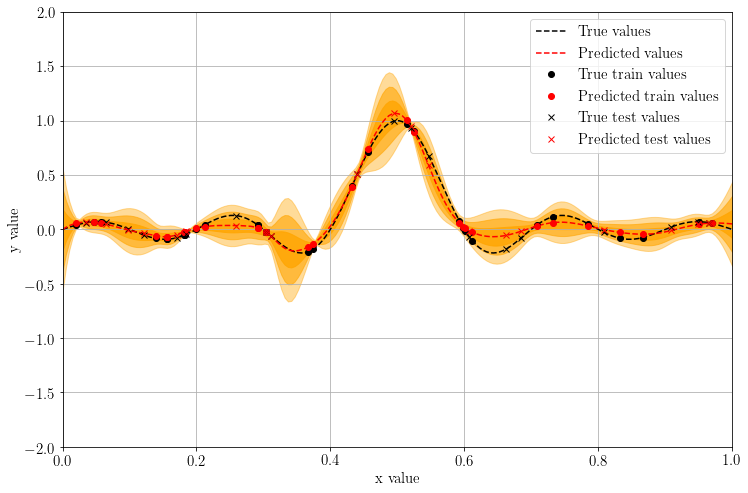

In [405]:
plot_uncertainty(ensemble)

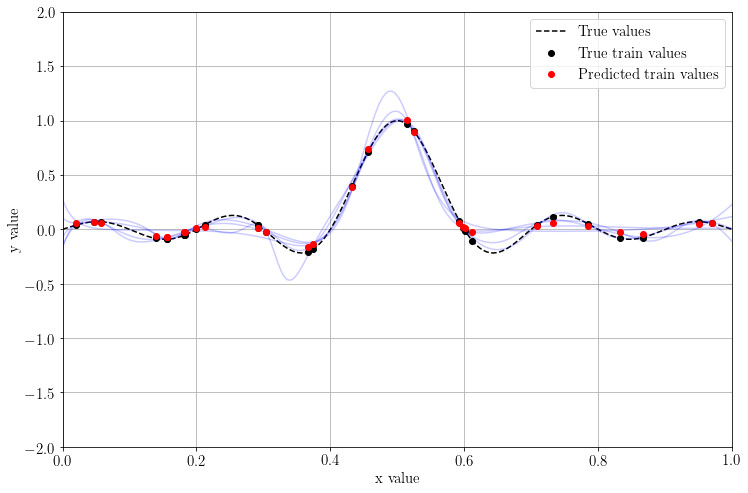

In [406]:
plot_multiple_predictions(ensemble)

### Your Feedback on Exercise 8.2
